In [1]:
!conda install pandas seaborn -y


CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://repo.anaconda.com/pkgs/main/win-64/current_repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.

If your current network has https://www.anaconda.com blocked, please file
a support request with your network engineering team.

'https//repo.anaconda.com/pkgs/main/win-64'




In [2]:
!pip install opencv-python torchsummary scikit-learn torchviz utils imageio

In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import utils
import time
from torch.nn.functional import one_hot
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda


In [5]:
from __future__ import print_function
import argparse
import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
import gc
import matplotlib.colors as mat_color
import numpy as np
from PIL import Image
import random
import cv2
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot
import imageio
from torchvision import datasets, transforms

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):

    def __init__(self, nz, ngf, nc):

        super(Generator, self).__init__()
        self.ReLU = nn.ReLU(True)
        self.Tanh = nn.Tanh()
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 8, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 8)

        self.conv3 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 4)

        self.conv4 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf * 2)
        
        self.conv5 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False)
        self.BatchNorm5 = nn.BatchNorm2d(ngf * 1)

        self.conv6 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)

        self.apply(weights_init)


    def forward(self, input):
        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        
        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.ReLU(x)

        x = self.conv5(x)
        x = self.BatchNorm5(x)
        x = self.ReLU(x)

        x = self.conv6(x)
        output = self.Tanh(x)
        return output

class Discriminator(nn.Module):

    def __init__(self, ndf, nc, nb_label):

        super(Discriminator, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.DropOut1 = nn.Dropout(p=0.5)
        self.DropOut2 = nn.Dropout(p=0.25)
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ndf)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4_1 = nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm4_1 = nn.BatchNorm2d(ndf * 4)
        self.conv4_2 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4_2 = nn.BatchNorm2d(ndf * 8)
        self.conv4_3 = nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4_3 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 1, 4, 1, 0, bias=False)
        self.disc_linear = nn.Linear(ndf * 1, 1)
        self.aux_linear = nn.Linear(ndf * 1, nb_label)
        self.softmax = nn.LogSoftmax()
        self.sigmoid = nn.Sigmoid()
        self.ndf = ndf
        self.apply(weights_init)

    def forward(self, input):

        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv4_2(x)
        x = self.BatchNorm4_2(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)
        x = self.conv4_3(x)
        x = self.BatchNorm4_3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv5(x)
        x = x.view(-1, self.ndf * 1)
        c = self.aux_linear(x)
        c = self.softmax(c)
        s = self.disc_linear(x)
        s = self.sigmoid(s)
        return s, c

In [7]:
def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_generate_animation_epoch%03d' % (e+1) + '.jpg'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

def loss_plot(hist, path='Train_hist', model_name = ''):
    x = range(len(hist['D_losses']))

    plt.plot(x, hist['D_losses'], label='D_losses')
    plt.plot(x, hist['G_losses'], label='G_losses')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')
    plt.savefig(path)
    plt.close()

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    print("image saved at ->", path)
    return imageio.imwrite(path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

In [8]:
class ACGAN(object):
    def __init__(self):
        self.model_name = 'ACGAN'
        self.I_want_to_train_faster = 10
        self.num_epoch = round(12800/self.I_want_to_train_faster)
        self.base_path = './data'
        self.base_folder = "Covid-19 Image Dataset"
        self.classic_folder = 'Coivd-19_Hist'
        self.synthetic_folder = 'Coivd-19_Synthetic'
        self.data_dir = os.path.join(self.base_path, self.classic_folder)
        self.batch_size = 64
        self.train_path = os.path.join(self.data_dir, "train")
        self.test_path = os.path.join(self.data_dir, "test")
        self.labels = os.listdir(self.train_path)
        self.no_norm = mat_color.Normalize(vmin=0, vmax=255, clip=False)
        self.label_dict = {
            i : self.labels[i]
            for i in range(len(self.labels))
        }
        self.img_size = 128
        self.num_of_ch = 3
        # size of z latent vector (i.e. size of generator input)
        self.size_of_z = 512
        self.num_of_label = len(self.labels)
        self.sample_num = 64 # self.num_of_label ** 2
        self.learning_rate_g = 0.000006 * self.I_want_to_train_faster
        self.learning_rate_d = 0.000005 * self.I_want_to_train_faster
        # beta1 hyperparam for adam
        self.adam_beta_1 = 0.5
        # beta2 hyperparam for adam
        self.adam_beta_2 = 0.999
        self.real_label = 1.0
        self.fake_label = 0.0
        self.syn_criterion = nn.BCELoss().to(device) # synthesizing
        self.class_criterion = nn.CrossEntropyLoss().to(device) # classification
        
        self.train_loader, self.test_loader, self.train_data, self.test_data = self.load_dataset()
        self.generator = Generator(self.size_of_z, self.img_size, self.num_of_ch).to(device)
        self.discriminator = Discriminator(self.img_size, self.num_of_ch, self.num_of_label).to(device)

        self.optimizer_d = optim.Adam(self.discriminator.parameters(), 
                                      lr=self.learning_rate_d, 
                                      betas=(self.adam_beta_1, self.adam_beta_2))
        self.optimizer_g = optim.Adam(self.generator.parameters(), 
                                      lr=self.learning_rate_g, 
                                      betas=(self.adam_beta_1, self.adam_beta_2))

        # fixed noise & label
        self.sample_z_fixed = torch.zeros((self.sample_num, self.size_of_z))
        for i in range(round(np.sqrt(self.sample_num))):
            self.sample_z_fixed[i*round(np.sqrt(self.sample_num))] = torch.rand(1, self.size_of_z)
            for j in range(1, round(np.sqrt(self.sample_num))):
                self.sample_z_fixed[i*round(np.sqrt(self.sample_num)) + j] = self.sample_z_fixed[i*round(np.sqrt(self.sample_num))]

        self.sample_z_fixed.resize_(self.sample_num, self.size_of_z, 1, 1)
        temp = torch.zeros((self.num_of_label, 1))
        for i in range(self.num_of_label):
            temp[i, 0] = i

        temp_y = torch.zeros((self.sample_num, 1))
        for i in range(self.num_of_label):
            temp_y[i*self.num_of_label: (i+1)*self.num_of_label] = temp

        self.sample_y_fixed = torch.zeros((self.sample_num, self.num_of_label)).scatter_(1, temp_y.type(torch.LongTensor), 1)
        self.sample_z_fixed, self.sample_y_fixed = self.sample_z_fixed.to(device), self.sample_y_fixed.to(device)
        
    def load_dataset(self):
        train_dir = self.train_path
        test_dir = self.test_path
        transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        train_data = datasets.ImageFolder(train_dir, transform=transform)
        train_loader = DataLoader(train_data, self.batch_size, shuffle=True, num_workers=1)

        test_data = datasets.ImageFolder(test_dir ,transform=transform)
        test_loader = DataLoader(test_data, self.batch_size, shuffle=True, num_workers=1)

        return train_loader, test_loader, train_data, test_data

    def modeltorchviz(model, input_1, input_2):
        if input_2 != None:
            y = model(input_1.to(device), input_2.to(device))
        else:
            y = model(input_1.to(device))
        if input_2 != None:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)] + [('x', input_2)]))
        else:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)]))
        MyConvNetVis.format = "png"
        MyConvNetVis.directory = "images"
        MyConvNetVis.view() 
    
    def visualize_results(self, epoch, fix=True):
        self.generator.eval()

        image_frame_dim = round(np.sqrt(self.sample_num))
        if fix:
            """ fixed noise """
            samples = self.generator(self.sample_z_fixed)
        else:
            """ random noise """
            sample_y_ = torch.zeros(self.batch_size, self.class_num).scatter_(1, torch.randint(0, self.class_num - 1, (self.batch_size, 1)).type(torch.LongTensor), 1)
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            sample_z_, sample_y_ = sample_z_.cuda(), sample_y_.cuda()
            samples = self.generator(sample_z_, sample_y_)

        samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                    os.path.join('.', 'GANAug/plots/ACGAN') + "/" + self.model_name + '_generate_animation_epoch%03d' % epoch + '.png')
    
    def train(self):
        for func in [
            lambda: os.mkdir(os.path.join('.', 'GANAug')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/model')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/plots')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/model/ACGAN')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/plots/ACGAN')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN'))]:
            try:
                func()
            except Exception as error:
                print(error)
                continue
        matrix_fields = [
            'G_losses',
            'G_class_losses',
            'G_syn_losses',
            'D_losses',
            'D_real_losses',
            'D_fake_losses',
            'D_class_losses',
            'D_syn_losses',
            'Losses',
            'Time_per_epoch',
            'Total_time'
        ]
        self.metrics = {field: list() for field in matrix_fields}
        early_stop_count = 0
        early_stop_patient = len(self.train_loader) * 42
        early_stop = False
        best_batch_loss = -1
        save_model = False
        number_of_model_saved = 10
        label_fixed_data = [i%self.num_of_label for i in range(self.sample_num)]
        
        def get_file_list(file_path, length):
            dir_list = os.listdir(file_path)
            dir_list = only_pth_file(dir_list)
            if not dir_list:
                return
            else:
                dir_list = sorted(dir_list,  key=lambda x: os.path.getmtime(os.path.join(file_path, x)))
                print("files to be deleted < length =", length ,"> ->", dir_list[0:length])
                return dir_list[0:length]

        def only_pth_file(file_list):
            new_list = []
            for file in file_list:
                if file[-4:] == ".pth":
                    new_list.append(file)
            return new_list
            
        start_time = time.time()
        print("Start Testing ...")
        print(self.generator)
        print(self.discriminator)
        summary(self.generator, (self.size_of_z, 1, 1), batch_size=self.batch_size, device=device)
        summary(self.discriminator, (self.num_of_ch, self.img_size, self.img_size), batch_size=self.batch_size, device=device)
        g_output = self.generator(torch.rand((self.batch_size, self.size_of_z, 1, 1)).to(device))
        print(g_output.shape)
        s_output, c_output = self.discriminator(torch.rand(g_output.shape).to(device))
        print(s_output.shape)
        print(c_output.shape)
        del g_output, s_output, c_output
        print("Testing Done in ->", time.time() - start_time)
        start_time = time.time()
        print("Start Training ...")

        self.discriminator.train()
        for epoch in range(self.num_epoch):
            epoch += 1
            log_in_data_loader = []
            self.generator.train()
            epoch_start_time = time.time()
            for i, data in enumerate(tqdm(self.train_loader, 0)):
                x_, y_ = data
                batch_size_x_ = x_.size(0)
                z_ = torch.rand((batch_size_x_, self.size_of_z, 1, 1))
                y_vec_ = torch.zeros((batch_size_x_, self.num_of_label)).scatter_(1, y_.type(torch.LongTensor).unsqueeze(1), 1)
                x_, z_, y_vec_ = x_.cuda(), z_.cuda(), y_vec_.cuda()
                self.y_real_, self.y_fake_ = torch.ones(batch_size_x_, 1), torch.zeros(batch_size_x_, 1)
                self.y_real_, self.y_fake_ = self.y_real_.to(device), self.y_fake_.to(device)
        
                # update D network
                self.optimizer_d.zero_grad()

                D_real, C_real = self.discriminator(x_)
                D_real_loss = self.syn_criterion(D_real, self.y_real_)
                C_real_loss = self.class_criterion(C_real, torch.max(y_vec_, 1)[1])

                G_ = self.generator(z_)
                D_fake, C_fake = self.discriminator(G_)
                D_fake_loss = self.syn_criterion(D_fake, self.y_fake_)
                C_fake_loss = self.class_criterion(C_fake, torch.max(y_vec_, 1)[1])

                D_loss = D_real_loss + C_real_loss
                D_loss.backward()
                D_loss = D_fake_loss # + C_fake_loss
                self.metrics['D_losses'].append(D_loss.item())
                self.metrics['D_real_losses'].append((D_real_loss + C_real_loss).item())
                self.metrics['D_fake_losses'].append((D_fake_loss + C_fake_loss).item())
                self.metrics['D_class_losses'].append((C_real_loss + C_fake_loss).item())
                self.metrics['D_syn_losses'].append((D_real_loss + D_fake_loss).item())

                D_loss.backward()
                self.optimizer_d.step()

                # update G network
                self.optimizer_g.zero_grad()

                G_ = self.generator(z_)
                D_fake, C_fake = self.discriminator(G_)

                D_fake_loss = self.syn_criterion(D_fake, self.y_real_)
                C_fake_loss = self.class_criterion(C_fake, torch.max(y_vec_, 1)[1])

                G_loss = D_fake_loss # + C_fake_loss
                self.metrics['G_losses'].append(G_loss.item())
                self.metrics['G_syn_losses'].append(D_fake_loss.item())
                self.metrics['G_class_losses'].append(C_fake_loss.item())
                self.metrics['Losses'].append(self.metrics['G_losses'][-1] + self.metrics['D_losses'][-1])

                G_loss.backward()
                self.optimizer_g.step()

                if best_batch_loss < 0:
                    best_batch_loss = self.metrics['Losses'][-1]
                    early_stop_count = 0
                else:
                    if best_batch_loss >= self.metrics['Losses'][-1]:
                        best_batch_loss = self.metrics['Losses'][-1]
                        early_stop_count = 0
                        log_in_data_loader.append("---------------------<lowest loss update -> " + str(best_batch_loss) + " at -> " + str(i + 1) + ">---------------------")
                        save_model = True
                    else:
                        early_stop_count += 1
                        if early_stop_count >= early_stop_patient:
                            log_in_data_loader.append("-----------------------------------< early stopping ... >-----------------------------------")
                            early_stop = True

                if i == 0:
                    vutils.save_image(x_, './GANAug/output_images/ACGAN/real_samples_e' + str(epoch) + '_d' + str(i) + '.jpg', normalize=True)

            self.metrics['Time_per_epoch'].append(time.time() - epoch_start_time)
#             with torch.no_grad():
#                 self.visualize_results(epoch)
            fake = self.generator(self.sample_z_fixed)
            vutils.save_image(fake.data,
                    '%s/ACGAN_generate_animation_epoch%03d' % ('./GANAug/plots/ACGAN', epoch) + '.jpg', normalize=True)
    
            for message in log_in_data_loader:
                print(message)
            print('[%d/%d] ======================================================================== \nLoss_D: %.8f, Loss_G: %.8f\nLoss_S_D: %.8f, Loss_C_D: %.8f, Loss_R_D: %.8f, Loss_F_D: %.8f\nLoss_S_G: %.8f, Loss_C_G: %.8f'
                  % (epoch, self.num_epoch, 
                     np.mean(self.metrics['D_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['G_losses'][-len(self.train_loader):]),
                     np.mean(self.metrics['D_syn_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_class_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_real_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_fake_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['G_syn_losses'][-len(self.train_loader):]),
                     np.mean(self.metrics['G_class_losses'][-len(self.train_loader):])))

            # do checkpointing
            if save_model == True:
                save_model = False
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
            elif early_stop:
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
#                 break
            elif epoch % round(self.num_epoch/5) == 0:
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
            else:
                print("---------------------< no model saved at epoch:", epoch, ">---------------------")

            if len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/ACGAN')))) > number_of_model_saved:
                delete_list = get_file_list(os.path.join('.', 'GANAug/model/ACGAN'), 
                                            len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/ACGAN')))) - number_of_model_saved)
                for file in delete_list:
                    if os.path.exists(os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file)):
                        os.remove(os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file))
                    else:
                        print("file ->", os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file), "does not exist")

        self.metrics['Total_time'].append(time.time() - start_time)
        print("Average epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.metrics['Time_per_epoch']),
                                                                        self.num_epoch, self.metrics['Total_time'][0]))
        generate_animation(os.path.join('.', 'GANAug/plots/ACGAN/') + self.model_name, self.num_epoch)
        loss_plot(self.metrics, os.path.join('.', 'GANAug/plots/ACGAN/'), self.model_name + "_loss_plot")
        print("Training Done !")

In [9]:
acgan = ACGAN()

In [10]:
acgan.train()

Start Testing ...
Generator(
  (ReLU): ReLU(inplace=True)
  (Tanh): Tanh()
  (conv1): ConvTranspose2d(512, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BatchNorm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm5): BatchNorm2d(128, eps=1e-05, mom

C:\Users\lebro\AppData\Local\Temp\ipykernel_22448\1298441974.py:118: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 128, 64, 64]           6,144
       BatchNorm2d-2          [64, 128, 64, 64]             256
         LeakyReLU-3          [64, 128, 64, 64]               0
           Dropout-4          [64, 128, 64, 64]               0
            Conv2d-5          [64, 256, 32, 32]         524,288
       BatchNorm2d-6          [64, 256, 32, 32]             512
         LeakyReLU-7          [64, 256, 32, 32]               0
           Dropout-8          [64, 256, 32, 32]               0
            Conv2d-9          [64, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [64, 512, 16, 16]           1,024
        LeakyReLU-11          [64, 512, 16, 16]               0
          Dropout-12          [64, 512, 16, 16]               0
           Conv2d-13           [64, 1024, 8, 8]       8,388,608
      BatchNorm2d-14           [64, 102

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.03it/s]


[1/1280] ======================================================================== 
Loss_D: 2.72741115, Loss_G: 2.09755123
Loss_S_D: 3.41452277, Loss_C_D: 2.82924765, Loss_R_D: 2.01593512, Loss_F_D: 4.22783518
Loss_S_G: 2.09755123, Loss_C_G: 1.66093314
---------------------< no model saved at epoch: 1 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


[2/1280] ======================================================================== 
Loss_D: 2.64798516, Loss_G: 2.55218536
Loss_S_D: 3.54674006, Loss_C_D: 2.35301584, Loss_R_D: 1.67577270, Loss_F_D: 4.22398317
Loss_S_G: 2.55218536, Loss_C_G: 1.58850563
---------------------< no model saved at epoch: 2 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


[3/1280] ======================================================================== 
Loss_D: 1.43645942, Loss_G: 3.82175446
Loss_S_D: 2.25603077, Loss_C_D: 2.05223873, Loss_R_D: 1.31616470, Loss_F_D: 2.99210477
Loss_S_G: 3.82175446, Loss_C_G: 1.56214437
---------------------< no model saved at epoch: 3 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


[4/1280] ======================================================================== 
Loss_D: 1.01666731, Loss_G: 4.30357993
Loss_S_D: 1.70912966, Loss_C_D: 2.06668320, Loss_R_D: 1.14021301, Loss_F_D: 2.63559991
Loss_S_G: 4.30357993, Loss_C_G: 1.55889177
---------------------< no model saved at epoch: 4 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


[5/1280] ======================================================================== 
Loss_D: 0.77297623, Loss_G: 4.56539679
Loss_S_D: 1.68053296, Loss_C_D: 1.92782724, Loss_R_D: 1.25189242, Loss_F_D: 2.35646784
Loss_S_G: 4.56539679, Loss_C_G: 1.64993012
---------------------< no model saved at epoch: 5 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


[6/1280] ======================================================================== 
Loss_D: 0.74922045, Loss_G: 4.63756192
Loss_S_D: 1.61450776, Loss_C_D: 1.82570109, Loss_R_D: 1.18533927, Loss_F_D: 2.25486961
Loss_S_G: 4.63756192, Loss_C_G: 1.77246070
---------------------< no model saved at epoch: 6 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


---------------------<lowest loss update -> 4.64211893081665 at -> 2>---------------------
---------------------<lowest loss update -> 4.569460153579712 at -> 4>---------------------
[7/1280] ======================================================================== 
Loss_D: 0.62617584, Loss_G: 4.72964466
Loss_S_D: 1.67561209, Loss_C_D: 1.96929118, Loss_R_D: 1.36134788, Loss_F_D: 2.28355545
Loss_S_G: 4.72964466, Loss_C_G: 1.88573074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


[8/1280] ======================================================================== 
Loss_D: 0.61479004, Loss_G: 5.18426454
Loss_S_D: 1.49364421, Loss_C_D: 1.87764961, Loss_R_D: 1.16645455, Loss_F_D: 2.20483935
Loss_S_G: 5.18426454, Loss_C_G: 1.88170528
---------------------< no model saved at epoch: 8 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


---------------------<lowest loss update -> 4.242335379123688 at -> 2>---------------------
---------------------<lowest loss update -> 2.6397459506988525 at -> 4>---------------------
[9/1280] ======================================================================== 
Loss_D: 0.45330015, Loss_G: 5.06173074
Loss_S_D: 1.41398981, Loss_C_D: 1.84054330, Loss_R_D: 1.18344840, Loss_F_D: 2.07108471
Loss_S_G: 5.06173074, Loss_C_G: 1.77475381


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


[10/1280] ======================================================================== 
Loss_D: 0.69655900, Loss_G: 6.88913453
Loss_S_D: 1.31991962, Loss_C_D: 1.98554718, Loss_R_D: 0.89362268, Loss_F_D: 2.41184407
Loss_S_G: 6.88913453, Loss_C_G: 2.10453779
---------------------< no model saved at epoch: 10 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


[11/1280] ======================================================================== 
Loss_D: 0.47880333, Loss_G: 6.09885401
Loss_S_D: 1.14646748, Loss_C_D: 2.09323496, Loss_R_D: 0.91966283, Loss_F_D: 2.32003957
Loss_S_G: 6.09885401, Loss_C_G: 1.97983998
---------------------< no model saved at epoch: 11 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


---------------------<lowest loss update -> 1.736621615709737 at -> 3>---------------------
[12/1280] ======================================================================== 
Loss_D: 1.02234737, Loss_G: 6.29837936
Loss_S_D: 1.99785262, Loss_C_D: 2.52519441, Loss_R_D: 1.30441421, Loss_F_D: 3.21863288
Loss_S_G: 6.29837936, Loss_C_G: 2.36335081


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


---------------------<lowest loss update -> 0.5745053701102734 at -> 4>---------------------
[13/1280] ======================================================================== 
Loss_D: 0.21372167, Loss_G: 5.62116404
Loss_S_D: 0.98554343, Loss_C_D: 2.19421571, Loss_R_D: 0.92699314, Loss_F_D: 2.25276601
Loss_S_G: 5.62116404, Loss_C_G: 2.16851124


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


[14/1280] ======================================================================== 
Loss_D: 1.15169859, Loss_G: 5.77355316
Loss_S_D: 2.10936087, Loss_C_D: 1.85576800, Loss_R_D: 1.13669677, Loss_F_D: 2.82843205
Loss_S_G: 5.77355316, Loss_C_G: 2.08948046
---------------------< no model saved at epoch: 14 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


---------------------<lowest loss update -> 0.10940459230914712 at -> 2>---------------------
[15/1280] ======================================================================== 
Loss_D: 1.87528941, Loss_G: 5.26952593
Loss_S_D: 3.61974207, Loss_C_D: 1.77296299, Loss_R_D: 1.90592641, Loss_F_D: 3.48677850
Loss_S_G: 5.26952593, Loss_C_G: 1.71930054


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


[16/1280] ======================================================================== 
Loss_D: 1.19053119, Loss_G: 3.65063480
Loss_S_D: 2.86782941, Loss_C_D: 1.75544503, Loss_R_D: 1.77390772, Loss_F_D: 2.84936672
Loss_S_G: 3.65063480, Loss_C_G: 1.51837525
---------------------< no model saved at epoch: 16 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


[17/1280] ======================================================================== 
Loss_D: 1.04956990, Loss_G: 2.70567328
Loss_S_D: 2.91123253, Loss_C_D: 1.76584807, Loss_R_D: 1.99568562, Loss_F_D: 2.68139496
Loss_S_G: 2.70567328, Loss_C_G: 1.78458294
---------------------< no model saved at epoch: 17 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


[18/1280] ======================================================================== 
Loss_D: 0.81477009, Loss_G: 3.22375119
Loss_S_D: 2.17692265, Loss_C_D: 1.98967025, Loss_R_D: 1.50500736, Loss_F_D: 2.66158560
Loss_S_G: 3.22375119, Loss_C_G: 1.52740970
---------------------< no model saved at epoch: 18 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


[19/1280] ======================================================================== 
Loss_D: 1.13755772, Loss_G: 2.96085536
Loss_S_D: 2.74529856, Loss_C_D: 1.69736478, Loss_R_D: 1.76300411, Loss_F_D: 2.67965928
Loss_S_G: 2.96085536, Loss_C_G: 1.60141662
---------------------< no model saved at epoch: 19 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


[20/1280] ======================================================================== 
Loss_D: 0.81137268, Loss_G: 2.87362291
Loss_S_D: 2.06833103, Loss_C_D: 1.72409716, Loss_R_D: 1.39920512, Loss_F_D: 2.39322296
Loss_S_G: 2.87362291, Loss_C_G: 1.73336640
---------------------< no model saved at epoch: 20 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


[21/1280] ======================================================================== 
Loss_D: 0.81922493, Loss_G: 2.99171138
Loss_S_D: 1.91391245, Loss_C_D: 1.79398692, Loss_R_D: 1.21269068, Loss_F_D: 2.49520868
Loss_S_G: 2.99171138, Loss_C_G: 1.97029376
---------------------< no model saved at epoch: 21 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


[22/1280] ======================================================================== 
Loss_D: 0.63245053, Loss_G: 2.94910663
Loss_S_D: 1.63866234, Loss_C_D: 1.88655040, Loss_R_D: 1.11711659, Loss_F_D: 2.40809608
Loss_S_G: 2.94910663, Loss_C_G: 2.02097744
---------------------< no model saved at epoch: 22 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


[23/1280] ======================================================================== 
Loss_D: 1.00665361, Loss_G: 3.54543573
Loss_S_D: 2.18076119, Loss_C_D: 2.00147140, Loss_R_D: 1.28552602, Loss_F_D: 2.89670664
Loss_S_G: 3.54543573, Loss_C_G: 2.32966852
---------------------< no model saved at epoch: 23 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


[24/1280] ======================================================================== 
Loss_D: 0.75080994, Loss_G: 3.29536694
Loss_S_D: 2.06765568, Loss_C_D: 2.21632934, Loss_R_D: 1.41386910, Loss_F_D: 2.87011594
Loss_S_G: 3.29536694, Loss_C_G: 2.50002438
---------------------< no model saved at epoch: 24 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


[25/1280] ======================================================================== 
Loss_D: 0.34940572, Loss_G: 3.36460340
Loss_S_D: 1.19999048, Loss_C_D: 2.27572286, Loss_R_D: 0.93312709, Loss_F_D: 2.54258621
Loss_S_G: 3.36460340, Loss_C_G: 2.31270984
---------------------< no model saved at epoch: 25 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


[26/1280] ======================================================================== 
Loss_D: 0.62540656, Loss_G: 3.86338168
Loss_S_D: 1.64247218, Loss_C_D: 2.41725528, Loss_R_D: 1.10673991, Loss_F_D: 2.95298755
Loss_S_G: 3.86338168, Loss_C_G: 2.30213779
---------------------< no model saved at epoch: 26 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


[27/1280] ======================================================================== 
Loss_D: 0.77291633, Loss_G: 3.97726876
Loss_S_D: 2.04389316, Loss_C_D: 3.02315718, Loss_R_D: 1.37053864, Loss_F_D: 3.69651175
Loss_S_G: 3.97726876, Loss_C_G: 2.74433160
---------------------< no model saved at epoch: 27 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


[28/1280] ======================================================================== 
Loss_D: 0.71748327, Loss_G: 3.97577238
Loss_S_D: 1.99458894, Loss_C_D: 4.08299184, Loss_R_D: 1.38972715, Loss_F_D: 4.68785363
Loss_S_G: 3.97577238, Loss_C_G: 3.74022812
---------------------< no model saved at epoch: 28 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[29/1280] ======================================================================== 
Loss_D: 1.16192690, Loss_G: 5.01419044
Loss_S_D: 2.85093743, Loss_C_D: 2.93367144, Loss_R_D: 1.81732827, Loss_F_D: 3.96728063
Loss_S_G: 5.01419044, Loss_C_G: 2.44508898
---------------------< no model saved at epoch: 29 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[30/1280] ======================================================================== 
Loss_D: 0.84637920, Loss_G: 4.41970515
Loss_S_D: 1.99958453, Loss_C_D: 1.91145402, Loss_R_D: 1.27818852, Loss_F_D: 2.63285002
Loss_S_G: 4.41970515, Loss_C_G: 1.72576636
---------------------< no model saved at epoch: 30 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[31/1280] ======================================================================== 
Loss_D: 0.46147306, Loss_G: 4.36618280
Loss_S_D: 1.11735046, Loss_C_D: 1.79140916, Loss_R_D: 0.76339926, Loss_F_D: 2.14536041
Loss_S_G: 4.36618280, Loss_C_G: 1.57752591
---------------------< no model saved at epoch: 31 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


[32/1280] ======================================================================== 
Loss_D: 0.86920413, Loss_G: 4.30072367
Loss_S_D: 2.07122135, Loss_C_D: 1.65823895, Loss_R_D: 1.29972106, Loss_F_D: 2.42973930
Loss_S_G: 4.30072367, Loss_C_G: 1.46307680
---------------------< no model saved at epoch: 32 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[33/1280] ======================================================================== 
Loss_D: 1.02592589, Loss_G: 4.35596132
Loss_S_D: 2.85405320, Loss_C_D: 1.55005091, Loss_R_D: 1.91571569, Loss_F_D: 2.48838839
Loss_S_G: 4.35596132, Loss_C_G: 1.66119981
---------------------< no model saved at epoch: 33 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[34/1280] ======================================================================== 
Loss_D: 0.83024209, Loss_G: 3.64022845
Loss_S_D: 2.42367822, Loss_C_D: 1.92678460, Loss_R_D: 1.67577417, Loss_F_D: 2.67468870
Loss_S_G: 3.64022845, Loss_C_G: 2.02951419
---------------------< no model saved at epoch: 34 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


[35/1280] ======================================================================== 
Loss_D: 0.49154674, Loss_G: 4.06408381
Loss_S_D: 1.16875511, Loss_C_D: 2.10939008, Loss_R_D: 0.75015021, Loss_F_D: 2.52799499
Loss_S_G: 4.06408381, Loss_C_G: 2.42972732
---------------------< no model saved at epoch: 35 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


[36/1280] ======================================================================== 
Loss_D: 0.65393598, Loss_G: 3.52277976
Loss_S_D: 1.93022829, Loss_C_D: 1.62656233, Loss_R_D: 1.36023825, Loss_F_D: 2.19655234
Loss_S_G: 3.52277976, Loss_C_G: 1.62417307
---------------------< no model saved at epoch: 36 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[37/1280] ======================================================================== 
Loss_D: 0.92647293, Loss_G: 3.84430918
Loss_S_D: 2.50647968, Loss_C_D: 1.71161413, Loss_R_D: 1.65784529, Loss_F_D: 2.56024849
Loss_S_G: 3.84430918, Loss_C_G: 1.71340930
---------------------< no model saved at epoch: 37 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[38/1280] ======================================================================== 
Loss_D: 1.11085763, Loss_G: 4.10632783
Loss_S_D: 2.38835195, Loss_C_D: 2.07715973, Loss_R_D: 1.34841394, Loss_F_D: 3.11709771
Loss_S_G: 4.10632783, Loss_C_G: 1.85300082
---------------------< no model saved at epoch: 38 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[39/1280] ======================================================================== 
Loss_D: 0.68091043, Loss_G: 3.90899444
Loss_S_D: 1.77872652, Loss_C_D: 2.01685312, Loss_R_D: 1.19009325, Loss_F_D: 2.60548639
Loss_S_G: 3.90899444, Loss_C_G: 1.81367639
---------------------< no model saved at epoch: 39 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[40/1280] ======================================================================== 
Loss_D: 0.64380008, Loss_G: 3.94580370
Loss_S_D: 1.27546379, Loss_C_D: 2.10263881, Loss_R_D: 0.69831115, Loss_F_D: 2.67979145
Loss_S_G: 3.94580370, Loss_C_G: 1.79695070
---------------------< no model saved at epoch: 40 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[41/1280] ======================================================================== 
Loss_D: 0.42464276, Loss_G: 3.89975673
Loss_S_D: 0.91176552, Loss_C_D: 2.27819577, Loss_R_D: 0.57550362, Loss_F_D: 2.61445767
Loss_S_G: 3.89975673, Loss_C_G: 1.99503607
---------------------< no model saved at epoch: 41 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


[42/1280] ======================================================================== 
Loss_D: 0.26221577, Loss_G: 3.80842805
Loss_S_D: 0.72184904, Loss_C_D: 1.88496116, Loss_R_D: 0.54690904, Loss_F_D: 2.05990109
Loss_S_G: 3.80842805, Loss_C_G: 1.86463603
---------------------< no model saved at epoch: 42 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[43/1280] ======================================================================== 
Loss_D: 0.40538097, Loss_G: 4.14156842
Loss_S_D: 0.89093119, Loss_C_D: 1.94600439, Loss_R_D: 0.56325182, Loss_F_D: 2.27368379
Loss_S_G: 4.14156842, Loss_C_G: 1.85367447
---------------------< no model saved at epoch: 43 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


[44/1280] ======================================================================== 
Loss_D: 0.34892331, Loss_G: 4.15262491
Loss_S_D: 0.93882436, Loss_C_D: 2.62276304, Loss_R_D: 0.64875779, Loss_F_D: 2.91282964
Loss_S_G: 4.15262491, Loss_C_G: 2.39115989
---------------------< no model saved at epoch: 44 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[45/1280] ======================================================================== 
Loss_D: 0.42798568, Loss_G: 4.50134480
Loss_S_D: 1.08716443, Loss_C_D: 2.59503728, Loss_R_D: 0.73612708, Loss_F_D: 2.94607466
Loss_S_G: 4.50134480, Loss_C_G: 2.54146677
---------------------< no model saved at epoch: 45 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[46/1280] ======================================================================== 
Loss_D: 0.52278088, Loss_G: 4.92925078
Loss_S_D: 1.79981434, Loss_C_D: 2.15622613, Loss_R_D: 1.36816519, Loss_F_D: 2.58787525
Loss_S_G: 4.92925078, Loss_C_G: 1.92888424
---------------------< no model saved at epoch: 46 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


[47/1280] ======================================================================== 
Loss_D: 1.54710227, Loss_G: 6.33145380
Loss_S_D: 3.01186728, Loss_C_D: 2.19070157, Loss_R_D: 1.55097073, Loss_F_D: 3.65159822
Loss_S_G: 6.33145380, Loss_C_G: 2.05311784
---------------------< no model saved at epoch: 47 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


[48/1280] ======================================================================== 
Loss_D: 1.22550635, Loss_G: 5.49013573
Loss_S_D: 2.43015748, Loss_C_D: 2.82788473, Loss_R_D: 1.28167428, Loss_F_D: 3.97636795
Loss_S_G: 5.49013573, Loss_C_G: 2.48904398
---------------------< no model saved at epoch: 48 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


[49/1280] ======================================================================== 
Loss_D: 0.56261997, Loss_G: 3.81675744
Loss_S_D: 1.48112255, Loss_C_D: 2.72290939, Loss_R_D: 1.00357708, Loss_F_D: 3.20045489
Loss_S_G: 3.81675744, Loss_C_G: 2.43865716
---------------------< no model saved at epoch: 49 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


[50/1280] ======================================================================== 
Loss_D: 0.63568101, Loss_G: 3.84633917
Loss_S_D: 1.44816753, Loss_C_D: 2.57505190, Loss_R_D: 0.88663124, Loss_F_D: 3.13658828
Loss_S_G: 3.84633917, Loss_C_G: 2.30234438
---------------------< no model saved at epoch: 50 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


[51/1280] ======================================================================== 
Loss_D: 0.69762694, Loss_G: 3.36981130
Loss_S_D: 1.77421233, Loss_C_D: 1.80981621, Loss_R_D: 1.13603291, Loss_F_D: 2.44799560
Loss_S_G: 3.36981130, Loss_C_G: 1.65080708
---------------------< no model saved at epoch: 51 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


[52/1280] ======================================================================== 
Loss_D: 0.57487729, Loss_G: 3.60961276
Loss_S_D: 1.53834683, Loss_C_D: 1.70506087, Loss_R_D: 1.00355189, Loss_F_D: 2.23985580
Loss_S_G: 3.60961276, Loss_C_G: 1.66978472
---------------------< no model saved at epoch: 52 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


[53/1280] ======================================================================== 
Loss_D: 0.42161458, Loss_G: 3.70439291
Loss_S_D: 1.16630325, Loss_C_D: 2.74010146, Loss_R_D: 0.80549096, Loss_F_D: 3.10091376
Loss_S_G: 3.70439291, Loss_C_G: 2.91828138
---------------------< no model saved at epoch: 53 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


[54/1280] ======================================================================== 
Loss_D: 0.48933795, Loss_G: 3.90879965
Loss_S_D: 1.04370455, Loss_C_D: 3.34957415, Loss_R_D: 0.63286735, Loss_F_D: 3.76041126
Loss_S_G: 3.90879965, Loss_C_G: 3.67559534
---------------------< no model saved at epoch: 54 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


[55/1280] ======================================================================== 
Loss_D: 0.38188144, Loss_G: 3.82044750
Loss_S_D: 1.00379917, Loss_C_D: 2.57083452, Loss_R_D: 0.67722578, Loss_F_D: 2.89740789
Loss_S_G: 3.82044750, Loss_C_G: 3.08706677
---------------------< no model saved at epoch: 55 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


[56/1280] ======================================================================== 
Loss_D: 0.56366061, Loss_G: 4.76353496
Loss_S_D: 1.38967445, Loss_C_D: 2.14827931, Loss_R_D: 0.88190700, Loss_F_D: 2.65604681
Loss_S_G: 4.76353496, Loss_C_G: 2.04240653
---------------------< no model saved at epoch: 56 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[57/1280] ======================================================================== 
Loss_D: 0.96981572, Loss_G: 5.20307219
Loss_S_D: 2.18610212, Loss_C_D: 1.86877519, Loss_R_D: 1.27827076, Loss_F_D: 2.77660665
Loss_S_G: 5.20307219, Loss_C_G: 1.72013497
files to be deleted < length = 2 > -> ['G_epoch_7_save_model.pth', 'D_epoch_7_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[58/1280] ======================================================================== 
Loss_D: 0.61921266, Loss_G: 4.34349245
Loss_S_D: 1.37758946, Loss_C_D: 1.60718578, Loss_R_D: 0.81013043, Loss_F_D: 2.17464486
Loss_S_G: 4.34349245, Loss_C_G: 1.50824761
files to be deleted < length = 2 > -> ['G_epoch_9_save_model.pth', 'D_epoch_9_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[59/1280] ======================================================================== 
Loss_D: 0.47373907, Loss_G: 3.45110548
Loss_S_D: 1.32005256, Loss_C_D: 2.07709077, Loss_R_D: 0.90155233, Loss_F_D: 2.49559104
Loss_S_G: 3.45110548, Loss_C_G: 1.84508187
files to be deleted < length = 2 > -> ['G_epoch_12_save_model.pth', 'D_epoch_12_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[60/1280] ======================================================================== 
Loss_D: 0.31367400, Loss_G: 3.34757870
Loss_S_D: 0.98698185, Loss_C_D: 1.81312639, Loss_R_D: 0.71897310, Loss_F_D: 2.08113509
Loss_S_G: 3.34757870, Loss_C_G: 1.90122819
files to be deleted < length = 2 > -> ['G_epoch_13_save_model.pth', 'D_epoch_13_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[61/1280] ======================================================================== 
Loss_D: 0.41939217, Loss_G: 4.08440220
Loss_S_D: 0.87420961, Loss_C_D: 1.89144593, Loss_R_D: 0.50651453, Loss_F_D: 2.25914106
Loss_S_G: 4.08440220, Loss_C_G: 1.98658442
files to be deleted < length = 2 > -> ['G_epoch_15_save_model.pth', 'D_epoch_15_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[62/1280] ======================================================================== 
Loss_D: 0.60078507, Loss_G: 3.93330455
Loss_S_D: 1.56333810, Loss_C_D: 1.73514771, Loss_R_D: 1.01985134, Loss_F_D: 2.27863443
Loss_S_G: 3.93330455, Loss_C_G: 1.81957701
files to be deleted < length = 2 > -> ['G_epoch_57_early_stop.pth', 'D_epoch_57_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[63/1280] ======================================================================== 
Loss_D: 0.33294059, Loss_G: 3.56416434
Loss_S_D: 1.02980675, Loss_C_D: 1.53729963, Loss_R_D: 0.78587336, Loss_F_D: 1.78123304
Loss_S_G: 3.56416434, Loss_C_G: 1.54534850
files to be deleted < length = 2 > -> ['G_epoch_58_early_stop.pth', 'D_epoch_58_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[64/1280] ======================================================================== 
Loss_D: 0.23882671, Loss_G: 3.61976278
Loss_S_D: 0.56390749, Loss_C_D: 1.47059309, Loss_R_D: 0.36547289, Loss_F_D: 1.66902772
Loss_S_G: 3.61976278, Loss_C_G: 1.46679631
files to be deleted < length = 2 > -> ['G_epoch_59_early_stop.pth', 'D_epoch_59_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[65/1280] ======================================================================== 
Loss_D: 0.31191374, Loss_G: 3.57147098
Loss_S_D: 0.74537316, Loss_C_D: 1.71927971, Loss_R_D: 0.48299944, Loss_F_D: 1.98165342
Loss_S_G: 3.57147098, Loss_C_G: 1.64724514
files to be deleted < length = 2 > -> ['G_epoch_60_early_stop.pth', 'D_epoch_60_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[66/1280] ======================================================================== 
Loss_D: 0.39836391, Loss_G: 3.49494809
Loss_S_D: 1.08165774, Loss_C_D: 1.73379457, Loss_R_D: 0.73584203, Loss_F_D: 2.07961026
Loss_S_G: 3.49494809, Loss_C_G: 1.78157082
files to be deleted < length = 2 > -> ['G_epoch_61_early_stop.pth', 'D_epoch_61_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[67/1280] ======================================================================== 
Loss_D: 0.25373764, Loss_G: 3.81851351
Loss_S_D: 0.55246788, Loss_C_D: 2.16021839, Loss_R_D: 0.36751302, Loss_F_D: 2.34517324
Loss_S_G: 3.81851351, Loss_C_G: 2.40481034
files to be deleted < length = 2 > -> ['G_epoch_62_early_stop.pth', 'D_epoch_62_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[68/1280] ======================================================================== 
Loss_D: 0.25360281, Loss_G: 3.64186823
Loss_S_D: 0.57044262, Loss_C_D: 2.70369524, Loss_R_D: 0.36500710, Loss_F_D: 2.90913069
Loss_S_G: 3.64186823, Loss_C_G: 2.72489220
files to be deleted < length = 2 > -> ['G_epoch_63_early_stop.pth', 'D_epoch_63_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[69/1280] ======================================================================== 
Loss_D: 0.50983879, Loss_G: 4.37524092
Loss_S_D: 1.36165097, Loss_C_D: 2.31496289, Loss_R_D: 0.89163863, Loss_F_D: 2.78497523
Loss_S_G: 4.37524092, Loss_C_G: 2.64069039
files to be deleted < length = 2 > -> ['G_epoch_64_early_stop.pth', 'D_epoch_64_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[70/1280] ======================================================================== 
Loss_D: 0.54161650, Loss_G: 4.30706894
Loss_S_D: 1.35058102, Loss_C_D: 2.11656043, Loss_R_D: 0.85336368, Loss_F_D: 2.61377776
Loss_S_G: 4.30706894, Loss_C_G: 2.35071671
files to be deleted < length = 2 > -> ['G_epoch_65_early_stop.pth', 'D_epoch_65_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[71/1280] ======================================================================== 
Loss_D: 0.29548176, Loss_G: 3.59336144
Loss_S_D: 1.04804051, Loss_C_D: 1.83913973, Loss_R_D: 0.82276121, Loss_F_D: 2.06441903
Loss_S_G: 3.59336144, Loss_C_G: 2.16967791
files to be deleted < length = 2 > -> ['G_epoch_66_early_stop.pth', 'D_epoch_66_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[72/1280] ======================================================================== 
Loss_D: 0.32825148, Loss_G: 4.12444639
Loss_S_D: 0.67412579, Loss_C_D: 2.71555808, Loss_R_D: 0.40101131, Loss_F_D: 2.98867255
Loss_S_G: 4.12444639, Loss_C_G: 2.86088181
files to be deleted < length = 2 > -> ['G_epoch_67_early_stop.pth', 'D_epoch_67_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[73/1280] ======================================================================== 
Loss_D: 0.38289666, Loss_G: 3.90238291
Loss_S_D: 1.08898051, Loss_C_D: 3.54951626, Loss_R_D: 0.75182804, Loss_F_D: 3.88666874
Loss_S_G: 3.90238291, Loss_C_G: 3.42666036
files to be deleted < length = 2 > -> ['G_epoch_68_early_stop.pth', 'D_epoch_68_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[74/1280] ======================================================================== 
Loss_D: 0.48613780, Loss_G: 4.30453420
Loss_S_D: 1.51569310, Loss_C_D: 2.30809370, Loss_R_D: 1.07046610, Loss_F_D: 2.75332069
Loss_S_G: 4.30453420, Loss_C_G: 2.28580788
files to be deleted < length = 2 > -> ['G_epoch_69_early_stop.pth', 'D_epoch_69_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[75/1280] ======================================================================== 
Loss_D: 0.50843285, Loss_G: 5.64283252
Loss_S_D: 1.09773495, Loss_C_D: 2.75273624, Loss_R_D: 0.64153805, Loss_F_D: 3.20893306
Loss_S_G: 5.64283252, Loss_C_G: 2.38037571
files to be deleted < length = 2 > -> ['G_epoch_70_early_stop.pth', 'D_epoch_70_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[76/1280] ======================================================================== 
Loss_D: 0.24887503, Loss_G: 4.10931563
Loss_S_D: 0.54778135, Loss_C_D: 5.43005848, Loss_R_D: 0.33963145, Loss_F_D: 5.63820851
Loss_S_G: 4.10931563, Loss_C_G: 4.97106516
files to be deleted < length = 2 > -> ['G_epoch_71_early_stop.pth', 'D_epoch_71_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[77/1280] ======================================================================== 
Loss_D: 0.22581388, Loss_G: 3.92544872
Loss_S_D: 0.55271475, Loss_C_D: 5.81451511, Loss_R_D: 0.36518270, Loss_F_D: 6.00204694
Loss_S_G: 3.92544872, Loss_C_G: 5.83699119
files to be deleted < length = 2 > -> ['G_epoch_72_early_stop.pth', 'D_epoch_72_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[78/1280] ======================================================================== 
Loss_D: 0.33461815, Loss_G: 4.31548828
Loss_S_D: 0.83549787, Loss_C_D: 6.89337254, Loss_R_D: 0.53963581, Loss_F_D: 7.18923473
Loss_S_G: 4.31548828, Loss_C_G: 6.68818378
files to be deleted < length = 2 > -> ['G_epoch_73_early_stop.pth', 'D_epoch_73_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[79/1280] ======================================================================== 
Loss_D: 0.43415636, Loss_G: 4.20516592
Loss_S_D: 1.31411856, Loss_C_D: 6.16524827, Loss_R_D: 0.92675184, Loss_F_D: 6.55261517
Loss_S_G: 4.20516592, Loss_C_G: 5.84219742
files to be deleted < length = 2 > -> ['G_epoch_74_early_stop.pth', 'D_epoch_74_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[80/1280] ======================================================================== 
Loss_D: 0.28251128, Loss_G: 4.56667900
Loss_S_D: 0.87458444, Loss_C_D: 3.80806237, Loss_R_D: 0.62091447, Loss_F_D: 4.06173223
Loss_S_G: 4.56667900, Loss_C_G: 3.76586324
files to be deleted < length = 2 > -> ['G_epoch_75_early_stop.pth', 'D_epoch_75_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[81/1280] ======================================================================== 
Loss_D: 0.54012474, Loss_G: 4.90132922
Loss_S_D: 1.87729633, Loss_C_D: 2.27103081, Loss_R_D: 1.38493665, Loss_F_D: 2.76339054
Loss_S_G: 4.90132922, Loss_C_G: 2.10388720
files to be deleted < length = 2 > -> ['G_epoch_76_early_stop.pth', 'D_epoch_76_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[82/1280] ======================================================================== 
Loss_D: 0.31836607, Loss_G: 3.55452961
Loss_S_D: 0.84592327, Loss_C_D: 1.86791405, Loss_R_D: 0.56373122, Loss_F_D: 2.15010607
Loss_S_G: 3.55452961, Loss_C_G: 1.74096408
files to be deleted < length = 2 > -> ['G_epoch_77_early_stop.pth', 'D_epoch_77_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[83/1280] ======================================================================== 
Loss_D: 0.29774557, Loss_G: 3.92992812
Loss_S_D: 0.73955517, Loss_C_D: 2.24502900, Loss_R_D: 0.46956825, Loss_F_D: 2.51501587
Loss_S_G: 3.92992812, Loss_C_G: 2.13430041
files to be deleted < length = 2 > -> ['G_epoch_78_early_stop.pth', 'D_epoch_78_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[84/1280] ======================================================================== 
Loss_D: 0.30019062, Loss_G: 3.97061455
Loss_S_D: 0.65912959, Loss_C_D: 2.55647409, Loss_R_D: 0.40234800, Loss_F_D: 2.81325573
Loss_S_G: 3.97061455, Loss_C_G: 2.60512787
files to be deleted < length = 2 > -> ['G_epoch_79_early_stop.pth', 'D_epoch_79_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[85/1280] ======================================================================== 
Loss_D: 0.27738185, Loss_G: 3.91220689
Loss_S_D: 0.66832206, Loss_C_D: 2.77824312, Loss_R_D: 0.42238572, Loss_F_D: 3.02417952
Loss_S_G: 3.91220689, Loss_C_G: 2.66654897
files to be deleted < length = 2 > -> ['G_epoch_80_early_stop.pth', 'D_epoch_80_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[86/1280] ======================================================================== 
Loss_D: 0.22613943, Loss_G: 3.94932318
Loss_S_D: 0.63610494, Loss_C_D: 2.93165576, Loss_R_D: 0.45854301, Loss_F_D: 3.10921776
Loss_S_G: 3.94932318, Loss_C_G: 2.71822721
files to be deleted < length = 2 > -> ['G_epoch_81_early_stop.pth', 'D_epoch_81_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[87/1280] ======================================================================== 
Loss_D: 0.16207759, Loss_G: 3.72780555
Loss_S_D: 0.44821949, Loss_C_D: 3.48668146, Loss_R_D: 0.32669617, Loss_F_D: 3.60820484
Loss_S_G: 3.72780555, Loss_C_G: 3.36052495
files to be deleted < length = 2 > -> ['G_epoch_82_early_stop.pth', 'D_epoch_82_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[88/1280] ======================================================================== 
Loss_D: 0.21347309, Loss_G: 4.00340950
Loss_S_D: 0.51096726, Loss_C_D: 4.07243448, Loss_R_D: 0.32828601, Loss_F_D: 4.25511569
Loss_S_G: 4.00340950, Loss_C_G: 3.67755032
files to be deleted < length = 2 > -> ['G_epoch_83_early_stop.pth', 'D_epoch_83_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[89/1280] ======================================================================== 
Loss_D: 0.20143171, Loss_G: 4.34677529
Loss_S_D: 0.65496776, Loss_C_D: 3.49547923, Loss_R_D: 0.48544858, Loss_F_D: 3.66499841
Loss_S_G: 4.34677529, Loss_C_G: 3.20975494
files to be deleted < length = 2 > -> ['G_epoch_84_early_stop.pth', 'D_epoch_84_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[90/1280] ======================================================================== 
Loss_D: 0.39396782, Loss_G: 5.55189466
Loss_S_D: 1.10936561, Loss_C_D: 2.26102912, Loss_R_D: 0.74587511, Loss_F_D: 2.62451959
Loss_S_G: 5.55189466, Loss_C_G: 2.24703360
files to be deleted < length = 2 > -> ['G_epoch_85_early_stop.pth', 'D_epoch_85_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[91/1280] ======================================================================== 
Loss_D: 0.40830198, Loss_G: 4.91412920
Loss_S_D: 0.75168063, Loss_C_D: 1.93670785, Loss_R_D: 0.36938771, Loss_F_D: 2.31900081
Loss_S_G: 4.91412920, Loss_C_G: 1.83566314
files to be deleted < length = 2 > -> ['G_epoch_86_early_stop.pth', 'D_epoch_86_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[92/1280] ======================================================================== 
Loss_D: 0.53075026, Loss_G: 3.92977685
Loss_S_D: 1.34380084, Loss_C_D: 3.79127783, Loss_R_D: 0.84993203, Loss_F_D: 4.28514653
Loss_S_G: 3.92977685, Loss_C_G: 3.55470109
files to be deleted < length = 2 > -> ['G_epoch_87_early_stop.pth', 'D_epoch_87_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[93/1280] ======================================================================== 
Loss_D: 0.40216870, Loss_G: 3.39817947
Loss_S_D: 1.07075641, Loss_C_D: 4.74899495, Loss_R_D: 0.69964972, Loss_F_D: 5.12010181
Loss_S_G: 3.39817947, Loss_C_G: 4.56048357
files to be deleted < length = 2 > -> ['G_epoch_88_early_stop.pth', 'D_epoch_88_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[94/1280] ======================================================================== 
Loss_D: 0.40949248, Loss_G: 3.11910963
Loss_S_D: 1.05330393, Loss_C_D: 4.80965805, Loss_R_D: 0.68289752, Loss_F_D: 5.18006444
Loss_S_G: 3.11910963, Loss_C_G: 4.70304227
files to be deleted < length = 2 > -> ['G_epoch_89_early_stop.pth', 'D_epoch_89_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[95/1280] ======================================================================== 
Loss_D: 0.45345989, Loss_G: 3.34441650
Loss_S_D: 1.20937675, Loss_C_D: 4.22922838, Loss_R_D: 0.78952022, Loss_F_D: 4.64908504
Loss_S_G: 3.34441650, Loss_C_G: 4.06912464
files to be deleted < length = 2 > -> ['G_epoch_90_early_stop.pth', 'D_epoch_90_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[96/1280] ======================================================================== 
Loss_D: 0.28776472, Loss_G: 3.44331503
Loss_S_D: 0.79396117, Loss_C_D: 2.87119836, Loss_R_D: 0.53373342, Loss_F_D: 3.13142610
Loss_S_G: 3.44331503, Loss_C_G: 2.67213863
files to be deleted < length = 2 > -> ['G_epoch_91_early_stop.pth', 'D_epoch_91_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[97/1280] ======================================================================== 
Loss_D: 0.24000826, Loss_G: 3.67557043
Loss_S_D: 0.54224966, Loss_C_D: 2.03996432, Loss_R_D: 0.33567573, Loss_F_D: 2.24653828
Loss_S_G: 3.67557043, Loss_C_G: 2.07373235
files to be deleted < length = 2 > -> ['G_epoch_92_early_stop.pth', 'D_epoch_92_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[98/1280] ======================================================================== 
Loss_D: 0.27939839, Loss_G: 4.05759883
Loss_S_D: 0.58042242, Loss_C_D: 2.62261736, Loss_R_D: 0.33332841, Loss_F_D: 2.86971134
Loss_S_G: 4.05759883, Loss_C_G: 2.70074141
files to be deleted < length = 2 > -> ['G_epoch_93_early_stop.pth', 'D_epoch_93_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[99/1280] ======================================================================== 
Loss_D: 0.30183916, Loss_G: 4.09944308
Loss_S_D: 0.75191817, Loss_C_D: 1.77341652, Loss_R_D: 0.49180859, Loss_F_D: 2.03352603
Loss_S_G: 4.09944308, Loss_C_G: 1.88557115
files to be deleted < length = 2 > -> ['G_epoch_94_early_stop.pth', 'D_epoch_94_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[100/1280] ======================================================================== 
Loss_D: 0.18588607, Loss_G: 4.11836040
Loss_S_D: 0.45630421, Loss_C_D: 2.12315613, Loss_R_D: 0.30673058, Loss_F_D: 2.27272981
Loss_S_G: 4.11836040, Loss_C_G: 1.89886835
files to be deleted < length = 2 > -> ['G_epoch_95_early_stop.pth', 'D_epoch_95_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[101/1280] ======================================================================== 
Loss_D: 0.19099194, Loss_G: 4.25784856
Loss_S_D: 0.51235423, Loss_C_D: 3.07761085, Loss_R_D: 0.34878381, Loss_F_D: 3.24118125
Loss_S_G: 4.25784856, Loss_C_G: 2.94689840
files to be deleted < length = 2 > -> ['G_epoch_96_early_stop.pth', 'D_epoch_96_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[102/1280] ======================================================================== 
Loss_D: 0.29631226, Loss_G: 4.45065528
Loss_S_D: 0.73755594, Loss_C_D: 3.11170250, Loss_R_D: 0.47717322, Loss_F_D: 3.37208521
Loss_S_G: 4.45065528, Loss_C_G: 3.02363819
files to be deleted < length = 2 > -> ['G_epoch_97_early_stop.pth', 'D_epoch_97_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[103/1280] ======================================================================== 
Loss_D: 0.21671070, Loss_G: 4.44329429
Loss_S_D: 0.64451417, Loss_C_D: 2.13356826, Loss_R_D: 0.45709633, Loss_F_D: 2.32098603
Loss_S_G: 4.44329429, Loss_C_G: 2.02506745
files to be deleted < length = 2 > -> ['G_epoch_98_early_stop.pth', 'D_epoch_98_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[104/1280] ======================================================================== 
Loss_D: 0.18497309, Loss_G: 4.36080933
Loss_S_D: 0.41194562, Loss_C_D: 1.95355445, Loss_R_D: 0.25190690, Loss_F_D: 2.11359313
Loss_S_G: 4.36080933, Loss_C_G: 1.86006004
files to be deleted < length = 2 > -> ['G_epoch_99_early_stop.pth', 'D_epoch_99_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[105/1280] ======================================================================== 
Loss_D: 0.24252046, Loss_G: 4.52399051
Loss_S_D: 0.56431833, Loss_C_D: 2.56545579, Loss_R_D: 0.35006191, Loss_F_D: 2.77971220
Loss_S_G: 4.52399051, Loss_C_G: 2.32367343
files to be deleted < length = 2 > -> ['G_epoch_100_early_stop.pth', 'D_epoch_100_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[106/1280] ======================================================================== 
Loss_D: 0.22781060, Loss_G: 4.03616327
Loss_S_D: 0.69373259, Loss_C_D: 2.83528340, Loss_R_D: 0.48867279, Loss_F_D: 3.04034311
Loss_S_G: 4.03616327, Loss_C_G: 2.67703509
files to be deleted < length = 2 > -> ['G_epoch_101_early_stop.pth', 'D_epoch_101_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[107/1280] ======================================================================== 
Loss_D: 0.28321858, Loss_G: 4.73655134
Loss_S_D: 0.53929242, Loss_C_D: 2.80388242, Loss_R_D: 0.28419718, Loss_F_D: 3.05897760
Loss_S_G: 4.73655134, Loss_C_G: 2.56731385
files to be deleted < length = 2 > -> ['G_epoch_102_early_stop.pth', 'D_epoch_102_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[108/1280] ======================================================================== 
Loss_D: 0.46226563, Loss_G: 4.94094759
Loss_S_D: 1.14955048, Loss_C_D: 2.35425091, Loss_R_D: 0.71033379, Loss_F_D: 2.79346761
Loss_S_G: 4.94094759, Loss_C_G: 2.06967580
files to be deleted < length = 2 > -> ['G_epoch_103_early_stop.pth', 'D_epoch_103_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[109/1280] ======================================================================== 
Loss_D: 0.38649751, Loss_G: 4.40843946
Loss_S_D: 1.25797024, Loss_C_D: 3.01685935, Loss_R_D: 0.90184929, Loss_F_D: 3.37298036
Loss_S_G: 4.40843946, Loss_C_G: 2.84421551
files to be deleted < length = 2 > -> ['G_epoch_104_early_stop.pth', 'D_epoch_104_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[110/1280] ======================================================================== 
Loss_D: 0.20915054, Loss_G: 4.01173514
Loss_S_D: 0.68680124, Loss_C_D: 3.79033607, Loss_R_D: 0.51046796, Loss_F_D: 3.96666926
Loss_S_G: 4.01173514, Loss_C_G: 3.58463329
files to be deleted < length = 2 > -> ['G_epoch_105_early_stop.pth', 'D_epoch_105_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[111/1280] ======================================================================== 
Loss_D: 0.14164435, Loss_G: 3.90209472
Loss_S_D: 0.34091511, Loss_C_D: 3.74384123, Loss_R_D: 0.22515943, Loss_F_D: 3.85959697
Loss_S_G: 3.90209472, Loss_C_G: 3.69858724
files to be deleted < length = 2 > -> ['G_epoch_106_early_stop.pth', 'D_epoch_106_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[112/1280] ======================================================================== 
Loss_D: 0.17888778, Loss_G: 3.98033381
Loss_S_D: 0.42964762, Loss_C_D: 4.13297069, Loss_R_D: 0.27145740, Loss_F_D: 4.29116088
Loss_S_G: 3.98033381, Loss_C_G: 4.09797263
files to be deleted < length = 2 > -> ['G_epoch_107_early_stop.pth', 'D_epoch_107_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[113/1280] ======================================================================== 
Loss_D: 0.14390867, Loss_G: 3.49293721
Loss_S_D: 0.39732581, Loss_C_D: 4.45128584, Loss_R_D: 0.27570522, Loss_F_D: 4.57290637
Loss_S_G: 3.49293721, Loss_C_G: 4.21008152
files to be deleted < length = 2 > -> ['G_epoch_108_early_stop.pth', 'D_epoch_108_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[114/1280] ======================================================================== 
Loss_D: 0.12498011, Loss_G: 3.42788291
Loss_S_D: 0.36010297, Loss_C_D: 3.65123957, Loss_R_D: 0.26369970, Loss_F_D: 3.74764293
Loss_S_G: 3.42788291, Loss_C_G: 3.54008818
files to be deleted < length = 2 > -> ['G_epoch_109_early_stop.pth', 'D_epoch_109_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[115/1280] ======================================================================== 
Loss_D: 0.08921828, Loss_G: 3.69753468
Loss_S_D: 0.24017458, Loss_C_D: 3.09014583, Loss_R_D: 0.17564663, Loss_F_D: 3.15467364
Loss_S_G: 3.69753468, Loss_C_G: 2.91041034
files to be deleted < length = 2 > -> ['G_epoch_110_early_stop.pth', 'D_epoch_110_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[116/1280] ======================================================================== 
Loss_D: 0.12729767, Loss_G: 3.87741423
Loss_S_D: 0.30712461, Loss_C_D: 2.31928757, Loss_R_D: 0.21153689, Loss_F_D: 2.41487527
Loss_S_G: 3.87741423, Loss_C_G: 2.20426196
files to be deleted < length = 2 > -> ['G_epoch_111_early_stop.pth', 'D_epoch_111_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[117/1280] ======================================================================== 
Loss_D: 0.27848017, Loss_G: 4.87929320
Loss_S_D: 0.88770571, Loss_C_D: 1.57135263, Loss_R_D: 0.63921466, Loss_F_D: 1.81984371
Loss_S_G: 4.87929320, Loss_C_G: 1.53537038
files to be deleted < length = 2 > -> ['G_epoch_112_early_stop.pth', 'D_epoch_112_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[118/1280] ======================================================================== 
Loss_D: 0.32346878, Loss_G: 4.46749198
Loss_S_D: 0.78868192, Loss_C_D: 2.06345481, Loss_R_D: 0.48657729, Loss_F_D: 2.36555946
Loss_S_G: 4.46749198, Loss_C_G: 2.06332827
files to be deleted < length = 2 > -> ['G_epoch_113_early_stop.pth', 'D_epoch_113_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[119/1280] ======================================================================== 
Loss_D: 0.16654580, Loss_G: 4.21753275
Loss_S_D: 0.44535156, Loss_C_D: 2.48058438, Loss_R_D: 0.30130424, Loss_F_D: 2.62463164
Loss_S_G: 4.21753275, Loss_C_G: 2.45961106
files to be deleted < length = 2 > -> ['G_epoch_114_early_stop.pth', 'D_epoch_114_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[120/1280] ======================================================================== 
Loss_D: 0.43308478, Loss_G: 5.69807523
Loss_S_D: 0.72211075, Loss_C_D: 2.17755061, Loss_R_D: 0.31783561, Loss_F_D: 2.58182567
Loss_S_G: 5.69807523, Loss_C_G: 2.63141924
files to be deleted < length = 2 > -> ['G_epoch_115_early_stop.pth', 'D_epoch_115_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[121/1280] ======================================================================== 
Loss_D: 0.16231340, Loss_G: 5.49277771
Loss_S_D: 0.52687463, Loss_C_D: 2.03139222, Loss_R_D: 0.39367631, Loss_F_D: 2.16459051
Loss_S_G: 5.49277771, Loss_C_G: 1.96489626
files to be deleted < length = 2 > -> ['G_epoch_116_early_stop.pth', 'D_epoch_116_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[122/1280] ======================================================================== 
Loss_D: 0.29379417, Loss_G: 5.32685703
Loss_S_D: 0.57724866, Loss_C_D: 2.96359241, Loss_R_D: 0.31093560, Loss_F_D: 3.22990537
Loss_S_G: 5.32685703, Loss_C_G: 2.65649384
files to be deleted < length = 2 > -> ['G_epoch_117_early_stop.pth', 'D_epoch_117_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[123/1280] ======================================================================== 
Loss_D: 0.21743141, Loss_G: 4.79062390
Loss_S_D: 0.60771640, Loss_C_D: 2.69892150, Loss_R_D: 0.42722975, Loss_F_D: 2.87940818
Loss_S_G: 4.79062390, Loss_C_G: 2.59361511
files to be deleted < length = 2 > -> ['G_epoch_118_early_stop.pth', 'D_epoch_118_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[124/1280] ======================================================================== 
Loss_D: 0.25382036, Loss_G: 5.32525921
Loss_S_D: 0.77347706, Loss_C_D: 3.24912727, Loss_R_D: 0.55235311, Loss_F_D: 3.47025108
Loss_S_G: 5.32525921, Loss_C_G: 2.99066532
files to be deleted < length = 2 > -> ['G_epoch_119_early_stop.pth', 'D_epoch_119_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[125/1280] ======================================================================== 
Loss_D: 0.37083827, Loss_G: 4.32405323
Loss_S_D: 0.90748818, Loss_C_D: 3.85502672, Loss_R_D: 0.56010255, Loss_F_D: 4.20241237
Loss_S_G: 4.32405323, Loss_C_G: 3.77102190
files to be deleted < length = 2 > -> ['G_epoch_120_early_stop.pth', 'D_epoch_120_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[126/1280] ======================================================================== 
Loss_D: 0.60847402, Loss_G: 5.21425146
Loss_S_D: 1.69734052, Loss_C_D: 3.65585709, Loss_R_D: 1.11733738, Loss_F_D: 4.23586023
Loss_S_G: 5.21425146, Loss_C_G: 3.58957291
files to be deleted < length = 2 > -> ['G_epoch_121_early_stop.pth', 'D_epoch_121_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[127/1280] ======================================================================== 
Loss_D: 0.31297473, Loss_G: 3.86124319
Loss_S_D: 0.68921836, Loss_C_D: 3.53601289, Loss_R_D: 0.40048883, Loss_F_D: 3.82474238
Loss_S_G: 3.86124319, Loss_C_G: 3.44824058
files to be deleted < length = 2 > -> ['G_epoch_122_early_stop.pth', 'D_epoch_122_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[128/1280] ======================================================================== 
Loss_D: 0.29279401, Loss_G: 4.61939895
Loss_S_D: 0.70925122, Loss_C_D: 6.07090902, Loss_R_D: 0.44121880, Loss_F_D: 6.33894145
Loss_S_G: 4.61939895, Loss_C_G: 6.33656037
files to be deleted < length = 2 > -> ['G_epoch_123_early_stop.pth', 'D_epoch_123_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[129/1280] ======================================================================== 
Loss_D: 0.14918189, Loss_G: 4.33834732
Loss_S_D: 0.36125287, Loss_C_D: 8.03435600, Loss_R_D: 0.23829068, Loss_F_D: 8.15731812
Loss_S_G: 4.33834732, Loss_C_G: 8.20076692
files to be deleted < length = 2 > -> ['G_epoch_124_early_stop.pth', 'D_epoch_124_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[130/1280] ======================================================================== 
Loss_D: 0.20995738, Loss_G: 4.31959873
Loss_S_D: 0.53297698, Loss_C_D: 5.98663676, Loss_R_D: 0.34346606, Loss_F_D: 6.17614758
Loss_S_G: 4.31959873, Loss_C_G: 6.11630249
files to be deleted < length = 2 > -> ['G_epoch_125_early_stop.pth', 'D_epoch_125_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[131/1280] ======================================================================== 
Loss_D: 0.26788884, Loss_G: 4.28263867
Loss_S_D: 0.67560586, Loss_C_D: 3.54784465, Loss_R_D: 0.42333966, Loss_F_D: 3.80011088
Loss_S_G: 4.28263867, Loss_C_G: 3.81032747
files to be deleted < length = 2 > -> ['G_epoch_126_early_stop.pth', 'D_epoch_126_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[132/1280] ======================================================================== 
Loss_D: 0.23753444, Loss_G: 3.88958734
Loss_S_D: 0.70035285, Loss_C_D: 2.20624435, Loss_R_D: 0.48537577, Loss_F_D: 2.42122144
Loss_S_G: 3.88958734, Loss_C_G: 2.52132320
files to be deleted < length = 2 > -> ['G_epoch_127_early_stop.pth', 'D_epoch_127_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[133/1280] ======================================================================== 
Loss_D: 0.16212523, Loss_G: 3.64867204
Loss_S_D: 0.42401955, Loss_C_D: 1.35330257, Loss_R_D: 0.27998979, Loss_F_D: 1.49733233
Loss_S_G: 3.64867204, Loss_C_G: 1.37098262
files to be deleted < length = 2 > -> ['G_epoch_128_early_stop.pth', 'D_epoch_128_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[134/1280] ======================================================================== 
Loss_D: 0.12660922, Loss_G: 3.57479930
Loss_S_D: 0.28262454, Loss_C_D: 1.54032555, Loss_R_D: 0.18873616, Loss_F_D: 1.63421392
Loss_S_G: 3.57479930, Loss_C_G: 1.64062902
files to be deleted < length = 2 > -> ['G_epoch_129_early_stop.pth', 'D_epoch_129_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[135/1280] ======================================================================== 
Loss_D: 0.10304335, Loss_G: 3.52039731
Loss_S_D: 0.24638214, Loss_C_D: 2.12885702, Loss_R_D: 0.16333947, Loss_F_D: 2.21189961
Loss_S_G: 3.52039731, Loss_C_G: 2.00217032
files to be deleted < length = 2 > -> ['G_epoch_130_early_stop.pth', 'D_epoch_130_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[136/1280] ======================================================================== 
Loss_D: 0.13826204, Loss_G: 3.74896806
Loss_S_D: 0.30910068, Loss_C_D: 2.78447914, Loss_R_D: 0.18408914, Loss_F_D: 2.90949076
Loss_S_G: 3.74896806, Loss_C_G: 2.65658593
files to be deleted < length = 2 > -> ['G_epoch_131_early_stop.pth', 'D_epoch_131_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[137/1280] ======================================================================== 
Loss_D: 0.16047448, Loss_G: 3.67263985
Loss_S_D: 0.39426617, Loss_C_D: 3.02729696, Loss_R_D: 0.25247620, Loss_F_D: 3.16908699
Loss_S_G: 3.67263985, Loss_C_G: 2.87897372
files to be deleted < length = 2 > -> ['G_epoch_132_early_stop.pth', 'D_epoch_132_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[138/1280] ======================================================================== 
Loss_D: 0.15975239, Loss_G: 4.03183854
Loss_S_D: 0.35942449, Loss_C_D: 1.98200706, Loss_R_D: 0.22065431, Loss_F_D: 2.12077716
Loss_S_G: 4.03183854, Loss_C_G: 1.97000402
files to be deleted < length = 2 > -> ['G_epoch_133_early_stop.pth', 'D_epoch_133_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[139/1280] ======================================================================== 
Loss_D: 0.24481016, Loss_G: 4.93120897
Loss_S_D: 0.45164373, Loss_C_D: 2.78324729, Loss_R_D: 0.22434759, Loss_F_D: 3.01054335
Loss_S_G: 4.93120897, Loss_C_G: 2.47355470
files to be deleted < length = 2 > -> ['G_epoch_134_early_stop.pth', 'D_epoch_134_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[140/1280] ======================================================================== 
Loss_D: 0.12560504, Loss_G: 4.75874960
Loss_S_D: 0.34007427, Loss_C_D: 4.92719597, Loss_R_D: 0.23491841, Loss_F_D: 5.03235173
Loss_S_G: 4.75874960, Loss_C_G: 4.73477811
files to be deleted < length = 2 > -> ['G_epoch_135_early_stop.pth', 'D_epoch_135_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[141/1280] ======================================================================== 
Loss_D: 0.23170124, Loss_G: 4.99335420
Loss_S_D: 0.57537013, Loss_C_D: 5.16954076, Loss_R_D: 0.36058465, Loss_F_D: 5.38432622
Loss_S_G: 4.99335420, Loss_C_G: 5.11277378
files to be deleted < length = 2 > -> ['G_epoch_136_early_stop.pth', 'D_epoch_136_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[142/1280] ======================================================================== 
Loss_D: 0.21977567, Loss_G: 5.18705487
Loss_S_D: 0.57221922, Loss_C_D: 5.63159192, Loss_R_D: 0.36370754, Loss_F_D: 5.84010363
Loss_S_G: 5.18705487, Loss_C_G: 5.49724877
files to be deleted < length = 2 > -> ['G_epoch_137_early_stop.pth', 'D_epoch_137_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[143/1280] ======================================================================== 
Loss_D: 0.12343137, Loss_G: 4.84327567
Loss_S_D: 0.25913263, Loss_C_D: 6.55017424, Loss_R_D: 0.15630000, Loss_F_D: 6.65300691
Loss_S_G: 4.84327567, Loss_C_G: 6.46921349
files to be deleted < length = 2 > -> ['G_epoch_138_early_stop.pth', 'D_epoch_138_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[144/1280] ======================================================================== 
Loss_D: 0.12577335, Loss_G: 4.15404993
Loss_S_D: 0.34190316, Loss_C_D: 7.42645729, Loss_R_D: 0.22972057, Loss_F_D: 7.53863978
Loss_S_G: 4.15404993, Loss_C_G: 7.32290769
files to be deleted < length = 2 > -> ['G_epoch_139_early_stop.pth', 'D_epoch_139_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[145/1280] ======================================================================== 
Loss_D: 0.13711395, Loss_G: 4.00703478
Loss_S_D: 0.34265894, Loss_C_D: 7.43037176, Loss_R_D: 0.22213591, Loss_F_D: 7.55089474
Loss_S_G: 4.00703478, Loss_C_G: 7.38303876
files to be deleted < length = 2 > -> ['G_epoch_140_early_stop.pth', 'D_epoch_140_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[146/1280] ======================================================================== 
Loss_D: 0.11800958, Loss_G: 3.81849557
Loss_S_D: 0.30064752, Loss_C_D: 7.10049820, Loss_R_D: 0.19817249, Loss_F_D: 7.20297325
Loss_S_G: 3.81849557, Loss_C_G: 6.93698442
files to be deleted < length = 2 > -> ['G_epoch_141_early_stop.pth', 'D_epoch_141_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[147/1280] ======================================================================== 
Loss_D: 0.09690255, Loss_G: 3.79736149
Loss_S_D: 0.26454146, Loss_C_D: 6.71365130, Loss_R_D: 0.18568028, Loss_F_D: 6.79251254
Loss_S_G: 3.79736149, Loss_C_G: 6.73117852
files to be deleted < length = 2 > -> ['G_epoch_142_early_stop.pth', 'D_epoch_142_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[148/1280] ======================================================================== 
Loss_D: 0.24626156, Loss_G: 4.86748481
Loss_S_D: 0.52480566, Loss_C_D: 5.46970034, Loss_R_D: 0.30258380, Loss_F_D: 5.69192219
Loss_S_G: 4.86748481, Loss_C_G: 5.36204803
files to be deleted < length = 2 > -> ['G_epoch_143_early_stop.pth', 'D_epoch_143_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[149/1280] ======================================================================== 
Loss_D: 0.27649050, Loss_G: 5.79405725
Loss_S_D: 0.90381040, Loss_C_D: 2.65070444, Loss_R_D: 0.64901265, Loss_F_D: 2.90550226
Loss_S_G: 5.79405725, Loss_C_G: 2.70874184
files to be deleted < length = 2 > -> ['G_epoch_144_early_stop.pth', 'D_epoch_144_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[150/1280] ======================================================================== 
Loss_D: 0.13635376, Loss_G: 4.36778730
Loss_S_D: 0.25467212, Loss_C_D: 2.06974784, Loss_R_D: 0.13260577, Loss_F_D: 2.19181421
Loss_S_G: 4.36778730, Loss_C_G: 1.86906949
files to be deleted < length = 2 > -> ['G_epoch_145_early_stop.pth', 'D_epoch_145_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[151/1280] ======================================================================== 
Loss_D: 0.29064100, Loss_G: 4.89874703
Loss_S_D: 0.52770299, Loss_C_D: 1.72566709, Loss_R_D: 0.26002929, Loss_F_D: 1.99334073
Loss_S_G: 4.89874703, Loss_C_G: 1.86064875
files to be deleted < length = 2 > -> ['G_epoch_146_early_stop.pth', 'D_epoch_146_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[152/1280] ======================================================================== 
Loss_D: 0.11739552, Loss_G: 4.79009819
Loss_S_D: 0.35780579, Loss_C_D: 4.14019465, Loss_R_D: 0.26202461, Loss_F_D: 4.23597580
Loss_S_G: 4.79009819, Loss_C_G: 4.20454842
files to be deleted < length = 2 > -> ['G_epoch_147_early_stop.pth', 'D_epoch_147_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[153/1280] ======================================================================== 
Loss_D: 0.07341763, Loss_G: 4.22978985
Loss_S_D: 0.16829787, Loss_C_D: 4.39564735, Loss_R_D: 0.11414202, Loss_F_D: 4.44980335
Loss_S_G: 4.22978985, Loss_C_G: 4.46476519
files to be deleted < length = 2 > -> ['G_epoch_148_early_stop.pth', 'D_epoch_148_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[154/1280] ======================================================================== 
Loss_D: 0.11592349, Loss_G: 4.47873795
Loss_S_D: 0.24505250, Loss_C_D: 3.25623077, Loss_R_D: 0.14779468, Loss_F_D: 3.35348856
Loss_S_G: 4.47873795, Loss_C_G: 3.26490486
files to be deleted < length = 2 > -> ['G_epoch_149_early_stop.pth', 'D_epoch_149_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[155/1280] ======================================================================== 
Loss_D: 0.19636124, Loss_G: 4.96586680
Loss_S_D: 0.45792083, Loss_C_D: 1.93172085, Loss_R_D: 0.28297926, Loss_F_D: 2.10666239
Loss_S_G: 4.96586680, Loss_C_G: 1.96597356
files to be deleted < length = 2 > -> ['G_epoch_150_early_stop.pth', 'D_epoch_150_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[156/1280] ======================================================================== 
Loss_D: 0.22739225, Loss_G: 4.46497667
Loss_S_D: 0.74729295, Loss_C_D: 1.55676046, Loss_R_D: 0.53595436, Loss_F_D: 1.76809904
Loss_S_G: 4.46497667, Loss_C_G: 1.65965492
files to be deleted < length = 2 > -> ['G_epoch_151_early_stop.pth', 'D_epoch_151_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[157/1280] ======================================================================== 
Loss_D: 0.17096463, Loss_G: 4.46104193
Loss_S_D: 0.37683733, Loss_C_D: 2.59950331, Loss_R_D: 0.22788462, Loss_F_D: 2.74845600
Loss_S_G: 4.46104193, Loss_C_G: 2.74268883
files to be deleted < length = 2 > -> ['G_epoch_152_early_stop.pth', 'D_epoch_152_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[158/1280] ======================================================================== 
Loss_D: 0.10100354, Loss_G: 4.14099270
Loss_S_D: 0.25439847, Loss_C_D: 3.12260610, Loss_R_D: 0.16506123, Loss_F_D: 3.21194327
Loss_S_G: 4.14099270, Loss_C_G: 3.14837974
files to be deleted < length = 2 > -> ['G_epoch_153_early_stop.pth', 'D_epoch_153_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[159/1280] ======================================================================== 
Loss_D: 0.10533394, Loss_G: 3.94849300
Loss_S_D: 0.24149080, Loss_C_D: 2.53261638, Loss_R_D: 0.14956490, Loss_F_D: 2.62454230
Loss_S_G: 3.94849300, Loss_C_G: 2.55830574
files to be deleted < length = 2 > -> ['G_epoch_154_early_stop.pth', 'D_epoch_154_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[160/1280] ======================================================================== 
Loss_D: 0.07534829, Loss_G: 3.80193216
Loss_S_D: 0.16792163, Loss_C_D: 2.10811654, Loss_R_D: 0.10953861, Loss_F_D: 2.16649956
Loss_S_G: 3.80193216, Loss_C_G: 2.23476183
files to be deleted < length = 2 > -> ['G_epoch_155_early_stop.pth', 'D_epoch_155_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[161/1280] ======================================================================== 
Loss_D: 0.13712502, Loss_G: 3.93313855
Loss_S_D: 0.28774739, Loss_C_D: 3.01383179, Loss_R_D: 0.16831319, Loss_F_D: 3.13326600
Loss_S_G: 3.93313855, Loss_C_G: 3.19957876
files to be deleted < length = 2 > -> ['G_epoch_156_early_stop.pth', 'D_epoch_156_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[162/1280] ======================================================================== 
Loss_D: 0.24122072, Loss_G: 4.22251201
Loss_S_D: 0.69697145, Loss_C_D: 4.13501513, Loss_R_D: 0.47197342, Loss_F_D: 4.36001301
Loss_S_G: 4.22251201, Loss_C_G: 4.53759539
files to be deleted < length = 2 > -> ['G_epoch_157_early_stop.pth', 'D_epoch_157_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[163/1280] ======================================================================== 
Loss_D: 0.22720643, Loss_G: 4.81716621
Loss_S_D: 0.37905725, Loss_C_D: 4.57838440, Loss_R_D: 0.17710654, Loss_F_D: 4.78033507
Loss_S_G: 4.81716621, Loss_C_G: 5.04497576
files to be deleted < length = 2 > -> ['G_epoch_158_early_stop.pth', 'D_epoch_158_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[164/1280] ======================================================================== 
Loss_D: 0.10882273, Loss_G: 3.95043075
Loss_S_D: 0.25665791, Loss_C_D: 3.70014989, Loss_R_D: 0.16113898, Loss_F_D: 3.79566884
Loss_S_G: 3.95043075, Loss_C_G: 3.86187077
files to be deleted < length = 2 > -> ['G_epoch_159_early_stop.pth', 'D_epoch_159_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[165/1280] ======================================================================== 
Loss_D: 0.08316925, Loss_G: 4.07119036
Loss_S_D: 0.18799414, Loss_C_D: 2.28894919, Loss_R_D: 0.12144656, Loss_F_D: 2.35549682
Loss_S_G: 4.07119036, Loss_C_G: 2.22592002
files to be deleted < length = 2 > -> ['G_epoch_160_early_stop.pth', 'D_epoch_160_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[166/1280] ======================================================================== 
Loss_D: 0.07957662, Loss_G: 3.95760870
Loss_S_D: 0.21531655, Loss_C_D: 1.55182463, Loss_R_D: 0.15093846, Loss_F_D: 1.61620277
Loss_S_G: 3.95760870, Loss_C_G: 1.59301302
files to be deleted < length = 2 > -> ['G_epoch_161_early_stop.pth', 'D_epoch_161_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[167/1280] ======================================================================== 
Loss_D: 0.09586855, Loss_G: 4.17161357
Loss_S_D: 0.21078826, Loss_C_D: 2.24694446, Loss_R_D: 0.12987902, Loss_F_D: 2.32785371
Loss_S_G: 4.17161357, Loss_C_G: 2.29424214
files to be deleted < length = 2 > -> ['G_epoch_162_early_stop.pth', 'D_epoch_162_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[168/1280] ======================================================================== 
Loss_D: 0.06319125, Loss_G: 4.13474745
Loss_S_D: 0.16461601, Loss_C_D: 3.13175339, Loss_R_D: 0.11738040, Loss_F_D: 3.17898905
Loss_S_G: 4.13474745, Loss_C_G: 2.95971417
files to be deleted < length = 2 > -> ['G_epoch_163_early_stop.pth', 'D_epoch_163_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[169/1280] ======================================================================== 
Loss_D: 0.10156739, Loss_G: 4.13744074
Loss_S_D: 0.21875859, Loss_C_D: 2.86626929, Loss_R_D: 0.13489728, Loss_F_D: 2.95013058
Loss_S_G: 4.13744074, Loss_C_G: 2.80012071
files to be deleted < length = 2 > -> ['G_epoch_164_early_stop.pth', 'D_epoch_164_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[170/1280] ======================================================================== 
Loss_D: 0.16689498, Loss_G: 4.04924136
Loss_S_D: 0.45780630, Loss_C_D: 3.71533394, Loss_R_D: 0.30746751, Loss_F_D: 3.86567271
Loss_S_G: 4.04924136, Loss_C_G: 3.93258786
files to be deleted < length = 2 > -> ['G_epoch_165_early_stop.pth', 'D_epoch_165_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[171/1280] ======================================================================== 
Loss_D: 0.13519486, Loss_G: 4.11145234
Loss_S_D: 0.36317667, Loss_C_D: 4.35230160, Loss_R_D: 0.24635990, Loss_F_D: 4.46911836
Loss_S_G: 4.11145234, Loss_C_G: 4.56962913
files to be deleted < length = 2 > -> ['G_epoch_166_early_stop.pth', 'D_epoch_166_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[172/1280] ======================================================================== 
Loss_D: 0.14197968, Loss_G: 4.31802702
Loss_S_D: 0.35901492, Loss_C_D: 2.95214760, Loss_R_D: 0.23000123, Loss_F_D: 3.08116138
Loss_S_G: 4.31802702, Loss_C_G: 3.12968802
files to be deleted < length = 2 > -> ['G_epoch_167_early_stop.pth', 'D_epoch_167_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[173/1280] ======================================================================== 
Loss_D: 0.12055888, Loss_G: 4.01650947
Loss_S_D: 0.31820956, Loss_C_D: 3.90440106, Loss_R_D: 0.21523676, Loss_F_D: 4.00737381
Loss_S_G: 4.01650947, Loss_C_G: 3.80670565
files to be deleted < length = 2 > -> ['G_epoch_168_early_stop.pth', 'D_epoch_168_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[174/1280] ======================================================================== 
Loss_D: 0.10955255, Loss_G: 4.33151966
Loss_S_D: 0.26400489, Loss_C_D: 3.91843677, Loss_R_D: 0.17545576, Loss_F_D: 4.00698584
Loss_S_G: 4.33151966, Loss_C_G: 3.90738493
files to be deleted < length = 2 > -> ['G_epoch_169_early_stop.pth', 'D_epoch_169_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[175/1280] ======================================================================== 
Loss_D: 0.09192127, Loss_G: 4.28337646
Loss_S_D: 0.23702201, Loss_C_D: 2.74056250, Loss_R_D: 0.16113004, Loss_F_D: 2.81645441
Loss_S_G: 4.28337646, Loss_C_G: 2.72945219
files to be deleted < length = 2 > -> ['G_epoch_170_early_stop.pth', 'D_epoch_170_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[176/1280] ======================================================================== 
Loss_D: 0.08672142, Loss_G: 4.06849843
Loss_S_D: 0.19683835, Loss_C_D: 1.78455147, Loss_R_D: 0.12713412, Loss_F_D: 1.85425571
Loss_S_G: 4.06849843, Loss_C_G: 1.56657583
files to be deleted < length = 2 > -> ['G_epoch_171_early_stop.pth', 'D_epoch_171_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[177/1280] ======================================================================== 
Loss_D: 0.10682534, Loss_G: 4.59910047
Loss_S_D: 0.20693159, Loss_C_D: 2.73303619, Loss_R_D: 0.11342261, Loss_F_D: 2.82654518
Loss_S_G: 4.59910047, Loss_C_G: 2.55778474
files to be deleted < length = 2 > -> ['G_epoch_172_early_stop.pth', 'D_epoch_172_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[178/1280] ======================================================================== 
Loss_D: 0.14212438, Loss_G: 4.76866603
Loss_S_D: 0.39653777, Loss_C_D: 6.32614195, Loss_R_D: 0.27250902, Loss_F_D: 6.45017099
Loss_S_G: 4.76866603, Loss_C_G: 6.12465465
files to be deleted < length = 2 > -> ['G_epoch_173_early_stop.pth', 'D_epoch_173_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[179/1280] ======================================================================== 
Loss_D: 0.10188932, Loss_G: 4.96101749
Loss_S_D: 0.24553653, Loss_C_D: 8.51388764, Loss_R_D: 0.16041904, Loss_F_D: 8.59900510
Loss_S_G: 4.96101749, Loss_C_G: 8.53562605
files to be deleted < length = 2 > -> ['G_epoch_174_early_stop.pth', 'D_epoch_174_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[180/1280] ======================================================================== 
Loss_D: 0.12580662, Loss_G: 4.60114765
Loss_S_D: 0.33451695, Loss_C_D: 8.71637166, Loss_R_D: 0.22723234, Loss_F_D: 8.82365608
Loss_S_G: 4.60114765, Loss_C_G: 8.55122197
files to be deleted < length = 2 > -> ['G_epoch_175_early_stop.pth', 'D_epoch_175_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[181/1280] ======================================================================== 
Loss_D: 0.03846000, Loss_G: 4.69638991
Loss_S_D: 0.12979752, Loss_C_D: 7.76247394, Loss_R_D: 0.10737261, Loss_F_D: 7.78489876
Loss_S_G: 4.69638991, Loss_C_G: 7.74051392
files to be deleted < length = 2 > -> ['G_epoch_176_early_stop.pth', 'D_epoch_176_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[182/1280] ======================================================================== 
Loss_D: 0.05446759, Loss_G: 4.61095846
Loss_S_D: 0.11859018, Loss_C_D: 6.80781448, Loss_R_D: 0.07748946, Loss_F_D: 6.84891522
Loss_S_G: 4.61095846, Loss_C_G: 6.81772363
files to be deleted < length = 2 > -> ['G_epoch_177_early_stop.pth', 'D_epoch_177_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[183/1280] ======================================================================== 
Loss_D: 0.18112919, Loss_G: 6.01485062
Loss_S_D: 0.54626338, Loss_C_D: 4.69560587, Loss_R_D: 0.37682849, Loss_F_D: 4.86504078
Loss_S_G: 6.01485062, Loss_C_G: 4.45856404
files to be deleted < length = 2 > -> ['G_epoch_178_early_stop.pth', 'D_epoch_178_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[184/1280] ======================================================================== 
Loss_D: 0.15996608, Loss_G: 5.71888936
Loss_S_D: 0.34551705, Loss_C_D: 2.35964894, Loss_R_D: 0.19950069, Loss_F_D: 2.50566536
Loss_S_G: 5.71888936, Loss_C_G: 2.24920788
files to be deleted < length = 2 > -> ['G_epoch_179_early_stop.pth', 'D_epoch_179_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[185/1280] ======================================================================== 
Loss_D: 0.11642689, Loss_G: 4.70961243
Loss_S_D: 0.28516078, Loss_C_D: 2.45259100, Loss_R_D: 0.18426180, Loss_F_D: 2.55348998
Loss_S_G: 4.70961243, Loss_C_G: 2.23479593
files to be deleted < length = 2 > -> ['G_epoch_180_early_stop.pth', 'D_epoch_180_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[186/1280] ======================================================================== 
Loss_D: 0.08273255, Loss_G: 4.33432376
Loss_S_D: 0.18671019, Loss_C_D: 3.27293313, Loss_R_D: 0.11730103, Loss_F_D: 3.34234226
Loss_S_G: 4.33432376, Loss_C_G: 3.34106135
files to be deleted < length = 2 > -> ['G_epoch_181_early_stop.pth', 'D_epoch_181_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[187/1280] ======================================================================== 
Loss_D: 0.11447163, Loss_G: 4.24324489
Loss_S_D: 0.27606128, Loss_C_D: 4.70995700, Loss_R_D: 0.17862895, Loss_F_D: 4.80738926
Loss_S_G: 4.24324489, Loss_C_G: 4.39672530
files to be deleted < length = 2 > -> ['G_epoch_182_early_stop.pth', 'D_epoch_182_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[188/1280] ======================================================================== 
Loss_D: 0.13920431, Loss_G: 3.75184488
Loss_S_D: 0.33105595, Loss_C_D: 5.15697169, Loss_R_D: 0.20969018, Loss_F_D: 5.27833748
Loss_S_G: 3.75184488, Loss_C_G: 5.21716785
files to be deleted < length = 2 > -> ['G_epoch_183_early_stop.pth', 'D_epoch_183_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[189/1280] ======================================================================== 
Loss_D: 0.08382791, Loss_G: 4.07240093
Loss_S_D: 0.21857309, Loss_C_D: 5.06241536, Loss_R_D: 0.14161854, Loss_F_D: 5.13936985
Loss_S_G: 4.07240093, Loss_C_G: 4.83225977
files to be deleted < length = 2 > -> ['G_epoch_184_early_stop.pth', 'D_epoch_184_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[190/1280] ======================================================================== 
Loss_D: 0.07729467, Loss_G: 3.83695239
Loss_S_D: 0.15966935, Loss_C_D: 3.73589838, Loss_R_D: 0.09288356, Loss_F_D: 3.80268413
Loss_S_G: 3.83695239, Loss_C_G: 3.55531400
files to be deleted < length = 2 > -> ['G_epoch_185_early_stop.pth', 'D_epoch_185_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[191/1280] ======================================================================== 
Loss_D: 0.18463961, Loss_G: 4.98111510
Loss_S_D: 0.31053202, Loss_C_D: 2.18184727, Loss_R_D: 0.13552456, Loss_F_D: 2.35685474
Loss_S_G: 4.98111510, Loss_C_G: 2.33923763
files to be deleted < length = 2 > -> ['G_epoch_186_early_stop.pth', 'D_epoch_186_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[192/1280] ======================================================================== 
Loss_D: 0.11487678, Loss_G: 6.00009179
Loss_S_D: 0.28891243, Loss_C_D: 2.48820552, Loss_R_D: 0.18966726, Loss_F_D: 2.58745074
Loss_S_G: 6.00009179, Loss_C_G: 2.27305472
files to be deleted < length = 2 > -> ['G_epoch_187_early_stop.pth', 'D_epoch_187_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[193/1280] ======================================================================== 
Loss_D: 0.09427189, Loss_G: 4.76238894
Loss_S_D: 0.21584111, Loss_C_D: 5.26810324, Loss_R_D: 0.14140937, Loss_F_D: 5.34253502
Loss_S_G: 4.76238894, Loss_C_G: 5.50442564
files to be deleted < length = 2 > -> ['G_epoch_188_early_stop.pth', 'D_epoch_188_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[194/1280] ======================================================================== 
Loss_D: 0.11876314, Loss_G: 4.10552669
Loss_S_D: 0.31150472, Loss_C_D: 5.71038687, Loss_R_D: 0.21089660, Loss_F_D: 5.81099510
Loss_S_G: 4.10552669, Loss_C_G: 5.54136014
files to be deleted < length = 2 > -> ['G_epoch_189_early_stop.pth', 'D_epoch_189_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[195/1280] ======================================================================== 
Loss_D: 0.08777742, Loss_G: 4.14409488
Loss_S_D: 0.23518535, Loss_C_D: 5.79833722, Loss_R_D: 0.15634965, Loss_F_D: 5.87717295
Loss_S_G: 4.14409488, Loss_C_G: 5.69405448
files to be deleted < length = 2 > -> ['G_epoch_190_early_stop.pth', 'D_epoch_190_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[196/1280] ======================================================================== 
Loss_D: 0.09209767, Loss_G: 4.03669250
Loss_S_D: 0.24182491, Loss_C_D: 6.61044014, Loss_R_D: 0.15982289, Loss_F_D: 6.69244230
Loss_S_G: 4.03669250, Loss_C_G: 6.42224979
files to be deleted < length = 2 > -> ['G_epoch_191_early_stop.pth', 'D_epoch_191_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[197/1280] ======================================================================== 
Loss_D: 0.10229995, Loss_G: 3.85941064
Loss_S_D: 0.29391453, Loss_C_D: 7.23268199, Loss_R_D: 0.20338268, Loss_F_D: 7.32321370
Loss_S_G: 3.85941064, Loss_C_G: 7.18078685
files to be deleted < length = 2 > -> ['G_epoch_192_early_stop.pth', 'D_epoch_192_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[198/1280] ======================================================================== 
Loss_D: 0.08414438, Loss_G: 4.01409405
Loss_S_D: 0.21149434, Loss_C_D: 6.75978065, Loss_R_D: 0.13812612, Loss_F_D: 6.83314884
Loss_S_G: 4.01409405, Loss_C_G: 6.77894294
files to be deleted < length = 2 > -> ['G_epoch_193_early_stop.pth', 'D_epoch_193_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[199/1280] ======================================================================== 
Loss_D: 0.06241502, Loss_G: 3.81433576
Loss_S_D: 0.20733740, Loss_C_D: 5.17465591, Loss_R_D: 0.15490368, Loss_F_D: 5.22708952
Loss_S_G: 3.81433576, Loss_C_G: 5.08317935
files to be deleted < length = 2 > -> ['G_epoch_194_early_stop.pth', 'D_epoch_194_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[200/1280] ======================================================================== 
Loss_D: 0.08118632, Loss_G: 4.66926718
Loss_S_D: 0.16505224, Loss_C_D: 3.81768918, Loss_R_D: 0.09963826, Loss_F_D: 3.88310319
Loss_S_G: 4.66926718, Loss_C_G: 3.62574005
files to be deleted < length = 2 > -> ['G_epoch_195_early_stop.pth', 'D_epoch_195_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[201/1280] ======================================================================== 
Loss_D: 0.08361990, Loss_G: 4.46565700
Loss_S_D: 0.21012716, Loss_C_D: 2.84967399, Loss_R_D: 0.14031657, Loss_F_D: 2.91948456
Loss_S_G: 4.46565700, Loss_C_G: 2.96013999
files to be deleted < length = 2 > -> ['G_epoch_196_early_stop.pth', 'D_epoch_196_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[202/1280] ======================================================================== 
Loss_D: 0.05049613, Loss_G: 4.54310691
Loss_S_D: 0.10705426, Loss_C_D: 2.62180805, Loss_R_D: 0.06934081, Loss_F_D: 2.65952152
Loss_S_G: 4.54310691, Loss_C_G: 2.63604158
files to be deleted < length = 2 > -> ['G_epoch_197_early_stop.pth', 'D_epoch_197_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[203/1280] ======================================================================== 
Loss_D: 0.04230497, Loss_G: 4.51237607
Loss_S_D: 0.08981290, Loss_C_D: 3.11705661, Loss_R_D: 0.06178992, Loss_F_D: 3.14507955
Loss_S_G: 4.51237607, Loss_C_G: 3.11499441
files to be deleted < length = 2 > -> ['G_epoch_198_early_stop.pth', 'D_epoch_198_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[204/1280] ======================================================================== 
Loss_D: 0.04914209, Loss_G: 4.19832456
Loss_S_D: 0.13822114, Loss_C_D: 3.82090950, Loss_R_D: 0.10994908, Loss_F_D: 3.84918159
Loss_S_G: 4.19832456, Loss_C_G: 3.77127981
files to be deleted < length = 2 > -> ['G_epoch_199_early_stop.pth', 'D_epoch_199_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[205/1280] ======================================================================== 
Loss_D: 0.06506467, Loss_G: 4.65346920
Loss_S_D: 0.13161474, Loss_C_D: 3.61303914, Loss_R_D: 0.07917375, Loss_F_D: 3.66548020
Loss_S_G: 4.65346920, Loss_C_G: 3.48502398
files to be deleted < length = 2 > -> ['G_epoch_200_early_stop.pth', 'D_epoch_200_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[206/1280] ======================================================================== 
Loss_D: 0.24920220, Loss_G: 9.66121697
Loss_S_D: 0.47170672, Loss_C_D: 2.32316503, Loss_R_D: 0.23504225, Loss_F_D: 2.55982953
Loss_S_G: 9.66121697, Loss_C_G: 2.65289181
files to be deleted < length = 2 > -> ['G_epoch_201_early_stop.pth', 'D_epoch_201_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[207/1280] ======================================================================== 
Loss_D: 0.14300212, Loss_G: 8.52994132
Loss_S_D: 0.19697357, Loss_C_D: 2.10596856, Loss_R_D: 0.06422751, Loss_F_D: 2.23871467
Loss_S_G: 8.52994132, Loss_C_G: 2.22290355
files to be deleted < length = 2 > -> ['G_epoch_202_early_stop.pth', 'D_epoch_202_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[208/1280] ======================================================================== 
Loss_D: 0.10307185, Loss_G: 7.24215376
Loss_S_D: 0.15593180, Loss_C_D: 2.17617771, Loss_R_D: 0.06878366, Loss_F_D: 2.26332581
Loss_S_G: 7.24215376, Loss_C_G: 2.09208512
files to be deleted < length = 2 > -> ['G_epoch_203_early_stop.pth', 'D_epoch_203_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[209/1280] ======================================================================== 
Loss_D: 0.10825830, Loss_G: 6.04247284
Loss_S_D: 0.22331851, Loss_C_D: 2.84844649, Loss_R_D: 0.12839383, Loss_F_D: 2.94337118
Loss_S_G: 6.04247284, Loss_C_G: 2.74302953
files to be deleted < length = 2 > -> ['G_epoch_204_early_stop.pth', 'D_epoch_204_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[210/1280] ======================================================================== 
Loss_D: 0.07667683, Loss_G: 5.30397582
Loss_S_D: 0.12820842, Loss_C_D: 2.59164298, Loss_R_D: 0.06695719, Loss_F_D: 2.65289426
Loss_S_G: 5.30397582, Loss_C_G: 2.55443931
files to be deleted < length = 2 > -> ['G_epoch_205_early_stop.pth', 'D_epoch_205_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[211/1280] ======================================================================== 
Loss_D: 0.06766416, Loss_G: 5.34644115
Loss_S_D: 0.13750624, Loss_C_D: 1.73685688, Loss_R_D: 0.09268693, Loss_F_D: 1.78167620
Loss_S_G: 5.34644115, Loss_C_G: 1.61050224
files to be deleted < length = 2 > -> ['G_epoch_206_early_stop.pth', 'D_epoch_206_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[212/1280] ======================================================================== 
Loss_D: 0.07641028, Loss_G: 5.52180231
Loss_S_D: 0.14683090, Loss_C_D: 2.47030577, Loss_R_D: 0.08571166, Loss_F_D: 2.53142500
Loss_S_G: 5.52180231, Loss_C_G: 2.71440420
files to be deleted < length = 2 > -> ['G_epoch_207_early_stop.pth', 'D_epoch_207_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[213/1280] ======================================================================== 
Loss_D: 0.10568682, Loss_G: 5.85204887
Loss_S_D: 0.24387429, Loss_C_D: 4.28392899, Loss_R_D: 0.15079424, Loss_F_D: 4.37700903
Loss_S_G: 5.85204887, Loss_C_G: 4.50990552
files to be deleted < length = 2 > -> ['G_epoch_208_early_stop.pth', 'D_epoch_208_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[214/1280] ======================================================================== 
Loss_D: 0.06976520, Loss_G: 4.78935242
Loss_S_D: 0.18968838, Loss_C_D: 5.27324212, Loss_R_D: 0.12827637, Loss_F_D: 5.33465433
Loss_S_G: 4.78935242, Loss_C_G: 5.56081617
files to be deleted < length = 2 > -> ['G_epoch_209_early_stop.pth', 'D_epoch_209_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[215/1280] ======================================================================== 
Loss_D: 0.07696715, Loss_G: 4.57967031
Loss_S_D: 0.17196015, Loss_C_D: 5.85207307, Loss_R_D: 0.10413159, Loss_F_D: 5.91990173
Loss_S_G: 4.57967031, Loss_C_G: 5.96446013
files to be deleted < length = 2 > -> ['G_epoch_210_early_stop.pth', 'D_epoch_210_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[216/1280] ======================================================================== 
Loss_D: 0.10892827, Loss_G: 4.63492298
Loss_S_D: 0.30906707, Loss_C_D: 4.67833734, Loss_R_D: 0.20742929, Loss_F_D: 4.77997518
Loss_S_G: 4.63492298, Loss_C_G: 4.90311074
files to be deleted < length = 2 > -> ['G_epoch_211_early_stop.pth', 'D_epoch_211_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[217/1280] ======================================================================== 
Loss_D: 0.10252154, Loss_G: 4.05256176
Loss_S_D: 0.25355897, Loss_C_D: 4.67121565, Loss_R_D: 0.16032358, Loss_F_D: 4.76445103
Loss_S_G: 4.05256176, Loss_C_G: 4.72146785
files to be deleted < length = 2 > -> ['G_epoch_212_early_stop.pth', 'D_epoch_212_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[218/1280] ======================================================================== 
Loss_D: 0.07141625, Loss_G: 4.26658726
Loss_S_D: 0.16383601, Loss_C_D: 4.48470271, Loss_R_D: 0.10368176, Loss_F_D: 4.54485691
Loss_S_G: 4.26658726, Loss_C_G: 4.46013498
files to be deleted < length = 2 > -> ['G_epoch_213_early_stop.pth', 'D_epoch_213_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[219/1280] ======================================================================== 
Loss_D: 0.08285591, Loss_G: 3.98970151
Loss_S_D: 0.18320849, Loss_C_D: 4.29194486, Loss_R_D: 0.11040144, Loss_F_D: 4.36475182
Loss_S_G: 3.98970151, Loss_C_G: 4.41518843
files to be deleted < length = 2 > -> ['G_epoch_214_early_stop.pth', 'D_epoch_214_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[220/1280] ======================================================================== 
Loss_D: 0.18363225, Loss_G: 4.96732920
Loss_S_D: 0.30642100, Loss_C_D: 3.36206198, Loss_R_D: 0.13351023, Loss_F_D: 3.53497285
Loss_S_G: 4.96732920, Loss_C_G: 3.29715323
files to be deleted < length = 2 > -> ['G_epoch_215_early_stop.pth', 'D_epoch_215_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[221/1280] ======================================================================== 
Loss_D: 0.09942963, Loss_G: 5.79021060
Loss_S_D: 0.27841678, Loss_C_D: 1.78587162, Loss_R_D: 0.19214938, Loss_F_D: 1.87213907
Loss_S_G: 5.79021060, Loss_C_G: 1.93248948
files to be deleted < length = 2 > -> ['G_epoch_216_early_stop.pth', 'D_epoch_216_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[222/1280] ======================================================================== 
Loss_D: 0.08074454, Loss_G: 5.19369608
Loss_S_D: 0.22245039, Loss_C_D: 2.96678030, Loss_R_D: 0.15835812, Loss_F_D: 3.03087264
Loss_S_G: 5.19369608, Loss_C_G: 2.86634994
files to be deleted < length = 2 > -> ['G_epoch_217_early_stop.pth', 'D_epoch_217_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[223/1280] ======================================================================== 
Loss_D: 0.05264379, Loss_G: 4.39683002
Loss_S_D: 0.15000900, Loss_C_D: 4.51611173, Loss_R_D: 0.10881994, Loss_F_D: 4.55730075
Loss_S_G: 4.39683002, Loss_C_G: 4.34331071
files to be deleted < length = 2 > -> ['G_epoch_218_early_stop.pth', 'D_epoch_218_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[224/1280] ======================================================================== 
Loss_D: 0.07028563, Loss_G: 4.26584941
Loss_S_D: 0.17669509, Loss_C_D: 4.70430273, Loss_R_D: 0.11341246, Loss_F_D: 4.76758528
Loss_S_G: 4.26584941, Loss_C_G: 4.53517866
files to be deleted < length = 2 > -> ['G_epoch_219_early_stop.pth', 'D_epoch_219_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[225/1280] ======================================================================== 
Loss_D: 0.08550063, Loss_G: 4.00565761
Loss_S_D: 0.25143920, Loss_C_D: 4.25790870, Loss_R_D: 0.17738154, Loss_F_D: 4.33196640
Loss_S_G: 4.00565761, Loss_C_G: 4.43593735
files to be deleted < length = 2 > -> ['G_epoch_220_early_stop.pth', 'D_epoch_220_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[226/1280] ======================================================================== 
Loss_D: 0.09356619, Loss_G: 4.25577366
Loss_S_D: 0.23837823, Loss_C_D: 3.63885742, Loss_R_D: 0.15452593, Loss_F_D: 3.72270977
Loss_S_G: 4.25577366, Loss_C_G: 3.68935537
files to be deleted < length = 2 > -> ['G_epoch_221_early_stop.pth', 'D_epoch_221_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[227/1280] ======================================================================== 
Loss_D: 0.09824966, Loss_G: 4.37092632
Loss_S_D: 0.24574776, Loss_C_D: 3.26374739, Loss_R_D: 0.15875939, Loss_F_D: 3.35073566
Loss_S_G: 4.37092632, Loss_C_G: 3.17298806
files to be deleted < length = 2 > -> ['G_epoch_222_early_stop.pth', 'D_epoch_222_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[228/1280] ======================================================================== 
Loss_D: 0.08866808, Loss_G: 4.60895264
Loss_S_D: 0.34257802, Loss_C_D: 2.17511916, Loss_R_D: 0.26615104, Loss_F_D: 2.25154603
Loss_S_G: 4.60895264, Loss_C_G: 2.14478430
files to be deleted < length = 2 > -> ['G_epoch_223_early_stop.pth', 'D_epoch_223_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[229/1280] ======================================================================== 
Loss_D: 0.07542490, Loss_G: 4.92038906
Loss_S_D: 0.18751444, Loss_C_D: 1.77100000, Loss_R_D: 0.11935518, Loss_F_D: 1.83915922
Loss_S_G: 4.92038906, Loss_C_G: 1.79548007
files to be deleted < length = 2 > -> ['G_epoch_224_early_stop.pth', 'D_epoch_224_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[230/1280] ======================================================================== 
Loss_D: 0.10105908, Loss_G: 5.36683309
Loss_S_D: 0.21615733, Loss_C_D: 2.19786251, Loss_R_D: 0.12474967, Loss_F_D: 2.28927016
Loss_S_G: 5.36683309, Loss_C_G: 2.71100795
files to be deleted < length = 2 > -> ['G_epoch_225_early_stop.pth', 'D_epoch_225_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[231/1280] ======================================================================== 
Loss_D: 0.06903275, Loss_G: 5.07748067
Loss_S_D: 0.17863705, Loss_C_D: 2.02558047, Loss_R_D: 0.11923843, Loss_F_D: 2.08497900
Loss_S_G: 5.07748067, Loss_C_G: 2.09337872
files to be deleted < length = 2 > -> ['G_epoch_226_early_stop.pth', 'D_epoch_226_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[232/1280] ======================================================================== 
Loss_D: 0.08069822, Loss_G: 5.22083080
Loss_S_D: 0.18102012, Loss_C_D: 1.85703936, Loss_R_D: 0.10997931, Loss_F_D: 1.92808017
Loss_S_G: 5.22083080, Loss_C_G: 1.72751123
files to be deleted < length = 2 > -> ['G_epoch_227_early_stop.pth', 'D_epoch_227_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[233/1280] ======================================================================== 
Loss_D: 0.06609160, Loss_G: 4.36338443
Loss_S_D: 0.16788365, Loss_C_D: 2.78728640, Loss_R_D: 0.11261490, Loss_F_D: 2.84255511
Loss_S_G: 4.36338443, Loss_C_G: 2.73759460
files to be deleted < length = 2 > -> ['G_epoch_228_early_stop.pth', 'D_epoch_228_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[234/1280] ======================================================================== 
Loss_D: 0.03878477, Loss_G: 4.47732043
Loss_S_D: 0.11751754, Loss_C_D: 2.83343893, Loss_R_D: 0.08763982, Loss_F_D: 2.86331666
Loss_S_G: 4.47732043, Loss_C_G: 2.77906334
files to be deleted < length = 2 > -> ['G_epoch_229_early_stop.pth', 'D_epoch_229_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[235/1280] ======================================================================== 
Loss_D: 0.04519217, Loss_G: 4.64925587
Loss_S_D: 0.08490194, Loss_C_D: 2.44563007, Loss_R_D: 0.05965481, Loss_F_D: 2.47087726
Loss_S_G: 4.64925587, Loss_C_G: 2.27132624
files to be deleted < length = 2 > -> ['G_epoch_230_early_stop.pth', 'D_epoch_230_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[236/1280] ======================================================================== 
Loss_D: 0.07825909, Loss_G: 4.46047425
Loss_S_D: 0.18046748, Loss_C_D: 2.38180774, Loss_R_D: 0.11575089, Loss_F_D: 2.44652438
Loss_S_G: 4.46047425, Loss_C_G: 2.32877049
files to be deleted < length = 2 > -> ['G_epoch_231_early_stop.pth', 'D_epoch_231_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[237/1280] ======================================================================== 
Loss_D: 0.08290952, Loss_G: 4.46693856
Loss_S_D: 0.19118112, Loss_C_D: 3.20321763, Loss_R_D: 0.11983477, Loss_F_D: 3.27456397
Loss_S_G: 4.46693856, Loss_C_G: 2.97408956
files to be deleted < length = 2 > -> ['G_epoch_232_early_stop.pth', 'D_epoch_232_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[238/1280] ======================================================================== 
Loss_D: 0.05896335, Loss_G: 4.13720578
Loss_S_D: 0.16948901, Loss_C_D: 3.83536386, Loss_R_D: 0.11825678, Loss_F_D: 3.88659614
Loss_S_G: 4.13720578, Loss_C_G: 3.81004238
files to be deleted < length = 2 > -> ['G_epoch_233_early_stop.pth', 'D_epoch_233_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[239/1280] ======================================================================== 
Loss_D: 0.04458527, Loss_G: 4.32069135
Loss_S_D: 0.09790574, Loss_C_D: 4.51039839, Loss_R_D: 0.06282178, Loss_F_D: 4.54548240
Loss_S_G: 4.32069135, Loss_C_G: 4.43683469
files to be deleted < length = 2 > -> ['G_epoch_234_early_stop.pth', 'D_epoch_234_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[240/1280] ======================================================================== 
Loss_D: 0.04448475, Loss_G: 4.11789888
Loss_S_D: 0.10915064, Loss_C_D: 4.51393229, Loss_R_D: 0.07445949, Loss_F_D: 4.54862350
Loss_S_G: 4.11789888, Loss_C_G: 4.54291797
files to be deleted < length = 2 > -> ['G_epoch_235_early_stop.pth', 'D_epoch_235_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[241/1280] ======================================================================== 
Loss_D: 0.05277707, Loss_G: 4.27931350
Loss_S_D: 0.11342001, Loss_C_D: 3.75209004, Loss_R_D: 0.07189876, Loss_F_D: 3.79361135
Loss_S_G: 4.27931350, Loss_C_G: 3.64054239
files to be deleted < length = 2 > -> ['G_epoch_236_early_stop.pth', 'D_epoch_236_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[242/1280] ======================================================================== 
Loss_D: 0.06641561, Loss_G: 4.02046388
Loss_S_D: 0.22855745, Loss_C_D: 3.24013919, Loss_R_D: 0.16967633, Loss_F_D: 3.29902029
Loss_S_G: 4.02046388, Loss_C_G: 3.08961028
files to be deleted < length = 2 > -> ['G_epoch_237_early_stop.pth', 'D_epoch_237_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[243/1280] ======================================================================== 
Loss_D: 0.07349214, Loss_G: 5.29854035
Loss_S_D: 0.13578234, Loss_C_D: 3.57319599, Loss_R_D: 0.07611607, Loss_F_D: 3.63286233
Loss_S_G: 5.29854035, Loss_C_G: 3.49217319
files to be deleted < length = 2 > -> ['G_epoch_238_early_stop.pth', 'D_epoch_238_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[244/1280] ======================================================================== 
Loss_D: 0.07612003, Loss_G: 4.80012214
Loss_S_D: 0.19408571, Loss_C_D: 3.84610051, Loss_R_D: 0.12704112, Loss_F_D: 3.91314507
Loss_S_G: 4.80012214, Loss_C_G: 4.06084979
files to be deleted < length = 2 > -> ['G_epoch_239_early_stop.pth', 'D_epoch_239_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[245/1280] ======================================================================== 
Loss_D: 0.04190164, Loss_G: 4.73186183
Loss_S_D: 0.09305206, Loss_C_D: 1.90495014, Loss_R_D: 0.05822049, Loss_F_D: 1.93978167
Loss_S_G: 4.73186183, Loss_C_G: 1.98780835
files to be deleted < length = 2 > -> ['G_epoch_240_early_stop.pth', 'D_epoch_240_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[246/1280] ======================================================================== 
Loss_D: 0.03005847, Loss_G: 4.60793424
Loss_S_D: 0.07301961, Loss_C_D: 2.39189497, Loss_R_D: 0.05232170, Loss_F_D: 2.41259289
Loss_S_G: 4.60793424, Loss_C_G: 2.41163117
files to be deleted < length = 2 > -> ['G_epoch_241_early_stop.pth', 'D_epoch_241_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[247/1280] ======================================================================== 
Loss_D: 0.03019022, Loss_G: 4.62234634
Loss_S_D: 0.08310714, Loss_C_D: 3.86295933, Loss_R_D: 0.06040816, Loss_F_D: 3.88565820
Loss_S_G: 4.62234634, Loss_C_G: 3.72422731
files to be deleted < length = 2 > -> ['G_epoch_242_early_stop.pth', 'D_epoch_242_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[248/1280] ======================================================================== 
Loss_D: 0.05017433, Loss_G: 4.65852755
Loss_S_D: 0.07682237, Loss_C_D: 4.16843557, Loss_R_D: 0.03483133, Loss_F_D: 4.21042657
Loss_S_G: 4.65852755, Loss_C_G: 4.18709517
files to be deleted < length = 2 > -> ['G_epoch_243_early_stop.pth', 'D_epoch_243_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[249/1280] ======================================================================== 
Loss_D: 0.07697338, Loss_G: 5.32152021
Loss_S_D: 0.22906783, Loss_C_D: 4.78800058, Loss_R_D: 0.16034303, Loss_F_D: 4.85672528
Loss_S_G: 5.32152021, Loss_C_G: 4.73610616
files to be deleted < length = 2 > -> ['G_epoch_244_early_stop.pth', 'D_epoch_244_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[250/1280] ======================================================================== 
Loss_D: 0.06812673, Loss_G: 5.30805671
Loss_S_D: 0.15140801, Loss_C_D: 4.11839736, Loss_R_D: 0.09066095, Loss_F_D: 4.17914432
Loss_S_G: 5.30805671, Loss_C_G: 4.05998963
files to be deleted < length = 2 > -> ['G_epoch_245_early_stop.pth', 'D_epoch_245_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[251/1280] ======================================================================== 
Loss_D: 0.03794704, Loss_G: 5.62003422
Loss_S_D: 0.07196775, Loss_C_D: 2.53688920, Loss_R_D: 0.04723146, Loss_F_D: 2.56162554
Loss_S_G: 5.62003422, Loss_C_G: 2.41229385
files to be deleted < length = 2 > -> ['G_epoch_246_early_stop.pth', 'D_epoch_246_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[252/1280] ======================================================================== 
Loss_D: 0.05992147, Loss_G: 4.81073320
Loss_S_D: 0.11202054, Loss_C_D: 3.39965248, Loss_R_D: 0.06286414, Loss_F_D: 3.44880885
Loss_S_G: 4.81073320, Loss_C_G: 3.08150804
files to be deleted < length = 2 > -> ['G_epoch_247_early_stop.pth', 'D_epoch_247_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[253/1280] ======================================================================== 
Loss_D: 0.10927887, Loss_G: 4.56726575
Loss_S_D: 0.19938975, Loss_C_D: 4.99365962, Loss_R_D: 0.10137628, Loss_F_D: 5.09167314
Loss_S_G: 4.56726575, Loss_C_G: 4.94203246
files to be deleted < length = 2 > -> ['G_epoch_248_early_stop.pth', 'D_epoch_248_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[254/1280] ======================================================================== 
Loss_D: 0.07117445, Loss_G: 4.73420668
Loss_S_D: 0.18689305, Loss_C_D: 5.08897865, Loss_R_D: 0.12345492, Loss_F_D: 5.15241671
Loss_S_G: 4.73420668, Loss_C_G: 5.14183748
files to be deleted < length = 2 > -> ['G_epoch_249_early_stop.pth', 'D_epoch_249_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[255/1280] ======================================================================== 
Loss_D: 0.13134393, Loss_G: 5.42478210
Loss_S_D: 0.35332285, Loss_C_D: 4.07197577, Loss_R_D: 0.23067014, Loss_F_D: 4.19462836
Loss_S_G: 5.42478210, Loss_C_G: 4.24825466
files to be deleted < length = 2 > -> ['G_epoch_250_early_stop.pth', 'D_epoch_250_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[256/1280] ======================================================================== 
Loss_D: 0.06711848, Loss_G: 5.16661304
Loss_S_D: 0.14828666, Loss_C_D: 3.31048185, Loss_R_D: 0.08941996, Loss_F_D: 3.36934841
Loss_S_G: 5.16661304, Loss_C_G: 3.20109713
files to be deleted < length = 2 > -> ['G_epoch_251_early_stop.pth', 'D_epoch_251_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[257/1280] ======================================================================== 
Loss_D: 0.09835955, Loss_G: 6.36107349
Loss_S_D: 0.20838596, Loss_C_D: 2.21695560, Loss_R_D: 0.11760397, Loss_F_D: 2.30773759
Loss_S_G: 6.36107349, Loss_C_G: 2.33499449
files to be deleted < length = 2 > -> ['G_epoch_252_early_stop.pth', 'D_epoch_252_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[258/1280] ======================================================================== 
Loss_D: 0.11814354, Loss_G: 5.59641695
Loss_S_D: 0.24666254, Loss_C_D: 2.24739531, Loss_R_D: 0.13881359, Loss_F_D: 2.35524422
Loss_S_G: 5.59641695, Loss_C_G: 2.48647779
files to be deleted < length = 2 > -> ['G_epoch_253_early_stop.pth', 'D_epoch_253_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[259/1280] ======================================================================== 
Loss_D: 0.08220941, Loss_G: 4.34866238
Loss_S_D: 0.22213428, Loss_C_D: 2.53726387, Loss_R_D: 0.14773142, Loss_F_D: 2.61166674
Loss_S_G: 4.34866238, Loss_C_G: 2.54621089
files to be deleted < length = 2 > -> ['G_epoch_254_early_stop.pth', 'D_epoch_254_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[260/1280] ======================================================================== 
Loss_D: 0.05652161, Loss_G: 4.04835522
Loss_S_D: 0.16772689, Loss_C_D: 4.64399189, Loss_R_D: 0.11799918, Loss_F_D: 4.69371957
Loss_S_G: 4.04835522, Loss_C_G: 4.56163043
files to be deleted < length = 2 > -> ['G_epoch_255_early_stop.pth', 'D_epoch_255_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[261/1280] ======================================================================== 
Loss_D: 0.04785183, Loss_G: 4.42044055
Loss_S_D: 0.11045173, Loss_C_D: 6.66767871, Loss_R_D: 0.07127268, Loss_F_D: 6.70685768
Loss_S_G: 4.42044055, Loss_C_G: 6.74065804
files to be deleted < length = 2 > -> ['G_epoch_256_early_stop.pth', 'D_epoch_256_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[262/1280] ======================================================================== 
Loss_D: 0.03858913, Loss_G: 4.13100553
Loss_S_D: 0.11825835, Loss_C_D: 7.45396554, Loss_R_D: 0.08860280, Loss_F_D: 7.48362100
Loss_S_G: 4.13100553, Loss_C_G: 7.46413529
files to be deleted < length = 2 > -> ['G_epoch_257_early_stop.pth', 'D_epoch_257_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[263/1280] ======================================================================== 
Loss_D: 0.04326578, Loss_G: 4.47003257
Loss_S_D: 0.10346355, Loss_C_D: 6.75924385, Loss_R_D: 0.07185349, Loss_F_D: 6.79085386
Loss_S_G: 4.47003257, Loss_C_G: 6.49735987
files to be deleted < length = 2 > -> ['G_epoch_258_early_stop.pth', 'D_epoch_258_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[264/1280] ======================================================================== 
Loss_D: 0.03106815, Loss_G: 4.39098579
Loss_S_D: 0.09783348, Loss_C_D: 5.41853571, Loss_R_D: 0.07313561, Loss_F_D: 5.44323361
Loss_S_G: 4.39098579, Loss_C_G: 5.25142682
files to be deleted < length = 2 > -> ['G_epoch_259_early_stop.pth', 'D_epoch_259_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[265/1280] ======================================================================== 
Loss_D: 0.04570663, Loss_G: 4.53645700
Loss_S_D: 0.08777197, Loss_C_D: 4.26551789, Loss_R_D: 0.05415378, Loss_F_D: 4.29913616
Loss_S_G: 4.53645700, Loss_C_G: 4.22660100
files to be deleted < length = 2 > -> ['G_epoch_260_early_stop.pth', 'D_epoch_260_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[266/1280] ======================================================================== 
Loss_D: 0.05852052, Loss_G: 4.28728819
Loss_S_D: 0.14615491, Loss_C_D: 2.86895895, Loss_R_D: 0.09834443, Loss_F_D: 2.91676944
Loss_S_G: 4.28728819, Loss_C_G: 2.93703926
files to be deleted < length = 2 > -> ['G_epoch_261_early_stop.pth', 'D_epoch_261_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[267/1280] ======================================================================== 
Loss_D: 0.04286830, Loss_G: 4.24735236
Loss_S_D: 0.13351443, Loss_C_D: 1.63322589, Loss_R_D: 0.09846764, Loss_F_D: 1.66827267
Loss_S_G: 4.24735236, Loss_C_G: 1.65654051
files to be deleted < length = 2 > -> ['G_epoch_262_early_stop.pth', 'D_epoch_262_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[268/1280] ======================================================================== 
Loss_D: 0.04392653, Loss_G: 4.46977460
Loss_S_D: 0.10151572, Loss_C_D: 1.72560692, Loss_R_D: 0.07361440, Loss_F_D: 1.75350824
Loss_S_G: 4.46977460, Loss_C_G: 1.78484169
files to be deleted < length = 2 > -> ['G_epoch_263_early_stop.pth', 'D_epoch_263_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[269/1280] ======================================================================== 
Loss_D: 0.05872658, Loss_G: 4.83695590
Loss_S_D: 0.13638556, Loss_C_D: 2.74602488, Loss_R_D: 0.08846360, Loss_F_D: 2.79394683
Loss_S_G: 4.83695590, Loss_C_G: 2.80754080
files to be deleted < length = 2 > -> ['G_epoch_264_early_stop.pth', 'D_epoch_264_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[270/1280] ======================================================================== 
Loss_D: 0.05800048, Loss_G: 5.31915808
Loss_S_D: 0.12253141, Loss_C_D: 5.48038065, Loss_R_D: 0.07597054, Loss_F_D: 5.52694130
Loss_S_G: 5.31915808, Loss_C_G: 5.65142488
files to be deleted < length = 2 > -> ['G_epoch_265_early_stop.pth', 'D_epoch_265_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[271/1280] ======================================================================== 
Loss_D: 0.02321443, Loss_G: 5.00246370
Loss_S_D: 0.05924422, Loss_C_D: 6.26251709, Loss_R_D: 0.04326615, Loss_F_D: 6.27849507
Loss_S_G: 5.00246370, Loss_C_G: 6.49305105
files to be deleted < length = 2 > -> ['G_epoch_266_early_stop.pth', 'D_epoch_266_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[272/1280] ======================================================================== 
Loss_D: 0.03027824, Loss_G: 4.79391098
Loss_S_D: 0.05700841, Loss_C_D: 5.22889733, Loss_R_D: 0.03592541, Loss_F_D: 5.24998045
Loss_S_G: 4.79391098, Loss_C_G: 5.38927662
files to be deleted < length = 2 > -> ['G_epoch_267_early_stop.pth', 'D_epoch_267_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[273/1280] ======================================================================== 
Loss_D: 0.02505243, Loss_G: 4.84640157
Loss_S_D: 0.05665207, Loss_C_D: 3.51365626, Loss_R_D: 0.04071509, Loss_F_D: 3.52959329
Loss_S_G: 4.84640157, Loss_C_G: 3.69075787
files to be deleted < length = 2 > -> ['G_epoch_268_early_stop.pth', 'D_epoch_268_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[274/1280] ======================================================================== 
Loss_D: 0.02273437, Loss_G: 4.94893169
Loss_S_D: 0.04896079, Loss_C_D: 2.19823009, Loss_R_D: 0.03298492, Loss_F_D: 2.21420598
Loss_S_G: 4.94893169, Loss_C_G: 2.15525964
files to be deleted < length = 2 > -> ['G_epoch_269_early_stop.pth', 'D_epoch_269_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[275/1280] ======================================================================== 
Loss_D: 0.01816477, Loss_G: 4.93159056
Loss_S_D: 0.03702729, Loss_C_D: 2.26479849, Loss_R_D: 0.03193201, Loss_F_D: 2.26989377
Loss_S_G: 4.93159056, Loss_C_G: 2.11521715
files to be deleted < length = 2 > -> ['G_epoch_270_early_stop.pth', 'D_epoch_270_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[276/1280] ======================================================================== 
Loss_D: 0.02771198, Loss_G: 4.76031864
Loss_S_D: 0.06039934, Loss_C_D: 2.85659915, Loss_R_D: 0.04050404, Loss_F_D: 2.87649453
Loss_S_G: 4.76031864, Loss_C_G: 2.89051133
files to be deleted < length = 2 > -> ['G_epoch_271_early_stop.pth', 'D_epoch_271_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[277/1280] ======================================================================== 
Loss_D: 0.04285169, Loss_G: 5.07880294
Loss_S_D: 0.08411804, Loss_C_D: 3.90192926, Loss_R_D: 0.04793839, Loss_F_D: 3.93810880
Loss_S_G: 5.07880294, Loss_C_G: 3.76934725
files to be deleted < length = 2 > -> ['G_epoch_272_early_stop.pth', 'D_epoch_272_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[278/1280] ======================================================================== 
Loss_D: 0.04052705, Loss_G: 4.88841331
Loss_S_D: 0.08285814, Loss_C_D: 4.52536774, Loss_R_D: 0.05071907, Loss_F_D: 4.55750674
Loss_S_G: 4.88841331, Loss_C_G: 4.38340664
files to be deleted < length = 2 > -> ['G_epoch_273_early_stop.pth', 'D_epoch_273_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[279/1280] ======================================================================== 
Loss_D: 0.04232664, Loss_G: 5.17107654
Loss_S_D: 0.09922759, Loss_C_D: 3.88374203, Loss_R_D: 0.06769379, Loss_F_D: 3.91527593
Loss_S_G: 5.17107654, Loss_C_G: 3.65793824
files to be deleted < length = 2 > -> ['G_epoch_274_early_stop.pth', 'D_epoch_274_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[280/1280] ======================================================================== 
Loss_D: 0.07587686, Loss_G: 5.40696418
Loss_S_D: 0.17805177, Loss_C_D: 2.38892972, Loss_R_D: 0.10984687, Loss_F_D: 2.45713457
Loss_S_G: 5.40696418, Loss_C_G: 2.24628341
files to be deleted < length = 2 > -> ['G_epoch_275_early_stop.pth', 'D_epoch_275_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[281/1280] ======================================================================== 
Loss_D: 0.06237034, Loss_G: 4.70421916
Loss_S_D: 0.18259816, Loss_C_D: 3.27113014, Loss_R_D: 0.12847504, Loss_F_D: 3.32525325
Loss_S_G: 4.70421916, Loss_C_G: 3.25141340
files to be deleted < length = 2 > -> ['G_epoch_276_early_stop.pth', 'D_epoch_276_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[282/1280] ======================================================================== 
Loss_D: 0.04683370, Loss_G: 4.93533576
Loss_S_D: 0.09935203, Loss_C_D: 5.05464160, Loss_R_D: 0.06039904, Loss_F_D: 5.09359455
Loss_S_G: 4.93533576, Loss_C_G: 4.91750562
files to be deleted < length = 2 > -> ['G_epoch_277_early_stop.pth', 'D_epoch_277_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[283/1280] ======================================================================== 
Loss_D: 0.04093323, Loss_G: 4.52112460
Loss_S_D: 0.09927199, Loss_C_D: 6.72926307, Loss_R_D: 0.06441139, Loss_F_D: 6.76412380
Loss_S_G: 4.52112460, Loss_C_G: 6.87956905
files to be deleted < length = 2 > -> ['G_epoch_278_early_stop.pth', 'D_epoch_278_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[284/1280] ======================================================================== 
Loss_D: 0.03758641, Loss_G: 5.20011806
Loss_S_D: 0.09189023, Loss_C_D: 9.39281869, Loss_R_D: 0.06321699, Loss_F_D: 9.42149210
Loss_S_G: 5.20011806, Loss_C_G: 9.23541451
files to be deleted < length = 2 > -> ['G_epoch_279_early_stop.pth', 'D_epoch_279_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[285/1280] ======================================================================== 
Loss_D: 0.02742247, Loss_G: 4.94779646
Loss_S_D: 0.04224489, Loss_C_D: 10.29666185, Loss_R_D: 0.02243873, Loss_F_D: 10.31646800
Loss_S_G: 4.94779646, Loss_C_G: 10.23919153
files to be deleted < length = 2 > -> ['G_epoch_280_early_stop.pth', 'D_epoch_280_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[286/1280] ======================================================================== 
Loss_D: 0.02271333, Loss_G: 5.02555108
Loss_S_D: 0.05376195, Loss_C_D: 10.19319844, Loss_R_D: 0.04202616, Loss_F_D: 10.20493412
Loss_S_G: 5.02555108, Loss_C_G: 10.04601526
files to be deleted < length = 2 > -> ['G_epoch_281_early_stop.pth', 'D_epoch_281_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[287/1280] ======================================================================== 
Loss_D: 0.02804497, Loss_G: 5.15410995
Loss_S_D: 0.05010507, Loss_C_D: 8.74892163, Loss_R_D: 0.02929504, Loss_F_D: 8.76973164
Loss_S_G: 5.15410995, Loss_C_G: 8.78182316
files to be deleted < length = 2 > -> ['G_epoch_282_early_stop.pth', 'D_epoch_282_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[288/1280] ======================================================================== 
Loss_D: 0.04844523, Loss_G: 5.29128468
Loss_S_D: 0.09476557, Loss_C_D: 4.39131540, Loss_R_D: 0.05266627, Loss_F_D: 4.43341470
Loss_S_G: 5.29128468, Loss_C_G: 4.15208995
files to be deleted < length = 2 > -> ['G_epoch_283_early_stop.pth', 'D_epoch_283_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[289/1280] ======================================================================== 
Loss_D: 0.05836584, Loss_G: 4.80040067
Loss_S_D: 0.17649393, Loss_C_D: 1.59453103, Loss_R_D: 0.12543362, Loss_F_D: 1.64559135
Loss_S_G: 4.80040067, Loss_C_G: 1.47024670
files to be deleted < length = 2 > -> ['G_epoch_284_early_stop.pth', 'D_epoch_284_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[290/1280] ======================================================================== 
Loss_D: 0.05249370, Loss_G: 4.88297153
Loss_S_D: 0.11987223, Loss_C_D: 1.56951144, Loss_R_D: 0.07506433, Loss_F_D: 1.61431929
Loss_S_G: 4.88297153, Loss_C_G: 1.36762065
files to be deleted < length = 2 > -> ['G_epoch_285_early_stop.pth', 'D_epoch_285_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[291/1280] ======================================================================== 
Loss_D: 0.04657192, Loss_G: 4.69331264
Loss_S_D: 0.08930657, Loss_C_D: 1.78376737, Loss_R_D: 0.04948404, Loss_F_D: 1.82358995
Loss_S_G: 4.69331264, Loss_C_G: 1.77387902
files to be deleted < length = 2 > -> ['G_epoch_286_early_stop.pth', 'D_epoch_286_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[292/1280] ======================================================================== 
Loss_D: 0.08824414, Loss_G: 5.46306145
Loss_S_D: 0.16569264, Loss_C_D: 3.30136508, Loss_R_D: 0.08762040, Loss_F_D: 3.37943733
Loss_S_G: 5.46306145, Loss_C_G: 3.05350035
files to be deleted < length = 2 > -> ['G_epoch_287_early_stop.pth', 'D_epoch_287_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[293/1280] ======================================================================== 
Loss_D: 0.05406467, Loss_G: 5.64079058
Loss_S_D: 0.19774094, Loss_C_D: 3.11623794, Loss_R_D: 0.14902254, Loss_F_D: 3.16495627
Loss_S_G: 5.64079058, Loss_C_G: 3.10086721
files to be deleted < length = 2 > -> ['G_epoch_288_early_stop.pth', 'D_epoch_288_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[294/1280] ======================================================================== 
Loss_D: 0.04170713, Loss_G: 5.28607237
Loss_S_D: 0.09019054, Loss_C_D: 3.03418481, Loss_R_D: 0.05439559, Loss_F_D: 3.06997973
Loss_S_G: 5.28607237, Loss_C_G: 2.88255173
files to be deleted < length = 2 > -> ['G_epoch_289_early_stop.pth', 'D_epoch_289_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[295/1280] ======================================================================== 
Loss_D: 0.05434540, Loss_G: 4.96175885
Loss_S_D: 0.13115210, Loss_C_D: 4.61221206, Loss_R_D: 0.08574200, Loss_F_D: 4.65762216
Loss_S_G: 4.96175885, Loss_C_G: 4.43245494
files to be deleted < length = 2 > -> ['G_epoch_290_early_stop.pth', 'D_epoch_290_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[296/1280] ======================================================================== 
Loss_D: 0.04524862, Loss_G: 4.43746656
Loss_S_D: 0.12357793, Loss_C_D: 5.78887546, Loss_R_D: 0.08643349, Loss_F_D: 5.82601988
Loss_S_G: 4.43746656, Loss_C_G: 5.81305194
files to be deleted < length = 2 > -> ['G_epoch_291_early_stop.pth', 'D_epoch_291_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[297/1280] ======================================================================== 
Loss_D: 0.02056127, Loss_G: 5.15908527
Loss_S_D: 0.03671683, Loss_C_D: 6.86865723, Loss_R_D: 0.02273038, Loss_F_D: 6.88264370
Loss_S_G: 5.15908527, Loss_C_G: 6.76299083
files to be deleted < length = 2 > -> ['G_epoch_292_early_stop.pth', 'D_epoch_292_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[298/1280] ======================================================================== 
Loss_D: 0.02193692, Loss_G: 4.71008933
Loss_S_D: 0.05479228, Loss_C_D: 7.18700349, Loss_R_D: 0.03797647, Loss_F_D: 7.20381939
Loss_S_G: 4.71008933, Loss_C_G: 7.19306588
files to be deleted < length = 2 > -> ['G_epoch_293_early_stop.pth', 'D_epoch_293_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[299/1280] ======================================================================== 
Loss_D: 0.02240831, Loss_G: 4.89508939
Loss_S_D: 0.05061349, Loss_C_D: 7.08879626, Loss_R_D: 0.03466169, Loss_F_D: 7.10474813
Loss_S_G: 4.89508939, Loss_C_G: 7.19795275
files to be deleted < length = 2 > -> ['G_epoch_294_early_stop.pth', 'D_epoch_294_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[300/1280] ======================================================================== 
Loss_D: 0.01901505, Loss_G: 5.04088473
Loss_S_D: 0.05878381, Loss_C_D: 6.56782055, Loss_R_D: 0.04702454, Loss_F_D: 6.57957971
Loss_S_G: 5.04088473, Loss_C_G: 6.75603497
files to be deleted < length = 2 > -> ['G_epoch_295_early_stop.pth', 'D_epoch_295_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[301/1280] ======================================================================== 
Loss_D: 0.02986177, Loss_G: 4.99794078
Loss_S_D: 0.05645824, Loss_C_D: 6.38938296, Loss_R_D: 0.03329620, Loss_F_D: 6.41254497
Loss_S_G: 4.99794078, Loss_C_G: 6.13309371
files to be deleted < length = 2 > -> ['G_epoch_296_early_stop.pth', 'D_epoch_296_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[302/1280] ======================================================================== 
Loss_D: 0.00928076, Loss_G: 5.22465825
Loss_S_D: 0.06107246, Loss_C_D: 5.73410904, Loss_R_D: 0.05838363, Loss_F_D: 5.73679805
Loss_S_G: 5.22465825, Loss_C_G: 5.77544057
files to be deleted < length = 2 > -> ['G_epoch_297_early_stop.pth', 'D_epoch_297_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[303/1280] ======================================================================== 
Loss_D: 0.02432815, Loss_G: 5.34817147
Loss_S_D: 0.03388802, Loss_C_D: 4.68952835, Loss_R_D: 0.01938233, Loss_F_D: 4.70403397
Loss_S_G: 5.34817147, Loss_C_G: 4.51669532
files to be deleted < length = 2 > -> ['G_epoch_298_early_stop.pth', 'D_epoch_298_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[304/1280] ======================================================================== 
Loss_D: 0.01387657, Loss_G: 5.27262092
Loss_S_D: 0.03439587, Loss_C_D: 3.06853586, Loss_R_D: 0.02565565, Loss_F_D: 3.07727611
Loss_S_G: 5.27262092, Loss_C_G: 3.03829622
files to be deleted < length = 2 > -> ['G_epoch_299_early_stop.pth', 'D_epoch_299_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[305/1280] ======================================================================== 
Loss_D: 0.01609369, Loss_G: 5.26120758
Loss_S_D: 0.02835454, Loss_C_D: 2.63425320, Loss_R_D: 0.01913128, Loss_F_D: 2.64347655
Loss_S_G: 5.26120758, Loss_C_G: 2.68511271
files to be deleted < length = 2 > -> ['G_epoch_300_early_stop.pth', 'D_epoch_300_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[306/1280] ======================================================================== 
Loss_D: 0.01355371, Loss_G: 5.29645312
Loss_S_D: 0.02863638, Loss_C_D: 2.62739578, Loss_R_D: 0.02239659, Loss_F_D: 2.63363567
Loss_S_G: 5.29645312, Loss_C_G: 2.63006896
files to be deleted < length = 2 > -> ['G_epoch_301_early_stop.pth', 'D_epoch_301_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[307/1280] ======================================================================== 
Loss_D: 0.03261036, Loss_G: 5.32724655
Loss_S_D: 0.05256111, Loss_C_D: 2.80936128, Loss_R_D: 0.02770386, Loss_F_D: 2.83421862
Loss_S_G: 5.32724655, Loss_C_G: 2.76709801
files to be deleted < length = 2 > -> ['G_epoch_302_early_stop.pth', 'D_epoch_302_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[308/1280] ======================================================================== 
Loss_D: 0.06260439, Loss_G: 5.07153273
Loss_S_D: 0.13002481, Loss_C_D: 2.95648956, Loss_R_D: 0.07297683, Loss_F_D: 3.01353759
Loss_S_G: 5.07153273, Loss_C_G: 3.03800309
files to be deleted < length = 2 > -> ['G_epoch_303_early_stop.pth', 'D_epoch_303_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[309/1280] ======================================================================== 
Loss_D: 0.03137659, Loss_G: 4.52111048
Loss_S_D: 0.08900576, Loss_C_D: 2.96938980, Loss_R_D: 0.06651600, Loss_F_D: 2.99187970
Loss_S_G: 4.52111048, Loss_C_G: 3.04220849
files to be deleted < length = 2 > -> ['G_epoch_304_early_stop.pth', 'D_epoch_304_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[310/1280] ======================================================================== 
Loss_D: 0.03705831, Loss_G: 4.53117657
Loss_S_D: 0.07349337, Loss_C_D: 3.69659692, Loss_R_D: 0.04361077, Loss_F_D: 3.72647941
Loss_S_G: 4.53117657, Loss_C_G: 3.74778849
files to be deleted < length = 2 > -> ['G_epoch_305_early_stop.pth', 'D_epoch_305_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[311/1280] ======================================================================== 
Loss_D: 0.03801637, Loss_G: 4.38278240
Loss_S_D: 0.08262707, Loss_C_D: 3.98790371, Loss_R_D: 0.05301269, Loss_F_D: 4.01751816
Loss_S_G: 4.38278240, Loss_C_G: 4.12536579
files to be deleted < length = 2 > -> ['G_epoch_306_early_stop.pth', 'D_epoch_306_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[312/1280] ======================================================================== 
Loss_D: 0.05582081, Loss_G: 4.81011260
Loss_S_D: 0.11403304, Loss_C_D: 4.08978063, Loss_R_D: 0.06453688, Loss_F_D: 4.13927680
Loss_S_G: 4.81011260, Loss_C_G: 4.12014860
files to be deleted < length = 2 > -> ['G_epoch_307_early_stop.pth', 'D_epoch_307_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[313/1280] ======================================================================== 
Loss_D: 0.04794189, Loss_G: 4.60735798
Loss_S_D: 0.13610337, Loss_C_D: 3.67548239, Loss_R_D: 0.09257580, Loss_F_D: 3.71901006
Loss_S_G: 4.60735798, Loss_C_G: 3.70116162
files to be deleted < length = 2 > -> ['G_epoch_308_early_stop.pth', 'D_epoch_308_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[314/1280] ======================================================================== 
Loss_D: 0.08078269, Loss_G: 4.33656794
Loss_S_D: 0.17927222, Loss_C_D: 4.97187018, Loss_R_D: 0.10404024, Loss_F_D: 5.04710233
Loss_S_G: 4.33656794, Loss_C_G: 5.08265197
files to be deleted < length = 2 > -> ['G_epoch_309_early_stop.pth', 'D_epoch_309_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[315/1280] ======================================================================== 
Loss_D: 0.03935018, Loss_G: 4.48358738
Loss_S_D: 0.11181724, Loss_C_D: 6.26868284, Loss_R_D: 0.07802046, Loss_F_D: 6.30247974
Loss_S_G: 4.48358738, Loss_C_G: 6.52217805
files to be deleted < length = 2 > -> ['G_epoch_310_early_stop.pth', 'D_epoch_310_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[316/1280] ======================================================================== 
Loss_D: 0.02358428, Loss_G: 4.94941890
Loss_S_D: 0.05931478, Loss_C_D: 9.12537074, Loss_R_D: 0.04159180, Loss_F_D: 9.14309382
Loss_S_G: 4.94941890, Loss_C_G: 9.18293810
files to be deleted < length = 2 > -> ['G_epoch_311_early_stop.pth', 'D_epoch_311_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[317/1280] ======================================================================== 
Loss_D: 0.02805218, Loss_G: 4.58476955
Loss_S_D: 0.06491114, Loss_C_D: 11.18147540, Loss_R_D: 0.04197994, Loss_F_D: 11.20440650
Loss_S_G: 4.58476955, Loss_C_G: 11.20894885
files to be deleted < length = 2 > -> ['G_epoch_312_early_stop.pth', 'D_epoch_312_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[318/1280] ======================================================================== 
Loss_D: 0.01871440, Loss_G: 4.86669397
Loss_S_D: 0.04448378, Loss_C_D: 12.35192943, Loss_R_D: 0.03203231, Loss_F_D: 12.36438060
Loss_S_G: 4.86669397, Loss_C_G: 12.26394200
files to be deleted < length = 2 > -> ['G_epoch_313_early_stop.pth', 'D_epoch_313_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[319/1280] ======================================================================== 
Loss_D: 0.03309845, Loss_G: 4.71192384
Loss_S_D: 0.06881745, Loss_C_D: 8.82652235, Loss_R_D: 0.04409677, Loss_F_D: 8.85124314
Loss_S_G: 4.71192384, Loss_C_G: 9.12187064
files to be deleted < length = 2 > -> ['G_epoch_314_early_stop.pth', 'D_epoch_314_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[320/1280] ======================================================================== 
Loss_D: 0.02542743, Loss_G: 4.90200210
Loss_S_D: 0.06163711, Loss_C_D: 4.61180824, Loss_R_D: 0.04348236, Loss_F_D: 4.62996304
Loss_S_G: 4.90200210, Loss_C_G: 4.59988016
files to be deleted < length = 2 > -> ['G_epoch_315_early_stop.pth', 'D_epoch_315_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[321/1280] ======================================================================== 
Loss_D: 0.02090023, Loss_G: 4.89439535
Loss_S_D: 0.04471529, Loss_C_D: 4.11445838, Loss_R_D: 0.02909612, Loss_F_D: 4.13007748
Loss_S_G: 4.89439535, Loss_C_G: 4.04685515
files to be deleted < length = 2 > -> ['G_epoch_316_early_stop.pth', 'D_epoch_316_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[322/1280] ======================================================================== 
Loss_D: 0.04047131, Loss_G: 4.75303054
Loss_S_D: 0.07272549, Loss_C_D: 4.40146822, Loss_R_D: 0.03838642, Loss_F_D: 4.43580735
Loss_S_G: 4.75303054, Loss_C_G: 4.38817579
files to be deleted < length = 2 > -> ['G_epoch_317_early_stop.pth', 'D_epoch_317_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[323/1280] ======================================================================== 
Loss_D: 0.02766409, Loss_G: 4.96927285
Loss_S_D: 0.07898595, Loss_C_D: 3.72360313, Loss_R_D: 0.05688169, Loss_F_D: 3.74570733
Loss_S_G: 4.96927285, Loss_C_G: 3.89992541
files to be deleted < length = 2 > -> ['G_epoch_318_early_stop.pth', 'D_epoch_318_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[324/1280] ======================================================================== 
Loss_D: 0.02820084, Loss_G: 5.12991035
Loss_S_D: 0.06846548, Loss_C_D: 4.53935003, Loss_R_D: 0.04504952, Loss_F_D: 4.56276608
Loss_S_G: 5.12991035, Loss_C_G: 4.38455284
files to be deleted < length = 2 > -> ['G_epoch_319_early_stop.pth', 'D_epoch_319_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[325/1280] ======================================================================== 
Loss_D: 0.02299744, Loss_G: 4.92856395
Loss_S_D: 0.06282556, Loss_C_D: 3.63222462, Loss_R_D: 0.04734328, Loss_F_D: 3.64770699
Loss_S_G: 4.92856395, Loss_C_G: 3.61303055
files to be deleted < length = 2 > -> ['G_epoch_320_early_stop.pth', 'D_epoch_320_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[326/1280] ======================================================================== 
Loss_D: 0.04735167, Loss_G: 5.08362472
Loss_S_D: 0.11244328, Loss_C_D: 2.45205802, Loss_R_D: 0.07055524, Loss_F_D: 2.49394608
Loss_S_G: 5.08362472, Loss_C_G: 2.47643453
files to be deleted < length = 2 > -> ['G_epoch_321_early_stop.pth', 'D_epoch_321_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[327/1280] ======================================================================== 
Loss_D: 0.03828988, Loss_G: 4.95792997
Loss_S_D: 0.11524838, Loss_C_D: 1.57517827, Loss_R_D: 0.08250555, Loss_F_D: 1.60792109
Loss_S_G: 4.95792997, Loss_C_G: 1.70253763
files to be deleted < length = 2 > -> ['G_epoch_322_early_stop.pth', 'D_epoch_322_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[328/1280] ======================================================================== 
Loss_D: 0.03012716, Loss_G: 5.04445148
Loss_S_D: 0.08219486, Loss_C_D: 1.70957929, Loss_R_D: 0.05633665, Loss_F_D: 1.73543745
Loss_S_G: 5.04445148, Loss_C_G: 1.67115828
files to be deleted < length = 2 > -> ['G_epoch_323_early_stop.pth', 'D_epoch_323_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[329/1280] ======================================================================== 
Loss_D: 0.02732402, Loss_G: 5.43415761
Loss_S_D: 0.04755655, Loss_C_D: 2.35658389, Loss_R_D: 0.02870828, Loss_F_D: 2.37543213
Loss_S_G: 5.43415761, Loss_C_G: 2.28801769
files to be deleted < length = 2 > -> ['G_epoch_324_early_stop.pth', 'D_epoch_324_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[330/1280] ======================================================================== 
Loss_D: 0.02181857, Loss_G: 5.04181039
Loss_S_D: 0.05261114, Loss_C_D: 3.01825070, Loss_R_D: 0.03526853, Loss_F_D: 3.03559339
Loss_S_G: 5.04181039, Loss_C_G: 3.03605014
files to be deleted < length = 2 > -> ['G_epoch_325_early_stop.pth', 'D_epoch_325_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[331/1280] ======================================================================== 
Loss_D: 0.02398298, Loss_G: 5.10917056
Loss_S_D: 0.05158499, Loss_C_D: 3.23245460, Loss_R_D: 0.03244027, Loss_F_D: 3.25159937
Loss_S_G: 5.10917056, Loss_C_G: 3.19492543
files to be deleted < length = 2 > -> ['G_epoch_326_early_stop.pth', 'D_epoch_326_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[332/1280] ======================================================================== 
Loss_D: 0.02303590, Loss_G: 5.00844204
Loss_S_D: 0.05216227, Loss_C_D: 2.64752460, Loss_R_D: 0.03388394, Loss_F_D: 2.66580290
Loss_S_G: 5.00844204, Loss_C_G: 2.54177010
files to be deleted < length = 2 > -> ['G_epoch_327_early_stop.pth', 'D_epoch_327_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[333/1280] ======================================================================== 
Loss_D: 0.02033798, Loss_G: 5.23625088
Loss_S_D: 0.04184268, Loss_C_D: 1.91271067, Loss_R_D: 0.02842812, Loss_F_D: 1.92612523
Loss_S_G: 5.23625088, Loss_C_G: 1.81325898
files to be deleted < length = 2 > -> ['G_epoch_328_early_stop.pth', 'D_epoch_328_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[334/1280] ======================================================================== 
Loss_D: 0.03301086, Loss_G: 5.09310484
Loss_S_D: 0.08679250, Loss_C_D: 1.76319584, Loss_R_D: 0.05856861, Loss_F_D: 1.79141974
Loss_S_G: 5.09310484, Loss_C_G: 1.77446198
files to be deleted < length = 2 > -> ['G_epoch_329_early_stop.pth', 'D_epoch_329_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[335/1280] ======================================================================== 
Loss_D: 0.03166151, Loss_G: 5.44665909
Loss_S_D: 0.09037445, Loss_C_D: 2.47823745, Loss_R_D: 0.06400364, Loss_F_D: 2.50460821
Loss_S_G: 5.44665909, Loss_C_G: 2.58616844
files to be deleted < length = 2 > -> ['G_epoch_330_early_stop.pth', 'D_epoch_330_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[336/1280] ======================================================================== 
Loss_D: 0.02952943, Loss_G: 5.23775780
Loss_S_D: 0.05970884, Loss_C_D: 2.99205846, Loss_R_D: 0.03597976, Loss_F_D: 3.01578748
Loss_S_G: 5.23775780, Loss_C_G: 2.85645413
files to be deleted < length = 2 > -> ['G_epoch_331_early_stop.pth', 'D_epoch_331_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[337/1280] ======================================================================== 
Loss_D: 0.01915196, Loss_G: 5.10644221
Loss_S_D: 0.03482843, Loss_C_D: 3.63716263, Loss_R_D: 0.02026157, Loss_F_D: 3.65172964
Loss_S_G: 5.10644221, Loss_C_G: 3.57484305
files to be deleted < length = 2 > -> ['G_epoch_332_early_stop.pth', 'D_epoch_332_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[338/1280] ======================================================================== 
Loss_D: 0.02455985, Loss_G: 4.84704566
Loss_S_D: 0.06228588, Loss_C_D: 5.73302042, Loss_R_D: 0.04594569, Loss_F_D: 5.74936068
Loss_S_G: 4.84704566, Loss_C_G: 5.81947517
files to be deleted < length = 2 > -> ['G_epoch_333_early_stop.pth', 'D_epoch_333_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[339/1280] ======================================================================== 
Loss_D: 0.03922575, Loss_G: 5.28012496
Loss_S_D: 0.09181716, Loss_C_D: 7.38466394, Loss_R_D: 0.05802071, Loss_F_D: 7.41846049
Loss_S_G: 5.28012496, Loss_C_G: 7.13482106
files to be deleted < length = 2 > -> ['G_epoch_334_early_stop.pth', 'D_epoch_334_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[340/1280] ======================================================================== 
Loss_D: 0.04058838, Loss_G: 5.19587159
Loss_S_D: 0.09040314, Loss_C_D: 5.62732530, Loss_R_D: 0.05400772, Loss_F_D: 5.66372061
Loss_S_G: 5.19587159, Loss_C_G: 5.53415775
files to be deleted < length = 2 > -> ['G_epoch_335_early_stop.pth', 'D_epoch_335_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[341/1280] ======================================================================== 
Loss_D: 0.02637773, Loss_G: 4.99450147
Loss_S_D: 0.06046313, Loss_C_D: 4.15277243, Loss_R_D: 0.03854396, Loss_F_D: 4.17469150
Loss_S_G: 4.99450147, Loss_C_G: 4.13147283
files to be deleted < length = 2 > -> ['G_epoch_336_early_stop.pth', 'D_epoch_336_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[342/1280] ======================================================================== 
Loss_D: 0.02282128, Loss_G: 4.74772596
Loss_S_D: 0.05299942, Loss_C_D: 3.49081385, Loss_R_D: 0.03461684, Loss_F_D: 3.50919640
Loss_S_G: 4.74772596, Loss_C_G: 3.37850422
files to be deleted < length = 2 > -> ['G_epoch_337_early_stop.pth', 'D_epoch_337_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[343/1280] ======================================================================== 
Loss_D: 0.02011244, Loss_G: 5.05018485
Loss_S_D: 0.03852955, Loss_C_D: 3.18309182, Loss_R_D: 0.02519776, Loss_F_D: 3.19642365
Loss_S_G: 5.05018485, Loss_C_G: 3.00541890
files to be deleted < length = 2 > -> ['G_epoch_338_early_stop.pth', 'D_epoch_338_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[344/1280] ======================================================================== 
Loss_D: 0.02679345, Loss_G: 4.79466927
Loss_S_D: 0.06624135, Loss_C_D: 3.79558253, Loss_R_D: 0.04532257, Loss_F_D: 3.81650132
Loss_S_G: 4.79466927, Loss_C_G: 3.78903222
files to be deleted < length = 2 > -> ['G_epoch_339_early_stop.pth', 'D_epoch_339_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[345/1280] ======================================================================== 
Loss_D: 0.02465907, Loss_G: 5.20103157
Loss_S_D: 0.06906651, Loss_C_D: 4.21177924, Loss_R_D: 0.05340907, Loss_F_D: 4.22743660
Loss_S_G: 5.20103157, Loss_C_G: 4.18934405
files to be deleted < length = 2 > -> ['G_epoch_340_early_stop.pth', 'D_epoch_340_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[346/1280] ======================================================================== 
Loss_D: 0.01704105, Loss_G: 5.30031168
Loss_S_D: 0.04284397, Loss_C_D: 3.16178888, Loss_R_D: 0.02942226, Loss_F_D: 3.17521065
Loss_S_G: 5.30031168, Loss_C_G: 3.20085883
files to be deleted < length = 2 > -> ['G_epoch_341_early_stop.pth', 'D_epoch_341_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[347/1280] ======================================================================== 
Loss_D: 0.01007348, Loss_G: 5.25707448
Loss_S_D: 0.02737576, Loss_C_D: 2.04999977, Loss_R_D: 0.02175776, Loss_F_D: 2.05561778
Loss_S_G: 5.25707448, Loss_C_G: 2.07039279
files to be deleted < length = 2 > -> ['G_epoch_342_early_stop.pth', 'D_epoch_342_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[348/1280] ======================================================================== 
Loss_D: 0.01916607, Loss_G: 5.12976789
Loss_S_D: 0.04213777, Loss_C_D: 2.66668600, Loss_R_D: 0.02935487, Loss_F_D: 2.67946893
Loss_S_G: 5.12976789, Loss_C_G: 2.64457065
files to be deleted < length = 2 > -> ['G_epoch_343_early_stop.pth', 'D_epoch_343_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[349/1280] ======================================================================== 
Loss_D: 0.01724368, Loss_G: 5.22662997
Loss_S_D: 0.03242752, Loss_C_D: 3.75452095, Loss_R_D: 0.01945970, Loss_F_D: 3.76748884
Loss_S_G: 5.22662997, Loss_C_G: 3.79333395
files to be deleted < length = 2 > -> ['G_epoch_344_early_stop.pth', 'D_epoch_344_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[350/1280] ======================================================================== 
Loss_D: 0.01464975, Loss_G: 5.23927140
Loss_S_D: 0.03545736, Loss_C_D: 4.07604975, Loss_R_D: 0.02765300, Loss_F_D: 4.08385408
Loss_S_G: 5.23927140, Loss_C_G: 3.93612415
files to be deleted < length = 2 > -> ['G_epoch_345_early_stop.pth', 'D_epoch_345_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[351/1280] ======================================================================== 
Loss_D: 0.01757225, Loss_G: 5.52522695
Loss_S_D: 0.03844773, Loss_C_D: 3.60995632, Loss_R_D: 0.02518895, Loss_F_D: 3.62321508
Loss_S_G: 5.52522695, Loss_C_G: 3.73567218
files to be deleted < length = 2 > -> ['G_epoch_346_early_stop.pth', 'D_epoch_346_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[352/1280] ======================================================================== 
Loss_D: 0.03119786, Loss_G: 5.45174885
Loss_S_D: 0.05392548, Loss_C_D: 3.05283976, Loss_R_D: 0.03169821, Loss_F_D: 3.07506704
Loss_S_G: 5.45174885, Loss_C_G: 3.05614436
files to be deleted < length = 2 > -> ['G_epoch_347_early_stop.pth', 'D_epoch_347_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[353/1280] ======================================================================== 
Loss_D: 0.02896720, Loss_G: 5.23996413
Loss_S_D: 0.08565481, Loss_C_D: 1.60561538, Loss_R_D: 0.06172452, Loss_F_D: 1.62954566
Loss_S_G: 5.23996413, Loss_C_G: 1.68639356
files to be deleted < length = 2 > -> ['G_epoch_348_early_stop.pth', 'D_epoch_348_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[354/1280] ======================================================================== 
Loss_D: 0.02370588, Loss_G: 5.28148854
Loss_S_D: 0.03809068, Loss_C_D: 2.94616383, Loss_R_D: 0.01854152, Loss_F_D: 2.96571302
Loss_S_G: 5.28148854, Loss_C_G: 2.94127101
files to be deleted < length = 2 > -> ['G_epoch_349_early_stop.pth', 'D_epoch_349_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[355/1280] ======================================================================== 
Loss_D: 0.01623642, Loss_G: 5.18331933
Loss_S_D: 0.03729412, Loss_C_D: 4.20718938, Loss_R_D: 0.02487437, Loss_F_D: 4.21960908
Loss_S_G: 5.18331933, Loss_C_G: 4.15351295
files to be deleted < length = 2 > -> ['G_epoch_350_early_stop.pth', 'D_epoch_350_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[356/1280] ======================================================================== 
Loss_D: 0.02521014, Loss_G: 5.07582343
Loss_S_D: 0.04808297, Loss_C_D: 5.71461546, Loss_R_D: 0.02653756, Loss_F_D: 5.73616099
Loss_S_G: 5.07582343, Loss_C_G: 5.68755758
files to be deleted < length = 2 > -> ['G_epoch_351_early_stop.pth', 'D_epoch_351_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[357/1280] ======================================================================== 
Loss_D: 0.03862298, Loss_G: 4.52260053
Loss_S_D: 0.07652033, Loss_C_D: 7.02091849, Loss_R_D: 0.04249448, Loss_F_D: 7.05494463
Loss_S_G: 4.52260053, Loss_C_G: 6.94525218
files to be deleted < length = 2 > -> ['G_epoch_352_early_stop.pth', 'D_epoch_352_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[358/1280] ======================================================================== 
Loss_D: 0.03247605, Loss_G: 4.45089161
Loss_S_D: 0.07700714, Loss_C_D: 6.70394206, Loss_R_D: 0.04922526, Loss_F_D: 6.73172402
Loss_S_G: 4.45089161, Loss_C_G: 6.68638074
files to be deleted < length = 2 > -> ['G_epoch_353_early_stop.pth', 'D_epoch_353_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[359/1280] ======================================================================== 
Loss_D: 0.02499445, Loss_G: 4.43851602
Loss_S_D: 0.06029436, Loss_C_D: 5.49822068, Loss_R_D: 0.04244442, Loss_F_D: 5.51607060
Loss_S_G: 4.43851602, Loss_C_G: 5.37654924
files to be deleted < length = 2 > -> ['G_epoch_354_early_stop.pth', 'D_epoch_354_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[360/1280] ======================================================================== 
Loss_D: 0.02729896, Loss_G: 5.42010093
Loss_S_D: 0.03906983, Loss_C_D: 5.09069669, Loss_R_D: 0.01773190, Loss_F_D: 5.11203480
Loss_S_G: 5.42010093, Loss_C_G: 5.19260919
files to be deleted < length = 2 > -> ['G_epoch_355_early_stop.pth', 'D_epoch_355_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[361/1280] ======================================================================== 
Loss_D: 0.03242424, Loss_G: 4.95861793
Loss_S_D: 0.05018798, Loss_C_D: 7.00255668, Loss_R_D: 0.02135398, Loss_F_D: 7.03139079
Loss_S_G: 4.95861793, Loss_C_G: 6.98886347
files to be deleted < length = 2 > -> ['G_epoch_356_early_stop.pth', 'D_epoch_356_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[362/1280] ======================================================================== 
Loss_D: 0.05178853, Loss_G: 5.10971081
Loss_S_D: 0.11792483, Loss_C_D: 7.07928801, Loss_R_D: 0.07195725, Loss_F_D: 7.12525558
Loss_S_G: 5.10971081, Loss_C_G: 7.30358005
files to be deleted < length = 2 > -> ['G_epoch_357_early_stop.pth', 'D_epoch_357_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[363/1280] ======================================================================== 
Loss_D: 0.02327801, Loss_G: 5.30106783
Loss_S_D: 0.06648653, Loss_C_D: 3.40687984, Loss_R_D: 0.04984363, Loss_F_D: 3.42352277
Loss_S_G: 5.30106783, Loss_C_G: 3.40418714
files to be deleted < length = 2 > -> ['G_epoch_358_early_stop.pth', 'D_epoch_358_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[364/1280] ======================================================================== 
Loss_D: 0.02514059, Loss_G: 5.36056757
Loss_S_D: 0.05573640, Loss_C_D: 3.09355301, Loss_R_D: 0.03626586, Loss_F_D: 3.11302352
Loss_S_G: 5.36056757, Loss_C_G: 2.97574264
files to be deleted < length = 2 > -> ['G_epoch_359_early_stop.pth', 'D_epoch_359_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[365/1280] ======================================================================== 
Loss_D: 0.02430321, Loss_G: 5.04781854
Loss_S_D: 0.05361173, Loss_C_D: 4.75420898, Loss_R_D: 0.03645516, Loss_F_D: 4.77136564
Loss_S_G: 5.04781854, Loss_C_G: 4.74349350
files to be deleted < length = 2 > -> ['G_epoch_360_early_stop.pth', 'D_epoch_360_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[366/1280] ======================================================================== 
Loss_D: 0.04244001, Loss_G: 6.02238917
Loss_S_D: 0.12610499, Loss_C_D: 6.64149296, Loss_R_D: 0.08964163, Loss_F_D: 6.67795658
Loss_S_G: 6.02238917, Loss_C_G: 6.55114090
files to be deleted < length = 2 > -> ['G_epoch_361_early_stop.pth', 'D_epoch_361_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[367/1280] ======================================================================== 
Loss_D: 0.02837315, Loss_G: 5.64642441
Loss_S_D: 0.03540902, Loss_C_D: 7.69749188, Loss_R_D: 0.01324130, Loss_F_D: 7.71965969
Loss_S_G: 5.64642441, Loss_C_G: 7.60227931
files to be deleted < length = 2 > -> ['G_epoch_362_early_stop.pth', 'D_epoch_362_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[368/1280] ======================================================================== 
Loss_D: 0.01662636, Loss_G: 5.42644703
Loss_S_D: 0.03778097, Loss_C_D: 8.06252182, Loss_R_D: 0.02720649, Loss_F_D: 8.07309628
Loss_S_G: 5.42644703, Loss_C_G: 8.00671566
files to be deleted < length = 2 > -> ['G_epoch_363_early_stop.pth', 'D_epoch_363_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[369/1280] ======================================================================== 
Loss_D: 0.01926939, Loss_G: 5.71312606
Loss_S_D: 0.03597479, Loss_C_D: 6.62497330, Loss_R_D: 0.02282645, Loss_F_D: 6.63812172
Loss_S_G: 5.71312606, Loss_C_G: 6.44184864
files to be deleted < length = 2 > -> ['G_epoch_364_early_stop.pth', 'D_epoch_364_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[370/1280] ======================================================================== 
Loss_D: 0.04088450, Loss_G: 6.89681304
Loss_S_D: 0.10423363, Loss_C_D: 3.54191691, Loss_R_D: 0.06862580, Loss_F_D: 3.57752466
Loss_S_G: 6.89681304, Loss_C_G: 3.48558414
files to be deleted < length = 2 > -> ['G_epoch_365_early_stop.pth', 'D_epoch_365_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[371/1280] ======================================================================== 
Loss_D: 0.02643243, Loss_G: 5.01607597
Loss_S_D: 0.05803055, Loss_C_D: 2.31611395, Loss_R_D: 0.03644954, Loss_F_D: 2.33769494
Loss_S_G: 5.01607597, Loss_C_G: 2.25352806
files to be deleted < length = 2 > -> ['G_epoch_366_early_stop.pth', 'D_epoch_366_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[372/1280] ======================================================================== 
Loss_D: 0.01430832, Loss_G: 5.43995762
Loss_S_D: 0.02950111, Loss_C_D: 1.81289640, Loss_R_D: 0.01816178, Loss_F_D: 1.82423571
Loss_S_G: 5.43995762, Loss_C_G: 1.77561569
files to be deleted < length = 2 > -> ['G_epoch_367_early_stop.pth', 'D_epoch_367_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[373/1280] ======================================================================== 
Loss_D: 0.02875281, Loss_G: 5.11340249
Loss_S_D: 0.06772609, Loss_C_D: 2.98761171, Loss_R_D: 0.04990085, Loss_F_D: 3.00543687
Loss_S_G: 5.11340249, Loss_C_G: 3.01971343
files to be deleted < length = 2 > -> ['G_epoch_368_early_stop.pth', 'D_epoch_368_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[374/1280] ======================================================================== 
Loss_D: 0.01569357, Loss_G: 5.55909967
Loss_S_D: 0.03463936, Loss_C_D: 4.96678102, Loss_R_D: 0.02381588, Loss_F_D: 4.97760439
Loss_S_G: 5.55909967, Loss_C_G: 4.79958034
files to be deleted < length = 2 > -> ['G_epoch_369_early_stop.pth', 'D_epoch_369_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[375/1280] ======================================================================== 
Loss_D: 0.01321755, Loss_G: 5.34705436
Loss_S_D: 0.02972627, Loss_C_D: 5.57842648, Loss_R_D: 0.02097743, Loss_F_D: 5.58717537
Loss_S_G: 5.34705436, Loss_C_G: 5.80080414
files to be deleted < length = 2 > -> ['G_epoch_370_early_stop.pth', 'D_epoch_370_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[376/1280] ======================================================================== 
Loss_D: 0.01138409, Loss_G: 5.44053495
Loss_S_D: 0.02689783, Loss_C_D: 5.73587680, Loss_R_D: 0.02036423, Loss_F_D: 5.74241042
Loss_S_G: 5.44053495, Loss_C_G: 5.77175951
files to be deleted < length = 2 > -> ['G_epoch_371_early_stop.pth', 'D_epoch_371_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[377/1280] ======================================================================== 
Loss_D: 0.01116665, Loss_G: 5.42775357
Loss_S_D: 0.02422545, Loss_C_D: 4.40587878, Loss_R_D: 0.01799485, Loss_F_D: 4.41210949
Loss_S_G: 5.42775357, Loss_C_G: 4.54770994
files to be deleted < length = 2 > -> ['G_epoch_372_early_stop.pth', 'D_epoch_372_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[378/1280] ======================================================================== 
Loss_D: 0.01019116, Loss_G: 5.53321946
Loss_S_D: 0.02029093, Loss_C_D: 3.30982137, Loss_R_D: 0.01384141, Loss_F_D: 3.31627089
Loss_S_G: 5.53321946, Loss_C_G: 3.28830844
files to be deleted < length = 2 > -> ['G_epoch_373_early_stop.pth', 'D_epoch_373_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[379/1280] ======================================================================== 
Loss_D: 0.00720727, Loss_G: 5.74084437
Loss_S_D: 0.01471612, Loss_C_D: 2.91255778, Loss_R_D: 0.01101763, Loss_F_D: 2.91625631
Loss_S_G: 5.74084437, Loss_C_G: 2.97366017
files to be deleted < length = 2 > -> ['G_epoch_374_early_stop.pth', 'D_epoch_374_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[380/1280] ======================================================================== 
Loss_D: 0.00975841, Loss_G: 5.52859282
Loss_S_D: 0.01896315, Loss_C_D: 3.49278456, Loss_R_D: 0.01207541, Loss_F_D: 3.49967235
Loss_S_G: 5.52859282, Loss_C_G: 3.42166507
files to be deleted < length = 2 > -> ['G_epoch_375_early_stop.pth', 'D_epoch_375_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[381/1280] ======================================================================== 
Loss_D: 0.00913688, Loss_G: 5.55998254
Loss_S_D: 0.02127190, Loss_C_D: 3.86983174, Loss_R_D: 0.01544338, Loss_F_D: 3.87566012
Loss_S_G: 5.55998254, Loss_C_G: 4.01287079
files to be deleted < length = 2 > -> ['G_epoch_376_early_stop.pth', 'D_epoch_376_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[382/1280] ======================================================================== 
Loss_D: 0.01650194, Loss_G: 5.37719357
Loss_S_D: 0.02491567, Loss_C_D: 4.68079734, Loss_R_D: 0.01226665, Loss_F_D: 4.69344652
Loss_S_G: 5.37719357, Loss_C_G: 4.69629216
files to be deleted < length = 2 > -> ['G_epoch_377_early_stop.pth', 'D_epoch_377_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[383/1280] ======================================================================== 
Loss_D: 0.05257713, Loss_G: 6.44229603
Loss_S_D: 0.07942488, Loss_C_D: 5.81065786, Loss_R_D: 0.02990510, Loss_F_D: 5.86017764
Loss_S_G: 6.44229603, Loss_C_G: 5.68125224
files to be deleted < length = 2 > -> ['G_epoch_378_early_stop.pth', 'D_epoch_378_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[384/1280] ======================================================================== 
Loss_D: 0.22494481, Loss_G: 18.42196310
Loss_S_D: 0.29361456, Loss_C_D: 7.66700506, Loss_R_D: 0.07297280, Loss_F_D: 7.88764691
Loss_S_G: 18.42196310, Loss_C_G: 6.76357043
files to be deleted < length = 2 > -> ['G_epoch_379_early_stop.pth', 'D_epoch_379_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[385/1280] ======================================================================== 
Loss_D: 0.00004648, Loss_G: 20.49628425
Loss_S_D: 0.05363073, Loss_C_D: 7.08475101, Loss_R_D: 0.05907441, Loss_F_D: 7.07930732
Loss_S_G: 20.49628425, Loss_C_G: 6.95358443
files to be deleted < length = 2 > -> ['G_epoch_380_early_stop.pth', 'D_epoch_380_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[386/1280] ======================================================================== 
Loss_D: 0.05049357, Loss_G: 6.54963207
Loss_S_D: 0.08567659, Loss_C_D: 6.55761433, Loss_R_D: 0.04276484, Loss_F_D: 6.60052598
Loss_S_G: 6.54963207, Loss_C_G: 6.42771566
files to be deleted < length = 2 > -> ['G_epoch_381_early_stop.pth', 'D_epoch_381_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[387/1280] ======================================================================== 
Loss_D: 0.02637344, Loss_G: 5.74621630
Loss_S_D: 0.04934050, Loss_C_D: 3.91186577, Loss_R_D: 0.03069472, Loss_F_D: 3.93051159
Loss_S_G: 5.74621630, Loss_C_G: 3.92157370
files to be deleted < length = 2 > -> ['G_epoch_382_early_stop.pth', 'D_epoch_382_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[388/1280] ======================================================================== 
Loss_D: 0.02659500, Loss_G: 5.31094754
Loss_S_D: 0.07188867, Loss_C_D: 2.02231145, Loss_R_D: 0.05199710, Loss_F_D: 2.04220304
Loss_S_G: 5.31094754, Loss_C_G: 1.98619589
files to be deleted < length = 2 > -> ['G_epoch_383_early_stop.pth', 'D_epoch_383_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[389/1280] ======================================================================== 
Loss_D: 0.02261536, Loss_G: 5.45830417
Loss_S_D: 0.05751258, Loss_C_D: 3.05351156, Loss_R_D: 0.04048387, Loss_F_D: 3.07054037
Loss_S_G: 5.45830417, Loss_C_G: 3.18900746
files to be deleted < length = 2 > -> ['G_epoch_384_early_stop.pth', 'D_epoch_384_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[390/1280] ======================================================================== 
Loss_D: 0.02507397, Loss_G: 5.30102527
Loss_S_D: 0.05083526, Loss_C_D: 4.38589883, Loss_R_D: 0.03159455, Loss_F_D: 4.40513957
Loss_S_G: 5.30102527, Loss_C_G: 4.33418465
files to be deleted < length = 2 > -> ['G_epoch_385_early_stop.pth', 'D_epoch_385_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[391/1280] ======================================================================== 
Loss_D: 0.02047994, Loss_G: 5.30702806
Loss_S_D: 0.04602688, Loss_C_D: 6.18736005, Loss_R_D: 0.03204338, Loss_F_D: 6.20134366
Loss_S_G: 5.30702806, Loss_C_G: 6.54088306
files to be deleted < length = 2 > -> ['G_epoch_386_early_stop.pth', 'D_epoch_386_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[392/1280] ======================================================================== 
Loss_D: 0.02048687, Loss_G: 5.01728451
Loss_S_D: 0.06286684, Loss_C_D: 7.23319602, Loss_R_D: 0.04649333, Loss_F_D: 7.24956977
Loss_S_G: 5.01728451, Loss_C_G: 7.17183340
files to be deleted < length = 2 > -> ['G_epoch_387_early_stop.pth', 'D_epoch_387_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[393/1280] ======================================================================== 
Loss_D: 0.02248234, Loss_G: 5.37710559
Loss_S_D: 0.04186978, Loss_C_D: 5.02499449, Loss_R_D: 0.02347105, Loss_F_D: 5.04339337
Loss_S_G: 5.37710559, Loss_C_G: 5.11186266
files to be deleted < length = 2 > -> ['G_epoch_388_early_stop.pth', 'D_epoch_388_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[394/1280] ======================================================================== 
Loss_D: 0.03094989, Loss_G: 5.36364859
Loss_S_D: 0.06936119, Loss_C_D: 2.58058739, Loss_R_D: 0.04265158, Loss_F_D: 2.60729700
Loss_S_G: 5.36364859, Loss_C_G: 2.56024104
files to be deleted < length = 2 > -> ['G_epoch_389_early_stop.pth', 'D_epoch_389_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[395/1280] ======================================================================== 
Loss_D: 0.02033226, Loss_G: 5.03900969
Loss_S_D: 0.04409898, Loss_C_D: 1.92838567, Loss_R_D: 0.02727257, Loss_F_D: 1.94521213
Loss_S_G: 5.03900969, Loss_C_G: 1.76643234
files to be deleted < length = 2 > -> ['G_epoch_390_early_stop.pth', 'D_epoch_390_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[396/1280] ======================================================================== 
Loss_D: 0.02626747, Loss_G: 5.03272331
Loss_S_D: 0.05870462, Loss_C_D: 3.12878382, Loss_R_D: 0.03676340, Loss_F_D: 3.15072507
Loss_S_G: 5.03272331, Loss_C_G: 3.04538262
files to be deleted < length = 2 > -> ['G_epoch_391_early_stop.pth', 'D_epoch_391_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[397/1280] ======================================================================== 
Loss_D: 0.01531677, Loss_G: 5.35201645
Loss_S_D: 0.04977213, Loss_C_D: 2.74662256, Loss_R_D: 0.03795449, Loss_F_D: 2.75844026
Loss_S_G: 5.35201645, Loss_C_G: 2.56467032
files to be deleted < length = 2 > -> ['G_epoch_392_early_stop.pth', 'D_epoch_392_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[398/1280] ======================================================================== 
Loss_D: 0.02179525, Loss_G: 5.14114451
Loss_S_D: 0.04935662, Loss_C_D: 1.97948885, Loss_R_D: 0.03420237, Loss_F_D: 1.99464315
Loss_S_G: 5.14114451, Loss_C_G: 2.04730237
files to be deleted < length = 2 > -> ['G_epoch_393_early_stop.pth', 'D_epoch_393_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[399/1280] ======================================================================== 
Loss_D: 0.02601960, Loss_G: 5.13110209
Loss_S_D: 0.05204829, Loss_C_D: 1.77498361, Loss_R_D: 0.02926466, Loss_F_D: 1.79776722
Loss_S_G: 5.13110209, Loss_C_G: 1.98434985
files to be deleted < length = 2 > -> ['G_epoch_394_early_stop.pth', 'D_epoch_394_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[400/1280] ======================================================================== 
Loss_D: 0.03017707, Loss_G: 4.87043166
Loss_S_D: 0.08159622, Loss_C_D: 1.97378802, Loss_R_D: 0.05670142, Loss_F_D: 1.99868280
Loss_S_G: 4.87043166, Loss_C_G: 1.81840351
files to be deleted < length = 2 > -> ['G_epoch_395_early_stop.pth', 'D_epoch_395_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[401/1280] ======================================================================== 
Loss_D: 0.03318001, Loss_G: 5.40921766
Loss_S_D: 0.07014512, Loss_C_D: 2.60006392, Loss_R_D: 0.04258598, Loss_F_D: 2.62762308
Loss_S_G: 5.40921766, Loss_C_G: 2.53834450
files to be deleted < length = 2 > -> ['G_epoch_396_early_stop.pth', 'D_epoch_396_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[402/1280] ======================================================================== 
Loss_D: 0.01426019, Loss_G: 5.29200685
Loss_S_D: 0.02978792, Loss_C_D: 3.47218394, Loss_R_D: 0.02045077, Loss_F_D: 3.48152113
Loss_S_G: 5.29200685, Loss_C_G: 3.57707894
files to be deleted < length = 2 > -> ['G_epoch_397_early_stop.pth', 'D_epoch_397_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[403/1280] ======================================================================== 
Loss_D: 0.01049522, Loss_G: 5.18906307
Loss_S_D: 0.02789287, Loss_C_D: 4.08728099, Loss_R_D: 0.02166701, Loss_F_D: 4.09350687
Loss_S_G: 5.18906307, Loss_C_G: 4.02814120
files to be deleted < length = 2 > -> ['G_epoch_398_early_stop.pth', 'D_epoch_398_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[404/1280] ======================================================================== 
Loss_D: 0.01570033, Loss_G: 5.00396931
Loss_S_D: 0.03193493, Loss_C_D: 4.49212372, Loss_R_D: 0.01985855, Loss_F_D: 4.50420016
Loss_S_G: 5.00396931, Loss_C_G: 4.59891427
files to be deleted < length = 2 > -> ['G_epoch_399_early_stop.pth', 'D_epoch_399_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[405/1280] ======================================================================== 
Loss_D: 0.01391344, Loss_G: 5.28757763
Loss_S_D: 0.03257279, Loss_C_D: 4.89716589, Loss_R_D: 0.02212990, Loss_F_D: 4.90760875
Loss_S_G: 5.28757763, Loss_C_G: 4.91617084
files to be deleted < length = 2 > -> ['G_epoch_400_early_stop.pth', 'D_epoch_400_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[406/1280] ======================================================================== 
Loss_D: 0.01464817, Loss_G: 5.14260471
Loss_S_D: 0.02835412, Loss_C_D: 5.75301719, Loss_R_D: 0.01661942, Loss_F_D: 5.76475191
Loss_S_G: 5.14260471, Loss_C_G: 5.79476941
files to be deleted < length = 2 > -> ['G_epoch_401_early_stop.pth', 'D_epoch_401_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[407/1280] ======================================================================== 
Loss_D: 0.00922159, Loss_G: 5.56282473
Loss_S_D: 0.03114798, Loss_C_D: 6.70861423, Loss_R_D: 0.02557030, Loss_F_D: 6.71419191
Loss_S_G: 5.56282473, Loss_C_G: 6.68926620
files to be deleted < length = 2 > -> ['G_epoch_402_early_stop.pth', 'D_epoch_402_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[408/1280] ======================================================================== 
Loss_D: 0.01411717, Loss_G: 5.63486838
Loss_S_D: 0.02229213, Loss_C_D: 6.61107242, Loss_R_D: 0.01188312, Loss_F_D: 6.62148166
Loss_S_G: 5.63486838, Loss_C_G: 6.64091325
files to be deleted < length = 2 > -> ['G_epoch_403_early_stop.pth', 'D_epoch_403_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[409/1280] ======================================================================== 
Loss_D: 0.01373064, Loss_G: 5.62206113
Loss_S_D: 0.02985275, Loss_C_D: 5.29502565, Loss_R_D: 0.01969405, Loss_F_D: 5.30518436
Loss_S_G: 5.62206113, Loss_C_G: 5.17308116
files to be deleted < length = 2 > -> ['G_epoch_404_early_stop.pth', 'D_epoch_404_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[410/1280] ======================================================================== 
Loss_D: 0.01622584, Loss_G: 5.33973885
Loss_S_D: 0.05317986, Loss_C_D: 4.53524482, Loss_R_D: 0.04282736, Loss_F_D: 4.54559731
Loss_S_G: 5.33973885, Loss_C_G: 4.43269420
files to be deleted < length = 2 > -> ['G_epoch_405_early_stop.pth', 'D_epoch_405_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[411/1280] ======================================================================== 
Loss_D: 0.02326348, Loss_G: 5.68373966
Loss_S_D: 0.04038707, Loss_C_D: 5.70831931, Loss_R_D: 0.02015333, Loss_F_D: 5.72855294
Loss_S_G: 5.68373966, Loss_C_G: 5.62584007
files to be deleted < length = 2 > -> ['G_epoch_406_early_stop.pth', 'D_epoch_406_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[412/1280] ======================================================================== 
Loss_D: 0.01012041, Loss_G: 5.59387791
Loss_S_D: 0.02716924, Loss_C_D: 6.90556276, Loss_R_D: 0.02117587, Loss_F_D: 6.91155612
Loss_S_G: 5.59387791, Loss_C_G: 6.96398568
files to be deleted < length = 2 > -> ['G_epoch_407_early_stop.pth', 'D_epoch_407_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[413/1280] ======================================================================== 
Loss_D: 0.01062941, Loss_G: 5.62460220
Loss_S_D: 0.02256373, Loss_C_D: 7.84226823, Loss_R_D: 0.01645077, Loss_F_D: 7.84838116
Loss_S_G: 5.62460220, Loss_C_G: 8.05331111
files to be deleted < length = 2 > -> ['G_epoch_408_early_stop.pth', 'D_epoch_408_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[414/1280] ======================================================================== 
Loss_D: 0.01255669, Loss_G: 5.18844032
Loss_S_D: 0.02755118, Loss_C_D: 8.39879453, Loss_R_D: 0.01814127, Loss_F_D: 8.40820420
Loss_S_G: 5.18844032, Loss_C_G: 8.35214448
files to be deleted < length = 2 > -> ['G_epoch_409_early_stop.pth', 'D_epoch_409_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[415/1280] ======================================================================== 
Loss_D: 0.01927712, Loss_G: 5.20681834
Loss_S_D: 0.03470086, Loss_C_D: 7.17655170, Loss_R_D: 0.01890126, Loss_F_D: 7.19235134
Loss_S_G: 5.20681834, Loss_C_G: 7.18773067
files to be deleted < length = 2 > -> ['G_epoch_410_early_stop.pth', 'D_epoch_410_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[416/1280] ======================================================================== 
Loss_D: 0.04317910, Loss_G: 5.84239268
Loss_S_D: 0.07604241, Loss_C_D: 4.02207702, Loss_R_D: 0.03742602, Loss_F_D: 4.06069350
Loss_S_G: 5.84239268, Loss_C_G: 3.80506819
files to be deleted < length = 2 > -> ['G_epoch_411_early_stop.pth', 'D_epoch_411_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[417/1280] ======================================================================== 
Loss_D: 0.01637619, Loss_G: 5.62170172
Loss_S_D: 0.04743818, Loss_C_D: 5.88556027, Loss_R_D: 0.03432359, Loss_F_D: 5.89867496
Loss_S_G: 5.62170172, Loss_C_G: 5.82809520
files to be deleted < length = 2 > -> ['G_epoch_412_early_stop.pth', 'D_epoch_412_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[418/1280] ======================================================================== 
Loss_D: 0.01937737, Loss_G: 5.54580736
Loss_S_D: 0.04638966, Loss_C_D: 4.51538968, Loss_R_D: 0.03032636, Loss_F_D: 4.53145295
Loss_S_G: 5.54580736, Loss_C_G: 4.50394213
files to be deleted < length = 2 > -> ['G_epoch_413_early_stop.pth', 'D_epoch_413_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[419/1280] ======================================================================== 
Loss_D: 0.03354495, Loss_G: 6.08791876
Loss_S_D: 0.06139267, Loss_C_D: 3.69800454, Loss_R_D: 0.03301836, Loss_F_D: 3.72637886
Loss_S_G: 6.08791876, Loss_C_G: 3.74587184
files to be deleted < length = 2 > -> ['G_epoch_414_early_stop.pth', 'D_epoch_414_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[420/1280] ======================================================================== 
Loss_D: 0.03143406, Loss_G: 5.72468507
Loss_S_D: 0.08135456, Loss_C_D: 4.27642733, Loss_R_D: 0.05401702, Loss_F_D: 4.30376488
Loss_S_G: 5.72468507, Loss_C_G: 4.20991558
files to be deleted < length = 2 > -> ['G_epoch_415_early_stop.pth', 'D_epoch_415_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[421/1280] ======================================================================== 
Loss_D: 0.02178701, Loss_G: 6.30797160
Loss_S_D: 0.05182196, Loss_C_D: 4.56876343, Loss_R_D: 0.03477833, Loss_F_D: 4.58580697
Loss_S_G: 6.30797160, Loss_C_G: 4.56186932
files to be deleted < length = 2 > -> ['G_epoch_416_early_stop.pth', 'D_epoch_416_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[422/1280] ======================================================================== 
Loss_D: 0.02037650, Loss_G: 7.33174360
Loss_S_D: 0.05070763, Loss_C_D: 4.22202039, Loss_R_D: 0.03466477, Loss_F_D: 4.23806328
Loss_S_G: 7.33174360, Loss_C_G: 4.27141428
files to be deleted < length = 2 > -> ['G_epoch_417_early_stop.pth', 'D_epoch_417_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[423/1280] ======================================================================== 
Loss_D: 0.03204812, Loss_G: 6.44147825
Loss_S_D: 0.04836260, Loss_C_D: 4.04670066, Loss_R_D: 0.02097683, Loss_F_D: 4.07408655
Loss_S_G: 6.44147825, Loss_C_G: 4.05527657
files to be deleted < length = 2 > -> ['G_epoch_418_early_stop.pth', 'D_epoch_418_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[424/1280] ======================================================================== 
Loss_D: 0.03281080, Loss_G: 6.32602262
Loss_S_D: 0.05782883, Loss_C_D: 4.39527935, Loss_R_D: 0.02850534, Loss_F_D: 4.42460287
Loss_S_G: 6.32602262, Loss_C_G: 4.38738668
files to be deleted < length = 2 > -> ['G_epoch_419_early_stop.pth', 'D_epoch_419_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[425/1280] ======================================================================== 
Loss_D: 0.00356407, Loss_G: 8.00523818
Loss_S_D: 0.03167002, Loss_C_D: 5.93016315, Loss_R_D: 0.03090802, Loss_F_D: 5.93092525
Loss_S_G: 8.00523818, Loss_C_G: 5.94314146
files to be deleted < length = 2 > -> ['G_epoch_420_early_stop.pth', 'D_epoch_420_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[426/1280] ======================================================================== 
Loss_D: 0.06592671, Loss_G: 10.04000163
Loss_S_D: 0.09796130, Loss_C_D: 7.40943551, Loss_R_D: 0.03600901, Loss_F_D: 7.47138774
Loss_S_G: 10.04000163, Loss_C_G: 7.23197997
files to be deleted < length = 2 > -> ['G_epoch_421_early_stop.pth', 'D_epoch_421_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[427/1280] ======================================================================== 
Loss_D: 0.05017453, Loss_G: 7.33525896
Loss_S_D: 0.07068662, Loss_C_D: 4.49697745, Loss_R_D: 0.02621582, Loss_F_D: 4.54144818
Loss_S_G: 7.33525896, Loss_C_G: 4.51999277
files to be deleted < length = 2 > -> ['G_epoch_422_early_stop.pth', 'D_epoch_422_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[428/1280] ======================================================================== 
Loss_D: 0.00967743, Loss_G: 7.41504848
Loss_S_D: 0.03280457, Loss_C_D: 1.82473636, Loss_R_D: 0.02647919, Loss_F_D: 1.83106172
Loss_S_G: 7.41504848, Loss_C_G: 1.74751741
files to be deleted < length = 2 > -> ['G_epoch_423_early_stop.pth', 'D_epoch_423_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[429/1280] ======================================================================== 
Loss_D: 0.03269162, Loss_G: 6.24007106
Loss_S_D: 0.05991892, Loss_C_D: 1.99330691, Loss_R_D: 0.03162949, Loss_F_D: 2.02159637
Loss_S_G: 6.24007106, Loss_C_G: 2.03216609
files to be deleted < length = 2 > -> ['G_epoch_424_early_stop.pth', 'D_epoch_424_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[430/1280] ======================================================================== 
Loss_D: 0.05103267, Loss_G: 6.25629139
Loss_S_D: 0.07628316, Loss_C_D: 2.28647202, Loss_R_D: 0.02794842, Loss_F_D: 2.33480674
Loss_S_G: 6.25629139, Loss_C_G: 2.13992208
files to be deleted < length = 2 > -> ['G_epoch_425_early_stop.pth', 'D_epoch_425_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[431/1280] ======================================================================== 
Loss_D: 0.03373206, Loss_G: 6.83732057
Loss_S_D: 0.08721473, Loss_C_D: 3.13076025, Loss_R_D: 0.05682676, Loss_F_D: 3.16114825
Loss_S_G: 6.83732057, Loss_C_G: 3.29828185
files to be deleted < length = 2 > -> ['G_epoch_426_early_stop.pth', 'D_epoch_426_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[432/1280] ======================================================================== 
Loss_D: 0.03171160, Loss_G: 7.04752851
Loss_S_D: 0.06537641, Loss_C_D: 3.04152364, Loss_R_D: 0.03671549, Loss_F_D: 3.07018453
Loss_S_G: 7.04752851, Loss_C_G: 3.15715748
files to be deleted < length = 2 > -> ['G_epoch_427_early_stop.pth', 'D_epoch_427_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[433/1280] ======================================================================== 
Loss_D: 0.03255815, Loss_G: 6.34073293
Loss_S_D: 0.05452795, Loss_C_D: 4.11954355, Loss_R_D: 0.02587641, Loss_F_D: 4.14819503
Loss_S_G: 6.34073293, Loss_C_G: 4.05880433
files to be deleted < length = 2 > -> ['G_epoch_428_early_stop.pth', 'D_epoch_428_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[434/1280] ======================================================================== 
Loss_D: 0.02333737, Loss_G: 6.40736580
Loss_S_D: 0.04832350, Loss_C_D: 4.60193741, Loss_R_D: 0.02767911, Loss_F_D: 4.62258172
Loss_S_G: 6.40736580, Loss_C_G: 4.43063086
files to be deleted < length = 2 > -> ['G_epoch_429_early_stop.pth', 'D_epoch_429_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[435/1280] ======================================================================== 
Loss_D: 0.01444598, Loss_G: 6.16301787
Loss_S_D: 0.03732455, Loss_C_D: 5.25706333, Loss_R_D: 0.02826537, Loss_F_D: 5.26612252
Loss_S_G: 6.16301787, Loss_C_G: 5.33628523
files to be deleted < length = 2 > -> ['G_epoch_430_early_stop.pth', 'D_epoch_430_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[436/1280] ======================================================================== 
Loss_D: 0.02591605, Loss_G: 6.43475890
Loss_S_D: 0.04370734, Loss_C_D: 5.71082199, Loss_R_D: 0.02131943, Loss_F_D: 5.73320985
Loss_S_G: 6.43475890, Loss_C_G: 5.28936899
files to be deleted < length = 2 > -> ['G_epoch_431_early_stop.pth', 'D_epoch_431_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[437/1280] ======================================================================== 
Loss_D: 0.01895606, Loss_G: 6.00744379
Loss_S_D: 0.03391421, Loss_C_D: 6.11481297, Loss_R_D: 0.01826057, Loss_F_D: 6.13046658
Loss_S_G: 6.00744379, Loss_C_G: 6.13256097
files to be deleted < length = 2 > -> ['G_epoch_432_early_stop.pth', 'D_epoch_432_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[438/1280] ======================================================================== 
Loss_D: 0.01551866, Loss_G: 5.93340194
Loss_S_D: 0.03609011, Loss_C_D: 6.31499636, Loss_R_D: 0.02386150, Loss_F_D: 6.32722497
Loss_S_G: 5.93340194, Loss_C_G: 6.45042861
files to be deleted < length = 2 > -> ['G_epoch_433_early_stop.pth', 'D_epoch_433_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[439/1280] ======================================================================== 
Loss_D: 0.01877629, Loss_G: 5.94596124
Loss_S_D: 0.03960852, Loss_C_D: 6.65381312, Loss_R_D: 0.02474880, Loss_F_D: 6.66867292
Loss_S_G: 5.94596124, Loss_C_G: 6.63785434
files to be deleted < length = 2 > -> ['G_epoch_434_early_stop.pth', 'D_epoch_434_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[440/1280] ======================================================================== 
Loss_D: 0.01849520, Loss_G: 6.10099685
Loss_S_D: 0.03493193, Loss_C_D: 7.01361382, Loss_R_D: 0.01917102, Loss_F_D: 7.02937484
Loss_S_G: 6.10099685, Loss_C_G: 7.00800133
files to be deleted < length = 2 > -> ['G_epoch_435_early_stop.pth', 'D_epoch_435_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[441/1280] ======================================================================== 
Loss_D: 0.02166382, Loss_G: 5.90833294
Loss_S_D: 0.03977069, Loss_C_D: 6.95448446, Loss_R_D: 0.02183550, Loss_F_D: 6.97241962
Loss_S_G: 5.90833294, Loss_C_G: 6.86222982
files to be deleted < length = 2 > -> ['G_epoch_436_early_stop.pth', 'D_epoch_436_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[442/1280] ======================================================================== 
Loss_D: 0.02587608, Loss_G: 5.80268967
Loss_S_D: 0.05326068, Loss_C_D: 6.56804717, Loss_R_D: 0.03089143, Loss_F_D: 6.59041643
Loss_S_G: 5.80268967, Loss_C_G: 6.65600491
files to be deleted < length = 2 > -> ['G_epoch_437_early_stop.pth', 'D_epoch_437_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[443/1280] ======================================================================== 
Loss_D: 0.02514412, Loss_G: 5.79426968
Loss_S_D: 0.04883346, Loss_C_D: 4.45876527, Loss_R_D: 0.02781978, Loss_F_D: 4.47977889
Loss_S_G: 5.79426968, Loss_C_G: 4.54045010
files to be deleted < length = 2 > -> ['G_epoch_438_early_stop.pth', 'D_epoch_438_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[444/1280] ======================================================================== 
Loss_D: 0.01619043, Loss_G: 5.58125901
Loss_S_D: 0.05990298, Loss_C_D: 2.52395430, Loss_R_D: 0.04609992, Loss_F_D: 2.53775734
Loss_S_G: 5.58125901, Loss_C_G: 2.50740230
files to be deleted < length = 2 > -> ['G_epoch_439_early_stop.pth', 'D_epoch_439_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[445/1280] ======================================================================== 
Loss_D: 0.02964157, Loss_G: 5.97433591
Loss_S_D: 0.05579975, Loss_C_D: 2.04434916, Loss_R_D: 0.03094063, Loss_F_D: 2.06920826
Loss_S_G: 5.97433591, Loss_C_G: 2.37262821
files to be deleted < length = 2 > -> ['G_epoch_440_early_stop.pth', 'D_epoch_440_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[446/1280] ======================================================================== 
Loss_D: 0.02227275, Loss_G: 5.46801996
Loss_S_D: 0.04657982, Loss_C_D: 2.63419998, Loss_R_D: 0.02796484, Loss_F_D: 2.65281487
Loss_S_G: 5.46801996, Loss_C_G: 2.65972024
files to be deleted < length = 2 > -> ['G_epoch_441_early_stop.pth', 'D_epoch_441_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[447/1280] ======================================================================== 
Loss_D: 0.01275066, Loss_G: 5.62542319
Loss_S_D: 0.02843014, Loss_C_D: 3.90882748, Loss_R_D: 0.01932741, Loss_F_D: 3.91793025
Loss_S_G: 5.62542319, Loss_C_G: 3.81256175
files to be deleted < length = 2 > -> ['G_epoch_442_early_stop.pth', 'D_epoch_442_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[448/1280] ======================================================================== 
Loss_D: 0.01350363, Loss_G: 5.47358060
Loss_S_D: 0.02882527, Loss_C_D: 4.26940179, Loss_R_D: 0.02123861, Loss_F_D: 4.27698845
Loss_S_G: 5.47358060, Loss_C_G: 4.27881491
files to be deleted < length = 2 > -> ['G_epoch_443_early_stop.pth', 'D_epoch_443_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[449/1280] ======================================================================== 
Loss_D: 0.02281040, Loss_G: 5.64391196
Loss_S_D: 0.04736540, Loss_C_D: 4.68291050, Loss_R_D: 0.02768559, Loss_F_D: 4.70259023
Loss_S_G: 5.64391196, Loss_C_G: 4.60954475
files to be deleted < length = 2 > -> ['G_epoch_444_early_stop.pth', 'D_epoch_444_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[450/1280] ======================================================================== 
Loss_D: 0.01643425, Loss_G: 5.43910301
Loss_S_D: 0.03546066, Loss_C_D: 5.11196131, Loss_R_D: 0.02268445, Loss_F_D: 5.12473756
Loss_S_G: 5.43910301, Loss_C_G: 5.15983397
files to be deleted < length = 2 > -> ['G_epoch_445_early_stop.pth', 'D_epoch_445_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[451/1280] ======================================================================== 
Loss_D: 0.01251226, Loss_G: 5.60193563
Loss_S_D: 0.02924978, Loss_C_D: 5.37782884, Loss_R_D: 0.02050954, Loss_F_D: 5.38656914
Loss_S_G: 5.60193563, Loss_C_G: 5.55869758
files to be deleted < length = 2 > -> ['G_epoch_446_early_stop.pth', 'D_epoch_446_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[452/1280] ======================================================================== 
Loss_D: 0.01925977, Loss_G: 5.65819263
Loss_S_D: 0.04447826, Loss_C_D: 5.37523127, Loss_R_D: 0.02907373, Loss_F_D: 5.39063573
Loss_S_G: 5.65819263, Loss_C_G: 5.64501846
files to be deleted < length = 2 > -> ['G_epoch_447_early_stop.pth', 'D_epoch_447_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[453/1280] ======================================================================== 
Loss_D: 0.01666075, Loss_G: 5.57117450
Loss_S_D: 0.03177134, Loss_C_D: 5.49062145, Loss_R_D: 0.01840535, Loss_F_D: 5.50398743
Loss_S_G: 5.57117450, Loss_C_G: 5.61697066
files to be deleted < length = 2 > -> ['G_epoch_448_early_stop.pth', 'D_epoch_448_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[454/1280] ======================================================================== 
Loss_D: 0.01398141, Loss_G: 5.48273361
Loss_S_D: 0.02481450, Loss_C_D: 5.51522958, Loss_R_D: 0.01493117, Loss_F_D: 5.52511287
Loss_S_G: 5.48273361, Loss_C_G: 5.54192722
files to be deleted < length = 2 > -> ['G_epoch_449_early_stop.pth', 'D_epoch_449_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[455/1280] ======================================================================== 
Loss_D: 0.01885625, Loss_G: 5.23588717
Loss_S_D: 0.04845071, Loss_C_D: 5.75250649, Loss_R_D: 0.03264464, Loss_F_D: 5.76831257
Loss_S_G: 5.23588717, Loss_C_G: 5.69081914
files to be deleted < length = 2 > -> ['G_epoch_450_early_stop.pth', 'D_epoch_450_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[456/1280] ======================================================================== 
Loss_D: 0.02127086, Loss_G: 5.67808568
Loss_S_D: 0.03473909, Loss_C_D: 5.57915819, Loss_R_D: 0.01723888, Loss_F_D: 5.59665847
Loss_S_G: 5.67808568, Loss_C_G: 5.35979092
files to be deleted < length = 2 > -> ['G_epoch_451_early_stop.pth', 'D_epoch_451_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[457/1280] ======================================================================== 
Loss_D: 0.01404475, Loss_G: 5.62319028
Loss_S_D: 0.03332685, Loss_C_D: 4.92125702, Loss_R_D: 0.02247531, Loss_F_D: 4.93210852
Loss_S_G: 5.62319028, Loss_C_G: 5.09486794
files to be deleted < length = 2 > -> ['G_epoch_452_early_stop.pth', 'D_epoch_452_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[458/1280] ======================================================================== 
Loss_D: 0.01448826, Loss_G: 5.74673474
Loss_S_D: 0.02570597, Loss_C_D: 4.48651093, Loss_R_D: 0.01561709, Loss_F_D: 4.49659973
Loss_S_G: 5.74673474, Loss_C_G: 4.48117310
files to be deleted < length = 2 > -> ['G_epoch_453_early_stop.pth', 'D_epoch_453_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[459/1280] ======================================================================== 
Loss_D: 0.01326514, Loss_G: 5.60954010
Loss_S_D: 0.02930373, Loss_C_D: 3.59955186, Loss_R_D: 0.01990947, Loss_F_D: 3.60894620
Loss_S_G: 5.60954010, Loss_C_G: 3.75749511
files to be deleted < length = 2 > -> ['G_epoch_454_early_stop.pth', 'D_epoch_454_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[460/1280] ======================================================================== 
Loss_D: 0.01631773, Loss_G: 5.78259015
Loss_S_D: 0.02593729, Loss_C_D: 2.71911311, Loss_R_D: 0.01207129, Loss_F_D: 2.73297912
Loss_S_G: 5.78259015, Loss_C_G: 3.07939631
files to be deleted < length = 2 > -> ['G_epoch_455_early_stop.pth', 'D_epoch_455_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[461/1280] ======================================================================== 
Loss_D: 0.01513856, Loss_G: 5.97344077
Loss_S_D: 0.03370390, Loss_C_D: 2.53094369, Loss_R_D: 0.02462226, Loss_F_D: 2.54002523
Loss_S_G: 5.97344077, Loss_C_G: 2.75336981
files to be deleted < length = 2 > -> ['G_epoch_456_early_stop.pth', 'D_epoch_456_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[462/1280] ======================================================================== 
Loss_D: 0.00955075, Loss_G: 5.91983509
Loss_S_D: 0.02361783, Loss_C_D: 2.34810966, Loss_R_D: 0.01637360, Loss_F_D: 2.35535395
Loss_S_G: 5.91983509, Loss_C_G: 2.33546287
files to be deleted < length = 2 > -> ['G_epoch_457_early_stop.pth', 'D_epoch_457_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[463/1280] ======================================================================== 
Loss_D: 0.00883415, Loss_G: 5.56406963
Loss_S_D: 0.02830227, Loss_C_D: 1.87945232, Loss_R_D: 0.02294408, Loss_F_D: 1.88481048
Loss_S_G: 5.56406963, Loss_C_G: 1.71681646
files to be deleted < length = 2 > -> ['G_epoch_458_early_stop.pth', 'D_epoch_458_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[464/1280] ======================================================================== 
Loss_D: 0.01473720, Loss_G: 6.20314121
Loss_S_D: 0.02352523, Loss_C_D: 2.00974637, Loss_R_D: 0.01231071, Loss_F_D: 2.02096090
Loss_S_G: 6.20314121, Loss_C_G: 2.12337554
files to be deleted < length = 2 > -> ['G_epoch_459_early_stop.pth', 'D_epoch_459_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[465/1280] ======================================================================== 
Loss_D: 0.00656765, Loss_G: 6.23335457
Loss_S_D: 0.01217906, Loss_C_D: 2.30085897, Loss_R_D: 0.00811260, Loss_F_D: 2.30492544
Loss_S_G: 6.23335457, Loss_C_G: 2.30179754
files to be deleted < length = 2 > -> ['G_epoch_460_early_stop.pth', 'D_epoch_460_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[466/1280] ======================================================================== 
Loss_D: 0.01283624, Loss_G: 5.89117754
Loss_S_D: 0.02414360, Loss_C_D: 2.84940207, Loss_R_D: 0.01370207, Loss_F_D: 2.85984361
Loss_S_G: 5.89117754, Loss_C_G: 2.69280729
files to be deleted < length = 2 > -> ['G_epoch_461_early_stop.pth', 'D_epoch_461_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[467/1280] ======================================================================== 
Loss_D: 0.00628503, Loss_G: 6.14948869
Loss_S_D: 0.01651923, Loss_C_D: 2.98652864, Loss_R_D: 0.01288112, Loss_F_D: 2.99016678
Loss_S_G: 6.14948869, Loss_C_G: 3.06091583
files to be deleted < length = 2 > -> ['G_epoch_462_early_stop.pth', 'D_epoch_462_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[468/1280] ======================================================================== 
Loss_D: 0.00873043, Loss_G: 5.77618754
Loss_S_D: 0.01903073, Loss_C_D: 3.44214970, Loss_R_D: 0.01338160, Loss_F_D: 3.44779897
Loss_S_G: 5.77618754, Loss_C_G: 3.54533708
files to be deleted < length = 2 > -> ['G_epoch_463_early_stop.pth', 'D_epoch_463_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[469/1280] ======================================================================== 
Loss_D: 0.00980260, Loss_G: 5.77716792
Loss_S_D: 0.02369316, Loss_C_D: 4.00290895, Loss_R_D: 0.01650024, Loss_F_D: 4.01010185
Loss_S_G: 5.77716792, Loss_C_G: 3.90329182
files to be deleted < length = 2 > -> ['G_epoch_464_early_stop.pth', 'D_epoch_464_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[470/1280] ======================================================================== 
Loss_D: 0.00994925, Loss_G: 5.72353911
Loss_S_D: 0.01669059, Loss_C_D: 4.04007953, Loss_R_D: 0.00883877, Loss_F_D: 4.04793125
Loss_S_G: 5.72353911, Loss_C_G: 4.10976720
files to be deleted < length = 2 > -> ['G_epoch_465_early_stop.pth', 'D_epoch_465_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[471/1280] ======================================================================== 
Loss_D: 0.00743462, Loss_G: 5.91943777
Loss_S_D: 0.01633319, Loss_C_D: 4.26743525, Loss_R_D: 0.01184808, Loss_F_D: 4.27192050
Loss_S_G: 5.91943777, Loss_C_G: 4.19027913
files to be deleted < length = 2 > -> ['G_epoch_466_early_stop.pth', 'D_epoch_466_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[472/1280] ======================================================================== 
Loss_D: 0.01151152, Loss_G: 5.92725849
Loss_S_D: 0.02190154, Loss_C_D: 4.50603396, Loss_R_D: 0.01396619, Loss_F_D: 4.51396936
Loss_S_G: 5.92725849, Loss_C_G: 4.25982428
files to be deleted < length = 2 > -> ['G_epoch_467_early_stop.pth', 'D_epoch_467_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[473/1280] ======================================================================== 
Loss_D: 0.00780591, Loss_G: 6.17914414
Loss_S_D: 0.01557272, Loss_C_D: 4.27154845, Loss_R_D: 0.01115305, Loss_F_D: 4.27596807
Loss_S_G: 6.17914414, Loss_C_G: 4.20467860
files to be deleted < length = 2 > -> ['G_epoch_468_early_stop.pth', 'D_epoch_468_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[474/1280] ======================================================================== 
Loss_D: 0.00819415, Loss_G: 6.06118286
Loss_S_D: 0.01646145, Loss_C_D: 4.37858099, Loss_R_D: 0.01147118, Loss_F_D: 4.38357109
Loss_S_G: 6.06118286, Loss_C_G: 4.33275390
files to be deleted < length = 2 > -> ['G_epoch_469_early_stop.pth', 'D_epoch_469_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[475/1280] ======================================================================== 
Loss_D: 0.01296179, Loss_G: 6.14185929
Loss_S_D: 0.02894140, Loss_C_D: 4.05056405, Loss_R_D: 0.02044554, Loss_F_D: 4.05905992
Loss_S_G: 6.14185929, Loss_C_G: 3.94712400
files to be deleted < length = 2 > -> ['G_epoch_470_early_stop.pth', 'D_epoch_470_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[476/1280] ======================================================================== 
Loss_D: 0.01275074, Loss_G: 5.89013326
Loss_S_D: 0.02628938, Loss_C_D: 3.53821737, Loss_R_D: 0.01621112, Loss_F_D: 3.54829556
Loss_S_G: 5.89013326, Loss_C_G: 3.43647921
files to be deleted < length = 2 > -> ['G_epoch_471_early_stop.pth', 'D_epoch_471_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[477/1280] ======================================================================== 
Loss_D: 0.00956646, Loss_G: 6.16669059
Loss_S_D: 0.02174541, Loss_C_D: 3.21433568, Loss_R_D: 0.01530614, Loss_F_D: 3.22077501
Loss_S_G: 6.16669059, Loss_C_G: 3.18302649
files to be deleted < length = 2 > -> ['G_epoch_472_early_stop.pth', 'D_epoch_472_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[478/1280] ======================================================================== 
Loss_D: 0.00999387, Loss_G: 6.22935081
Loss_S_D: 0.02013844, Loss_C_D: 2.90401191, Loss_R_D: 0.01276446, Loss_F_D: 2.91138595
Loss_S_G: 6.22935081, Loss_C_G: 2.76836586
files to be deleted < length = 2 > -> ['G_epoch_473_early_stop.pth', 'D_epoch_473_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[479/1280] ======================================================================== 
Loss_D: 0.00850790, Loss_G: 6.14193153
Loss_S_D: 0.02317706, Loss_C_D: 2.51291800, Loss_R_D: 0.01897868, Loss_F_D: 2.51711643
Loss_S_G: 6.14193153, Loss_C_G: 2.42840162
files to be deleted < length = 2 > -> ['G_epoch_474_early_stop.pth', 'D_epoch_474_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[480/1280] ======================================================================== 
Loss_D: 0.01303712, Loss_G: 5.94957101
Loss_S_D: 0.01963193, Loss_C_D: 2.44213957, Loss_R_D: 0.00973713, Loss_F_D: 2.45203429
Loss_S_G: 5.94957101, Loss_C_G: 2.43148923
files to be deleted < length = 2 > -> ['G_epoch_475_early_stop.pth', 'D_epoch_475_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[481/1280] ======================================================================== 
Loss_D: 0.01428010, Loss_G: 5.84835136
Loss_S_D: 0.03387218, Loss_C_D: 2.69329101, Loss_R_D: 0.02217167, Loss_F_D: 2.70499152
Loss_S_G: 5.84835136, Loss_C_G: 2.75723350
files to be deleted < length = 2 > -> ['G_epoch_476_early_stop.pth', 'D_epoch_476_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[482/1280] ======================================================================== 
Loss_D: 0.00957000, Loss_G: 6.14877832
Loss_S_D: 0.01852272, Loss_C_D: 2.99451488, Loss_R_D: 0.01046854, Loss_F_D: 3.00256908
Loss_S_G: 6.14877832, Loss_C_G: 2.98244596
files to be deleted < length = 2 > -> ['G_epoch_477_early_stop.pth', 'D_epoch_477_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[483/1280] ======================================================================== 
Loss_D: 0.00925126, Loss_G: 5.96167314
Loss_S_D: 0.02091604, Loss_C_D: 3.44737154, Loss_R_D: 0.01466174, Loss_F_D: 3.45362586
Loss_S_G: 5.96167314, Loss_C_G: 3.25957537
files to be deleted < length = 2 > -> ['G_epoch_478_early_stop.pth', 'D_epoch_478_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[484/1280] ======================================================================== 
Loss_D: 0.01259747, Loss_G: 5.74809265
Loss_S_D: 0.02626625, Loss_C_D: 4.22774488, Loss_R_D: 0.01729474, Loss_F_D: 4.23671651
Loss_S_G: 5.74809265, Loss_C_G: 4.11975592
files to be deleted < length = 2 > -> ['G_epoch_479_early_stop.pth', 'D_epoch_479_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[485/1280] ======================================================================== 
Loss_D: 0.00569956, Loss_G: 6.34109890
Loss_S_D: 0.01401058, Loss_C_D: 4.59846640, Loss_R_D: 0.01036034, Loss_F_D: 4.60211664
Loss_S_G: 6.34109890, Loss_C_G: 4.55111068
files to be deleted < length = 2 > -> ['G_epoch_480_early_stop.pth', 'D_epoch_480_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[486/1280] ======================================================================== 
Loss_D: 0.00819100, Loss_G: 6.13920188
Loss_S_D: 0.01340864, Loss_C_D: 4.78279680, Loss_R_D: 0.00711864, Loss_F_D: 4.78908670
Loss_S_G: 6.13920188, Loss_C_G: 4.79979849
files to be deleted < length = 2 > -> ['G_epoch_481_early_stop.pth', 'D_epoch_481_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[487/1280] ======================================================================== 
Loss_D: 0.00737436, Loss_G: 6.20403612
Loss_S_D: 0.01619161, Loss_C_D: 5.12448239, Loss_R_D: 0.01123821, Loss_F_D: 5.12943590
Loss_S_G: 6.20403612, Loss_C_G: 5.19782627
files to be deleted < length = 2 > -> ['G_epoch_482_early_stop.pth', 'D_epoch_482_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[488/1280] ======================================================================== 
Loss_D: 0.01308113, Loss_G: 5.87934268
Loss_S_D: 0.02635538, Loss_C_D: 5.16797566, Loss_R_D: 0.01559892, Loss_F_D: 5.17873228
Loss_S_G: 5.87934268, Loss_C_G: 5.18643892
files to be deleted < length = 2 > -> ['G_epoch_483_early_stop.pth', 'D_epoch_483_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[489/1280] ======================================================================== 
Loss_D: 0.00527183, Loss_G: 6.46335399
Loss_S_D: 0.01174415, Loss_C_D: 5.33339405, Loss_R_D: 0.00805732, Loss_F_D: 5.33708072
Loss_S_G: 6.46335399, Loss_C_G: 5.32111382
files to be deleted < length = 2 > -> ['G_epoch_484_early_stop.pth', 'D_epoch_484_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[490/1280] ======================================================================== 
Loss_D: 0.00853295, Loss_G: 6.12684643
Loss_S_D: 0.01448051, Loss_C_D: 5.25411463, Loss_R_D: 0.00833719, Loss_F_D: 5.26025808
Loss_S_G: 6.12684643, Loss_C_G: 5.16228294
files to be deleted < length = 2 > -> ['G_epoch_485_early_stop.pth', 'D_epoch_485_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[491/1280] ======================================================================== 
Loss_D: 0.00397764, Loss_G: 6.73639143
Loss_S_D: 0.01056863, Loss_C_D: 4.95335197, Loss_R_D: 0.00931719, Loss_F_D: 4.95460343
Loss_S_G: 6.73639143, Loss_C_G: 4.81798244
files to be deleted < length = 2 > -> ['G_epoch_486_early_stop.pth', 'D_epoch_486_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[492/1280] ======================================================================== 
Loss_D: 0.00719636, Loss_G: 5.97978508
Loss_S_D: 0.01150555, Loss_C_D: 4.98314786, Loss_R_D: 0.00747221, Loss_F_D: 4.98718119
Loss_S_G: 5.97978508, Loss_C_G: 5.12071049
files to be deleted < length = 2 > -> ['G_epoch_487_early_stop.pth', 'D_epoch_487_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[493/1280] ======================================================================== 
Loss_D: 0.00753938, Loss_G: 6.28350401
Loss_S_D: 0.01519605, Loss_C_D: 5.05904520, Loss_R_D: 0.01058491, Loss_F_D: 5.06365633
Loss_S_G: 6.28350401, Loss_C_G: 5.04708242
files to be deleted < length = 2 > -> ['G_epoch_488_early_stop.pth', 'D_epoch_488_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[494/1280] ======================================================================== 
Loss_D: 0.00354790, Loss_G: 6.59283209
Loss_S_D: 0.00915317, Loss_C_D: 4.76572227, Loss_R_D: 0.00821957, Loss_F_D: 4.76665580
Loss_S_G: 6.59283209, Loss_C_G: 4.79892790
files to be deleted < length = 2 > -> ['G_epoch_489_early_stop.pth', 'D_epoch_489_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[495/1280] ======================================================================== 
Loss_D: 0.00498288, Loss_G: 6.34523857
Loss_S_D: 0.01084384, Loss_C_D: 4.77545476, Loss_R_D: 0.00826413, Loss_F_D: 4.77803457
Loss_S_G: 6.34523857, Loss_C_G: 4.84233373
files to be deleted < length = 2 > -> ['G_epoch_490_early_stop.pth', 'D_epoch_490_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[496/1280] ======================================================================== 
Loss_D: 0.00614893, Loss_G: 6.45486963
Loss_S_D: 0.01120562, Loss_C_D: 4.76841784, Loss_R_D: 0.00864781, Loss_F_D: 4.77097571
Loss_S_G: 6.45486963, Loss_C_G: 4.92987132
files to be deleted < length = 2 > -> ['G_epoch_491_early_stop.pth', 'D_epoch_491_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[497/1280] ======================================================================== 
Loss_D: 0.00450746, Loss_G: 6.41900754
Loss_S_D: 0.00961489, Loss_C_D: 5.08178759, Loss_R_D: 0.00990890, Loss_F_D: 5.08149362
Loss_S_G: 6.41900754, Loss_C_G: 5.07508314
files to be deleted < length = 2 > -> ['G_epoch_492_early_stop.pth', 'D_epoch_492_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[498/1280] ======================================================================== 
Loss_D: 0.00414546, Loss_G: 6.54967546
Loss_S_D: 0.00956359, Loss_C_D: 5.30119812, Loss_R_D: 0.00849114, Loss_F_D: 5.30227053
Loss_S_G: 6.54967546, Loss_C_G: 5.41791439
files to be deleted < length = 2 > -> ['G_epoch_493_early_stop.pth', 'D_epoch_493_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[499/1280] ======================================================================== 
Loss_D: 0.00601067, Loss_G: 6.17492223
Loss_S_D: 0.01244345, Loss_C_D: 5.27953506, Loss_R_D: 0.00908083, Loss_F_D: 5.28289759
Loss_S_G: 6.17492223, Loss_C_G: 5.06216860
files to be deleted < length = 2 > -> ['G_epoch_494_early_stop.pth', 'D_epoch_494_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[500/1280] ======================================================================== 
Loss_D: 0.00507737, Loss_G: 6.25850713
Loss_S_D: 0.00990401, Loss_C_D: 5.49464881, Loss_R_D: 0.00770318, Loss_F_D: 5.49684954
Loss_S_G: 6.25850713, Loss_C_G: 5.37252235
files to be deleted < length = 2 > -> ['G_epoch_495_early_stop.pth', 'D_epoch_495_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[501/1280] ======================================================================== 
Loss_D: 0.00630866, Loss_G: 6.36957467
Loss_S_D: 0.02050404, Loss_C_D: 5.78620946, Loss_R_D: 0.01656163, Loss_F_D: 5.79015183
Loss_S_G: 6.36957467, Loss_C_G: 5.74066067
files to be deleted < length = 2 > -> ['G_epoch_496_early_stop.pth', 'D_epoch_496_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[502/1280] ======================================================================== 
Loss_D: 0.00747852, Loss_G: 6.07489908
Loss_S_D: 0.01149888, Loss_C_D: 5.90199739, Loss_R_D: 0.00625410, Loss_F_D: 5.90724218
Loss_S_G: 6.07489908, Loss_C_G: 5.83848375
files to be deleted < length = 2 > -> ['G_epoch_497_early_stop.pth', 'D_epoch_497_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[503/1280] ======================================================================== 
Loss_D: 0.00434157, Loss_G: 6.72785366
Loss_S_D: 0.00830696, Loss_C_D: 6.02875865, Loss_R_D: 0.00587105, Loss_F_D: 6.03119445
Loss_S_G: 6.72785366, Loss_C_G: 5.94665098
files to be deleted < length = 2 > -> ['G_epoch_498_early_stop.pth', 'D_epoch_498_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[504/1280] ======================================================================== 
Loss_D: 0.00456477, Loss_G: 6.53279126
Loss_S_D: 0.00864305, Loss_C_D: 6.35856438, Loss_R_D: 0.00632492, Loss_F_D: 6.36088252
Loss_S_G: 6.53279126, Loss_C_G: 6.40775108
files to be deleted < length = 2 > -> ['G_epoch_499_early_stop.pth', 'D_epoch_499_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[505/1280] ======================================================================== 
Loss_D: 0.00487303, Loss_G: 6.61396956
Loss_S_D: 0.00819778, Loss_C_D: 6.52939260, Loss_R_D: 0.00582199, Loss_F_D: 6.53176832
Loss_S_G: 6.61396956, Loss_C_G: 6.34453368
files to be deleted < length = 2 > -> ['G_epoch_500_early_stop.pth', 'D_epoch_500_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[506/1280] ======================================================================== 
Loss_D: 0.00495177, Loss_G: 6.29457128
Loss_S_D: 0.01159271, Loss_C_D: 6.56712317, Loss_R_D: 0.01045487, Loss_F_D: 6.56826091
Loss_S_G: 6.29457128, Loss_C_G: 6.36304545
files to be deleted < length = 2 > -> ['G_epoch_501_early_stop.pth', 'D_epoch_501_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[507/1280] ======================================================================== 
Loss_D: 0.00426639, Loss_G: 6.49256706
Loss_S_D: 0.00882543, Loss_C_D: 6.15449905, Loss_R_D: 0.00706231, Loss_F_D: 6.15626228
Loss_S_G: 6.49256706, Loss_C_G: 6.33083570
files to be deleted < length = 2 > -> ['G_epoch_502_early_stop.pth', 'D_epoch_502_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[508/1280] ======================================================================== 
Loss_D: 0.00512135, Loss_G: 6.41791630
Loss_S_D: 0.01310956, Loss_C_D: 6.44811726, Loss_R_D: 0.01043245, Loss_F_D: 6.45079434
Loss_S_G: 6.41791630, Loss_C_G: 6.36644530
files to be deleted < length = 2 > -> ['G_epoch_503_early_stop.pth', 'D_epoch_503_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[509/1280] ======================================================================== 
Loss_D: 0.00485705, Loss_G: 6.50355375
Loss_S_D: 0.00915340, Loss_C_D: 6.51213598, Loss_R_D: 0.00653948, Loss_F_D: 6.51475000
Loss_S_G: 6.50355375, Loss_C_G: 6.55885482
files to be deleted < length = 2 > -> ['G_epoch_504_early_stop.pth', 'D_epoch_504_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[510/1280] ======================================================================== 
Loss_D: 0.00486712, Loss_G: 6.39278698
Loss_S_D: 0.00996721, Loss_C_D: 6.35691261, Loss_R_D: 0.00704725, Loss_F_D: 6.35983241
Loss_S_G: 6.39278698, Loss_C_G: 6.41585398
files to be deleted < length = 2 > -> ['G_epoch_505_early_stop.pth', 'D_epoch_505_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[511/1280] ======================================================================== 
Loss_D: 0.00310065, Loss_G: 6.79404497
Loss_S_D: 0.00734922, Loss_C_D: 6.26874137, Loss_R_D: 0.00620808, Loss_F_D: 6.26988244
Loss_S_G: 6.79404497, Loss_C_G: 6.44189036
files to be deleted < length = 2 > -> ['G_epoch_506_early_stop.pth', 'D_epoch_506_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[512/1280] ======================================================================== 
Loss_D: 0.00317173, Loss_G: 6.74941766
Loss_S_D: 0.01054013, Loss_C_D: 6.26415956, Loss_R_D: 0.00908632, Loss_F_D: 6.26561320
Loss_S_G: 6.74941766, Loss_C_G: 6.00504136
files to be deleted < length = 2 > -> ['G_epoch_507_early_stop.pth', 'D_epoch_507_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[513/1280] ======================================================================== 
Loss_D: 0.00467468, Loss_G: 6.51246381
Loss_S_D: 0.00883222, Loss_C_D: 6.11943221, Loss_R_D: 0.00736117, Loss_F_D: 6.12090325
Loss_S_G: 6.51246381, Loss_C_G: 6.15886784
files to be deleted < length = 2 > -> ['G_epoch_508_early_stop.pth', 'D_epoch_508_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[514/1280] ======================================================================== 
Loss_D: 0.00372999, Loss_G: 6.59850025
Loss_S_D: 0.00715662, Loss_C_D: 6.31207216, Loss_R_D: 0.00572023, Loss_F_D: 6.31350839
Loss_S_G: 6.59850025, Loss_C_G: 6.30673456
files to be deleted < length = 2 > -> ['G_epoch_509_early_stop.pth', 'D_epoch_509_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[515/1280] ======================================================================== 
Loss_D: 0.00245701, Loss_G: 6.85539937
Loss_S_D: 0.00422989, Loss_C_D: 6.30165303, Loss_R_D: 0.00358825, Loss_F_D: 6.30229449
Loss_S_G: 6.85539937, Loss_C_G: 6.08979821
files to be deleted < length = 2 > -> ['G_epoch_510_early_stop.pth', 'D_epoch_510_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[516/1280] ======================================================================== 
Loss_D: 0.00323565, Loss_G: 6.71022332
Loss_S_D: 0.00670695, Loss_C_D: 5.95287657, Loss_R_D: 0.00668836, Loss_F_D: 5.95289516
Loss_S_G: 6.71022332, Loss_C_G: 5.90092456
files to be deleted < length = 2 > -> ['G_epoch_511_early_stop.pth', 'D_epoch_511_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[517/1280] ======================================================================== 
Loss_D: 0.00321670, Loss_G: 6.66752529
Loss_S_D: 0.00553137, Loss_C_D: 6.05986595, Loss_R_D: 0.00443075, Loss_F_D: 6.06096661
Loss_S_G: 6.66752529, Loss_C_G: 5.82113838
files to be deleted < length = 2 > -> ['G_epoch_512_early_stop.pth', 'D_epoch_512_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[518/1280] ======================================================================== 
Loss_D: 0.00271627, Loss_G: 6.86083043
Loss_S_D: 0.00597451, Loss_C_D: 5.43882704, Loss_R_D: 0.00458255, Loss_F_D: 5.44021893
Loss_S_G: 6.86083043, Loss_C_G: 5.51013291
files to be deleted < length = 2 > -> ['G_epoch_513_early_stop.pth', 'D_epoch_513_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[519/1280] ======================================================================== 
Loss_D: 0.00422832, Loss_G: 6.66646779
Loss_S_D: 0.00981157, Loss_C_D: 5.11431122, Loss_R_D: 0.00833142, Loss_F_D: 5.11579144
Loss_S_G: 6.66646779, Loss_C_G: 4.94327116
files to be deleted < length = 2 > -> ['G_epoch_514_early_stop.pth', 'D_epoch_514_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[520/1280] ======================================================================== 
Loss_D: 0.00452424, Loss_G: 6.71021950
Loss_S_D: 0.00933639, Loss_C_D: 4.29199845, Loss_R_D: 0.00670508, Loss_F_D: 4.29462975
Loss_S_G: 6.71021950, Loss_C_G: 4.40762198
files to be deleted < length = 2 > -> ['G_epoch_515_early_stop.pth', 'D_epoch_515_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[521/1280] ======================================================================== 
Loss_D: 0.00434851, Loss_G: 6.78091967
Loss_S_D: 0.00785582, Loss_C_D: 3.75510001, Loss_R_D: 0.00503755, Loss_F_D: 3.75791836
Loss_S_G: 6.78091967, Loss_C_G: 3.78178227
files to be deleted < length = 2 > -> ['G_epoch_516_early_stop.pth', 'D_epoch_516_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[522/1280] ======================================================================== 
Loss_D: 0.00557328, Loss_G: 6.27654934
Loss_S_D: 0.00993804, Loss_C_D: 3.42369527, Loss_R_D: 0.00577901, Loss_F_D: 3.42785430
Loss_S_G: 6.27654934, Loss_C_G: 3.38898426
files to be deleted < length = 2 > -> ['G_epoch_517_early_stop.pth', 'D_epoch_517_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[523/1280] ======================================================================== 
Loss_D: 0.00353808, Loss_G: 6.76719558
Loss_S_D: 0.00709724, Loss_C_D: 3.00826347, Loss_R_D: 0.00688867, Loss_F_D: 3.00847197
Loss_S_G: 6.76719558, Loss_C_G: 3.11011946
files to be deleted < length = 2 > -> ['G_epoch_518_early_stop.pth', 'D_epoch_518_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[524/1280] ======================================================================== 
Loss_D: 0.00606974, Loss_G: 6.14323497
Loss_S_D: 0.01478339, Loss_C_D: 3.13175219, Loss_R_D: 0.01093779, Loss_F_D: 3.13559788
Loss_S_G: 6.14323497, Loss_C_G: 3.02916098
files to be deleted < length = 2 > -> ['G_epoch_519_early_stop.pth', 'D_epoch_519_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[525/1280] ======================================================================== 
Loss_D: 0.00567713, Loss_G: 6.40925193
Loss_S_D: 0.01027374, Loss_C_D: 3.16469300, Loss_R_D: 0.00793324, Loss_F_D: 3.16703349
Loss_S_G: 6.40925193, Loss_C_G: 3.09822774
files to be deleted < length = 2 > -> ['G_epoch_520_early_stop.pth', 'D_epoch_520_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[526/1280] ======================================================================== 
Loss_D: 0.00421808, Loss_G: 6.39866745
Loss_S_D: 0.00940196, Loss_C_D: 3.23535424, Loss_R_D: 0.00688675, Loss_F_D: 3.23786950
Loss_S_G: 6.39866745, Loss_C_G: 3.35775000
files to be deleted < length = 2 > -> ['G_epoch_521_early_stop.pth', 'D_epoch_521_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[527/1280] ======================================================================== 
Loss_D: 0.00322496, Loss_G: 6.82627070
Loss_S_D: 0.00809835, Loss_C_D: 3.37946099, Loss_R_D: 0.00652038, Loss_F_D: 3.38103890
Loss_S_G: 6.82627070, Loss_C_G: 3.38090527
files to be deleted < length = 2 > -> ['G_epoch_522_early_stop.pth', 'D_epoch_522_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[528/1280] ======================================================================== 
Loss_D: 0.00397823, Loss_G: 6.41283453
Loss_S_D: 0.00915341, Loss_C_D: 3.55841970, Loss_R_D: 0.00704012, Loss_F_D: 3.56053287
Loss_S_G: 6.41283453, Loss_C_G: 3.46548843
files to be deleted < length = 2 > -> ['G_epoch_523_early_stop.pth', 'D_epoch_523_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[529/1280] ======================================================================== 
Loss_D: 0.00428071, Loss_G: 6.46873033
Loss_S_D: 0.00877575, Loss_C_D: 3.75594711, Loss_R_D: 0.00768126, Loss_F_D: 3.75704169
Loss_S_G: 6.46873033, Loss_C_G: 3.88641632
files to be deleted < length = 2 > -> ['G_epoch_524_early_stop.pth', 'D_epoch_524_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[530/1280] ======================================================================== 
Loss_D: 0.00385256, Loss_G: 6.59029579
Loss_S_D: 0.01053410, Loss_C_D: 4.16022748, Loss_R_D: 0.00906464, Loss_F_D: 4.16169703
Loss_S_G: 6.59029579, Loss_C_G: 4.08860707
files to be deleted < length = 2 > -> ['G_epoch_525_early_stop.pth', 'D_epoch_525_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[531/1280] ======================================================================== 
Loss_D: 0.00572333, Loss_G: 6.29590309
Loss_S_D: 0.01136724, Loss_C_D: 3.98287582, Loss_R_D: 0.00695093, Loss_F_D: 3.98729205
Loss_S_G: 6.29590309, Loss_C_G: 3.89212602
files to be deleted < length = 2 > -> ['G_epoch_526_early_stop.pth', 'D_epoch_526_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[532/1280] ======================================================================== 
Loss_D: 0.00410710, Loss_G: 6.65797651
Loss_S_D: 0.00666361, Loss_C_D: 3.72230154, Loss_R_D: 0.00473426, Loss_F_D: 3.72423095
Loss_S_G: 6.65797651, Loss_C_G: 3.96214086
files to be deleted < length = 2 > -> ['G_epoch_527_early_stop.pth', 'D_epoch_527_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[533/1280] ======================================================================== 
Loss_D: 0.00228725, Loss_G: 6.86503077
Loss_S_D: 0.00566173, Loss_C_D: 3.85268587, Loss_R_D: 0.00523967, Loss_F_D: 3.85310805
Loss_S_G: 6.86503077, Loss_C_G: 4.06023061
files to be deleted < length = 2 > -> ['G_epoch_528_early_stop.pth', 'D_epoch_528_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[534/1280] ======================================================================== 
Loss_D: 0.00497222, Loss_G: 6.43327928
Loss_S_D: 0.00943271, Loss_C_D: 3.94124609, Loss_R_D: 0.00603003, Loss_F_D: 3.94464880
Loss_S_G: 6.43327928, Loss_C_G: 3.71635658
files to be deleted < length = 2 > -> ['G_epoch_529_early_stop.pth', 'D_epoch_529_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[535/1280] ======================================================================== 
Loss_D: 0.00454095, Loss_G: 6.55519938
Loss_S_D: 0.00869435, Loss_C_D: 3.63341802, Loss_R_D: 0.00606685, Loss_F_D: 3.63604552
Loss_S_G: 6.55519938, Loss_C_G: 3.68388993
files to be deleted < length = 2 > -> ['G_epoch_530_early_stop.pth', 'D_epoch_530_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[536/1280] ======================================================================== 
Loss_D: 0.00546716, Loss_G: 6.03390706
Loss_S_D: 0.01024084, Loss_C_D: 3.46182126, Loss_R_D: 0.00727593, Loss_F_D: 3.46478617
Loss_S_G: 6.03390706, Loss_C_G: 3.51569188
files to be deleted < length = 2 > -> ['G_epoch_531_early_stop.pth', 'D_epoch_531_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[537/1280] ======================================================================== 
Loss_D: 0.00538497, Loss_G: 6.14775729
Loss_S_D: 0.01083353, Loss_C_D: 3.54344207, Loss_R_D: 0.00727749, Loss_F_D: 3.54699814
Loss_S_G: 6.14775729, Loss_C_G: 3.41568673
files to be deleted < length = 2 > -> ['G_epoch_532_early_stop.pth', 'D_epoch_532_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[538/1280] ======================================================================== 
Loss_D: 0.00458577, Loss_G: 6.37220252
Loss_S_D: 0.00906499, Loss_C_D: 3.80198765, Loss_R_D: 0.00610548, Loss_F_D: 3.80494708
Loss_S_G: 6.37220252, Loss_C_G: 3.75762498
files to be deleted < length = 2 > -> ['G_epoch_533_early_stop.pth', 'D_epoch_533_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[539/1280] ======================================================================== 
Loss_D: 0.00498314, Loss_G: 6.38508308
Loss_S_D: 0.01097465, Loss_C_D: 3.94661540, Loss_R_D: 0.00732144, Loss_F_D: 3.95026869
Loss_S_G: 6.38508308, Loss_C_G: 3.94286430
files to be deleted < length = 2 > -> ['G_epoch_534_early_stop.pth', 'D_epoch_534_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[540/1280] ======================================================================== 
Loss_D: 0.00492480, Loss_G: 6.20612562
Loss_S_D: 0.00942491, Loss_C_D: 4.18213958, Loss_R_D: 0.00629079, Loss_F_D: 4.18527377
Loss_S_G: 6.20612562, Loss_C_G: 4.21046382
files to be deleted < length = 2 > -> ['G_epoch_535_early_stop.pth', 'D_epoch_535_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[541/1280] ======================================================================== 
Loss_D: 0.00375786, Loss_G: 6.72844923
Loss_S_D: 0.00747519, Loss_C_D: 4.48252082, Loss_R_D: 0.00564715, Loss_F_D: 4.48434877
Loss_S_G: 6.72844923, Loss_C_G: 4.21457899
files to be deleted < length = 2 > -> ['G_epoch_536_early_stop.pth', 'D_epoch_536_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[542/1280] ======================================================================== 
Loss_D: 0.00399652, Loss_G: 6.55285966
Loss_S_D: 0.00800938, Loss_C_D: 4.53352880, Loss_R_D: 0.00539029, Loss_F_D: 4.53614783
Loss_S_G: 6.55285966, Loss_C_G: 4.36653411
files to be deleted < length = 2 > -> ['G_epoch_537_early_stop.pth', 'D_epoch_537_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[543/1280] ======================================================================== 
Loss_D: 0.00272045, Loss_G: 6.60548043
Loss_S_D: 0.00671379, Loss_C_D: 4.75048625, Loss_R_D: 0.00528696, Loss_F_D: 4.75191283
Loss_S_G: 6.60548043, Loss_C_G: 4.67917657
files to be deleted < length = 2 > -> ['G_epoch_538_early_stop.pth', 'D_epoch_538_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[544/1280] ======================================================================== 
Loss_D: 0.00359569, Loss_G: 6.50023997
Loss_S_D: 0.00711344, Loss_C_D: 4.94051385, Loss_R_D: 0.00519861, Loss_F_D: 4.94242871
Loss_S_G: 6.50023997, Loss_C_G: 4.84600055
files to be deleted < length = 2 > -> ['G_epoch_539_early_stop.pth', 'D_epoch_539_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[545/1280] ======================================================================== 
Loss_D: 0.00300841, Loss_G: 6.56013751
Loss_S_D: 0.00548900, Loss_C_D: 5.36903596, Loss_R_D: 0.00584417, Loss_F_D: 5.36868072
Loss_S_G: 6.56013751, Loss_C_G: 5.50691617
files to be deleted < length = 2 > -> ['G_epoch_540_early_stop.pth', 'D_epoch_540_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[546/1280] ======================================================================== 
Loss_D: 0.00343412, Loss_G: 6.33289874
Loss_S_D: 0.01530957, Loss_C_D: 5.40913641, Loss_R_D: 0.01604352, Loss_F_D: 5.40840256
Loss_S_G: 6.33289874, Loss_C_G: 5.51101625
files to be deleted < length = 2 > -> ['G_epoch_541_early_stop.pth', 'D_epoch_541_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[547/1280] ======================================================================== 
Loss_D: 0.00376590, Loss_G: 6.47833288
Loss_S_D: 0.00639628, Loss_C_D: 5.34851849, Loss_R_D: 0.00464580, Loss_F_D: 5.35026884
Loss_S_G: 6.47833288, Loss_C_G: 4.96508312
files to be deleted < length = 2 > -> ['G_epoch_542_early_stop.pth', 'D_epoch_542_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[548/1280] ======================================================================== 
Loss_D: 0.00260847, Loss_G: 6.68308973
Loss_S_D: 0.00442228, Loss_C_D: 5.18019569, Loss_R_D: 0.00328301, Loss_F_D: 5.18133497
Loss_S_G: 6.68308973, Loss_C_G: 5.07476830
files to be deleted < length = 2 > -> ['G_epoch_543_early_stop.pth', 'D_epoch_543_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[549/1280] ======================================================================== 
Loss_D: 0.00257979, Loss_G: 6.85608816
Loss_S_D: 0.00489264, Loss_C_D: 5.45193136, Loss_R_D: 0.00404110, Loss_F_D: 5.45278287
Loss_S_G: 6.85608816, Loss_C_G: 5.37709129
files to be deleted < length = 2 > -> ['G_epoch_544_early_stop.pth', 'D_epoch_544_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[550/1280] ======================================================================== 
Loss_D: 0.00241840, Loss_G: 6.98286843
Loss_S_D: 0.00463729, Loss_C_D: 5.18609178, Loss_R_D: 0.00344855, Loss_F_D: 5.18728065
Loss_S_G: 6.98286843, Loss_C_G: 5.34814084
files to be deleted < length = 2 > -> ['G_epoch_545_early_stop.pth', 'D_epoch_545_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[551/1280] ======================================================================== 
Loss_D: 0.00200083, Loss_G: 7.07464254
Loss_S_D: 0.00355448, Loss_C_D: 5.29148448, Loss_R_D: 0.00360157, Loss_F_D: 5.29143727
Loss_S_G: 7.07464254, Loss_C_G: 5.27942395
files to be deleted < length = 2 > -> ['G_epoch_546_early_stop.pth', 'D_epoch_546_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[552/1280] ======================================================================== 
Loss_D: 0.00210632, Loss_G: 6.69710505
Loss_S_D: 0.00478864, Loss_C_D: 5.72307384, Loss_R_D: 0.00523761, Loss_F_D: 5.72262478
Loss_S_G: 6.69710505, Loss_C_G: 5.62099481
files to be deleted < length = 2 > -> ['G_epoch_547_early_stop.pth', 'D_epoch_547_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[553/1280] ======================================================================== 
Loss_D: 0.00338349, Loss_G: 6.56792438
Loss_S_D: 0.00672749, Loss_C_D: 5.75959921, Loss_R_D: 0.00541165, Loss_F_D: 5.76091492
Loss_S_G: 6.56792438, Loss_C_G: 5.65536761
files to be deleted < length = 2 > -> ['G_epoch_548_early_stop.pth', 'D_epoch_548_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[554/1280] ======================================================================== 
Loss_D: 0.00213170, Loss_G: 7.08269978
Loss_S_D: 0.00388018, Loss_C_D: 5.29244411, Loss_R_D: 0.00285191, Loss_F_D: 5.29347229
Loss_S_G: 7.08269978, Loss_C_G: 5.34572458
files to be deleted < length = 2 > -> ['G_epoch_549_early_stop.pth', 'D_epoch_549_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[555/1280] ======================================================================== 
Loss_D: 0.00179597, Loss_G: 7.33352280
Loss_S_D: 0.00358089, Loss_C_D: 5.55646479, Loss_R_D: 0.00342417, Loss_F_D: 5.55662155
Loss_S_G: 7.33352280, Loss_C_G: 5.35305774
files to be deleted < length = 2 > -> ['G_epoch_550_early_stop.pth', 'D_epoch_550_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[556/1280] ======================================================================== 
Loss_D: 0.00171222, Loss_G: 7.32614017
Loss_S_D: 0.00312881, Loss_C_D: 5.43754160, Loss_R_D: 0.00289620, Loss_F_D: 5.43777418
Loss_S_G: 7.32614017, Loss_C_G: 5.37097609
files to be deleted < length = 2 > -> ['G_epoch_551_early_stop.pth', 'D_epoch_551_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[557/1280] ======================================================================== 
Loss_D: 0.00178726, Loss_G: 7.14296126
Loss_S_D: 0.00512053, Loss_C_D: 5.39218616, Loss_R_D: 0.00488494, Loss_F_D: 5.39242184
Loss_S_G: 7.14296126, Loss_C_G: 5.39319289
files to be deleted < length = 2 > -> ['G_epoch_552_early_stop.pth', 'D_epoch_552_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[558/1280] ======================================================================== 
Loss_D: 0.00179867, Loss_G: 7.16025984
Loss_S_D: 0.00399676, Loss_C_D: 5.31004512, Loss_R_D: 0.00404390, Loss_F_D: 5.30999768
Loss_S_G: 7.16025984, Loss_C_G: 5.41742039
files to be deleted < length = 2 > -> ['G_epoch_553_early_stop.pth', 'D_epoch_553_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[559/1280] ======================================================================== 
Loss_D: 0.00208325, Loss_G: 6.85883856
Loss_S_D: 0.00400231, Loss_C_D: 5.14937687, Loss_R_D: 0.00663617, Loss_F_D: 5.14674306
Loss_S_G: 6.85883856, Loss_C_G: 4.94581568
files to be deleted < length = 2 > -> ['G_epoch_554_early_stop.pth', 'D_epoch_554_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[560/1280] ======================================================================== 
Loss_D: 0.00208924, Loss_G: 7.08226669
Loss_S_D: 0.00332813, Loss_C_D: 4.63155925, Loss_R_D: 0.00395832, Loss_F_D: 4.63092905
Loss_S_G: 7.08226669, Loss_C_G: 4.68286371
files to be deleted < length = 2 > -> ['G_epoch_555_early_stop.pth', 'D_epoch_555_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[561/1280] ======================================================================== 
Loss_D: 0.00171460, Loss_G: 7.33178568
Loss_S_D: 0.00403655, Loss_C_D: 5.22943425, Loss_R_D: 0.00432214, Loss_F_D: 5.22914863
Loss_S_G: 7.33178568, Loss_C_G: 5.06266034
files to be deleted < length = 2 > -> ['G_epoch_556_early_stop.pth', 'D_epoch_556_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[562/1280] ======================================================================== 
Loss_D: 0.00191290, Loss_G: 7.33139288
Loss_S_D: 0.00461397, Loss_C_D: 5.20192170, Loss_R_D: 0.00417817, Loss_F_D: 5.20235765
Loss_S_G: 7.33139288, Loss_C_G: 5.01073217
files to be deleted < length = 2 > -> ['G_epoch_557_early_stop.pth', 'D_epoch_557_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[563/1280] ======================================================================== 
Loss_D: 0.00211884, Loss_G: 6.98735166
Loss_S_D: 0.00366797, Loss_C_D: 5.12743080, Loss_R_D: 0.00272761, Loss_F_D: 5.12837124
Loss_S_G: 6.98735166, Loss_C_G: 5.16167498
files to be deleted < length = 2 > -> ['G_epoch_558_early_stop.pth', 'D_epoch_558_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[564/1280] ======================================================================== 
Loss_D: 0.00169590, Loss_G: 7.22231102
Loss_S_D: 0.00346066, Loss_C_D: 5.28000176, Loss_R_D: 0.00319618, Loss_F_D: 5.28026617
Loss_S_G: 7.22231102, Loss_C_G: 5.16136909
files to be deleted < length = 2 > -> ['G_epoch_559_early_stop.pth', 'D_epoch_559_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[565/1280] ======================================================================== 
Loss_D: 0.00187389, Loss_G: 7.23323739
Loss_S_D: 0.00330722, Loss_C_D: 5.19961810, Loss_R_D: 0.00331454, Loss_F_D: 5.19961059
Loss_S_G: 7.23323739, Loss_C_G: 5.17259431
files to be deleted < length = 2 > -> ['G_epoch_560_early_stop.pth', 'D_epoch_560_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[566/1280] ======================================================================== 
Loss_D: 0.00145408, Loss_G: 7.16852605
Loss_S_D: 0.00457928, Loss_C_D: 4.83803380, Loss_R_D: 0.00447069, Loss_F_D: 4.83814240
Loss_S_G: 7.16852605, Loss_C_G: 5.12673044
files to be deleted < length = 2 > -> ['G_epoch_561_early_stop.pth', 'D_epoch_561_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[567/1280] ======================================================================== 
Loss_D: 0.00241251, Loss_G: 7.05346787
Loss_S_D: 0.00368971, Loss_C_D: 4.98728478, Loss_R_D: 0.00270528, Loss_F_D: 4.98826909
Loss_S_G: 7.05346787, Loss_C_G: 4.95697427
files to be deleted < length = 2 > -> ['G_epoch_562_early_stop.pth', 'D_epoch_562_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[568/1280] ======================================================================== 
Loss_D: 0.00135839, Loss_G: 7.26651168
Loss_S_D: 0.00281369, Loss_C_D: 4.72207057, Loss_R_D: 0.00364186, Loss_F_D: 4.72124243
Loss_S_G: 7.26651168, Loss_C_G: 4.76509154
files to be deleted < length = 2 > -> ['G_epoch_563_early_stop.pth', 'D_epoch_563_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[569/1280] ======================================================================== 
Loss_D: 0.00196536, Loss_G: 7.47268033
Loss_S_D: 0.00334967, Loss_C_D: 4.62654281, Loss_R_D: 0.00256706, Loss_F_D: 4.62732536
Loss_S_G: 7.47268033, Loss_C_G: 4.60432875
files to be deleted < length = 2 > -> ['G_epoch_564_early_stop.pth', 'D_epoch_564_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[570/1280] ======================================================================== 
Loss_D: 0.00145904, Loss_G: 7.49269521
Loss_S_D: 0.00311024, Loss_C_D: 4.26806074, Loss_R_D: 0.00411339, Loss_F_D: 4.26705754
Loss_S_G: 7.49269521, Loss_C_G: 4.35407341
files to be deleted < length = 2 > -> ['G_epoch_565_early_stop.pth', 'D_epoch_565_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[571/1280] ======================================================================== 
Loss_D: 0.00144855, Loss_G: 7.56972480
Loss_S_D: 0.00343041, Loss_C_D: 4.21018755, Loss_R_D: 0.00310013, Loss_F_D: 4.21051770
Loss_S_G: 7.56972480, Loss_C_G: 4.31205934
files to be deleted < length = 2 > -> ['G_epoch_566_early_stop.pth', 'D_epoch_566_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[572/1280] ======================================================================== 
Loss_D: 0.00203405, Loss_G: 7.21214044
Loss_S_D: 0.00312273, Loss_C_D: 3.87191057, Loss_R_D: 0.00336855, Loss_F_D: 3.87166476
Loss_S_G: 7.21214044, Loss_C_G: 3.76204538
files to be deleted < length = 2 > -> ['G_epoch_567_early_stop.pth', 'D_epoch_567_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[573/1280] ======================================================================== 
Loss_D: 0.00154520, Loss_G: 7.16844058
Loss_S_D: 0.00313857, Loss_C_D: 3.50479668, Loss_R_D: 0.00304477, Loss_F_D: 3.50489050
Loss_S_G: 7.16844058, Loss_C_G: 3.42652678
files to be deleted < length = 2 > -> ['G_epoch_568_early_stop.pth', 'D_epoch_568_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[574/1280] ======================================================================== 
Loss_D: 0.00146990, Loss_G: 7.44007349
Loss_S_D: 0.00319638, Loss_C_D: 3.38807344, Loss_R_D: 0.00343581, Loss_F_D: 3.38783395
Loss_S_G: 7.44007349, Loss_C_G: 3.19473147
files to be deleted < length = 2 > -> ['G_epoch_569_early_stop.pth', 'D_epoch_569_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[575/1280] ======================================================================== 
Loss_D: 0.00248640, Loss_G: 7.12529910
Loss_S_D: 0.00427116, Loss_C_D: 2.99134213, Loss_R_D: 0.00297138, Loss_F_D: 2.99264193
Loss_S_G: 7.12529910, Loss_C_G: 2.94462305
files to be deleted < length = 2 > -> ['G_epoch_570_early_stop.pth', 'D_epoch_570_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[576/1280] ======================================================================== 
Loss_D: 0.00249945, Loss_G: 6.92426705
Loss_S_D: 0.00479595, Loss_C_D: 2.56476551, Loss_R_D: 0.00384768, Loss_F_D: 2.56571382
Loss_S_G: 6.92426705, Loss_C_G: 2.67184526
files to be deleted < length = 2 > -> ['G_epoch_571_early_stop.pth', 'D_epoch_571_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[577/1280] ======================================================================== 
Loss_D: 0.00294887, Loss_G: 6.97521782
Loss_S_D: 0.00525173, Loss_C_D: 2.37635374, Loss_R_D: 0.00354337, Loss_F_D: 2.37806213
Loss_S_G: 6.97521782, Loss_C_G: 2.55725938
files to be deleted < length = 2 > -> ['G_epoch_572_early_stop.pth', 'D_epoch_572_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[578/1280] ======================================================================== 
Loss_D: 0.00268605, Loss_G: 7.19060671
Loss_S_D: 0.00535751, Loss_C_D: 2.41376126, Loss_R_D: 0.00427807, Loss_F_D: 2.41484076
Loss_S_G: 7.19060671, Loss_C_G: 2.38198274
files to be deleted < length = 2 > -> ['G_epoch_573_early_stop.pth', 'D_epoch_573_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[579/1280] ======================================================================== 
Loss_D: 0.00269880, Loss_G: 6.84336805
Loss_S_D: 0.00551674, Loss_C_D: 2.46959427, Loss_R_D: 0.00469080, Loss_F_D: 2.47042015
Loss_S_G: 6.84336805, Loss_C_G: 2.44361234
files to be deleted < length = 2 > -> ['G_epoch_574_early_stop.pth', 'D_epoch_574_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[580/1280] ======================================================================== 
Loss_D: 0.00277096, Loss_G: 6.92908716
Loss_S_D: 0.00573938, Loss_C_D: 2.44258410, Loss_R_D: 0.00436917, Loss_F_D: 2.44395435
Loss_S_G: 6.92908716, Loss_C_G: 2.59271318
files to be deleted < length = 2 > -> ['G_epoch_575_early_stop.pth', 'D_epoch_575_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[581/1280] ======================================================================== 
Loss_D: 0.00224571, Loss_G: 7.12299132
Loss_S_D: 0.00414262, Loss_C_D: 2.37454301, Loss_R_D: 0.00345900, Loss_F_D: 2.37522656
Loss_S_G: 7.12299132, Loss_C_G: 2.47575468
files to be deleted < length = 2 > -> ['G_epoch_576_early_stop.pth', 'D_epoch_576_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[582/1280] ======================================================================== 
Loss_D: 0.00211587, Loss_G: 7.22353876
Loss_S_D: 0.00442621, Loss_C_D: 2.32559842, Loss_R_D: 0.00344130, Loss_F_D: 2.32658333
Loss_S_G: 7.22353876, Loss_C_G: 2.35480022
files to be deleted < length = 2 > -> ['G_epoch_577_early_stop.pth', 'D_epoch_577_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[583/1280] ======================================================================== 
Loss_D: 0.00210700, Loss_G: 6.98342824
Loss_S_D: 0.00464518, Loss_C_D: 2.31967300, Loss_R_D: 0.00403484, Loss_F_D: 2.32028341
Loss_S_G: 6.98342824, Loss_C_G: 2.29918230
files to be deleted < length = 2 > -> ['G_epoch_578_early_stop.pth', 'D_epoch_578_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[584/1280] ======================================================================== 
Loss_D: 0.00180495, Loss_G: 7.10368478
Loss_S_D: 0.00394898, Loss_C_D: 2.17129242, Loss_R_D: 0.00366817, Loss_F_D: 2.17157322
Loss_S_G: 7.10368478, Loss_C_G: 2.23844802
files to be deleted < length = 2 > -> ['G_epoch_579_early_stop.pth', 'D_epoch_579_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[585/1280] ======================================================================== 
Loss_D: 0.00228059, Loss_G: 7.29019928
Loss_S_D: 0.00402440, Loss_C_D: 2.08982629, Loss_R_D: 0.00443108, Loss_F_D: 2.08941954
Loss_S_G: 7.29019928, Loss_C_G: 2.24808288
files to be deleted < length = 2 > -> ['G_epoch_580_early_stop.pth', 'D_epoch_580_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[586/1280] ======================================================================== 
Loss_D: 0.00183417, Loss_G: 7.09486544
Loss_S_D: 0.00483537, Loss_C_D: 1.90667814, Loss_R_D: 0.00428812, Loss_F_D: 1.90722540
Loss_S_G: 7.09486544, Loss_C_G: 1.93838474
files to be deleted < length = 2 > -> ['G_epoch_581_early_stop.pth', 'D_epoch_581_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[587/1280] ======================================================================== 
Loss_D: 0.00205668, Loss_G: 7.00412178
Loss_S_D: 0.00321163, Loss_C_D: 1.98531523, Loss_R_D: 0.00247732, Loss_F_D: 1.98604959
Loss_S_G: 7.00412178, Loss_C_G: 2.01343158
files to be deleted < length = 2 > -> ['G_epoch_582_early_stop.pth', 'D_epoch_582_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[588/1280] ======================================================================== 
Loss_D: 0.00215067, Loss_G: 7.07923901
Loss_S_D: 0.00452547, Loss_C_D: 1.87443238, Loss_R_D: 0.00363455, Loss_F_D: 1.87532333
Loss_S_G: 7.07923901, Loss_C_G: 1.81620458
files to be deleted < length = 2 > -> ['G_epoch_583_early_stop.pth', 'D_epoch_583_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[589/1280] ======================================================================== 
Loss_D: 0.00231208, Loss_G: 7.07061541
Loss_S_D: 0.00553407, Loss_C_D: 1.69896033, Loss_R_D: 0.00482049, Loss_F_D: 1.69967389
Loss_S_G: 7.07061541, Loss_C_G: 1.81131327
files to be deleted < length = 2 > -> ['G_epoch_584_early_stop.pth', 'D_epoch_584_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[590/1280] ======================================================================== 
Loss_D: 0.00167990, Loss_G: 6.90914214
Loss_S_D: 0.00406052, Loss_C_D: 1.67230612, Loss_R_D: 0.00368061, Loss_F_D: 1.67268604
Loss_S_G: 6.90914214, Loss_C_G: 1.72441313
files to be deleted < length = 2 > -> ['G_epoch_585_early_stop.pth', 'D_epoch_585_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[591/1280] ======================================================================== 
Loss_D: 0.00218249, Loss_G: 6.97573447
Loss_S_D: 0.00358555, Loss_C_D: 1.55736023, Loss_R_D: 0.00308086, Loss_F_D: 1.55786490
Loss_S_G: 6.97573447, Loss_C_G: 1.72279608
files to be deleted < length = 2 > -> ['G_epoch_586_early_stop.pth', 'D_epoch_586_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[592/1280] ======================================================================== 
Loss_D: 0.00179442, Loss_G: 7.06559324
Loss_S_D: 0.00464437, Loss_C_D: 1.57408682, Loss_R_D: 0.00403078, Loss_F_D: 1.57470036
Loss_S_G: 7.06559324, Loss_C_G: 1.58923441
files to be deleted < length = 2 > -> ['G_epoch_587_early_stop.pth', 'D_epoch_587_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[593/1280] ======================================================================== 
Loss_D: 0.00212980, Loss_G: 7.02642047
Loss_S_D: 0.00362657, Loss_C_D: 1.72223723, Loss_R_D: 0.00266333, Loss_F_D: 1.72320047
Loss_S_G: 7.02642047, Loss_C_G: 1.78147626
files to be deleted < length = 2 > -> ['G_epoch_588_early_stop.pth', 'D_epoch_588_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[594/1280] ======================================================================== 
Loss_D: 0.00179448, Loss_G: 7.29086900
Loss_S_D: 0.00299505, Loss_C_D: 1.65354726, Loss_R_D: 0.00307955, Loss_F_D: 1.65346274
Loss_S_G: 7.29086900, Loss_C_G: 1.72189614
files to be deleted < length = 2 > -> ['G_epoch_589_early_stop.pth', 'D_epoch_589_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[595/1280] ======================================================================== 
Loss_D: 0.00196023, Loss_G: 7.17846882
Loss_S_D: 0.00377720, Loss_C_D: 1.55366427, Loss_R_D: 0.00293626, Loss_F_D: 1.55450520
Loss_S_G: 7.17846882, Loss_C_G: 1.58160171
files to be deleted < length = 2 > -> ['G_epoch_590_early_stop.pth', 'D_epoch_590_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[596/1280] ======================================================================== 
Loss_D: 0.00138786, Loss_G: 7.17065668
Loss_S_D: 0.00418554, Loss_C_D: 1.68010703, Loss_R_D: 0.00378616, Loss_F_D: 1.68050641
Loss_S_G: 7.17065668, Loss_C_G: 1.52997887
files to be deleted < length = 2 > -> ['G_epoch_591_early_stop.pth', 'D_epoch_591_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[597/1280] ======================================================================== 
Loss_D: 0.00225641, Loss_G: 6.88794506
Loss_S_D: 0.00369713, Loss_C_D: 1.53397578, Loss_R_D: 0.00442692, Loss_F_D: 1.53324598
Loss_S_G: 6.88794506, Loss_C_G: 1.74417934
files to be deleted < length = 2 > -> ['G_epoch_592_early_stop.pth', 'D_epoch_592_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[598/1280] ======================================================================== 
Loss_D: 0.00168302, Loss_G: 7.27144516
Loss_S_D: 0.00318561, Loss_C_D: 1.66435373, Loss_R_D: 0.00385669, Loss_F_D: 1.66368264
Loss_S_G: 7.27144516, Loss_C_G: 1.69251937
files to be deleted < length = 2 > -> ['G_epoch_593_early_stop.pth', 'D_epoch_593_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[599/1280] ======================================================================== 
Loss_D: 0.00127498, Loss_G: 7.29738486
Loss_S_D: 0.00339163, Loss_C_D: 1.43572551, Loss_R_D: 0.00323589, Loss_F_D: 1.43588129
Loss_S_G: 7.29738486, Loss_C_G: 1.67181480
files to be deleted < length = 2 > -> ['G_epoch_594_early_stop.pth', 'D_epoch_594_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[600/1280] ======================================================================== 
Loss_D: 0.00152832, Loss_G: 6.98450649
Loss_S_D: 0.00382418, Loss_C_D: 1.45244935, Loss_R_D: 0.00463529, Loss_F_D: 1.45163822
Loss_S_G: 6.98450649, Loss_C_G: 1.50822142
files to be deleted < length = 2 > -> ['G_epoch_595_early_stop.pth', 'D_epoch_595_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[601/1280] ======================================================================== 
Loss_D: 0.00195378, Loss_G: 7.39722896
Loss_S_D: 0.00384379, Loss_C_D: 1.65515196, Loss_R_D: 0.00287753, Loss_F_D: 1.65611824
Loss_S_G: 7.39722896, Loss_C_G: 1.56536305
files to be deleted < length = 2 > -> ['G_epoch_596_early_stop.pth', 'D_epoch_596_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[602/1280] ======================================================================== 
Loss_D: 0.00129942, Loss_G: 7.58386445
Loss_S_D: 0.00227110, Loss_C_D: 1.62082991, Loss_R_D: 0.00201448, Loss_F_D: 1.62108654
Loss_S_G: 7.58386445, Loss_C_G: 1.58207721
files to be deleted < length = 2 > -> ['G_epoch_597_early_stop.pth', 'D_epoch_597_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[603/1280] ======================================================================== 
Loss_D: 0.00150413, Loss_G: 7.55328107
Loss_S_D: 0.00312307, Loss_C_D: 1.80806774, Loss_R_D: 0.00270860, Loss_F_D: 1.80848220
Loss_S_G: 7.55328107, Loss_C_G: 1.67365894
files to be deleted < length = 2 > -> ['G_epoch_598_early_stop.pth', 'D_epoch_598_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[604/1280] ======================================================================== 
Loss_D: 0.00115602, Loss_G: 7.71030605
Loss_S_D: 0.00239725, Loss_C_D: 1.57511058, Loss_R_D: 0.00242301, Loss_F_D: 1.57508487
Loss_S_G: 7.71030605, Loss_C_G: 1.64329803
files to be deleted < length = 2 > -> ['G_epoch_599_early_stop.pth', 'D_epoch_599_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[605/1280] ======================================================================== 
Loss_D: 0.00102002, Loss_G: 7.55616724
Loss_S_D: 0.00244665, Loss_C_D: 1.61204171, Loss_R_D: 0.00253522, Loss_F_D: 1.61195314
Loss_S_G: 7.55616724, Loss_C_G: 1.63281986
files to be deleted < length = 2 > -> ['G_epoch_600_early_stop.pth', 'D_epoch_600_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[606/1280] ======================================================================== 
Loss_D: 0.00118204, Loss_G: 7.53839397
Loss_S_D: 0.00208500, Loss_C_D: 1.69936168, Loss_R_D: 0.00254949, Loss_F_D: 1.69889718
Loss_S_G: 7.53839397, Loss_C_G: 1.67583781
files to be deleted < length = 2 > -> ['G_epoch_601_early_stop.pth', 'D_epoch_601_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[607/1280] ======================================================================== 
Loss_D: 0.00100651, Loss_G: 7.66104782
Loss_S_D: 0.00210833, Loss_C_D: 1.72462997, Loss_R_D: 0.00184656, Loss_F_D: 1.72489172
Loss_S_G: 7.66104782, Loss_C_G: 1.64866635
files to be deleted < length = 2 > -> ['G_epoch_602_early_stop.pth', 'D_epoch_602_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[608/1280] ======================================================================== 
Loss_D: 0.00117139, Loss_G: 7.54115200
Loss_S_D: 0.00236180, Loss_C_D: 1.72549704, Loss_R_D: 0.00209083, Loss_F_D: 1.72576803
Loss_S_G: 7.54115200, Loss_C_G: 1.62458313
files to be deleted < length = 2 > -> ['G_epoch_603_early_stop.pth', 'D_epoch_603_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[609/1280] ======================================================================== 
Loss_D: 0.00106928, Loss_G: 7.57044363
Loss_S_D: 0.00291917, Loss_C_D: 1.82617754, Loss_R_D: 0.00480327, Loss_F_D: 1.82429340
Loss_S_G: 7.57044363, Loss_C_G: 1.80970347
files to be deleted < length = 2 > -> ['G_epoch_604_early_stop.pth', 'D_epoch_604_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[610/1280] ======================================================================== 
Loss_D: 0.00139040, Loss_G: 7.60507202
Loss_S_D: 0.00271049, Loss_C_D: 1.83049735, Loss_R_D: 0.00312101, Loss_F_D: 1.83008683
Loss_S_G: 7.60507202, Loss_C_G: 1.85693398
files to be deleted < length = 2 > -> ['G_epoch_605_early_stop.pth', 'D_epoch_605_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[611/1280] ======================================================================== 
Loss_D: 0.00107487, Loss_G: 7.77136338
Loss_S_D: 0.00241557, Loss_C_D: 1.85145056, Loss_R_D: 0.00256501, Loss_F_D: 1.85130110
Loss_S_G: 7.77136338, Loss_C_G: 2.02525514
files to be deleted < length = 2 > -> ['G_epoch_606_early_stop.pth', 'D_epoch_606_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[612/1280] ======================================================================== 
Loss_D: 0.00100136, Loss_G: 7.61610174
Loss_S_D: 0.00296554, Loss_C_D: 2.01516604, Loss_R_D: 0.00346338, Loss_F_D: 2.01466817
Loss_S_G: 7.61610174, Loss_C_G: 2.08189934
files to be deleted < length = 2 > -> ['G_epoch_607_early_stop.pth', 'D_epoch_607_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[613/1280] ======================================================================== 
Loss_D: 0.00147580, Loss_G: 7.40653217
Loss_S_D: 0.00250365, Loss_C_D: 1.82135499, Loss_R_D: 0.00190642, Loss_F_D: 1.82195222
Loss_S_G: 7.40653217, Loss_C_G: 2.09044519
files to be deleted < length = 2 > -> ['G_epoch_608_early_stop.pth', 'D_epoch_608_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[614/1280] ======================================================================== 
Loss_D: 0.00122565, Loss_G: 7.49820161
Loss_S_D: 0.00370092, Loss_C_D: 2.19237462, Loss_R_D: 0.00344283, Loss_F_D: 2.19263265
Loss_S_G: 7.49820161, Loss_C_G: 2.13862762
files to be deleted < length = 2 > -> ['G_epoch_609_early_stop.pth', 'D_epoch_609_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[615/1280] ======================================================================== 
Loss_D: 0.00122226, Loss_G: 7.38597643
Loss_S_D: 0.00187646, Loss_C_D: 2.36485398, Loss_R_D: 0.00187331, Loss_F_D: 2.36485714
Loss_S_G: 7.38597643, Loss_C_G: 2.41917139
files to be deleted < length = 2 > -> ['G_epoch_610_early_stop.pth', 'D_epoch_610_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[616/1280] ======================================================================== 
Loss_D: 0.00120476, Loss_G: 7.75676978
Loss_S_D: 0.00215642, Loss_C_D: 2.41759318, Loss_R_D: 0.00181519, Loss_F_D: 2.41793448
Loss_S_G: 7.75676978, Loss_C_G: 2.29856622
files to be deleted < length = 2 > -> ['G_epoch_611_early_stop.pth', 'D_epoch_611_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[617/1280] ======================================================================== 
Loss_D: 0.00092612, Loss_G: 7.78585756
Loss_S_D: 0.00177448, Loss_C_D: 2.63402611, Loss_R_D: 0.00209293, Loss_F_D: 2.63370758
Loss_S_G: 7.78585756, Loss_C_G: 2.83372462
files to be deleted < length = 2 > -> ['G_epoch_612_early_stop.pth', 'D_epoch_612_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[618/1280] ======================================================================== 
Loss_D: 0.00104406, Loss_G: 7.73988688
Loss_S_D: 0.00194476, Loss_C_D: 2.80193865, Loss_R_D: 0.00185659, Loss_F_D: 2.80202681
Loss_S_G: 7.73988688, Loss_C_G: 2.61907732
files to be deleted < length = 2 > -> ['G_epoch_613_early_stop.pth', 'D_epoch_613_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[619/1280] ======================================================================== 
Loss_D: 0.00099885, Loss_G: 7.87475359
Loss_S_D: 0.00199681, Loss_C_D: 2.80895919, Loss_R_D: 0.00250401, Loss_F_D: 2.80845201
Loss_S_G: 7.87475359, Loss_C_G: 2.82359445
files to be deleted < length = 2 > -> ['G_epoch_614_early_stop.pth', 'D_epoch_614_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[620/1280] ======================================================================== 
Loss_D: 0.00121240, Loss_G: 7.76490021
Loss_S_D: 0.00212587, Loss_C_D: 2.89622432, Loss_R_D: 0.00177994, Loss_F_D: 2.89657021
Loss_S_G: 7.76490021, Loss_C_G: 2.79079640
files to be deleted < length = 2 > -> ['G_epoch_615_early_stop.pth', 'D_epoch_615_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[621/1280] ======================================================================== 
Loss_D: 0.00100643, Loss_G: 7.73602569
Loss_S_D: 0.00198209, Loss_C_D: 3.16879696, Loss_R_D: 0.00165188, Loss_F_D: 3.16912729
Loss_S_G: 7.73602569, Loss_C_G: 3.16260886
files to be deleted < length = 2 > -> ['G_epoch_616_early_stop.pth', 'D_epoch_616_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[622/1280] ======================================================================== 
Loss_D: 0.00107595, Loss_G: 7.73982871
Loss_S_D: 0.00281646, Loss_C_D: 3.40048528, Loss_R_D: 0.00253019, Loss_F_D: 3.40077156
Loss_S_G: 7.73982871, Loss_C_G: 3.19546235
files to be deleted < length = 2 > -> ['G_epoch_617_early_stop.pth', 'D_epoch_617_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[623/1280] ======================================================================== 
Loss_D: 0.00137821, Loss_G: 7.59444964
Loss_S_D: 0.00278499, Loss_C_D: 3.38139433, Loss_R_D: 0.00279684, Loss_F_D: 3.38138247
Loss_S_G: 7.59444964, Loss_C_G: 3.42872632
files to be deleted < length = 2 > -> ['G_epoch_618_early_stop.pth', 'D_epoch_618_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[624/1280] ======================================================================== 
Loss_D: 0.00094696, Loss_G: 7.76829100
Loss_S_D: 0.00240549, Loss_C_D: 3.50851202, Loss_R_D: 0.00238546, Loss_F_D: 3.50853205
Loss_S_G: 7.76829100, Loss_C_G: 3.71709019
files to be deleted < length = 2 > -> ['G_epoch_619_early_stop.pth', 'D_epoch_619_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[625/1280] ======================================================================== 
Loss_D: 0.00134866, Loss_G: 7.69586039
Loss_S_D: 0.00242155, Loss_C_D: 3.52185595, Loss_R_D: 0.00243857, Loss_F_D: 3.52183890
Loss_S_G: 7.69586039, Loss_C_G: 3.53843981
files to be deleted < length = 2 > -> ['G_epoch_620_early_stop.pth', 'D_epoch_620_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[626/1280] ======================================================================== 
Loss_D: 0.00102645, Loss_G: 7.76404727
Loss_S_D: 0.00233542, Loss_C_D: 3.66818881, Loss_R_D: 0.00238928, Loss_F_D: 3.66813487
Loss_S_G: 7.76404727, Loss_C_G: 3.73244667
files to be deleted < length = 2 > -> ['G_epoch_621_early_stop.pth', 'D_epoch_621_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[627/1280] ======================================================================== 
Loss_D: 0.00121600, Loss_G: 7.55643654
Loss_S_D: 0.00327416, Loss_C_D: 3.60300964, Loss_R_D: 0.00321353, Loss_F_D: 3.60307032
Loss_S_G: 7.55643654, Loss_C_G: 3.86164063
files to be deleted < length = 2 > -> ['G_epoch_622_early_stop.pth', 'D_epoch_622_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[628/1280] ======================================================================== 
Loss_D: 0.00121845, Loss_G: 7.52805197
Loss_S_D: 0.00249730, Loss_C_D: 3.70877850, Loss_R_D: 0.00263814, Loss_F_D: 3.70863765
Loss_S_G: 7.52805197, Loss_C_G: 3.69848025
files to be deleted < length = 2 > -> ['G_epoch_623_early_stop.pth', 'D_epoch_623_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[629/1280] ======================================================================== 
Loss_D: 0.00112886, Loss_G: 7.78201926
Loss_S_D: 0.00196330, Loss_C_D: 3.77788723, Loss_R_D: 0.00175181, Loss_F_D: 3.77809870
Loss_S_G: 7.78201926, Loss_C_G: 3.76301390
files to be deleted < length = 2 > -> ['G_epoch_624_early_stop.pth', 'D_epoch_624_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[630/1280] ======================================================================== 
Loss_D: 0.00085262, Loss_G: 7.85460484
Loss_S_D: 0.00178763, Loss_C_D: 4.18037474, Loss_R_D: 0.00177858, Loss_F_D: 4.18038386
Loss_S_G: 7.85460484, Loss_C_G: 3.98705512
files to be deleted < length = 2 > -> ['G_epoch_625_early_stop.pth', 'D_epoch_625_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[631/1280] ======================================================================== 
Loss_D: 0.00095169, Loss_G: 7.86209059
Loss_S_D: 0.00207512, Loss_C_D: 4.19162911, Loss_R_D: 0.00214623, Loss_F_D: 4.19155800
Loss_S_G: 7.86209059, Loss_C_G: 4.21050781
files to be deleted < length = 2 > -> ['G_epoch_626_early_stop.pth', 'D_epoch_626_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[632/1280] ======================================================================== 
Loss_D: 0.00115776, Loss_G: 7.58403397
Loss_S_D: 0.00185119, Loss_C_D: 4.27380639, Loss_R_D: 0.00202400, Loss_F_D: 4.27363336
Loss_S_G: 7.58403397, Loss_C_G: 4.41526198
files to be deleted < length = 2 > -> ['G_epoch_627_early_stop.pth', 'D_epoch_627_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[633/1280] ======================================================================== 
Loss_D: 0.00101028, Loss_G: 7.88665175
Loss_S_D: 0.00190725, Loss_C_D: 4.46446908, Loss_R_D: 0.00184434, Loss_F_D: 4.46453202
Loss_S_G: 7.88665175, Loss_C_G: 4.56407380
files to be deleted < length = 2 > -> ['G_epoch_628_early_stop.pth', 'D_epoch_628_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[634/1280] ======================================================================== 
Loss_D: 0.00079879, Loss_G: 7.84272897
Loss_S_D: 0.00188169, Loss_C_D: 4.54699206, Loss_R_D: 0.00213713, Loss_F_D: 4.54673660
Loss_S_G: 7.84272897, Loss_C_G: 4.48415816
files to be deleted < length = 2 > -> ['G_epoch_629_early_stop.pth', 'D_epoch_629_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[635/1280] ======================================================================== 
Loss_D: 0.00107021, Loss_G: 7.65964305
Loss_S_D: 0.00240978, Loss_C_D: 4.88403916, Loss_R_D: 0.00236731, Loss_F_D: 4.88408172
Loss_S_G: 7.65964305, Loss_C_G: 5.12892127
files to be deleted < length = 2 > -> ['G_epoch_630_early_stop.pth', 'D_epoch_630_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[636/1280] ======================================================================== 
Loss_D: 0.00119596, Loss_G: 7.75610006
Loss_S_D: 0.00257020, Loss_C_D: 5.08888936, Loss_R_D: 0.00276992, Loss_F_D: 5.08868968
Loss_S_G: 7.75610006, Loss_C_G: 4.92562497
files to be deleted < length = 2 > -> ['G_epoch_631_early_stop.pth', 'D_epoch_631_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[637/1280] ======================================================================== 
Loss_D: 0.00105903, Loss_G: 7.70514250
Loss_S_D: 0.00263039, Loss_C_D: 4.79254520, Loss_R_D: 0.00320730, Loss_F_D: 4.79196835
Loss_S_G: 7.70514250, Loss_C_G: 4.75659359
files to be deleted < length = 2 > -> ['G_epoch_632_early_stop.pth', 'D_epoch_632_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[638/1280] ======================================================================== 
Loss_D: 0.00113775, Loss_G: 7.76039815
Loss_S_D: 0.00191497, Loss_C_D: 5.03090370, Loss_R_D: 0.00168978, Loss_F_D: 5.03112900
Loss_S_G: 7.76039815, Loss_C_G: 4.93075371
files to be deleted < length = 2 > -> ['G_epoch_633_early_stop.pth', 'D_epoch_633_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[639/1280] ======================================================================== 
Loss_D: 0.00112440, Loss_G: 7.53741980
Loss_S_D: 0.00340765, Loss_C_D: 5.07193303, Loss_R_D: 0.00328231, Loss_F_D: 5.07205832
Loss_S_G: 7.53741980, Loss_C_G: 5.12021196
files to be deleted < length = 2 > -> ['G_epoch_634_early_stop.pth', 'D_epoch_634_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[640/1280] ======================================================================== 
Loss_D: 0.00116459, Loss_G: 7.73357379
Loss_S_D: 0.00227260, Loss_C_D: 5.10716999, Loss_R_D: 0.00206065, Loss_F_D: 5.10738182
Loss_S_G: 7.73357379, Loss_C_G: 5.22703302
files to be deleted < length = 2 > -> ['G_epoch_635_early_stop.pth', 'D_epoch_635_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[641/1280] ======================================================================== 
Loss_D: 0.00100987, Loss_G: 7.89530766
Loss_S_D: 0.00230243, Loss_C_D: 5.23950565, Loss_R_D: 0.00199263, Loss_F_D: 5.23981559
Loss_S_G: 7.89530766, Loss_C_G: 5.22786820
files to be deleted < length = 2 > -> ['G_epoch_636_early_stop.pth', 'D_epoch_636_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[642/1280] ======================================================================== 
Loss_D: 0.00108357, Loss_G: 7.91498029
Loss_S_D: 0.00196328, Loss_C_D: 5.56211901, Loss_R_D: 0.00185075, Loss_F_D: 5.56223154
Loss_S_G: 7.91498029, Loss_C_G: 5.43253839
files to be deleted < length = 2 > -> ['G_epoch_637_early_stop.pth', 'D_epoch_637_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[643/1280] ======================================================================== 
Loss_D: 0.00103415, Loss_G: 7.76536977
Loss_S_D: 0.00268046, Loss_C_D: 5.27092350, Loss_R_D: 0.00251663, Loss_F_D: 5.27108729
Loss_S_G: 7.76536977, Loss_C_G: 5.43840086
files to be deleted < length = 2 > -> ['G_epoch_638_early_stop.pth', 'D_epoch_638_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[644/1280] ======================================================================== 
Loss_D: 0.00084383, Loss_G: 7.90171862
Loss_S_D: 0.00158523, Loss_C_D: 5.71214628, Loss_R_D: 0.00197851, Loss_F_D: 5.71175289
Loss_S_G: 7.90171862, Loss_C_G: 5.42041147
files to be deleted < length = 2 > -> ['G_epoch_639_early_stop.pth', 'D_epoch_639_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[645/1280] ======================================================================== 
Loss_D: 0.00086827, Loss_G: 8.03883958
Loss_S_D: 0.00165061, Loss_C_D: 5.57738554, Loss_R_D: 0.00151652, Loss_F_D: 5.57751966
Loss_S_G: 8.03883958, Loss_C_G: 5.64032996
files to be deleted < length = 2 > -> ['G_epoch_640_early_stop.pth', 'D_epoch_640_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[646/1280] ======================================================================== 
Loss_D: 0.00065902, Loss_G: 8.24508882
Loss_S_D: 0.00162848, Loss_C_D: 5.82600105, Loss_R_D: 0.00353751, Loss_F_D: 5.82409203
Loss_S_G: 8.24508882, Loss_C_G: 5.76386380
files to be deleted < length = 2 > -> ['G_epoch_641_early_stop.pth', 'D_epoch_641_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[647/1280] ======================================================================== 
Loss_D: 0.00082185, Loss_G: 7.90464282
Loss_S_D: 0.00231676, Loss_C_D: 5.59121978, Loss_R_D: 0.00303785, Loss_F_D: 5.59049857
Loss_S_G: 7.90464282, Loss_C_G: 5.39702368
files to be deleted < length = 2 > -> ['G_epoch_642_early_stop.pth', 'D_epoch_642_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[648/1280] ======================================================================== 
Loss_D: 0.00089614, Loss_G: 7.70851290
Loss_S_D: 0.00244639, Loss_C_D: 5.30712390, Loss_R_D: 0.00224866, Loss_F_D: 5.30732167
Loss_S_G: 7.70851290, Loss_C_G: 5.23358285
files to be deleted < length = 2 > -> ['G_epoch_643_early_stop.pth', 'D_epoch_643_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[649/1280] ======================================================================== 
Loss_D: 0.00119021, Loss_G: 7.78041863
Loss_S_D: 0.00232436, Loss_C_D: 5.39718711, Loss_R_D: 0.00209322, Loss_F_D: 5.39741838
Loss_S_G: 7.78041863, Loss_C_G: 5.58514118
files to be deleted < length = 2 > -> ['G_epoch_644_early_stop.pth', 'D_epoch_644_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[650/1280] ======================================================================== 
Loss_D: 0.00084989, Loss_G: 7.72672200
Loss_S_D: 0.00165888, Loss_C_D: 5.49447191, Loss_R_D: 0.00168411, Loss_F_D: 5.49444652
Loss_S_G: 7.72672200, Loss_C_G: 5.64526200
files to be deleted < length = 2 > -> ['G_epoch_645_early_stop.pth', 'D_epoch_645_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[651/1280] ======================================================================== 
Loss_D: 0.00075023, Loss_G: 7.91541159
Loss_S_D: 0.00166208, Loss_C_D: 5.53362775, Loss_R_D: 0.00158890, Loss_F_D: 5.53370082
Loss_S_G: 7.91541159, Loss_C_G: 5.64916134
files to be deleted < length = 2 > -> ['G_epoch_646_early_stop.pth', 'D_epoch_646_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[652/1280] ======================================================================== 
Loss_D: 0.00060507, Loss_G: 7.81275880
Loss_S_D: 0.00175680, Loss_C_D: 5.81291544, Loss_R_D: 0.00249303, Loss_F_D: 5.81217909
Loss_S_G: 7.81275880, Loss_C_G: 5.57573712
files to be deleted < length = 2 > -> ['G_epoch_647_early_stop.pth', 'D_epoch_647_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[653/1280] ======================================================================== 
Loss_D: 0.00093166, Loss_G: 7.78677917
Loss_S_D: 0.00163506, Loss_C_D: 5.41001964, Loss_R_D: 0.00187015, Loss_F_D: 5.40978456
Loss_S_G: 7.78677917, Loss_C_G: 5.52892017
files to be deleted < length = 2 > -> ['G_epoch_648_early_stop.pth', 'D_epoch_648_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[654/1280] ======================================================================== 
Loss_D: 0.00078063, Loss_G: 7.91326725
Loss_S_D: 0.00131730, Loss_C_D: 5.54838920, Loss_R_D: 0.00147975, Loss_F_D: 5.54822683
Loss_S_G: 7.91326725, Loss_C_G: 5.49087572
files to be deleted < length = 2 > -> ['G_epoch_649_early_stop.pth', 'D_epoch_649_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[655/1280] ======================================================================== 
Loss_D: 0.00067304, Loss_G: 8.05070972
Loss_S_D: 0.00155805, Loss_C_D: 6.03776562, Loss_R_D: 0.00164856, Loss_F_D: 6.03767502
Loss_S_G: 8.05070972, Loss_C_G: 5.88430095
files to be deleted < length = 2 > -> ['G_epoch_650_early_stop.pth', 'D_epoch_650_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[656/1280] ======================================================================== 
Loss_D: 0.00067408, Loss_G: 8.04530799
Loss_S_D: 0.00186876, Loss_C_D: 5.77791250, Loss_R_D: 0.00287584, Loss_F_D: 5.77690530
Loss_S_G: 8.04530799, Loss_C_G: 5.88051999
files to be deleted < length = 2 > -> ['G_epoch_651_early_stop.pth', 'D_epoch_651_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[657/1280] ======================================================================== 
Loss_D: 0.00084259, Loss_G: 7.99160683
Loss_S_D: 0.00169470, Loss_C_D: 5.89508331, Loss_R_D: 0.00197786, Loss_F_D: 5.89480007
Loss_S_G: 7.99160683, Loss_C_G: 5.86403918
files to be deleted < length = 2 > -> ['G_epoch_652_early_stop.pth', 'D_epoch_652_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[658/1280] ======================================================================== 
Loss_D: 0.00074978, Loss_G: 8.02353084
Loss_S_D: 0.00138479, Loss_C_D: 5.70800066, Loss_R_D: 0.00194124, Loss_F_D: 5.70744419
Loss_S_G: 8.02353084, Loss_C_G: 5.68369746
files to be deleted < length = 2 > -> ['G_epoch_653_early_stop.pth', 'D_epoch_653_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[659/1280] ======================================================================== 
Loss_D: 0.00080833, Loss_G: 8.11659145
Loss_S_D: 0.00144020, Loss_C_D: 5.78539050, Loss_R_D: 0.00170232, Loss_F_D: 5.78512836
Loss_S_G: 8.11659145, Loss_C_G: 5.66830838
files to be deleted < length = 2 > -> ['G_epoch_654_early_stop.pth', 'D_epoch_654_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[660/1280] ======================================================================== 
Loss_D: 0.00061341, Loss_G: 8.20002747
Loss_S_D: 0.00141992, Loss_C_D: 5.60659504, Loss_R_D: 0.00201189, Loss_F_D: 5.60600305
Loss_S_G: 8.20002747, Loss_C_G: 5.53688979
files to be deleted < length = 2 > -> ['G_epoch_655_early_stop.pth', 'D_epoch_655_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[661/1280] ======================================================================== 
Loss_D: 0.00071042, Loss_G: 8.05003929
Loss_S_D: 0.00167747, Loss_C_D: 5.49937689, Loss_R_D: 0.00171166, Loss_F_D: 5.49934268
Loss_S_G: 8.05003929, Loss_C_G: 5.40083337
files to be deleted < length = 2 > -> ['G_epoch_656_early_stop.pth', 'D_epoch_656_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[662/1280] ======================================================================== 
Loss_D: 0.00080098, Loss_G: 8.15601420
Loss_S_D: 0.00134084, Loss_C_D: 5.68047702, Loss_R_D: 0.00170824, Loss_F_D: 5.68010962
Loss_S_G: 8.15601420, Loss_C_G: 5.69288206
files to be deleted < length = 2 > -> ['G_epoch_657_early_stop.pth', 'D_epoch_657_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[663/1280] ======================================================================== 
Loss_D: 0.00055703, Loss_G: 8.17292762
Loss_S_D: 0.00174700, Loss_C_D: 5.50284171, Loss_R_D: 0.00260894, Loss_F_D: 5.50197971
Loss_S_G: 8.17292762, Loss_C_G: 5.49523830
files to be deleted < length = 2 > -> ['G_epoch_658_early_stop.pth', 'D_epoch_658_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[664/1280] ======================================================================== 
Loss_D: 0.00072550, Loss_G: 8.16005242
Loss_S_D: 0.00129420, Loss_C_D: 5.43661022, Loss_R_D: 0.00169506, Loss_F_D: 5.43620932
Loss_S_G: 8.16005242, Loss_C_G: 5.45575750
files to be deleted < length = 2 > -> ['G_epoch_659_early_stop.pth', 'D_epoch_659_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[665/1280] ======================================================================== 
Loss_D: 0.00064120, Loss_G: 8.20749903
Loss_S_D: 0.00144468, Loss_C_D: 5.61224377, Loss_R_D: 0.00237229, Loss_F_D: 5.61131608
Loss_S_G: 8.20749903, Loss_C_G: 5.58301187
files to be deleted < length = 2 > -> ['G_epoch_660_early_stop.pth', 'D_epoch_660_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[666/1280] ======================================================================== 
Loss_D: 0.00063271, Loss_G: 8.12102950
Loss_S_D: 0.00161481, Loss_C_D: 5.71038842, Loss_R_D: 0.00304521, Loss_F_D: 5.70895803
Loss_S_G: 8.12102950, Loss_C_G: 5.65540707
files to be deleted < length = 2 > -> ['G_epoch_661_early_stop.pth', 'D_epoch_661_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[667/1280] ======================================================================== 
Loss_D: 0.00092578, Loss_G: 8.14148283
Loss_S_D: 0.00197594, Loss_C_D: 5.23759747, Loss_R_D: 0.00248459, Loss_F_D: 5.23708880
Loss_S_G: 8.14148283, Loss_C_G: 5.19056296
files to be deleted < length = 2 > -> ['G_epoch_662_early_stop.pth', 'D_epoch_662_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[668/1280] ======================================================================== 
Loss_D: 0.00055730, Loss_G: 8.06371522
Loss_S_D: 0.00122534, Loss_C_D: 5.51474893, Loss_R_D: 0.00149478, Loss_F_D: 5.51447952
Loss_S_G: 8.06371522, Loss_C_G: 5.23653376
files to be deleted < length = 2 > -> ['G_epoch_663_early_stop.pth', 'D_epoch_663_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[669/1280] ======================================================================== 
Loss_D: 0.00060550, Loss_G: 8.06057131
Loss_S_D: 0.00142254, Loss_C_D: 5.09623480, Loss_R_D: 0.00182396, Loss_F_D: 5.09583342
Loss_S_G: 8.06057131, Loss_C_G: 5.05743515
files to be deleted < length = 2 > -> ['G_epoch_664_early_stop.pth', 'D_epoch_664_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[670/1280] ======================================================================== 
Loss_D: 0.00069805, Loss_G: 8.12668633
Loss_S_D: 0.00101532, Loss_C_D: 5.33819997, Loss_R_D: 0.00232497, Loss_F_D: 5.33689046
Loss_S_G: 8.12668633, Loss_C_G: 5.35842335
files to be deleted < length = 2 > -> ['G_epoch_665_early_stop.pth', 'D_epoch_665_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[671/1280] ======================================================================== 
Loss_D: 0.00068818, Loss_G: 8.37159538
Loss_S_D: 0.00126772, Loss_C_D: 5.22401047, Loss_R_D: 0.00134491, Loss_F_D: 5.22393310
Loss_S_G: 8.37159538, Loss_C_G: 5.24173057
files to be deleted < length = 2 > -> ['G_epoch_666_early_stop.pth', 'D_epoch_666_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[672/1280] ======================================================================== 
Loss_D: 0.00073122, Loss_G: 8.36419892
Loss_S_D: 0.00185957, Loss_C_D: 5.12277091, Loss_R_D: 0.00221534, Loss_F_D: 5.12241518
Loss_S_G: 8.36419892, Loss_C_G: 5.19747090
files to be deleted < length = 2 > -> ['G_epoch_667_early_stop.pth', 'D_epoch_667_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[673/1280] ======================================================================== 
Loss_D: 0.00062574, Loss_G: 8.29758334
Loss_S_D: 0.00148564, Loss_C_D: 5.40274513, Loss_R_D: 0.00350014, Loss_F_D: 5.40073073
Loss_S_G: 8.29758334, Loss_C_G: 5.41694617
files to be deleted < length = 2 > -> ['G_epoch_668_early_stop.pth', 'D_epoch_668_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[674/1280] ======================================================================== 
Loss_D: 0.00070222, Loss_G: 8.41012049
Loss_S_D: 0.00141813, Loss_C_D: 5.32341099, Loss_R_D: 0.00152963, Loss_F_D: 5.32329965
Loss_S_G: 8.41012049, Loss_C_G: 5.54964507
files to be deleted < length = 2 > -> ['G_epoch_669_early_stop.pth', 'D_epoch_669_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[675/1280] ======================================================================== 
Loss_D: 0.00069603, Loss_G: 8.43934655
Loss_S_D: 0.00139651, Loss_C_D: 5.30538321, Loss_R_D: 0.00170129, Loss_F_D: 5.30507851
Loss_S_G: 8.43934655, Loss_C_G: 5.33773470
files to be deleted < length = 2 > -> ['G_epoch_670_early_stop.pth', 'D_epoch_670_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[676/1280] ======================================================================== 
Loss_D: 0.00057634, Loss_G: 8.33713055
Loss_S_D: 0.00116551, Loss_C_D: 5.06432807, Loss_R_D: 0.00122703, Loss_F_D: 5.06426644
Loss_S_G: 8.33713055, Loss_C_G: 4.95877981
files to be deleted < length = 2 > -> ['G_epoch_671_early_stop.pth', 'D_epoch_671_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[677/1280] ======================================================================== 
Loss_D: 0.00058715, Loss_G: 8.38992357
Loss_S_D: 0.00119603, Loss_C_D: 4.92607903, Loss_R_D: 0.00123665, Loss_F_D: 4.92603838
Loss_S_G: 8.38992357, Loss_C_G: 4.98648727
files to be deleted < length = 2 > -> ['G_epoch_672_early_stop.pth', 'D_epoch_672_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[678/1280] ======================================================================== 
Loss_D: 0.00055182, Loss_G: 8.58574772
Loss_S_D: 0.00112621, Loss_C_D: 4.59824526, Loss_R_D: 0.00117058, Loss_F_D: 4.59820092
Loss_S_G: 8.58574772, Loss_C_G: 4.71033740
files to be deleted < length = 2 > -> ['G_epoch_673_early_stop.pth', 'D_epoch_673_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[679/1280] ======================================================================== 
Loss_D: 0.00063062, Loss_G: 8.28562760
Loss_S_D: 0.00120289, Loss_C_D: 4.72567081, Loss_R_D: 0.00140024, Loss_F_D: 4.72547358
Loss_S_G: 8.28562760, Loss_C_G: 4.84823269
files to be deleted < length = 2 > -> ['G_epoch_674_early_stop.pth', 'D_epoch_674_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[680/1280] ======================================================================== 
Loss_D: 0.00053822, Loss_G: 8.44382620
Loss_S_D: 0.00102168, Loss_C_D: 4.55837399, Loss_R_D: 0.00138888, Loss_F_D: 4.55800688
Loss_S_G: 8.44382620, Loss_C_G: 4.62346107
files to be deleted < length = 2 > -> ['G_epoch_675_early_stop.pth', 'D_epoch_675_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[681/1280] ======================================================================== 
Loss_D: 0.00051351, Loss_G: 8.45593262
Loss_S_D: 0.00104625, Loss_C_D: 4.77232569, Loss_R_D: 0.00157847, Loss_F_D: 4.77179337
Loss_S_G: 8.45593262, Loss_C_G: 4.66043591
files to be deleted < length = 2 > -> ['G_epoch_676_early_stop.pth', 'D_epoch_676_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[682/1280] ======================================================================== 
Loss_D: 0.00054269, Loss_G: 8.41469216
Loss_S_D: 0.00111053, Loss_C_D: 4.30779767, Loss_R_D: 0.00167280, Loss_F_D: 4.30723530
Loss_S_G: 8.41469216, Loss_C_G: 4.49281776
files to be deleted < length = 2 > -> ['G_epoch_677_early_stop.pth', 'D_epoch_677_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[683/1280] ======================================================================== 
Loss_D: 0.00058465, Loss_G: 8.29757237
Loss_S_D: 0.00166462, Loss_C_D: 4.50879222, Loss_R_D: 0.00225014, Loss_F_D: 4.50820667
Loss_S_G: 8.29757237, Loss_C_G: 4.47361994
files to be deleted < length = 2 > -> ['G_epoch_678_early_stop.pth', 'D_epoch_678_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[684/1280] ======================================================================== 
Loss_D: 0.00063093, Loss_G: 8.33067822
Loss_S_D: 0.00115133, Loss_C_D: 4.51841736, Loss_R_D: 0.00133551, Loss_F_D: 4.51823330
Loss_S_G: 8.33067822, Loss_C_G: 4.46357989
files to be deleted < length = 2 > -> ['G_epoch_679_early_stop.pth', 'D_epoch_679_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[685/1280] ======================================================================== 
Loss_D: 0.00072657, Loss_G: 8.31387234
Loss_S_D: 0.00153292, Loss_C_D: 4.21017367, Loss_R_D: 0.00185413, Loss_F_D: 4.20985228
Loss_S_G: 8.31387234, Loss_C_G: 4.31928766
files to be deleted < length = 2 > -> ['G_epoch_680_early_stop.pth', 'D_epoch_680_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[686/1280] ======================================================================== 
Loss_D: 0.00047879, Loss_G: 8.26189065
Loss_S_D: 0.00128218, Loss_C_D: 4.26419294, Loss_R_D: 0.00149062, Loss_F_D: 4.26398438
Loss_S_G: 8.26189065, Loss_C_G: 4.11295837
files to be deleted < length = 2 > -> ['G_epoch_681_early_stop.pth', 'D_epoch_681_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[687/1280] ======================================================================== 
Loss_D: 0.00076318, Loss_G: 8.29663825
Loss_S_D: 0.00172035, Loss_C_D: 3.96120524, Loss_R_D: 0.00148860, Loss_F_D: 3.96143717
Loss_S_G: 8.29663825, Loss_C_G: 4.06351864
files to be deleted < length = 2 > -> ['G_epoch_682_early_stop.pth', 'D_epoch_682_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[688/1280] ======================================================================== 
Loss_D: 0.00058131, Loss_G: 8.35754871
Loss_S_D: 0.00147213, Loss_C_D: 4.01195574, Loss_R_D: 0.00138387, Loss_F_D: 4.01204407
Loss_S_G: 8.35754871, Loss_C_G: 4.16006750
files to be deleted < length = 2 > -> ['G_epoch_683_early_stop.pth', 'D_epoch_683_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[689/1280] ======================================================================== 
Loss_D: 0.00058315, Loss_G: 8.25768590
Loss_S_D: 0.00101411, Loss_C_D: 4.03791988, Loss_R_D: 0.00179802, Loss_F_D: 4.03713590
Loss_S_G: 8.25768590, Loss_C_G: 3.89301091
files to be deleted < length = 2 > -> ['G_epoch_684_early_stop.pth', 'D_epoch_684_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[690/1280] ======================================================================== 
Loss_D: 0.00058746, Loss_G: 8.27524495
Loss_S_D: 0.00106859, Loss_C_D: 3.93400961, Loss_R_D: 0.00211892, Loss_F_D: 3.93295920
Loss_S_G: 8.27524495, Loss_C_G: 3.94360286
files to be deleted < length = 2 > -> ['G_epoch_685_early_stop.pth', 'D_epoch_685_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[691/1280] ======================================================================== 
Loss_D: 0.00054824, Loss_G: 8.24803448
Loss_S_D: 0.00118222, Loss_C_D: 3.66024762, Loss_R_D: 0.00148946, Loss_F_D: 3.65994042
Loss_S_G: 8.24803448, Loss_C_G: 3.52942741
files to be deleted < length = 2 > -> ['G_epoch_686_early_stop.pth', 'D_epoch_686_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[692/1280] ======================================================================== 
Loss_D: 0.00064017, Loss_G: 8.28323698
Loss_S_D: 0.00129130, Loss_C_D: 3.56011611, Loss_R_D: 0.00161648, Loss_F_D: 3.55979097
Loss_S_G: 8.28323698, Loss_C_G: 3.51895088
files to be deleted < length = 2 > -> ['G_epoch_687_early_stop.pth', 'D_epoch_687_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[693/1280] ======================================================================== 
Loss_D: 0.00056576, Loss_G: 8.32231665
Loss_S_D: 0.00133989, Loss_C_D: 3.59933531, Loss_R_D: 0.00151818, Loss_F_D: 3.59915698
Loss_S_G: 8.32231665, Loss_C_G: 3.51698411
files to be deleted < length = 2 > -> ['G_epoch_688_early_stop.pth', 'D_epoch_688_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[694/1280] ======================================================================== 
Loss_D: 0.00069856, Loss_G: 8.18418789
Loss_S_D: 0.00188601, Loss_C_D: 3.29785436, Loss_R_D: 0.00300504, Loss_F_D: 3.29673529
Loss_S_G: 8.18418789, Loss_C_G: 3.30700135
files to be deleted < length = 2 > -> ['G_epoch_689_early_stop.pth', 'D_epoch_689_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[695/1280] ======================================================================== 
Loss_D: 0.00064524, Loss_G: 8.05780315
Loss_S_D: 0.00133186, Loss_C_D: 3.28437287, Loss_R_D: 0.00134100, Loss_F_D: 3.28436375
Loss_S_G: 8.05780315, Loss_C_G: 3.17399603
files to be deleted < length = 2 > -> ['G_epoch_690_early_stop.pth', 'D_epoch_690_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[696/1280] ======================================================================== 
Loss_D: 0.00087476, Loss_G: 8.16947079
Loss_S_D: 0.00124643, Loss_C_D: 2.97059250, Loss_R_D: 0.00099809, Loss_F_D: 2.97084081
Loss_S_G: 8.16947079, Loss_C_G: 3.15064901
files to be deleted < length = 2 > -> ['G_epoch_691_early_stop.pth', 'D_epoch_691_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[697/1280] ======================================================================== 
Loss_D: 0.00069716, Loss_G: 8.30682731
Loss_S_D: 0.00139317, Loss_C_D: 3.00229210, Loss_R_D: 0.00255914, Loss_F_D: 3.00112605
Loss_S_G: 8.30682731, Loss_C_G: 3.09170872
files to be deleted < length = 2 > -> ['G_epoch_692_early_stop.pth', 'D_epoch_692_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[698/1280] ======================================================================== 
Loss_D: 0.00050541, Loss_G: 8.33698583
Loss_S_D: 0.00097129, Loss_C_D: 2.81538111, Loss_R_D: 0.00131481, Loss_F_D: 2.81503755
Loss_S_G: 8.33698583, Loss_C_G: 2.85927486
files to be deleted < length = 2 > -> ['G_epoch_693_early_stop.pth', 'D_epoch_693_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[699/1280] ======================================================================== 
Loss_D: 0.00064979, Loss_G: 8.33449435
Loss_S_D: 0.00127115, Loss_C_D: 2.71910477, Loss_R_D: 0.00175227, Loss_F_D: 2.71862364
Loss_S_G: 8.33449435, Loss_C_G: 2.70790893
files to be deleted < length = 2 > -> ['G_epoch_694_early_stop.pth', 'D_epoch_694_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[700/1280] ======================================================================== 
Loss_D: 0.00062044, Loss_G: 8.13743579
Loss_S_D: 0.00142091, Loss_C_D: 2.60526019, Loss_R_D: 0.00126039, Loss_F_D: 2.60542071
Loss_S_G: 8.13743579, Loss_C_G: 2.80456704
files to be deleted < length = 2 > -> ['G_epoch_695_early_stop.pth', 'D_epoch_695_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[701/1280] ======================================================================== 
Loss_D: 0.00077323, Loss_G: 8.07211423
Loss_S_D: 0.00191391, Loss_C_D: 2.80741262, Loss_R_D: 0.00179843, Loss_F_D: 2.80752814
Loss_S_G: 8.07211423, Loss_C_G: 3.04966414
files to be deleted < length = 2 > -> ['G_epoch_696_early_stop.pth', 'D_epoch_696_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[702/1280] ======================================================================== 
Loss_D: 0.00086002, Loss_G: 7.85709894
Loss_S_D: 0.00151226, Loss_C_D: 2.96330035, Loss_R_D: 0.00120449, Loss_F_D: 2.96360815
Loss_S_G: 7.85709894, Loss_C_G: 2.89049536
files to be deleted < length = 2 > -> ['G_epoch_697_early_stop.pth', 'D_epoch_697_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[703/1280] ======================================================================== 
Loss_D: 0.00090716, Loss_G: 8.00256324
Loss_S_D: 0.00183412, Loss_C_D: 2.91048414, Loss_R_D: 0.00165818, Loss_F_D: 2.91066009
Loss_S_G: 8.00256324, Loss_C_G: 2.85131180
files to be deleted < length = 2 > -> ['G_epoch_698_early_stop.pth', 'D_epoch_698_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[704/1280] ======================================================================== 
Loss_D: 0.00100490, Loss_G: 7.79779899
Loss_S_D: 0.00227202, Loss_C_D: 3.07185239, Loss_R_D: 0.00202010, Loss_F_D: 3.07210433
Loss_S_G: 7.79779899, Loss_C_G: 3.03848547
files to be deleted < length = 2 > -> ['G_epoch_699_early_stop.pth', 'D_epoch_699_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[705/1280] ======================================================================== 
Loss_D: 0.00083768, Loss_G: 8.15427065
Loss_S_D: 0.00132227, Loss_C_D: 3.33032018, Loss_R_D: 0.00123416, Loss_F_D: 3.33040828
Loss_S_G: 8.15427065, Loss_C_G: 3.08894974
files to be deleted < length = 2 > -> ['G_epoch_700_early_stop.pth', 'D_epoch_700_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[706/1280] ======================================================================== 
Loss_D: 0.00071245, Loss_G: 8.28712821
Loss_S_D: 0.00149996, Loss_C_D: 3.48569810, Loss_R_D: 0.00139196, Loss_F_D: 3.48580611
Loss_S_G: 8.28712821, Loss_C_G: 3.44399744
files to be deleted < length = 2 > -> ['G_epoch_701_early_stop.pth', 'D_epoch_701_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[707/1280] ======================================================================== 
Loss_D: 0.00086845, Loss_G: 8.16507435
Loss_S_D: 0.00166249, Loss_C_D: 3.58702868, Loss_R_D: 0.00207119, Loss_F_D: 3.58661997
Loss_S_G: 8.16507435, Loss_C_G: 3.60619694
files to be deleted < length = 2 > -> ['G_epoch_702_early_stop.pth', 'D_epoch_702_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[708/1280] ======================================================================== 
Loss_D: 0.00073135, Loss_G: 7.93385291
Loss_S_D: 0.00176910, Loss_C_D: 3.73886847, Loss_R_D: 0.00170137, Loss_F_D: 3.73893619
Loss_S_G: 7.93385291, Loss_C_G: 3.91303456
files to be deleted < length = 2 > -> ['G_epoch_703_early_stop.pth', 'D_epoch_703_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[709/1280] ======================================================================== 
Loss_D: 0.00091315, Loss_G: 8.09785938
Loss_S_D: 0.00134211, Loss_C_D: 3.97452986, Loss_R_D: 0.00100409, Loss_F_D: 3.97486788
Loss_S_G: 8.09785938, Loss_C_G: 4.04281729
files to be deleted < length = 2 > -> ['G_epoch_704_early_stop.pth', 'D_epoch_704_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[710/1280] ======================================================================== 
Loss_D: 0.00099872, Loss_G: 8.09513772
Loss_S_D: 0.00215492, Loss_C_D: 4.02015430, Loss_R_D: 0.00180673, Loss_F_D: 4.02050251
Loss_S_G: 8.09513772, Loss_C_G: 4.08617240
files to be deleted < length = 2 > -> ['G_epoch_705_early_stop.pth', 'D_epoch_705_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[711/1280] ======================================================================== 
Loss_D: 0.00062837, Loss_G: 8.04367816
Loss_S_D: 0.00118424, Loss_C_D: 4.22259241, Loss_R_D: 0.00116385, Loss_F_D: 4.22261292
Loss_S_G: 8.04367816, Loss_C_G: 4.13596147
files to be deleted < length = 2 > -> ['G_epoch_706_early_stop.pth', 'D_epoch_706_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[712/1280] ======================================================================== 
Loss_D: 0.00069966, Loss_G: 8.15743351
Loss_S_D: 0.00135977, Loss_C_D: 4.30723399, Loss_R_D: 0.00145446, Loss_F_D: 4.30713940
Loss_S_G: 8.15743351, Loss_C_G: 4.45456409
files to be deleted < length = 2 > -> ['G_epoch_707_early_stop.pth', 'D_epoch_707_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[713/1280] ======================================================================== 
Loss_D: 0.00076414, Loss_G: 8.08039331
Loss_S_D: 0.00119218, Loss_C_D: 4.48203135, Loss_R_D: 0.00120977, Loss_F_D: 4.48201382
Loss_S_G: 8.08039331, Loss_C_G: 4.42311871
files to be deleted < length = 2 > -> ['G_epoch_708_early_stop.pth', 'D_epoch_708_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[714/1280] ======================================================================== 
Loss_D: 0.00079933, Loss_G: 8.14187419
Loss_S_D: 0.00156885, Loss_C_D: 4.64228779, Loss_R_D: 0.00166228, Loss_F_D: 4.64219451
Loss_S_G: 8.14187419, Loss_C_G: 4.60575414
files to be deleted < length = 2 > -> ['G_epoch_709_early_stop.pth', 'D_epoch_709_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[715/1280] ======================================================================== 
Loss_D: 0.00079171, Loss_G: 8.17222381
Loss_S_D: 0.00159762, Loss_C_D: 4.65524316, Loss_R_D: 0.00129864, Loss_F_D: 4.65554219
Loss_S_G: 8.17222381, Loss_C_G: 4.53430301
files to be deleted < length = 2 > -> ['G_epoch_710_early_stop.pth', 'D_epoch_710_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[716/1280] ======================================================================== 
Loss_D: 0.00070313, Loss_G: 8.32255626
Loss_S_D: 0.00157428, Loss_C_D: 4.61846173, Loss_R_D: 0.00162023, Loss_F_D: 4.61841577
Loss_S_G: 8.32255626, Loss_C_G: 4.73680782
files to be deleted < length = 2 > -> ['G_epoch_711_early_stop.pth', 'D_epoch_711_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[717/1280] ======================================================================== 
Loss_D: 0.00078289, Loss_G: 8.04623377
Loss_S_D: 0.00179390, Loss_C_D: 4.96545029, Loss_R_D: 0.00163873, Loss_F_D: 4.96560538
Loss_S_G: 8.04623377, Loss_C_G: 4.74402845
files to be deleted < length = 2 > -> ['G_epoch_712_early_stop.pth', 'D_epoch_712_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[718/1280] ======================================================================== 
Loss_D: 0.00081419, Loss_G: 8.17080188
Loss_S_D: 0.00138483, Loss_C_D: 4.53948832, Loss_R_D: 0.00102761, Loss_F_D: 4.53984559
Loss_S_G: 8.17080188, Loss_C_G: 4.37980515
files to be deleted < length = 2 > -> ['G_epoch_713_early_stop.pth', 'D_epoch_713_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[719/1280] ======================================================================== 
Loss_D: 0.00075544, Loss_G: 8.10436869
Loss_S_D: 0.00248343, Loss_C_D: 4.66838944, Loss_R_D: 0.00224916, Loss_F_D: 4.66862375
Loss_S_G: 8.10436869, Loss_C_G: 4.72377348
files to be deleted < length = 2 > -> ['G_epoch_714_early_stop.pth', 'D_epoch_714_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[720/1280] ======================================================================== 
Loss_D: 0.00086321, Loss_G: 7.98652065
Loss_S_D: 0.00133640, Loss_C_D: 4.85005343, Loss_R_D: 0.00112079, Loss_F_D: 4.85026896
Loss_S_G: 7.98652065, Loss_C_G: 4.75658071
files to be deleted < length = 2 > -> ['G_epoch_715_early_stop.pth', 'D_epoch_715_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[721/1280] ======================================================================== 
Loss_D: 0.00083908, Loss_G: 8.01249015
Loss_S_D: 0.00124899, Loss_C_D: 4.97506535, Loss_R_D: 0.00116373, Loss_F_D: 4.97515082
Loss_S_G: 8.01249015, Loss_C_G: 4.91905451
files to be deleted < length = 2 > -> ['G_epoch_716_early_stop.pth', 'D_epoch_716_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[722/1280] ======================================================================== 
Loss_D: 0.00078827, Loss_G: 8.29000545
Loss_S_D: 0.00147328, Loss_C_D: 4.90586221, Loss_R_D: 0.00121439, Loss_F_D: 4.90612113
Loss_S_G: 8.29000545, Loss_C_G: 4.91219437
files to be deleted < length = 2 > -> ['G_epoch_717_early_stop.pth', 'D_epoch_717_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[723/1280] ======================================================================== 
Loss_D: 0.00058702, Loss_G: 8.36125660
Loss_S_D: 0.00134293, Loss_C_D: 4.82258797, Loss_R_D: 0.00151178, Loss_F_D: 4.82241917
Loss_S_G: 8.36125660, Loss_C_G: 5.08824956
files to be deleted < length = 2 > -> ['G_epoch_718_early_stop.pth', 'D_epoch_718_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[724/1280] ======================================================================== 
Loss_D: 0.00064911, Loss_G: 8.29439831
Loss_S_D: 0.00112529, Loss_C_D: 4.94133329, Loss_R_D: 0.00102514, Loss_F_D: 4.94143343
Loss_S_G: 8.29439831, Loss_C_G: 4.98473752
files to be deleted < length = 2 > -> ['G_epoch_719_early_stop.pth', 'D_epoch_719_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[725/1280] ======================================================================== 
Loss_D: 0.00081587, Loss_G: 8.01357174
Loss_S_D: 0.00175267, Loss_C_D: 5.22626483, Loss_R_D: 0.00174046, Loss_F_D: 5.22627699
Loss_S_G: 8.01357174, Loss_C_G: 5.01831639
files to be deleted < length = 2 > -> ['G_epoch_720_early_stop.pth', 'D_epoch_720_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[726/1280] ======================================================================== 
Loss_D: 0.00085367, Loss_G: 7.91469693
Loss_S_D: 0.00165975, Loss_C_D: 5.08947992, Loss_R_D: 0.00158812, Loss_F_D: 5.08955181
Loss_S_G: 7.91469693, Loss_C_G: 5.15008414
files to be deleted < length = 2 > -> ['G_epoch_721_early_stop.pth', 'D_epoch_721_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[727/1280] ======================================================================== 
Loss_D: 0.00086044, Loss_G: 7.90606546
Loss_S_D: 0.00152727, Loss_C_D: 5.01883054, Loss_R_D: 0.00168419, Loss_F_D: 5.01867354
Loss_S_G: 7.90606546, Loss_C_G: 5.28672707
files to be deleted < length = 2 > -> ['G_epoch_722_early_stop.pth', 'D_epoch_722_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[728/1280] ======================================================================== 
Loss_D: 0.00104156, Loss_G: 7.81243443
Loss_S_D: 0.00190248, Loss_C_D: 5.13106966, Loss_R_D: 0.00130859, Loss_F_D: 5.13166356
Loss_S_G: 7.81243443, Loss_C_G: 5.19715440
files to be deleted < length = 2 > -> ['G_epoch_723_early_stop.pth', 'D_epoch_723_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[729/1280] ======================================================================== 
Loss_D: 0.00096073, Loss_G: 8.13168645
Loss_S_D: 0.00164378, Loss_C_D: 5.30709362, Loss_R_D: 0.00119313, Loss_F_D: 5.30754435
Loss_S_G: 8.13168645, Loss_C_G: 5.28027952
files to be deleted < length = 2 > -> ['G_epoch_724_early_stop.pth', 'D_epoch_724_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[730/1280] ======================================================================== 
Loss_D: 0.00079744, Loss_G: 8.04527712
Loss_S_D: 0.00152046, Loss_C_D: 5.34639716, Loss_R_D: 0.00120105, Loss_F_D: 5.34671664
Loss_S_G: 8.04527712, Loss_C_G: 5.38724804
files to be deleted < length = 2 > -> ['G_epoch_725_early_stop.pth', 'D_epoch_725_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[731/1280] ======================================================================== 
Loss_D: 0.00072764, Loss_G: 7.87132227
Loss_S_D: 0.00132796, Loss_C_D: 5.36941946, Loss_R_D: 0.00122692, Loss_F_D: 5.36952066
Loss_S_G: 7.87132227, Loss_C_G: 5.47624552
files to be deleted < length = 2 > -> ['G_epoch_726_early_stop.pth', 'D_epoch_726_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[732/1280] ======================================================================== 
Loss_D: 0.00094625, Loss_G: 8.28195071
Loss_S_D: 0.00158305, Loss_C_D: 5.23777509, Loss_R_D: 0.00118415, Loss_F_D: 5.23817396
Loss_S_G: 8.28195071, Loss_C_G: 5.22739804
files to be deleted < length = 2 > -> ['G_epoch_727_early_stop.pth', 'D_epoch_727_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[733/1280] ======================================================================== 
Loss_D: 0.00102875, Loss_G: 8.26183486
Loss_S_D: 0.00167664, Loss_C_D: 5.28715217, Loss_R_D: 0.00132693, Loss_F_D: 5.28750193
Loss_S_G: 8.26183486, Loss_C_G: 5.19666302
files to be deleted < length = 2 > -> ['G_epoch_728_early_stop.pth', 'D_epoch_728_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[734/1280] ======================================================================== 
Loss_D: 0.00065887, Loss_G: 8.22148681
Loss_S_D: 0.00186702, Loss_C_D: 5.23573196, Loss_R_D: 0.00171114, Loss_F_D: 5.23588789
Loss_S_G: 8.22148681, Loss_C_G: 5.33930349
files to be deleted < length = 2 > -> ['G_epoch_729_early_stop.pth', 'D_epoch_729_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[735/1280] ======================================================================== 
Loss_D: 0.00080067, Loss_G: 8.10983348
Loss_S_D: 0.00153906, Loss_C_D: 5.28090250, Loss_R_D: 0.00138179, Loss_F_D: 5.28105998
Loss_S_G: 8.10983348, Loss_C_G: 5.18211269
files to be deleted < length = 2 > -> ['G_epoch_730_early_stop.pth', 'D_epoch_730_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[736/1280] ======================================================================== 
Loss_D: 0.00098928, Loss_G: 8.16085458
Loss_S_D: 0.00183842, Loss_C_D: 5.25394881, Loss_R_D: 0.00132730, Loss_F_D: 5.25445998
Loss_S_G: 8.16085458, Loss_C_G: 5.21859217
files to be deleted < length = 2 > -> ['G_epoch_731_early_stop.pth', 'D_epoch_731_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[737/1280] ======================================================================== 
Loss_D: 0.00063263, Loss_G: 8.20772481
Loss_S_D: 0.00126319, Loss_C_D: 5.21190286, Loss_R_D: 0.00128110, Loss_F_D: 5.21188498
Loss_S_G: 8.20772481, Loss_C_G: 4.89174306
files to be deleted < length = 2 > -> ['G_epoch_732_early_stop.pth', 'D_epoch_732_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[738/1280] ======================================================================== 
Loss_D: 0.00062128, Loss_G: 8.19198084
Loss_S_D: 0.00150171, Loss_C_D: 5.13234603, Loss_R_D: 0.00134545, Loss_F_D: 5.13250220
Loss_S_G: 8.19198084, Loss_C_G: 5.25746667
files to be deleted < length = 2 > -> ['G_epoch_733_early_stop.pth', 'D_epoch_733_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[739/1280] ======================================================================== 
Loss_D: 0.00074031, Loss_G: 8.17762971
Loss_S_D: 0.00124059, Loss_C_D: 5.31577313, Loss_R_D: 0.00118178, Loss_F_D: 5.31583190
Loss_S_G: 8.17762971, Loss_C_G: 5.14434588
files to be deleted < length = 2 > -> ['G_epoch_734_early_stop.pth', 'D_epoch_734_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[740/1280] ======================================================================== 
Loss_D: 0.00074353, Loss_G: 8.17039967
Loss_S_D: 0.00152572, Loss_C_D: 5.19210434, Loss_R_D: 0.00122915, Loss_F_D: 5.19240093
Loss_S_G: 8.17039967, Loss_C_G: 5.25149667
files to be deleted < length = 2 > -> ['G_epoch_735_early_stop.pth', 'D_epoch_735_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[741/1280] ======================================================================== 
Loss_D: 0.00070216, Loss_G: 8.25292134
Loss_S_D: 0.00172870, Loss_C_D: 5.09375048, Loss_R_D: 0.00180657, Loss_F_D: 5.09367251
Loss_S_G: 8.25292134, Loss_C_G: 5.09291124
files to be deleted < length = 2 > -> ['G_epoch_736_early_stop.pth', 'D_epoch_736_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[742/1280] ======================================================================== 
Loss_D: 0.00074672, Loss_G: 8.07997131
Loss_S_D: 0.00134944, Loss_C_D: 4.93285632, Loss_R_D: 0.00381852, Loss_F_D: 4.93038726
Loss_S_G: 8.07997131, Loss_C_G: 5.08965969
files to be deleted < length = 2 > -> ['G_epoch_737_early_stop.pth', 'D_epoch_737_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[743/1280] ======================================================================== 
Loss_D: 0.00067623, Loss_G: 8.16241288
Loss_S_D: 0.00126312, Loss_C_D: 4.97641706, Loss_R_D: 0.00131731, Loss_F_D: 4.97636294
Loss_S_G: 8.16241288, Loss_C_G: 5.03771925
files to be deleted < length = 2 > -> ['G_epoch_738_early_stop.pth', 'D_epoch_738_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[744/1280] ======================================================================== 
Loss_D: 0.00065164, Loss_G: 8.29029489
Loss_S_D: 0.00108428, Loss_C_D: 4.86649787, Loss_R_D: 0.00102845, Loss_F_D: 4.86655378
Loss_S_G: 8.29029489, Loss_C_G: 4.63461113
files to be deleted < length = 2 > -> ['G_epoch_739_early_stop.pth', 'D_epoch_739_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[745/1280] ======================================================================== 
Loss_D: 0.00086304, Loss_G: 8.30006838
Loss_S_D: 0.00182171, Loss_C_D: 4.75129080, Loss_R_D: 0.00149467, Loss_F_D: 4.75161767
Loss_S_G: 8.30006838, Loss_C_G: 4.67472655
files to be deleted < length = 2 > -> ['G_epoch_740_early_stop.pth', 'D_epoch_740_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[746/1280] ======================================================================== 
Loss_D: 0.00052200, Loss_G: 8.29056621
Loss_S_D: 0.00148918, Loss_C_D: 4.71041697, Loss_R_D: 0.00275697, Loss_F_D: 4.70914906
Loss_S_G: 8.29056621, Loss_C_G: 4.67002618
files to be deleted < length = 2 > -> ['G_epoch_741_early_stop.pth', 'D_epoch_741_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[747/1280] ======================================================================== 
Loss_D: 0.00060464, Loss_G: 8.14445937
Loss_S_D: 0.00123612, Loss_C_D: 4.93485057, Loss_R_D: 0.00131650, Loss_F_D: 4.93477011
Loss_S_G: 8.14445937, Loss_C_G: 5.19196928
files to be deleted < length = 2 > -> ['G_epoch_742_early_stop.pth', 'D_epoch_742_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[748/1280] ======================================================================== 
Loss_D: 0.00070374, Loss_G: 8.38912845
Loss_S_D: 0.00111653, Loss_C_D: 4.84182048, Loss_R_D: 0.00149651, Loss_F_D: 4.84144044
Loss_S_G: 8.38912845, Loss_C_G: 4.80974948
files to be deleted < length = 2 > -> ['G_epoch_743_early_stop.pth', 'D_epoch_743_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[749/1280] ======================================================================== 
Loss_D: 0.00051809, Loss_G: 8.52834368
Loss_S_D: 0.00099247, Loss_C_D: 4.72492301, Loss_R_D: 0.00115021, Loss_F_D: 4.72476518
Loss_S_G: 8.52834368, Loss_C_G: 4.77605277
files to be deleted < length = 2 > -> ['G_epoch_744_early_stop.pth', 'D_epoch_744_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[750/1280] ======================================================================== 
Loss_D: 0.00046940, Loss_G: 8.57346535
Loss_S_D: 0.00112407, Loss_C_D: 4.79979634, Loss_R_D: 0.00137827, Loss_F_D: 4.79954207
Loss_S_G: 8.57346535, Loss_C_G: 4.71418130
files to be deleted < length = 2 > -> ['G_epoch_745_early_stop.pth', 'D_epoch_745_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[751/1280] ======================================================================== 
Loss_D: 0.00058157, Loss_G: 8.42762375
Loss_S_D: 0.00104850, Loss_C_D: 4.90007973, Loss_R_D: 0.00142743, Loss_F_D: 4.89970076
Loss_S_G: 8.42762375, Loss_C_G: 5.03134179
files to be deleted < length = 2 > -> ['G_epoch_746_early_stop.pth', 'D_epoch_746_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[752/1280] ======================================================================== 
Loss_D: 0.00042384, Loss_G: 8.32753706
Loss_S_D: 0.00094891, Loss_C_D: 4.93855071, Loss_R_D: 0.00193242, Loss_F_D: 4.93756711
Loss_S_G: 8.32753706, Loss_C_G: 5.03243268
files to be deleted < length = 2 > -> ['G_epoch_747_early_stop.pth', 'D_epoch_747_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[753/1280] ======================================================================== 
Loss_D: 0.00063116, Loss_G: 8.51661062
Loss_S_D: 0.00103332, Loss_C_D: 5.02157021, Loss_R_D: 0.00083642, Loss_F_D: 5.02176726
Loss_S_G: 8.51661062, Loss_C_G: 4.88393772
files to be deleted < length = 2 > -> ['G_epoch_748_early_stop.pth', 'D_epoch_748_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[754/1280] ======================================================================== 
Loss_D: 0.00053215, Loss_G: 8.55273533
Loss_S_D: 0.00090427, Loss_C_D: 4.96657002, Loss_R_D: 0.00101883, Loss_F_D: 4.96645534
Loss_S_G: 8.55273533, Loss_C_G: 4.89531231
files to be deleted < length = 2 > -> ['G_epoch_749_early_stop.pth', 'D_epoch_749_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[755/1280] ======================================================================== 
Loss_D: 0.00043077, Loss_G: 8.51141334
Loss_S_D: 0.00104466, Loss_C_D: 4.80214500, Loss_R_D: 0.00102373, Loss_F_D: 4.80216599
Loss_S_G: 8.51141334, Loss_C_G: 4.78136933
files to be deleted < length = 2 > -> ['G_epoch_750_early_stop.pth', 'D_epoch_750_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[756/1280] ======================================================================== 
Loss_D: 0.00051064, Loss_G: 8.55698252
Loss_S_D: 0.00096398, Loss_C_D: 4.81423974, Loss_R_D: 0.00149639, Loss_F_D: 4.81370723
Loss_S_G: 8.55698252, Loss_C_G: 4.71930265
files to be deleted < length = 2 > -> ['G_epoch_751_early_stop.pth', 'D_epoch_751_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[757/1280] ======================================================================== 
Loss_D: 0.00047717, Loss_G: 8.56031561
Loss_S_D: 0.00126634, Loss_C_D: 4.79100037, Loss_R_D: 0.00127245, Loss_F_D: 4.79099441
Loss_S_G: 8.56031561, Loss_C_G: 4.79614991
files to be deleted < length = 2 > -> ['G_epoch_752_early_stop.pth', 'D_epoch_752_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[758/1280] ======================================================================== 
Loss_D: 0.00042448, Loss_G: 8.62128711
Loss_S_D: 0.00079391, Loss_C_D: 4.76774943, Loss_R_D: 0.00092958, Loss_F_D: 4.76761377
Loss_S_G: 8.62128711, Loss_C_G: 4.71464229
files to be deleted < length = 2 > -> ['G_epoch_753_early_stop.pth', 'D_epoch_753_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[759/1280] ======================================================================== 
Loss_D: 0.00053171, Loss_G: 8.47206998
Loss_S_D: 0.00119221, Loss_C_D: 4.62499261, Loss_R_D: 0.00121832, Loss_F_D: 4.62496650
Loss_S_G: 8.47206998, Loss_C_G: 4.77557158
files to be deleted < length = 2 > -> ['G_epoch_754_early_stop.pth', 'D_epoch_754_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[760/1280] ======================================================================== 
Loss_D: 0.00059133, Loss_G: 8.29238224
Loss_S_D: 0.00129435, Loss_C_D: 4.78643596, Loss_R_D: 0.00140164, Loss_F_D: 4.78632873
Loss_S_G: 8.29238224, Loss_C_G: 4.63197696
files to be deleted < length = 2 > -> ['G_epoch_755_early_stop.pth', 'D_epoch_755_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[761/1280] ======================================================================== 
Loss_D: 0.00057840, Loss_G: 8.50723386
Loss_S_D: 0.00095241, Loss_C_D: 4.76169813, Loss_R_D: 0.00173852, Loss_F_D: 4.76091182
Loss_S_G: 8.50723386, Loss_C_G: 4.69131249
files to be deleted < length = 2 > -> ['G_epoch_756_early_stop.pth', 'D_epoch_756_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[762/1280] ======================================================================== 
Loss_D: 0.00043554, Loss_G: 8.59461260
Loss_S_D: 0.00119593, Loss_C_D: 4.66658664, Loss_R_D: 0.00113154, Loss_F_D: 4.66665113
Loss_S_G: 8.59461260, Loss_C_G: 4.62759334
files to be deleted < length = 2 > -> ['G_epoch_757_early_stop.pth', 'D_epoch_757_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[763/1280] ======================================================================== 
Loss_D: 0.00052081, Loss_G: 8.41517520
Loss_S_D: 0.00084902, Loss_C_D: 4.62175292, Loss_R_D: 0.00111569, Loss_F_D: 4.62148607
Loss_S_G: 8.41517520, Loss_C_G: 4.54728031
files to be deleted < length = 2 > -> ['G_epoch_758_early_stop.pth', 'D_epoch_758_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[764/1280] ======================================================================== 
Loss_D: 0.00055329, Loss_G: 8.54131913
Loss_S_D: 0.00089320, Loss_C_D: 4.68963790, Loss_R_D: 0.00078377, Loss_F_D: 4.68974721
Loss_S_G: 8.54131913, Loss_C_G: 4.65983427
files to be deleted < length = 2 > -> ['G_epoch_759_early_stop.pth', 'D_epoch_759_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[765/1280] ======================================================================== 
Loss_D: 0.00044164, Loss_G: 8.64690590
Loss_S_D: 0.00089170, Loss_C_D: 4.37615693, Loss_R_D: 0.00099848, Loss_F_D: 4.37605011
Loss_S_G: 8.64690590, Loss_C_G: 4.48485291
files to be deleted < length = 2 > -> ['G_epoch_760_early_stop.pth', 'D_epoch_760_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[766/1280] ======================================================================== 
Loss_D: 0.00044693, Loss_G: 8.64242625
Loss_S_D: 0.00118797, Loss_C_D: 4.56224781, Loss_R_D: 0.00135893, Loss_F_D: 4.56207681
Loss_S_G: 8.64242625, Loss_C_G: 4.49992555
files to be deleted < length = 2 > -> ['G_epoch_761_early_stop.pth', 'D_epoch_761_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[767/1280] ======================================================================== 
Loss_D: 0.00056825, Loss_G: 8.50644183
Loss_S_D: 0.00114555, Loss_C_D: 4.64730191, Loss_R_D: 0.00101613, Loss_F_D: 4.64743125
Loss_S_G: 8.50644183, Loss_C_G: 4.57239640
files to be deleted < length = 2 > -> ['G_epoch_762_early_stop.pth', 'D_epoch_762_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[768/1280] ======================================================================== 
Loss_D: 0.00047956, Loss_G: 8.53493047
Loss_S_D: 0.00082734, Loss_C_D: 4.58130395, Loss_R_D: 0.00083624, Loss_F_D: 4.58129513
Loss_S_G: 8.53493047, Loss_C_G: 4.62415844
files to be deleted < length = 2 > -> ['G_epoch_763_early_stop.pth', 'D_epoch_763_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[769/1280] ======================================================================== 
Loss_D: 0.00047189, Loss_G: 8.56347823
Loss_S_D: 0.00090453, Loss_C_D: 4.56982923, Loss_R_D: 0.00115803, Loss_F_D: 4.56957573
Loss_S_G: 8.56347823, Loss_C_G: 4.60223609
files to be deleted < length = 2 > -> ['G_epoch_764_early_stop.pth', 'D_epoch_764_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[770/1280] ======================================================================== 
Loss_D: 0.00035503, Loss_G: 8.57361007
Loss_S_D: 0.00061677, Loss_C_D: 4.65313351, Loss_R_D: 0.00079908, Loss_F_D: 4.65295136
Loss_S_G: 8.57361007, Loss_C_G: 4.68770730
files to be deleted < length = 2 > -> ['G_epoch_765_early_stop.pth', 'D_epoch_765_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[771/1280] ======================================================================== 
Loss_D: 0.00042150, Loss_G: 8.78643179
Loss_S_D: 0.00080150, Loss_C_D: 4.61872834, Loss_R_D: 0.00080637, Loss_F_D: 4.61872333
Loss_S_G: 8.78643179, Loss_C_G: 4.58718836
files to be deleted < length = 2 > -> ['G_epoch_766_early_stop.pth', 'D_epoch_766_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[772/1280] ======================================================================== 
Loss_D: 0.00039855, Loss_G: 8.66815972
Loss_S_D: 0.00088608, Loss_C_D: 4.62188095, Loss_R_D: 0.00101316, Loss_F_D: 4.62175387
Loss_S_G: 8.66815972, Loss_C_G: 4.64914322
files to be deleted < length = 2 > -> ['G_epoch_767_early_stop.pth', 'D_epoch_767_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[773/1280] ======================================================================== 
Loss_D: 0.00053659, Loss_G: 8.65588951
Loss_S_D: 0.00095727, Loss_C_D: 4.59869820, Loss_R_D: 0.00109332, Loss_F_D: 4.59856206
Loss_S_G: 8.65588951, Loss_C_G: 4.68515098
files to be deleted < length = 2 > -> ['G_epoch_768_early_stop.pth', 'D_epoch_768_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[774/1280] ======================================================================== 
Loss_D: 0.00043880, Loss_G: 8.61691093
Loss_S_D: 0.00132927, Loss_C_D: 4.70934319, Loss_R_D: 0.00141445, Loss_F_D: 4.70925814
Loss_S_G: 8.61691093, Loss_C_G: 4.61036783
files to be deleted < length = 2 > -> ['G_epoch_769_early_stop.pth', 'D_epoch_769_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[775/1280] ======================================================================== 
Loss_D: 0.00040642, Loss_G: 8.86730862
Loss_S_D: 0.00065579, Loss_C_D: 4.60043812, Loss_R_D: 0.00107614, Loss_F_D: 4.60001779
Loss_S_G: 8.86730862, Loss_C_G: 4.64499354
files to be deleted < length = 2 > -> ['G_epoch_770_early_stop.pth', 'D_epoch_770_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[776/1280] ======================================================================== 
Loss_D: 0.00038757, Loss_G: 8.87058568
Loss_S_D: 0.00076415, Loss_C_D: 4.51366228, Loss_R_D: 0.00087238, Loss_F_D: 4.51355398
Loss_S_G: 8.87058568, Loss_C_G: 4.52193952
files to be deleted < length = 2 > -> ['G_epoch_771_early_stop.pth', 'D_epoch_771_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[777/1280] ======================================================================== 
Loss_D: 0.00039669, Loss_G: 8.90637970
Loss_S_D: 0.00071307, Loss_C_D: 4.80717540, Loss_R_D: 0.00102015, Loss_F_D: 4.80686843
Loss_S_G: 8.90637970, Loss_C_G: 4.66989183
files to be deleted < length = 2 > -> ['G_epoch_772_early_stop.pth', 'D_epoch_772_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[778/1280] ======================================================================== 
Loss_D: 0.00045458, Loss_G: 8.78201556
Loss_S_D: 0.00074634, Loss_C_D: 4.78917354, Loss_R_D: 0.00114753, Loss_F_D: 4.78877228
Loss_S_G: 8.78201556, Loss_C_G: 4.40891325
files to be deleted < length = 2 > -> ['G_epoch_773_early_stop.pth', 'D_epoch_773_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[779/1280] ======================================================================== 
Loss_D: 0.00042947, Loss_G: 8.98589277
Loss_S_D: 0.00080346, Loss_C_D: 4.55393875, Loss_R_D: 0.00095213, Loss_F_D: 4.55379009
Loss_S_G: 8.98589277, Loss_C_G: 4.43039048
files to be deleted < length = 2 > -> ['G_epoch_774_early_stop.pth', 'D_epoch_774_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[780/1280] ======================================================================== 
Loss_D: 0.00045552, Loss_G: 8.87522388
Loss_S_D: 0.00107232, Loss_C_D: 4.62234557, Loss_R_D: 0.00102317, Loss_F_D: 4.62239468
Loss_S_G: 8.87522388, Loss_C_G: 4.65354693
files to be deleted < length = 2 > -> ['G_epoch_775_early_stop.pth', 'D_epoch_775_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[781/1280] ======================================================================== 
Loss_D: 0.00038819, Loss_G: 8.79248238
Loss_S_D: 0.00060546, Loss_C_D: 4.46578002, Loss_R_D: 0.00106992, Loss_F_D: 4.46531558
Loss_S_G: 8.79248238, Loss_C_G: 4.48432386
files to be deleted < length = 2 > -> ['G_epoch_776_early_stop.pth', 'D_epoch_776_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[782/1280] ======================================================================== 
Loss_D: 0.00031119, Loss_G: 8.88803554
Loss_S_D: 0.00072135, Loss_C_D: 4.45316589, Loss_R_D: 0.00110910, Loss_F_D: 4.45277810
Loss_S_G: 8.88803554, Loss_C_G: 4.37245905
files to be deleted < length = 2 > -> ['G_epoch_777_early_stop.pth', 'D_epoch_777_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[783/1280] ======================================================================== 
Loss_D: 0.00031247, Loss_G: 8.82141089
Loss_S_D: 0.00065187, Loss_C_D: 4.45467341, Loss_R_D: 0.00104602, Loss_F_D: 4.45427930
Loss_S_G: 8.82141089, Loss_C_G: 4.43616748
files to be deleted < length = 2 > -> ['G_epoch_778_early_stop.pth', 'D_epoch_778_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[784/1280] ======================================================================== 
Loss_D: 0.00032105, Loss_G: 8.86897016
Loss_S_D: 0.00065734, Loss_C_D: 4.54825473, Loss_R_D: 0.00071059, Loss_F_D: 4.54820156
Loss_S_G: 8.86897016, Loss_C_G: 4.64325964
files to be deleted < length = 2 > -> ['G_epoch_779_early_stop.pth', 'D_epoch_779_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[785/1280] ======================================================================== 
Loss_D: 0.00051881, Loss_G: 8.72226644
Loss_S_D: 0.00089238, Loss_C_D: 4.40074819, Loss_R_D: 0.00089946, Loss_F_D: 4.40074110
Loss_S_G: 8.72226644, Loss_C_G: 4.49113739
files to be deleted < length = 2 > -> ['G_epoch_780_early_stop.pth', 'D_epoch_780_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[786/1280] ======================================================================== 
Loss_D: 0.00034583, Loss_G: 8.80085325
Loss_S_D: 0.00056563, Loss_C_D: 4.52061021, Loss_R_D: 0.00073995, Loss_F_D: 4.52043605
Loss_S_G: 8.80085325, Loss_C_G: 4.45628512
files to be deleted < length = 2 > -> ['G_epoch_781_early_stop.pth', 'D_epoch_781_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[787/1280] ======================================================================== 
Loss_D: 0.00034117, Loss_G: 8.88349414
Loss_S_D: 0.00093366, Loss_C_D: 4.64382124, Loss_R_D: 0.00131402, Loss_F_D: 4.64344084
Loss_S_G: 8.88349414, Loss_C_G: 4.65299016
files to be deleted < length = 2 > -> ['G_epoch_782_early_stop.pth', 'D_epoch_782_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[788/1280] ======================================================================== 
Loss_D: 0.00034016, Loss_G: 8.89412332
Loss_S_D: 0.00051253, Loss_C_D: 4.60428369, Loss_R_D: 0.00066837, Loss_F_D: 4.60412788
Loss_S_G: 8.89412332, Loss_C_G: 4.34125262
files to be deleted < length = 2 > -> ['G_epoch_783_early_stop.pth', 'D_epoch_783_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[789/1280] ======================================================================== 
Loss_D: 0.00084681, Loss_G: 7.72325289
Loss_S_D: 0.00594500, Loss_C_D: 4.66212010, Loss_R_D: 0.00588471, Loss_F_D: 4.66218030
Loss_S_G: 7.72325289, Loss_C_G: 4.78999937
files to be deleted < length = 2 > -> ['G_epoch_784_early_stop.pth', 'D_epoch_784_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[790/1280] ======================================================================== 
Loss_D: 0.00131172, Loss_G: 8.33858657
Loss_S_D: 0.00139019, Loss_C_D: 4.23500651, Loss_R_D: 0.00072632, Loss_F_D: 4.23567033
Loss_S_G: 8.33858657, Loss_C_G: 4.50850517
files to be deleted < length = 2 > -> ['G_epoch_785_early_stop.pth', 'D_epoch_785_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[791/1280] ======================================================================== 
Loss_D: 0.00052609, Loss_G: 8.87077737
Loss_S_D: 0.00063350, Loss_C_D: 4.60356247, Loss_R_D: 0.00066899, Loss_F_D: 4.60352695
Loss_S_G: 8.87077737, Loss_C_G: 4.34752393
files to be deleted < length = 2 > -> ['G_epoch_786_early_stop.pth', 'D_epoch_786_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[792/1280] ======================================================================== 
Loss_D: 0.00036176, Loss_G: 8.91414905
Loss_S_D: 0.00051637, Loss_C_D: 4.42528570, Loss_R_D: 0.00081301, Loss_F_D: 4.42498910
Loss_S_G: 8.91414905, Loss_C_G: 4.50899774
files to be deleted < length = 2 > -> ['G_epoch_787_early_stop.pth', 'D_epoch_787_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[793/1280] ======================================================================== 
Loss_D: 0.00023447, Loss_G: 9.25646830
Loss_S_D: 0.00048220, Loss_C_D: 4.48384649, Loss_R_D: 0.00149576, Loss_F_D: 4.48283303
Loss_S_G: 9.25646830, Loss_C_G: 4.36973774
files to be deleted < length = 2 > -> ['G_epoch_788_early_stop.pth', 'D_epoch_788_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[794/1280] ======================================================================== 
Loss_D: 0.00023458, Loss_G: 9.09882545
Loss_S_D: 0.00048445, Loss_C_D: 4.35434043, Loss_R_D: 0.00068165, Loss_F_D: 4.35414320
Loss_S_G: 9.09882545, Loss_C_G: 4.35968298
files to be deleted < length = 2 > -> ['G_epoch_789_early_stop.pth', 'D_epoch_789_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[795/1280] ======================================================================== 
Loss_D: 0.00032752, Loss_G: 9.05969715
Loss_S_D: 0.00060146, Loss_C_D: 4.49991101, Loss_R_D: 0.00085111, Loss_F_D: 4.49966139
Loss_S_G: 9.05969715, Loss_C_G: 4.52891070
files to be deleted < length = 2 > -> ['G_epoch_790_early_stop.pth', 'D_epoch_790_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[796/1280] ======================================================================== 
Loss_D: 0.00039015, Loss_G: 9.09353185
Loss_S_D: 0.00061073, Loss_C_D: 4.48278779, Loss_R_D: 0.00099049, Loss_F_D: 4.48240805
Loss_S_G: 9.09353185, Loss_C_G: 4.51762831
files to be deleted < length = 2 > -> ['G_epoch_791_early_stop.pth', 'D_epoch_791_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[797/1280] ======================================================================== 
Loss_D: 0.00024183, Loss_G: 9.06965971
Loss_S_D: 0.00044338, Loss_C_D: 4.72592258, Loss_R_D: 0.00063941, Loss_F_D: 4.72572660
Loss_S_G: 9.06965971, Loss_C_G: 4.68639815
files to be deleted < length = 2 > -> ['G_epoch_792_early_stop.pth', 'D_epoch_792_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[798/1280] ======================================================================== 
Loss_D: 0.00021541, Loss_G: 9.10538626
Loss_S_D: 0.00032400, Loss_C_D: 4.52825117, Loss_R_D: 0.00067681, Loss_F_D: 4.52789855
Loss_S_G: 9.10538626, Loss_C_G: 4.69881737
files to be deleted < length = 2 > -> ['G_epoch_793_early_stop.pth', 'D_epoch_793_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[799/1280] ======================================================================== 
Loss_D: 0.00024160, Loss_G: 9.09795070
Loss_S_D: 0.00043078, Loss_C_D: 4.57857478, Loss_R_D: 0.00182070, Loss_F_D: 4.57718480
Loss_S_G: 9.09795070, Loss_C_G: 4.54489815
files to be deleted < length = 2 > -> ['G_epoch_794_early_stop.pth', 'D_epoch_794_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[800/1280] ======================================================================== 
Loss_D: 0.00024548, Loss_G: 9.26847100
Loss_S_D: 0.00040640, Loss_C_D: 4.56388521, Loss_R_D: 0.00068466, Loss_F_D: 4.56360686
Loss_S_G: 9.26847100, Loss_C_G: 4.60830057
files to be deleted < length = 2 > -> ['G_epoch_795_early_stop.pth', 'D_epoch_795_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[801/1280] ======================================================================== 
Loss_D: 0.00021601, Loss_G: 9.26520824
Loss_S_D: 0.00043262, Loss_C_D: 4.70944107, Loss_R_D: 0.00075830, Loss_F_D: 4.70911527
Loss_S_G: 9.26520824, Loss_C_G: 4.62664199
files to be deleted < length = 2 > -> ['G_epoch_796_early_stop.pth', 'D_epoch_796_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[802/1280] ======================================================================== 
Loss_D: 0.00025066, Loss_G: 9.24702764
Loss_S_D: 0.00059666, Loss_C_D: 4.78925335, Loss_R_D: 0.00080802, Loss_F_D: 4.78904188
Loss_S_G: 9.24702764, Loss_C_G: 4.67711234
files to be deleted < length = 2 > -> ['G_epoch_797_early_stop.pth', 'D_epoch_797_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[803/1280] ======================================================================== 
Loss_D: 0.00030371, Loss_G: 9.16447973
Loss_S_D: 0.00048348, Loss_C_D: 4.65840828, Loss_R_D: 0.00071902, Loss_F_D: 4.65817297
Loss_S_G: 9.16447973, Loss_C_G: 4.74123824
files to be deleted < length = 2 > -> ['G_epoch_798_early_stop.pth', 'D_epoch_798_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[804/1280] ======================================================================== 
Loss_D: 0.00027008, Loss_G: 9.33194709
Loss_S_D: 0.00043407, Loss_C_D: 4.64700609, Loss_R_D: 0.00091976, Loss_F_D: 4.64652056
Loss_S_G: 9.33194709, Loss_C_G: 4.69382018
files to be deleted < length = 2 > -> ['G_epoch_799_early_stop.pth', 'D_epoch_799_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[805/1280] ======================================================================== 
Loss_D: 0.00019180, Loss_G: 9.42588377
Loss_S_D: 0.00034668, Loss_C_D: 4.84313154, Loss_R_D: 0.00066324, Loss_F_D: 4.84281504
Loss_S_G: 9.42588377, Loss_C_G: 4.76717877
files to be deleted < length = 2 > -> ['G_epoch_800_early_stop.pth', 'D_epoch_800_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[806/1280] ======================================================================== 
Loss_D: 0.00023757, Loss_G: 9.11043668
Loss_S_D: 0.00046967, Loss_C_D: 4.82146084, Loss_R_D: 0.00071878, Loss_F_D: 4.82121170
Loss_S_G: 9.11043668, Loss_C_G: 4.93223464
files to be deleted < length = 2 > -> ['G_epoch_801_early_stop.pth', 'D_epoch_801_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[807/1280] ======================================================================== 
Loss_D: 0.00025002, Loss_G: 9.12834549
Loss_S_D: 0.00056908, Loss_C_D: 4.71328080, Loss_R_D: 0.00101422, Loss_F_D: 4.71283579
Loss_S_G: 9.12834549, Loss_C_G: 4.93185043
files to be deleted < length = 2 > -> ['G_epoch_802_early_stop.pth', 'D_epoch_802_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[808/1280] ======================================================================== 
Loss_D: 0.00032444, Loss_G: 9.20511460
Loss_S_D: 0.00057098, Loss_C_D: 5.04904056, Loss_R_D: 0.00085658, Loss_F_D: 5.04875493
Loss_S_G: 9.20511460, Loss_C_G: 4.91679883
files to be deleted < length = 2 > -> ['G_epoch_803_early_stop.pth', 'D_epoch_803_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[809/1280] ======================================================================== 
Loss_D: 0.00020852, Loss_G: 9.19753718
Loss_S_D: 0.00038590, Loss_C_D: 4.98861706, Loss_R_D: 0.00052746, Loss_F_D: 4.98847556
Loss_S_G: 9.19753718, Loss_C_G: 5.01629388
files to be deleted < length = 2 > -> ['G_epoch_804_early_stop.pth', 'D_epoch_804_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[810/1280] ======================================================================== 
Loss_D: 0.00023377, Loss_G: 9.26289821
Loss_S_D: 0.00041145, Loss_C_D: 4.96958482, Loss_R_D: 0.00060040, Loss_F_D: 4.96939588
Loss_S_G: 9.26289821, Loss_C_G: 5.00094104
files to be deleted < length = 2 > -> ['G_epoch_805_early_stop.pth', 'D_epoch_805_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[811/1280] ======================================================================== 
Loss_D: 0.00024925, Loss_G: 9.23606396
Loss_S_D: 0.00041919, Loss_C_D: 4.98302233, Loss_R_D: 0.00051603, Loss_F_D: 4.98292553
Loss_S_G: 9.23606396, Loss_C_G: 5.12405741
files to be deleted < length = 2 > -> ['G_epoch_806_early_stop.pth', 'D_epoch_806_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[812/1280] ======================================================================== 
Loss_D: 0.00029147, Loss_G: 9.12350082
Loss_S_D: 0.00054826, Loss_C_D: 5.09219992, Loss_R_D: 0.00061278, Loss_F_D: 5.09213531
Loss_S_G: 9.12350082, Loss_C_G: 4.95688033
files to be deleted < length = 2 > -> ['G_epoch_807_early_stop.pth', 'D_epoch_807_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[813/1280] ======================================================================== 
Loss_D: 0.00024976, Loss_G: 9.17668653
Loss_S_D: 0.00046800, Loss_C_D: 4.96021271, Loss_R_D: 0.00078294, Loss_F_D: 4.95989764
Loss_S_G: 9.17668653, Loss_C_G: 5.01736140
files to be deleted < length = 2 > -> ['G_epoch_808_early_stop.pth', 'D_epoch_808_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[814/1280] ======================================================================== 
Loss_D: 0.00022955, Loss_G: 9.37606120
Loss_S_D: 0.00038725, Loss_C_D: 5.16008198, Loss_R_D: 0.00079338, Loss_F_D: 5.15967596
Loss_S_G: 9.37606120, Loss_C_G: 5.23567617
files to be deleted < length = 2 > -> ['G_epoch_809_early_stop.pth', 'D_epoch_809_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[815/1280] ======================================================================== 
Loss_D: 0.00024434, Loss_G: 9.17228246
Loss_S_D: 0.00051644, Loss_C_D: 5.07185519, Loss_R_D: 0.00082859, Loss_F_D: 5.07154316
Loss_S_G: 9.17228246, Loss_C_G: 5.05804414
files to be deleted < length = 2 > -> ['G_epoch_810_early_stop.pth', 'D_epoch_810_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[816/1280] ======================================================================== 
Loss_D: 0.00024029, Loss_G: 9.15454292
Loss_S_D: 0.00050940, Loss_C_D: 5.11713755, Loss_R_D: 0.00094662, Loss_F_D: 5.11670041
Loss_S_G: 9.15454292, Loss_C_G: 5.17467582
files to be deleted < length = 2 > -> ['G_epoch_811_early_stop.pth', 'D_epoch_811_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[817/1280] ======================================================================== 
Loss_D: 0.00029338, Loss_G: 9.42130208
Loss_S_D: 0.00062190, Loss_C_D: 5.23738170, Loss_R_D: 0.00063748, Loss_F_D: 5.23736620
Loss_S_G: 9.42130208, Loss_C_G: 5.29457200
files to be deleted < length = 2 > -> ['G_epoch_812_early_stop.pth', 'D_epoch_812_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[818/1280] ======================================================================== 
Loss_D: 0.00028176, Loss_G: 9.50768089
Loss_S_D: 0.00060078, Loss_C_D: 5.31079763, Loss_R_D: 0.00062721, Loss_F_D: 5.31077117
Loss_S_G: 9.50768089, Loss_C_G: 5.29197460
files to be deleted < length = 2 > -> ['G_epoch_813_early_stop.pth', 'D_epoch_813_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[819/1280] ======================================================================== 
Loss_D: 0.00020277, Loss_G: 9.31334639
Loss_S_D: 0.00035247, Loss_C_D: 5.01181376, Loss_R_D: 0.00060287, Loss_F_D: 5.01156318
Loss_S_G: 9.31334639, Loss_C_G: 5.11605668
files to be deleted < length = 2 > -> ['G_epoch_814_early_stop.pth', 'D_epoch_814_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[820/1280] ======================================================================== 
Loss_D: 0.00023912, Loss_G: 9.12037706
Loss_S_D: 0.00044078, Loss_C_D: 5.11686230, Loss_R_D: 0.00056376, Loss_F_D: 5.11673951
Loss_S_G: 9.12037706, Loss_C_G: 5.05785382
files to be deleted < length = 2 > -> ['G_epoch_815_early_stop.pth', 'D_epoch_815_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[821/1280] ======================================================================== 
Loss_D: 0.00023756, Loss_G: 9.12543416
Loss_S_D: 0.00042060, Loss_C_D: 5.19809937, Loss_R_D: 0.00061637, Loss_F_D: 5.19790351
Loss_S_G: 9.12543416, Loss_C_G: 5.24969292
files to be deleted < length = 2 > -> ['G_epoch_816_early_stop.pth', 'D_epoch_816_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[822/1280] ======================================================================== 
Loss_D: 0.00026936, Loss_G: 9.40216112
Loss_S_D: 0.00042202, Loss_C_D: 5.15355623, Loss_R_D: 0.00049070, Loss_F_D: 5.15348756
Loss_S_G: 9.40216112, Loss_C_G: 5.43345666
files to be deleted < length = 2 > -> ['G_epoch_817_early_stop.pth', 'D_epoch_817_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[823/1280] ======================================================================== 
Loss_D: 0.00024634, Loss_G: 9.36208296
Loss_S_D: 0.00040004, Loss_C_D: 5.42760277, Loss_R_D: 0.00089171, Loss_F_D: 5.42711103
Loss_S_G: 9.36208296, Loss_C_G: 5.35361457
files to be deleted < length = 2 > -> ['G_epoch_818_early_stop.pth', 'D_epoch_818_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[824/1280] ======================================================================== 
Loss_D: 0.00021533, Loss_G: 9.39733005
Loss_S_D: 0.00035036, Loss_C_D: 5.18079269, Loss_R_D: 0.00061857, Loss_F_D: 5.18052435
Loss_S_G: 9.39733005, Loss_C_G: 5.30555737
files to be deleted < length = 2 > -> ['G_epoch_819_early_stop.pth', 'D_epoch_819_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[825/1280] ======================================================================== 
Loss_D: 0.00022202, Loss_G: 9.43942714
Loss_S_D: 0.00033946, Loss_C_D: 5.29466522, Loss_R_D: 0.00058518, Loss_F_D: 5.29441953
Loss_S_G: 9.43942714, Loss_C_G: 5.32574332
files to be deleted < length = 2 > -> ['G_epoch_820_early_stop.pth', 'D_epoch_820_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[826/1280] ======================================================================== 
Loss_D: 0.00023542, Loss_G: 9.68580484
Loss_S_D: 0.00042559, Loss_C_D: 5.39876080, Loss_R_D: 0.00139178, Loss_F_D: 5.39779460
Loss_S_G: 9.68580484, Loss_C_G: 5.26718092
files to be deleted < length = 2 > -> ['G_epoch_821_early_stop.pth', 'D_epoch_821_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[827/1280] ======================================================================== 
Loss_D: 0.00020349, Loss_G: 9.62472534
Loss_S_D: 0.00047712, Loss_C_D: 5.73129785, Loss_R_D: 0.00060896, Loss_F_D: 5.73116601
Loss_S_G: 9.62472534, Loss_C_G: 5.41637194
files to be deleted < length = 2 > -> ['G_epoch_822_early_stop.pth', 'D_epoch_822_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[828/1280] ======================================================================== 
Loss_D: 0.00021429, Loss_G: 9.46476007
Loss_S_D: 0.00040384, Loss_C_D: 5.41383219, Loss_R_D: 0.00069329, Loss_F_D: 5.41354263
Loss_S_G: 9.46476007, Loss_C_G: 5.43677866
files to be deleted < length = 2 > -> ['G_epoch_823_early_stop.pth', 'D_epoch_823_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[829/1280] ======================================================================== 
Loss_D: 0.00023902, Loss_G: 9.38215208
Loss_S_D: 0.00057083, Loss_C_D: 5.70861018, Loss_R_D: 0.00064417, Loss_F_D: 5.70853686
Loss_S_G: 9.38215208, Loss_C_G: 5.61466599
files to be deleted < length = 2 > -> ['G_epoch_824_early_stop.pth', 'D_epoch_824_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.03s/it]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[830/1280] ======================================================================== 
Loss_D: 0.00023434, Loss_G: 9.47037864
Loss_S_D: 0.00044179, Loss_C_D: 5.63966870, Loss_R_D: 0.00056624, Loss_F_D: 5.63954413
Loss_S_G: 9.47037864, Loss_C_G: 5.51889658
files to be deleted < length = 2 > -> ['G_epoch_825_early_stop.pth', 'D_epoch_825_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[831/1280] ======================================================================== 
Loss_D: 0.00016587, Loss_G: 9.61468101
Loss_S_D: 0.00029144, Loss_C_D: 5.79281449, Loss_R_D: 0.00092053, Loss_F_D: 5.79218531
Loss_S_G: 9.61468101, Loss_C_G: 5.66669428
files to be deleted < length = 2 > -> ['G_epoch_826_early_stop.pth', 'D_epoch_826_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[832/1280] ======================================================================== 
Loss_D: 0.00018103, Loss_G: 9.43995261
Loss_S_D: 0.00048612, Loss_C_D: 5.89272642, Loss_R_D: 0.00094542, Loss_F_D: 5.89226699
Loss_S_G: 9.43995261, Loss_C_G: 5.90528679
files to be deleted < length = 2 > -> ['G_epoch_827_early_stop.pth', 'D_epoch_827_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.02s/it]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[833/1280] ======================================================================== 
Loss_D: 0.00021363, Loss_G: 9.35739017
Loss_S_D: 0.00033412, Loss_C_D: 5.90615928, Loss_R_D: 0.00096161, Loss_F_D: 5.90553164
Loss_S_G: 9.35739017, Loss_C_G: 5.63650954
files to be deleted < length = 2 > -> ['G_epoch_828_early_stop.pth', 'D_epoch_828_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[834/1280] ======================================================================== 
Loss_D: 0.00023097, Loss_G: 9.21180272
Loss_S_D: 0.00049120, Loss_C_D: 5.83321798, Loss_R_D: 0.00063009, Loss_F_D: 5.83307922
Loss_S_G: 9.21180272, Loss_C_G: 5.80197501
files to be deleted < length = 2 > -> ['G_epoch_829_early_stop.pth', 'D_epoch_829_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[835/1280] ======================================================================== 
Loss_D: 0.00019936, Loss_G: 9.17636299
Loss_S_D: 0.00042252, Loss_C_D: 6.13524187, Loss_R_D: 0.00101939, Loss_F_D: 6.13464510
Loss_S_G: 9.17636299, Loss_C_G: 5.98217952
files to be deleted < length = 2 > -> ['G_epoch_830_early_stop.pth', 'D_epoch_830_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[836/1280] ======================================================================== 
Loss_D: 0.00020303, Loss_G: 9.53390169
Loss_S_D: 0.00030937, Loss_C_D: 5.91775572, Loss_R_D: 0.00050102, Loss_F_D: 5.91756427
Loss_S_G: 9.53390169, Loss_C_G: 6.04797649
files to be deleted < length = 2 > -> ['G_epoch_831_early_stop.pth', 'D_epoch_831_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[837/1280] ======================================================================== 
Loss_D: 0.00020195, Loss_G: 9.29758835
Loss_S_D: 0.00035797, Loss_C_D: 5.86442196, Loss_R_D: 0.00058663, Loss_F_D: 5.86419320
Loss_S_G: 9.29758835, Loss_C_G: 5.91719770
files to be deleted < length = 2 > -> ['G_epoch_832_early_stop.pth', 'D_epoch_832_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[838/1280] ======================================================================== 
Loss_D: 0.00021060, Loss_G: 9.43649793
Loss_S_D: 0.00040127, Loss_C_D: 5.90033007, Loss_R_D: 0.00043002, Loss_F_D: 5.90030146
Loss_S_G: 9.43649793, Loss_C_G: 5.94448006
files to be deleted < length = 2 > -> ['G_epoch_833_early_stop.pth', 'D_epoch_833_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[839/1280] ======================================================================== 
Loss_D: 0.00026145, Loss_G: 9.33063316
Loss_S_D: 0.00054381, Loss_C_D: 6.11990690, Loss_R_D: 0.00059474, Loss_F_D: 6.11985600
Loss_S_G: 9.33063316, Loss_C_G: 6.07806444
files to be deleted < length = 2 > -> ['G_epoch_834_early_stop.pth', 'D_epoch_834_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[840/1280] ======================================================================== 
Loss_D: 0.00016246, Loss_G: 9.50077796
Loss_S_D: 0.00029710, Loss_C_D: 6.03964019, Loss_R_D: 0.00039761, Loss_F_D: 6.03953981
Loss_S_G: 9.50077796, Loss_C_G: 6.00378776
files to be deleted < length = 2 > -> ['G_epoch_835_early_stop.pth', 'D_epoch_835_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[841/1280] ======================================================================== 
Loss_D: 0.00017594, Loss_G: 9.39323997
Loss_S_D: 0.00048719, Loss_C_D: 6.09028482, Loss_R_D: 0.00080956, Loss_F_D: 6.08996248
Loss_S_G: 9.39323997, Loss_C_G: 5.93605828
files to be deleted < length = 2 > -> ['G_epoch_836_early_stop.pth', 'D_epoch_836_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[842/1280] ======================================================================== 
Loss_D: 0.00020750, Loss_G: 9.33588386
Loss_S_D: 0.00033031, Loss_C_D: 6.08313215, Loss_R_D: 0.00067442, Loss_F_D: 6.08278811
Loss_S_G: 9.33588386, Loss_C_G: 6.20438719
files to be deleted < length = 2 > -> ['G_epoch_837_early_stop.pth', 'D_epoch_837_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[843/1280] ======================================================================== 
Loss_D: 0.00025348, Loss_G: 9.28542876
Loss_S_D: 0.00049707, Loss_C_D: 6.23819077, Loss_R_D: 0.00063998, Loss_F_D: 6.23804796
Loss_S_G: 9.28542876, Loss_C_G: 6.12492406
files to be deleted < length = 2 > -> ['G_epoch_838_early_stop.pth', 'D_epoch_838_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[844/1280] ======================================================================== 
Loss_D: 0.00020685, Loss_G: 9.58326268
Loss_S_D: 0.00030819, Loss_C_D: 6.32896113, Loss_R_D: 0.00034266, Loss_F_D: 6.32892692
Loss_S_G: 9.58326268, Loss_C_G: 6.24457943
files to be deleted < length = 2 > -> ['G_epoch_839_early_stop.pth', 'D_epoch_839_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[845/1280] ======================================================================== 
Loss_D: 0.00018971, Loss_G: 9.61069465
Loss_S_D: 0.00086083, Loss_C_D: 6.25405407, Loss_R_D: 0.00120096, Loss_F_D: 6.25371397
Loss_S_G: 9.61069465, Loss_C_G: 6.04197097
files to be deleted < length = 2 > -> ['G_epoch_840_early_stop.pth', 'D_epoch_840_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[846/1280] ======================================================================== 
Loss_D: 0.00024500, Loss_G: 9.50884748
Loss_S_D: 0.00039918, Loss_C_D: 6.26255488, Loss_R_D: 0.00042732, Loss_F_D: 6.26252663
Loss_S_G: 9.50884748, Loss_C_G: 6.29000401
files to be deleted < length = 2 > -> ['G_epoch_841_early_stop.pth', 'D_epoch_841_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[847/1280] ======================================================================== 
Loss_D: 0.00024277, Loss_G: 9.42222738
Loss_S_D: 0.00034651, Loss_C_D: 6.31781888, Loss_R_D: 0.00045831, Loss_F_D: 6.31770694
Loss_S_G: 9.42222738, Loss_C_G: 6.33212709
files to be deleted < length = 2 > -> ['G_epoch_842_early_stop.pth', 'D_epoch_842_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[848/1280] ======================================================================== 
Loss_D: 0.00021408, Loss_G: 9.33208847
Loss_S_D: 0.00049002, Loss_C_D: 6.46456265, Loss_R_D: 0.00078913, Loss_F_D: 6.46426356
Loss_S_G: 9.33208847, Loss_C_G: 6.50319993
files to be deleted < length = 2 > -> ['G_epoch_843_early_stop.pth', 'D_epoch_843_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[849/1280] ======================================================================== 
Loss_D: 0.00022471, Loss_G: 9.40836525
Loss_S_D: 0.00031618, Loss_C_D: 6.57880473, Loss_R_D: 0.00063716, Loss_F_D: 6.57848370
Loss_S_G: 9.40836525, Loss_C_G: 6.53533244
files to be deleted < length = 2 > -> ['G_epoch_844_early_stop.pth', 'D_epoch_844_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[850/1280] ======================================================================== 
Loss_D: 0.00023499, Loss_G: 9.37280869
Loss_S_D: 0.00033087, Loss_C_D: 6.49259281, Loss_R_D: 0.00068112, Loss_F_D: 6.49224269
Loss_S_G: 9.37280869, Loss_C_G: 6.48484492
files to be deleted < length = 2 > -> ['G_epoch_845_early_stop.pth', 'D_epoch_845_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[851/1280] ======================================================================== 
Loss_D: 0.00015267, Loss_G: 9.53253675
Loss_S_D: 0.00025435, Loss_C_D: 6.63826251, Loss_R_D: 0.00057601, Loss_F_D: 6.63794076
Loss_S_G: 9.53253675, Loss_C_G: 6.62042356
files to be deleted < length = 2 > -> ['G_epoch_846_early_stop.pth', 'D_epoch_846_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[852/1280] ======================================================================== 
Loss_D: 0.00016950, Loss_G: 9.56306124
Loss_S_D: 0.00027477, Loss_C_D: 6.67147243, Loss_R_D: 0.00039771, Loss_F_D: 6.67134964
Loss_S_G: 9.56306124, Loss_C_G: 6.90187597
files to be deleted < length = 2 > -> ['G_epoch_847_early_stop.pth', 'D_epoch_847_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[853/1280] ======================================================================== 
Loss_D: 0.00020926, Loss_G: 9.61825252
Loss_S_D: 0.00036025, Loss_C_D: 6.36987579, Loss_R_D: 0.00170752, Loss_F_D: 6.36852849
Loss_S_G: 9.61825252, Loss_C_G: 6.38195252
files to be deleted < length = 2 > -> ['G_epoch_848_early_stop.pth', 'D_epoch_848_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[854/1280] ======================================================================== 
Loss_D: 0.00015957, Loss_G: 9.64157939
Loss_S_D: 0.00045275, Loss_C_D: 6.40136516, Loss_R_D: 0.00080737, Loss_F_D: 6.40101051
Loss_S_G: 9.64157939, Loss_C_G: 6.47669387
files to be deleted < length = 2 > -> ['G_epoch_849_early_stop.pth', 'D_epoch_849_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[855/1280] ======================================================================== 
Loss_D: 0.00014506, Loss_G: 9.49355340
Loss_S_D: 0.00029062, Loss_C_D: 6.40390289, Loss_R_D: 0.00082883, Loss_F_D: 6.40336454
Loss_S_G: 9.49355340, Loss_C_G: 6.39998531
files to be deleted < length = 2 > -> ['G_epoch_850_early_stop.pth', 'D_epoch_850_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[856/1280] ======================================================================== 
Loss_D: 0.00016930, Loss_G: 9.53666615
Loss_S_D: 0.00031701, Loss_C_D: 6.58497894, Loss_R_D: 0.00058614, Loss_F_D: 6.58470976
Loss_S_G: 9.53666615, Loss_C_G: 6.58562076
files to be deleted < length = 2 > -> ['G_epoch_851_early_stop.pth', 'D_epoch_851_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[857/1280] ======================================================================== 
Loss_D: 0.00019580, Loss_G: 9.67666316
Loss_S_D: 0.00032401, Loss_C_D: 6.65231991, Loss_R_D: 0.00042812, Loss_F_D: 6.65221596
Loss_S_G: 9.67666316, Loss_C_G: 6.66223288
files to be deleted < length = 2 > -> ['G_epoch_852_early_stop.pth', 'D_epoch_852_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[858/1280] ======================================================================== 
Loss_D: 0.00015840, Loss_G: 9.58321953
Loss_S_D: 0.00030582, Loss_C_D: 6.93219328, Loss_R_D: 0.00061058, Loss_F_D: 6.93188858
Loss_S_G: 9.58321953, Loss_C_G: 6.94635117
files to be deleted < length = 2 > -> ['G_epoch_853_early_stop.pth', 'D_epoch_853_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[859/1280] ======================================================================== 
Loss_D: 0.00024247, Loss_G: 9.54330659
Loss_S_D: 0.00052097, Loss_C_D: 7.04135036, Loss_R_D: 0.00068798, Loss_F_D: 7.04118335
Loss_S_G: 9.54330659, Loss_C_G: 6.80770195
files to be deleted < length = 2 > -> ['G_epoch_854_early_stop.pth', 'D_epoch_854_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[860/1280] ======================================================================== 
Loss_D: 0.00023131, Loss_G: 9.54033661
Loss_S_D: 0.00034121, Loss_C_D: 6.80625415, Loss_R_D: 0.00035281, Loss_F_D: 6.80624259
Loss_S_G: 9.54033661, Loss_C_G: 6.67588854
files to be deleted < length = 2 > -> ['G_epoch_855_early_stop.pth', 'D_epoch_855_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[861/1280] ======================================================================== 
Loss_D: 0.00020555, Loss_G: 9.57851911
Loss_S_D: 0.00055512, Loss_C_D: 6.77881277, Loss_R_D: 0.00104623, Loss_F_D: 6.77832162
Loss_S_G: 9.57851911, Loss_C_G: 6.69133615
files to be deleted < length = 2 > -> ['G_epoch_856_early_stop.pth', 'D_epoch_856_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[862/1280] ======================================================================== 
Loss_D: 0.00019811, Loss_G: 9.44961834
Loss_S_D: 0.00031914, Loss_C_D: 6.99105000, Loss_R_D: 0.00069088, Loss_F_D: 6.99067819
Loss_S_G: 9.44961834, Loss_C_G: 7.07312679
files to be deleted < length = 2 > -> ['G_epoch_857_early_stop.pth', 'D_epoch_857_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[863/1280] ======================================================================== 
Loss_D: 0.00018789, Loss_G: 9.46670675
Loss_S_D: 0.00040775, Loss_C_D: 7.08815241, Loss_R_D: 0.00062395, Loss_F_D: 7.08793604
Loss_S_G: 9.46670675, Loss_C_G: 6.95349598
files to be deleted < length = 2 > -> ['G_epoch_858_early_stop.pth', 'D_epoch_858_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[864/1280] ======================================================================== 
Loss_D: 0.00024458, Loss_G: 9.55507970
Loss_S_D: 0.00035298, Loss_C_D: 7.14737868, Loss_R_D: 0.00060877, Loss_F_D: 7.14712286
Loss_S_G: 9.55507970, Loss_C_G: 7.28595328
files to be deleted < length = 2 > -> ['G_epoch_859_early_stop.pth', 'D_epoch_859_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[865/1280] ======================================================================== 
Loss_D: 0.00024139, Loss_G: 9.55444503
Loss_S_D: 0.00047541, Loss_C_D: 7.13581443, Loss_R_D: 0.00068899, Loss_F_D: 7.13560069
Loss_S_G: 9.55444503, Loss_C_G: 6.97267008
files to be deleted < length = 2 > -> ['G_epoch_860_early_stop.pth', 'D_epoch_860_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[866/1280] ======================================================================== 
Loss_D: 0.00024430, Loss_G: 9.53687882
Loss_S_D: 0.00049779, Loss_C_D: 7.27895987, Loss_R_D: 0.00065955, Loss_F_D: 7.27879810
Loss_S_G: 9.53687882, Loss_C_G: 7.26437700
files to be deleted < length = 2 > -> ['G_epoch_861_early_stop.pth', 'D_epoch_861_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[867/1280] ======================================================================== 
Loss_D: 0.00014758, Loss_G: 9.50164557
Loss_S_D: 0.00031166, Loss_C_D: 7.06597364, Loss_R_D: 0.00085741, Loss_F_D: 7.06542778
Loss_S_G: 9.50164557, Loss_C_G: 7.16113162
files to be deleted < length = 2 > -> ['G_epoch_862_early_stop.pth', 'D_epoch_862_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[868/1280] ======================================================================== 
Loss_D: 0.00020104, Loss_G: 9.64671159
Loss_S_D: 0.00043070, Loss_C_D: 7.35564339, Loss_R_D: 0.00070155, Loss_F_D: 7.35537255
Loss_S_G: 9.64671159, Loss_C_G: 7.37741852
files to be deleted < length = 2 > -> ['G_epoch_863_early_stop.pth', 'D_epoch_863_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[869/1280] ======================================================================== 
Loss_D: 0.00016465, Loss_G: 9.52654815
Loss_S_D: 0.00034819, Loss_C_D: 7.22432697, Loss_R_D: 0.00048144, Loss_F_D: 7.22419369
Loss_S_G: 9.52654815, Loss_C_G: 7.40989578
files to be deleted < length = 2 > -> ['G_epoch_864_early_stop.pth', 'D_epoch_864_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[870/1280] ======================================================================== 
Loss_D: 0.00019937, Loss_G: 9.49555588
Loss_S_D: 0.00030454, Loss_C_D: 7.63671958, Loss_R_D: 0.00109185, Loss_F_D: 7.63593221
Loss_S_G: 9.49555588, Loss_C_G: 7.27414739
files to be deleted < length = 2 > -> ['G_epoch_865_early_stop.pth', 'D_epoch_865_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[871/1280] ======================================================================== 
Loss_D: 0.00024334, Loss_G: 9.40113091
Loss_S_D: 0.00039653, Loss_C_D: 7.24540687, Loss_R_D: 0.00052819, Loss_F_D: 7.24527514
Loss_S_G: 9.40113091, Loss_C_G: 7.15513504
files to be deleted < length = 2 > -> ['G_epoch_866_early_stop.pth', 'D_epoch_866_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[872/1280] ======================================================================== 
Loss_D: 0.00019484, Loss_G: 9.48571563
Loss_S_D: 0.00031842, Loss_C_D: 7.29204702, Loss_R_D: 0.00043551, Loss_F_D: 7.29193008
Loss_S_G: 9.48571563, Loss_C_G: 7.24488902
files to be deleted < length = 2 > -> ['G_epoch_867_early_stop.pth', 'D_epoch_867_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[873/1280] ======================================================================== 
Loss_D: 0.00019798, Loss_G: 9.43117976
Loss_S_D: 0.00033810, Loss_C_D: 7.25374150, Loss_R_D: 0.00063962, Loss_F_D: 7.25344002
Loss_S_G: 9.43117976, Loss_C_G: 7.24245548
files to be deleted < length = 2 > -> ['G_epoch_868_early_stop.pth', 'D_epoch_868_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[874/1280] ======================================================================== 
Loss_D: 0.00021339, Loss_G: 9.32847500
Loss_S_D: 0.00031580, Loss_C_D: 7.21765447, Loss_R_D: 0.00047212, Loss_F_D: 7.21749806
Loss_S_G: 9.32847500, Loss_C_G: 7.28784323
files to be deleted < length = 2 > -> ['G_epoch_869_early_stop.pth', 'D_epoch_869_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[875/1280] ======================================================================== 
Loss_D: 0.00022278, Loss_G: 9.39965153
Loss_S_D: 0.00044862, Loss_C_D: 7.62174153, Loss_R_D: 0.00072159, Loss_F_D: 7.62146854
Loss_S_G: 9.39965153, Loss_C_G: 7.39250290
files to be deleted < length = 2 > -> ['G_epoch_870_early_stop.pth', 'D_epoch_870_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[876/1280] ======================================================================== 
Loss_D: 0.00030202, Loss_G: 9.00490856
Loss_S_D: 0.00101651, Loss_C_D: 7.34343922, Loss_R_D: 0.00111747, Loss_F_D: 7.34333837
Loss_S_G: 9.00490856, Loss_C_G: 7.24771917
files to be deleted < length = 2 > -> ['G_epoch_871_early_stop.pth', 'D_epoch_871_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[877/1280] ======================================================================== 
Loss_D: 0.00033066, Loss_G: 9.12839317
Loss_S_D: 0.00054002, Loss_C_D: 7.42919123, Loss_R_D: 0.00054170, Loss_F_D: 7.42918968
Loss_S_G: 9.12839317, Loss_C_G: 7.12357342
files to be deleted < length = 2 > -> ['G_epoch_872_early_stop.pth', 'D_epoch_872_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[878/1280] ======================================================================== 
Loss_D: 0.00029810, Loss_G: 9.21593928
Loss_S_D: 0.00040783, Loss_C_D: 7.49671829, Loss_R_D: 0.00106751, Loss_F_D: 7.49605882
Loss_S_G: 9.21593928, Loss_C_G: 7.47763908
files to be deleted < length = 2 > -> ['G_epoch_873_early_stop.pth', 'D_epoch_873_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[879/1280] ======================================================================== 
Loss_D: 0.00021278, Loss_G: 9.19495392
Loss_S_D: 0.00032990, Loss_C_D: 7.11559021, Loss_R_D: 0.00079845, Loss_F_D: 7.11512160
Loss_S_G: 9.19495392, Loss_C_G: 7.42731643
files to be deleted < length = 2 > -> ['G_epoch_874_early_stop.pth', 'D_epoch_874_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[880/1280] ======================================================================== 
Loss_D: 0.00019872, Loss_G: 9.25022125
Loss_S_D: 0.00034202, Loss_C_D: 7.29738629, Loss_R_D: 0.00052864, Loss_F_D: 7.29719949
Loss_S_G: 9.25022125, Loss_C_G: 7.24666417
files to be deleted < length = 2 > -> ['G_epoch_875_early_stop.pth', 'D_epoch_875_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[881/1280] ======================================================================== 
Loss_D: 0.00026499, Loss_G: 9.21950555
Loss_S_D: 0.00036916, Loss_C_D: 7.34253550, Loss_R_D: 0.00063514, Loss_F_D: 7.34226966
Loss_S_G: 9.21950555, Loss_C_G: 7.21067178
files to be deleted < length = 2 > -> ['G_epoch_876_early_stop.pth', 'D_epoch_876_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[882/1280] ======================================================================== 
Loss_D: 0.00023212, Loss_G: 9.18039727
Loss_S_D: 0.00037561, Loss_C_D: 7.34500766, Loss_R_D: 0.00064419, Loss_F_D: 7.34473896
Loss_S_G: 9.18039727, Loss_C_G: 7.04716396
files to be deleted < length = 2 > -> ['G_epoch_877_early_stop.pth', 'D_epoch_877_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[883/1280] ======================================================================== 
Loss_D: 0.00023356, Loss_G: 9.01195335
Loss_S_D: 0.00036891, Loss_C_D: 7.33965647, Loss_R_D: 0.00048320, Loss_F_D: 7.33954203
Loss_S_G: 9.01195335, Loss_C_G: 7.17692792
files to be deleted < length = 2 > -> ['G_epoch_878_early_stop.pth', 'D_epoch_878_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[884/1280] ======================================================================== 
Loss_D: 0.00023966, Loss_G: 9.17336392
Loss_S_D: 0.00070269, Loss_C_D: 7.00468469, Loss_R_D: 0.00083948, Loss_F_D: 7.00454783
Loss_S_G: 9.17336392, Loss_C_G: 7.23948586
files to be deleted < length = 2 > -> ['G_epoch_879_early_stop.pth', 'D_epoch_879_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[885/1280] ======================================================================== 
Loss_D: 0.00024190, Loss_G: 9.05171371
Loss_S_D: 0.00038990, Loss_C_D: 7.10392225, Loss_R_D: 0.00043401, Loss_F_D: 7.10387802
Loss_S_G: 9.05171371, Loss_C_G: 7.12043846
files to be deleted < length = 2 > -> ['G_epoch_880_early_stop.pth', 'D_epoch_880_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[886/1280] ======================================================================== 
Loss_D: 0.00029297, Loss_G: 8.98376203
Loss_S_D: 0.00048613, Loss_C_D: 6.90647864, Loss_R_D: 0.00044070, Loss_F_D: 6.90652418
Loss_S_G: 8.98376203, Loss_C_G: 6.96257949
files to be deleted < length = 2 > -> ['G_epoch_881_early_stop.pth', 'D_epoch_881_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[887/1280] ======================================================================== 
Loss_D: 0.00041867, Loss_G: 8.97229862
Loss_S_D: 0.00082012, Loss_C_D: 7.04291284, Loss_R_D: 0.00068201, Loss_F_D: 7.04305077
Loss_S_G: 8.97229862, Loss_C_G: 7.03182459
files to be deleted < length = 2 > -> ['G_epoch_882_early_stop.pth', 'D_epoch_882_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[888/1280] ======================================================================== 
Loss_D: 0.00032209, Loss_G: 9.38700724
Loss_S_D: 0.00054537, Loss_C_D: 7.09909081, Loss_R_D: 0.00076710, Loss_F_D: 7.09886909
Loss_S_G: 9.38700724, Loss_C_G: 6.83790314
files to be deleted < length = 2 > -> ['G_epoch_883_early_stop.pth', 'D_epoch_883_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[889/1280] ======================================================================== 
Loss_D: 0.00022306, Loss_G: 9.33395433
Loss_S_D: 0.00036393, Loss_C_D: 6.90579295, Loss_R_D: 0.00041392, Loss_F_D: 6.90574300
Loss_S_G: 9.33395433, Loss_C_G: 7.18659592
files to be deleted < length = 2 > -> ['G_epoch_884_early_stop.pth', 'D_epoch_884_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[890/1280] ======================================================================== 
Loss_D: 0.00023833, Loss_G: 9.31480217
Loss_S_D: 0.00033387, Loss_C_D: 6.98959041, Loss_R_D: 0.00045167, Loss_F_D: 6.98947263
Loss_S_G: 9.31480217, Loss_C_G: 6.98663092
files to be deleted < length = 2 > -> ['G_epoch_885_early_stop.pth', 'D_epoch_885_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[891/1280] ======================================================================== 
Loss_D: 0.00021764, Loss_G: 9.23851418
Loss_S_D: 0.00045370, Loss_C_D: 7.07412469, Loss_R_D: 0.00057917, Loss_F_D: 7.07399929
Loss_S_G: 9.23851418, Loss_C_G: 7.12417650
files to be deleted < length = 2 > -> ['G_epoch_886_early_stop.pth', 'D_epoch_886_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[892/1280] ======================================================================== 
Loss_D: 0.00020917, Loss_G: 9.24850368
Loss_S_D: 0.00061886, Loss_C_D: 6.99072969, Loss_R_D: 0.00079748, Loss_F_D: 6.99055111
Loss_S_G: 9.24850368, Loss_C_G: 7.00742781
files to be deleted < length = 2 > -> ['G_epoch_887_early_stop.pth', 'D_epoch_887_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[893/1280] ======================================================================== 
Loss_D: 0.00024794, Loss_G: 9.14037156
Loss_S_D: 0.00039614, Loss_C_D: 6.99846816, Loss_R_D: 0.00044466, Loss_F_D: 6.99841976
Loss_S_G: 9.14037156, Loss_C_G: 7.06797278
files to be deleted < length = 2 > -> ['G_epoch_888_early_stop.pth', 'D_epoch_888_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[894/1280] ======================================================================== 
Loss_D: 0.00024857, Loss_G: 9.20637250
Loss_S_D: 0.00056805, Loss_C_D: 6.76943755, Loss_R_D: 0.00065400, Loss_F_D: 6.76935172
Loss_S_G: 9.20637250, Loss_C_G: 6.85830879
files to be deleted < length = 2 > -> ['G_epoch_889_early_stop.pth', 'D_epoch_889_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[895/1280] ======================================================================== 
Loss_D: 0.00026399, Loss_G: 9.09854722
Loss_S_D: 0.00042147, Loss_C_D: 6.77533257, Loss_R_D: 0.00042725, Loss_F_D: 6.77532685
Loss_S_G: 9.09854722, Loss_C_G: 6.72828102
files to be deleted < length = 2 > -> ['G_epoch_890_early_stop.pth', 'D_epoch_890_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[896/1280] ======================================================================== 
Loss_D: 0.00027974, Loss_G: 9.24138880
Loss_S_D: 0.00044733, Loss_C_D: 6.76938653, Loss_R_D: 0.00091853, Loss_F_D: 6.76891518
Loss_S_G: 9.24138880, Loss_C_G: 6.94256854
files to be deleted < length = 2 > -> ['G_epoch_891_early_stop.pth', 'D_epoch_891_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[897/1280] ======================================================================== 
Loss_D: 0.00023498, Loss_G: 9.56024504
Loss_S_D: 0.00037405, Loss_C_D: 6.82092130, Loss_R_D: 0.00050546, Loss_F_D: 6.82078981
Loss_S_G: 9.56024504, Loss_C_G: 6.70690238
files to be deleted < length = 2 > -> ['G_epoch_892_early_stop.pth', 'D_epoch_892_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[898/1280] ======================================================================== 
Loss_D: 0.00019737, Loss_G: 9.52877045
Loss_S_D: 0.00044802, Loss_C_D: 6.89664221, Loss_R_D: 0.00070656, Loss_F_D: 6.89638376
Loss_S_G: 9.52877045, Loss_C_G: 6.74419582
files to be deleted < length = 2 > -> ['G_epoch_893_early_stop.pth', 'D_epoch_893_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[899/1280] ======================================================================== 
Loss_D: 0.00022330, Loss_G: 9.36279106
Loss_S_D: 0.00036140, Loss_C_D: 6.87569201, Loss_R_D: 0.00050508, Loss_F_D: 6.87554824
Loss_S_G: 9.36279106, Loss_C_G: 6.93176591
files to be deleted < length = 2 > -> ['G_epoch_894_early_stop.pth', 'D_epoch_894_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[900/1280] ======================================================================== 
Loss_D: 0.00023370, Loss_G: 9.46644187
Loss_S_D: 0.00037232, Loss_C_D: 6.83955896, Loss_R_D: 0.00039647, Loss_F_D: 6.83953488
Loss_S_G: 9.46644187, Loss_C_G: 6.80502355
files to be deleted < length = 2 > -> ['G_epoch_895_early_stop.pth', 'D_epoch_895_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[901/1280] ======================================================================== 
Loss_D: 0.00020015, Loss_G: 9.58622146
Loss_S_D: 0.00043097, Loss_C_D: 6.71145976, Loss_R_D: 0.00056853, Loss_F_D: 6.71132207
Loss_S_G: 9.58622146, Loss_C_G: 6.84403932
files to be deleted < length = 2 > -> ['G_epoch_896_early_stop.pth', 'D_epoch_896_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[902/1280] ======================================================================== 
Loss_D: 0.00022057, Loss_G: 9.45705724
Loss_S_D: 0.00069787, Loss_C_D: 6.67532980, Loss_R_D: 0.00078510, Loss_F_D: 6.67524254
Loss_S_G: 9.45705724, Loss_C_G: 6.88354266
files to be deleted < length = 2 > -> ['G_epoch_897_early_stop.pth', 'D_epoch_897_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[903/1280] ======================================================================== 
Loss_D: 0.00025839, Loss_G: 9.26592278
Loss_S_D: 0.00041220, Loss_C_D: 6.72565877, Loss_R_D: 0.00044956, Loss_F_D: 6.72562134
Loss_S_G: 9.26592278, Loss_C_G: 6.61547339
files to be deleted < length = 2 > -> ['G_epoch_898_early_stop.pth', 'D_epoch_898_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[904/1280] ======================================================================== 
Loss_D: 0.00016757, Loss_G: 9.12721467
Loss_S_D: 0.00200092, Loss_C_D: 6.75685585, Loss_R_D: 0.00209819, Loss_F_D: 6.75675881
Loss_S_G: 9.12721467, Loss_C_G: 6.95998645
files to be deleted < length = 2 > -> ['G_epoch_899_early_stop.pth', 'D_epoch_899_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[905/1280] ======================================================================== 
Loss_D: 0.00045118, Loss_G: 8.65020800
Loss_S_D: 0.00053750, Loss_C_D: 6.91602981, Loss_R_D: 0.00047282, Loss_F_D: 6.91609430
Loss_S_G: 8.65020800, Loss_C_G: 6.92973733
files to be deleted < length = 2 > -> ['G_epoch_900_early_stop.pth', 'D_epoch_900_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[906/1280] ======================================================================== 
Loss_D: 0.00033613, Loss_G: 9.05505919
Loss_S_D: 0.00041684, Loss_C_D: 6.83102345, Loss_R_D: 0.00041317, Loss_F_D: 6.83102715
Loss_S_G: 9.05505919, Loss_C_G: 6.92120826
files to be deleted < length = 2 > -> ['G_epoch_901_early_stop.pth', 'D_epoch_901_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[907/1280] ======================================================================== 
Loss_D: 0.00044397, Loss_G: 9.38716674
Loss_S_D: 0.00057665, Loss_C_D: 6.88639498, Loss_R_D: 0.00032882, Loss_F_D: 6.88664281
Loss_S_G: 9.38716674, Loss_C_G: 6.82926941
files to be deleted < length = 2 > -> ['G_epoch_902_early_stop.pth', 'D_epoch_902_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[908/1280] ======================================================================== 
Loss_D: 0.00020596, Loss_G: 9.39131927
Loss_S_D: 0.00057564, Loss_C_D: 6.93383992, Loss_R_D: 0.00115345, Loss_F_D: 6.93326199
Loss_S_G: 9.39131927, Loss_C_G: 6.82253885
files to be deleted < length = 2 > -> ['G_epoch_903_early_stop.pth', 'D_epoch_903_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[909/1280] ======================================================================== 
Loss_D: 0.00019077, Loss_G: 9.52370095
Loss_S_D: 0.00031913, Loss_C_D: 7.18086755, Loss_R_D: 0.00118971, Loss_F_D: 7.17999697
Loss_S_G: 9.52370095, Loss_C_G: 7.02051687
files to be deleted < length = 2 > -> ['G_epoch_904_early_stop.pth', 'D_epoch_904_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[910/1280] ======================================================================== 
Loss_D: 0.00022241, Loss_G: 9.45547819
Loss_S_D: 0.00039965, Loss_C_D: 6.90723813, Loss_R_D: 0.00055729, Loss_F_D: 6.90708029
Loss_S_G: 9.45547819, Loss_C_G: 6.97584987
files to be deleted < length = 2 > -> ['G_epoch_905_early_stop.pth', 'D_epoch_905_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[911/1280] ======================================================================== 
Loss_D: 0.00016676, Loss_G: 9.57967424
Loss_S_D: 0.00037687, Loss_C_D: 6.94491112, Loss_R_D: 0.00056755, Loss_F_D: 6.94472027
Loss_S_G: 9.57967424, Loss_C_G: 7.26327550
files to be deleted < length = 2 > -> ['G_epoch_906_early_stop.pth', 'D_epoch_906_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[912/1280] ======================================================================== 
Loss_D: 0.00018301, Loss_G: 9.63970327
Loss_S_D: 0.00030795, Loss_C_D: 7.21604908, Loss_R_D: 0.00034895, Loss_F_D: 7.21600807
Loss_S_G: 9.63970327, Loss_C_G: 7.19055557
files to be deleted < length = 2 > -> ['G_epoch_907_early_stop.pth', 'D_epoch_907_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[913/1280] ======================================================================== 
Loss_D: 0.00015558, Loss_G: 9.61917472
Loss_S_D: 0.00044263, Loss_C_D: 7.18976593, Loss_R_D: 0.00051446, Loss_F_D: 7.18969417
Loss_S_G: 9.61917472, Loss_C_G: 7.09241068
files to be deleted < length = 2 > -> ['G_epoch_908_early_stop.pth', 'D_epoch_908_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[914/1280] ======================================================================== 
Loss_D: 0.00019718, Loss_G: 9.64188242
Loss_S_D: 0.00030646, Loss_C_D: 7.16440845, Loss_R_D: 0.00045149, Loss_F_D: 7.16426349
Loss_S_G: 9.64188242, Loss_C_G: 7.17902291
files to be deleted < length = 2 > -> ['G_epoch_909_early_stop.pth', 'D_epoch_909_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[915/1280] ======================================================================== 
Loss_D: 0.00014939, Loss_G: 9.54676175
Loss_S_D: 0.00043431, Loss_C_D: 7.17914546, Loss_R_D: 0.00056163, Loss_F_D: 7.17901814
Loss_S_G: 9.54676175, Loss_C_G: 7.23665464
files to be deleted < length = 2 > -> ['G_epoch_910_early_stop.pth', 'D_epoch_910_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[916/1280] ======================================================================== 
Loss_D: 0.00017423, Loss_G: 9.51285410
Loss_S_D: 0.00029109, Loss_C_D: 7.26193738, Loss_R_D: 0.00040107, Loss_F_D: 7.26182735
Loss_S_G: 9.51285410, Loss_C_G: 7.42151570
files to be deleted < length = 2 > -> ['G_epoch_911_early_stop.pth', 'D_epoch_911_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[917/1280] ======================================================================== 
Loss_D: 0.00015137, Loss_G: 9.58529425
Loss_S_D: 0.00029314, Loss_C_D: 7.41681671, Loss_R_D: 0.00041195, Loss_F_D: 7.41669786
Loss_S_G: 9.58529425, Loss_C_G: 7.42872107
files to be deleted < length = 2 > -> ['G_epoch_912_early_stop.pth', 'D_epoch_912_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[918/1280] ======================================================================== 
Loss_D: 0.00016492, Loss_G: 9.64636660
Loss_S_D: 0.00030477, Loss_C_D: 7.21043432, Loss_R_D: 0.00065220, Loss_F_D: 7.21008670
Loss_S_G: 9.64636660, Loss_C_G: 7.31233466
files to be deleted < length = 2 > -> ['G_epoch_913_early_stop.pth', 'D_epoch_913_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[919/1280] ======================================================================== 
Loss_D: 0.00017006, Loss_G: 9.48589540
Loss_S_D: 0.00031124, Loss_C_D: 7.57247412, Loss_R_D: 0.00049281, Loss_F_D: 7.57229257
Loss_S_G: 9.48589540, Loss_C_G: 7.38573754
files to be deleted < length = 2 > -> ['G_epoch_914_early_stop.pth', 'D_epoch_914_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[920/1280] ======================================================================== 
Loss_D: 0.00017751, Loss_G: 9.72295117
Loss_S_D: 0.00037249, Loss_C_D: 7.18898571, Loss_R_D: 0.00054567, Loss_F_D: 7.18881249
Loss_S_G: 9.72295117, Loss_C_G: 7.20239282
files to be deleted < length = 2 > -> ['G_epoch_915_early_stop.pth', 'D_epoch_915_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[921/1280] ======================================================================== 
Loss_D: 0.00018358, Loss_G: 9.74047112
Loss_S_D: 0.00027363, Loss_C_D: 7.30702639, Loss_R_D: 0.00041422, Loss_F_D: 7.30688572
Loss_S_G: 9.74047112, Loss_C_G: 7.43566382
files to be deleted < length = 2 > -> ['G_epoch_916_early_stop.pth', 'D_epoch_916_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[922/1280] ======================================================================== 
Loss_D: 0.00020131, Loss_G: 9.64323425
Loss_S_D: 0.00035673, Loss_C_D: 7.67735553, Loss_R_D: 0.00054132, Loss_F_D: 7.67717087
Loss_S_G: 9.64323425, Loss_C_G: 7.44876003
files to be deleted < length = 2 > -> ['G_epoch_917_early_stop.pth', 'D_epoch_917_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[923/1280] ======================================================================== 
Loss_D: 0.00014425, Loss_G: 9.81942892
Loss_S_D: 0.00020917, Loss_C_D: 7.22402406, Loss_R_D: 0.00035761, Loss_F_D: 7.22387576
Loss_S_G: 9.81942892, Loss_C_G: 7.38985467
files to be deleted < length = 2 > -> ['G_epoch_918_early_stop.pth', 'D_epoch_918_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[924/1280] ======================================================================== 
Loss_D: 0.00019980, Loss_G: 9.85312247
Loss_S_D: 0.00030386, Loss_C_D: 7.20589054, Loss_R_D: 0.00044261, Loss_F_D: 7.20575190
Loss_S_G: 9.85312247, Loss_C_G: 7.32647526
files to be deleted < length = 2 > -> ['G_epoch_919_early_stop.pth', 'D_epoch_919_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[925/1280] ======================================================================== 
Loss_D: 0.00014689, Loss_G: 9.85276532
Loss_S_D: 0.00039773, Loss_C_D: 7.48083854, Loss_R_D: 0.00049103, Loss_F_D: 7.48074543
Loss_S_G: 9.85276532, Loss_C_G: 7.70345736
files to be deleted < length = 2 > -> ['G_epoch_920_early_stop.pth', 'D_epoch_920_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[926/1280] ======================================================================== 
Loss_D: 0.00019262, Loss_G: 9.82458162
Loss_S_D: 0.00030484, Loss_C_D: 7.50328374, Loss_R_D: 0.00045713, Loss_F_D: 7.50313151
Loss_S_G: 9.82458162, Loss_C_G: 7.48265636
files to be deleted < length = 2 > -> ['G_epoch_921_early_stop.pth', 'D_epoch_921_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[927/1280] ======================================================================== 
Loss_D: 0.00013758, Loss_G: 9.94119740
Loss_S_D: 0.00022257, Loss_C_D: 7.55206037, Loss_R_D: 0.00041333, Loss_F_D: 7.55186975
Loss_S_G: 9.94119740, Loss_C_G: 7.54176188
files to be deleted < length = 2 > -> ['G_epoch_922_early_stop.pth', 'D_epoch_922_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[928/1280] ======================================================================== 
Loss_D: 0.00014309, Loss_G: 9.90687418
Loss_S_D: 0.00028775, Loss_C_D: 7.42489707, Loss_R_D: 0.00039706, Loss_F_D: 7.42478776
Loss_S_G: 9.90687418, Loss_C_G: 7.54947436
files to be deleted < length = 2 > -> ['G_epoch_923_early_stop.pth', 'D_epoch_923_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[929/1280] ======================================================================== 
Loss_D: 0.00016715, Loss_G: 9.81739783
Loss_S_D: 0.00042971, Loss_C_D: 7.45470488, Loss_R_D: 0.00044236, Loss_F_D: 7.45469224
Loss_S_G: 9.81739783, Loss_C_G: 7.56467307
files to be deleted < length = 2 > -> ['G_epoch_924_early_stop.pth', 'D_epoch_924_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[930/1280] ======================================================================== 
Loss_D: 0.00014537, Loss_G: 9.68232512
Loss_S_D: 0.00030056, Loss_C_D: 7.58648920, Loss_R_D: 0.00048451, Loss_F_D: 7.58630526
Loss_S_G: 9.68232512, Loss_C_G: 7.55460882
files to be deleted < length = 2 > -> ['G_epoch_925_early_stop.pth', 'D_epoch_925_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[931/1280] ======================================================================== 
Loss_D: 0.00017212, Loss_G: 9.78845429
Loss_S_D: 0.00035307, Loss_C_D: 7.50165808, Loss_R_D: 0.00052522, Loss_F_D: 7.50148594
Loss_S_G: 9.78845429, Loss_C_G: 7.46481204
files to be deleted < length = 2 > -> ['G_epoch_926_early_stop.pth', 'D_epoch_926_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[932/1280] ======================================================================== 
Loss_D: 0.00013040, Loss_G: 9.80391765
Loss_S_D: 0.00027794, Loss_C_D: 7.48835230, Loss_R_D: 0.00062890, Loss_F_D: 7.48800147
Loss_S_G: 9.80391765, Loss_C_G: 7.55960643
files to be deleted < length = 2 > -> ['G_epoch_927_early_stop.pth', 'D_epoch_927_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[933/1280] ======================================================================== 
Loss_D: 0.00020157, Loss_G: 9.81672955
Loss_S_D: 0.00038664, Loss_C_D: 7.59613395, Loss_R_D: 0.00045275, Loss_F_D: 7.59606779
Loss_S_G: 9.81672955, Loss_C_G: 7.57167387
files to be deleted < length = 2 > -> ['G_epoch_928_early_stop.pth', 'D_epoch_928_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[934/1280] ======================================================================== 
Loss_D: 0.00012117, Loss_G: 9.80721927
Loss_S_D: 0.00027620, Loss_C_D: 7.79647899, Loss_R_D: 0.00053863, Loss_F_D: 7.79621637
Loss_S_G: 9.80721927, Loss_C_G: 7.94870043
files to be deleted < length = 2 > -> ['G_epoch_929_early_stop.pth', 'D_epoch_929_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[935/1280] ======================================================================== 
Loss_D: 0.00023626, Loss_G: 9.67548299
Loss_S_D: 0.00075472, Loss_C_D: 7.57159817, Loss_R_D: 0.00076826, Loss_F_D: 7.57158446
Loss_S_G: 9.67548299, Loss_C_G: 7.68333352
files to be deleted < length = 2 > -> ['G_epoch_930_early_stop.pth', 'D_epoch_930_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[936/1280] ======================================================================== 
Loss_D: 0.00015684, Loss_G: 9.62609005
Loss_S_D: 0.00027987, Loss_C_D: 7.70900702, Loss_R_D: 0.00039392, Loss_F_D: 7.70889294
Loss_S_G: 9.62609005, Loss_C_G: 7.70100260
files to be deleted < length = 2 > -> ['G_epoch_931_early_stop.pth', 'D_epoch_931_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[937/1280] ======================================================================== 
Loss_D: 0.00016869, Loss_G: 9.55321407
Loss_S_D: 0.00033761, Loss_C_D: 7.59776402, Loss_R_D: 0.00059008, Loss_F_D: 7.59751153
Loss_S_G: 9.55321407, Loss_C_G: 7.43581867
files to be deleted < length = 2 > -> ['G_epoch_932_early_stop.pth', 'D_epoch_932_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[938/1280] ======================================================================== 
Loss_D: 0.00021763, Loss_G: 9.57130837
Loss_S_D: 0.00030684, Loss_C_D: 7.86772919, Loss_R_D: 0.00049918, Loss_F_D: 7.86753666
Loss_S_G: 9.57130837, Loss_C_G: 7.46783209
files to be deleted < length = 2 > -> ['G_epoch_933_early_stop.pth', 'D_epoch_933_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[939/1280] ======================================================================== 
Loss_D: 0.00014475, Loss_G: 9.62555385
Loss_S_D: 0.00033292, Loss_C_D: 7.91055858, Loss_R_D: 0.00039830, Loss_F_D: 7.91049302
Loss_S_G: 9.62555385, Loss_C_G: 7.80049038
files to be deleted < length = 2 > -> ['G_epoch_934_early_stop.pth', 'D_epoch_934_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[940/1280] ======================================================================== 
Loss_D: 0.00017236, Loss_G: 9.59996390
Loss_S_D: 0.00030963, Loss_C_D: 7.65095496, Loss_R_D: 0.00051603, Loss_F_D: 7.65074861
Loss_S_G: 9.59996390, Loss_C_G: 7.69234967
files to be deleted < length = 2 > -> ['G_epoch_935_early_stop.pth', 'D_epoch_935_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[941/1280] ======================================================================== 
Loss_D: 0.00019921, Loss_G: 9.66055989
Loss_S_D: 0.00033924, Loss_C_D: 7.78369045, Loss_R_D: 0.00042062, Loss_F_D: 7.78360891
Loss_S_G: 9.66055989, Loss_C_G: 7.80190909
files to be deleted < length = 2 > -> ['G_epoch_936_early_stop.pth', 'D_epoch_936_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[942/1280] ======================================================================== 
Loss_D: 0.00015370, Loss_G: 9.59937215
Loss_S_D: 0.00029255, Loss_C_D: 7.77425563, Loss_R_D: 0.00041364, Loss_F_D: 7.77413440
Loss_S_G: 9.59937215, Loss_C_G: 7.80793118
files to be deleted < length = 2 > -> ['G_epoch_937_early_stop.pth', 'D_epoch_937_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[943/1280] ======================================================================== 
Loss_D: 0.00013733, Loss_G: 9.53141785
Loss_S_D: 0.00028591, Loss_C_D: 7.99340117, Loss_R_D: 0.00043615, Loss_F_D: 7.99325120
Loss_S_G: 9.53141785, Loss_C_G: 7.86588764
files to be deleted < length = 2 > -> ['G_epoch_938_early_stop.pth', 'D_epoch_938_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[944/1280] ======================================================================== 
Loss_D: 0.00024358, Loss_G: 9.37295151
Loss_S_D: 0.00048522, Loss_C_D: 7.90123904, Loss_R_D: 0.00044480, Loss_F_D: 7.90127933
Loss_S_G: 9.37295151, Loss_C_G: 7.94358671
files to be deleted < length = 2 > -> ['G_epoch_939_early_stop.pth', 'D_epoch_939_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[945/1280] ======================================================================== 
Loss_D: 0.00020260, Loss_G: 9.49956155
Loss_S_D: 0.00038714, Loss_C_D: 7.82606697, Loss_R_D: 0.00038146, Loss_F_D: 7.82607257
Loss_S_G: 9.49956155, Loss_C_G: 7.75268161
files to be deleted < length = 2 > -> ['G_epoch_940_early_stop.pth', 'D_epoch_940_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[946/1280] ======================================================================== 
Loss_D: 0.00015513, Loss_G: 9.55349231
Loss_S_D: 0.00031063, Loss_C_D: 7.99928105, Loss_R_D: 0.00057844, Loss_F_D: 7.99901366
Loss_S_G: 9.55349231, Loss_C_G: 8.00541985
files to be deleted < length = 2 > -> ['G_epoch_941_early_stop.pth', 'D_epoch_941_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[947/1280] ======================================================================== 
Loss_D: 0.00019568, Loss_G: 9.60255790
Loss_S_D: 0.00030351, Loss_C_D: 8.18379939, Loss_R_D: 0.00030283, Loss_F_D: 8.18379986
Loss_S_G: 9.60255790, Loss_C_G: 8.11351848
files to be deleted < length = 2 > -> ['G_epoch_942_early_stop.pth', 'D_epoch_942_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[948/1280] ======================================================================== 
Loss_D: 0.00021965, Loss_G: 9.66739416
Loss_S_D: 0.00041471, Loss_C_D: 8.14144909, Loss_R_D: 0.00042026, Loss_F_D: 8.14144361
Loss_S_G: 9.66739416, Loss_C_G: 7.95121312
files to be deleted < length = 2 > -> ['G_epoch_943_early_stop.pth', 'D_epoch_943_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[949/1280] ======================================================================== 
Loss_D: 0.00018896, Loss_G: 9.67028522
Loss_S_D: 0.00030450, Loss_C_D: 8.11679471, Loss_R_D: 0.00032055, Loss_F_D: 8.11677861
Loss_S_G: 9.67028522, Loss_C_G: 8.29848421
files to be deleted < length = 2 > -> ['G_epoch_944_early_stop.pth', 'D_epoch_944_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[950/1280] ======================================================================== 
Loss_D: 0.00015152, Loss_G: 9.58516526
Loss_S_D: 0.00023996, Loss_C_D: 8.28430843, Loss_R_D: 0.00032223, Loss_F_D: 8.28422630
Loss_S_G: 9.58516526, Loss_C_G: 8.22708273
files to be deleted < length = 2 > -> ['G_epoch_945_early_stop.pth', 'D_epoch_945_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[951/1280] ======================================================================== 
Loss_D: 0.00015344, Loss_G: 9.56399584
Loss_S_D: 0.00030401, Loss_C_D: 8.31501257, Loss_R_D: 0.00054262, Loss_F_D: 8.31477380
Loss_S_G: 9.56399584, Loss_C_G: 8.22047055
files to be deleted < length = 2 > -> ['G_epoch_946_early_stop.pth', 'D_epoch_946_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[952/1280] ======================================================================== 
Loss_D: 0.00017733, Loss_G: 9.62647009
Loss_S_D: 0.00035543, Loss_C_D: 8.28564227, Loss_R_D: 0.00060323, Loss_F_D: 8.28539443
Loss_S_G: 9.62647009, Loss_C_G: 8.23691213
files to be deleted < length = 2 > -> ['G_epoch_947_early_stop.pth', 'D_epoch_947_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[953/1280] ======================================================================== 
Loss_D: 0.00021119, Loss_G: 9.64842272
Loss_S_D: 0.00036845, Loss_C_D: 8.31006944, Loss_R_D: 0.00040013, Loss_F_D: 8.31003773
Loss_S_G: 9.64842272, Loss_C_G: 8.39485991
files to be deleted < length = 2 > -> ['G_epoch_948_early_stop.pth', 'D_epoch_948_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[954/1280] ======================================================================== 
Loss_D: 0.00013828, Loss_G: 9.71579146
Loss_S_D: 0.00028802, Loss_C_D: 8.18501985, Loss_R_D: 0.00040303, Loss_F_D: 8.18490481
Loss_S_G: 9.71579146, Loss_C_G: 8.09821081
files to be deleted < length = 2 > -> ['G_epoch_949_early_stop.pth', 'D_epoch_949_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[955/1280] ======================================================================== 
Loss_D: 0.00021079, Loss_G: 9.76241541
Loss_S_D: 0.00031622, Loss_C_D: 8.21512222, Loss_R_D: 0.00038917, Loss_F_D: 8.21504915
Loss_S_G: 9.76241541, Loss_C_G: 8.18947113
files to be deleted < length = 2 > -> ['G_epoch_950_early_stop.pth', 'D_epoch_950_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[956/1280] ======================================================================== 
Loss_D: 0.00015953, Loss_G: 9.61029649
Loss_S_D: 0.00028342, Loss_C_D: 8.42301524, Loss_R_D: 0.00052735, Loss_F_D: 8.42277122
Loss_S_G: 9.61029649, Loss_C_G: 8.40107596
files to be deleted < length = 2 > -> ['G_epoch_951_early_stop.pth', 'D_epoch_951_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[957/1280] ======================================================================== 
Loss_D: 0.00015185, Loss_G: 9.55952573
Loss_S_D: 0.00057991, Loss_C_D: 8.46467733, Loss_R_D: 0.00072929, Loss_F_D: 8.46452785
Loss_S_G: 9.55952573, Loss_C_G: 8.69919491
files to be deleted < length = 2 > -> ['G_epoch_952_early_stop.pth', 'D_epoch_952_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[958/1280] ======================================================================== 
Loss_D: 0.00023495, Loss_G: 9.61205053
Loss_S_D: 0.00043406, Loss_C_D: 8.45621490, Loss_R_D: 0.00049051, Loss_F_D: 8.45615852
Loss_S_G: 9.61205053, Loss_C_G: 8.51602662
files to be deleted < length = 2 > -> ['G_epoch_953_early_stop.pth', 'D_epoch_953_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[959/1280] ======================================================================== 
Loss_D: 0.00017231, Loss_G: 9.60546064
Loss_S_D: 0.00035258, Loss_C_D: 8.56716931, Loss_R_D: 0.00033672, Loss_F_D: 8.56718516
Loss_S_G: 9.60546064, Loss_C_G: 8.67196941
files to be deleted < length = 2 > -> ['G_epoch_954_early_stop.pth', 'D_epoch_954_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[960/1280] ======================================================================== 
Loss_D: 0.00023362, Loss_G: 9.77166390
Loss_S_D: 0.00043833, Loss_C_D: 8.52410471, Loss_R_D: 0.00045812, Loss_F_D: 8.52408504
Loss_S_G: 9.77166390, Loss_C_G: 8.63977861
files to be deleted < length = 2 > -> ['G_epoch_955_early_stop.pth', 'D_epoch_955_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[961/1280] ======================================================================== 
Loss_D: 0.00016686, Loss_G: 9.59051609
Loss_S_D: 0.00030235, Loss_C_D: 8.49324632, Loss_R_D: 0.00050728, Loss_F_D: 8.49304152
Loss_S_G: 9.59051609, Loss_C_G: 8.53609610
files to be deleted < length = 2 > -> ['G_epoch_956_early_stop.pth', 'D_epoch_956_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[962/1280] ======================================================================== 
Loss_D: 0.00018312, Loss_G: 9.73708725
Loss_S_D: 0.00040186, Loss_C_D: 8.51845133, Loss_R_D: 0.00067445, Loss_F_D: 8.51817858
Loss_S_G: 9.73708725, Loss_C_G: 8.57934844
files to be deleted < length = 2 > -> ['G_epoch_957_early_stop.pth', 'D_epoch_957_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[963/1280] ======================================================================== 
Loss_D: 0.00017079, Loss_G: 9.76302862
Loss_S_D: 0.00028081, Loss_C_D: 8.73977959, Loss_R_D: 0.00041196, Loss_F_D: 8.73964858
Loss_S_G: 9.76302862, Loss_C_G: 8.55831146
files to be deleted < length = 2 > -> ['G_epoch_958_early_stop.pth', 'D_epoch_958_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[964/1280] ======================================================================== 
Loss_D: 0.00018960, Loss_G: 9.64404416
Loss_S_D: 0.00037002, Loss_C_D: 8.72246552, Loss_R_D: 0.00052316, Loss_F_D: 8.72231257
Loss_S_G: 9.64404416, Loss_C_G: 8.78892040
files to be deleted < length = 2 > -> ['G_epoch_959_early_stop.pth', 'D_epoch_959_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[965/1280] ======================================================================== 
Loss_D: 0.00014083, Loss_G: 9.85729027
Loss_S_D: 0.00033276, Loss_C_D: 8.81140780, Loss_R_D: 0.00048904, Loss_F_D: 8.81125152
Loss_S_G: 9.85729027, Loss_C_G: 8.86237311
files to be deleted < length = 2 > -> ['G_epoch_960_early_stop.pth', 'D_epoch_960_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[966/1280] ======================================================================== 
Loss_D: 0.00014181, Loss_G: 9.61121917
Loss_S_D: 0.00032136, Loss_C_D: 8.91728556, Loss_R_D: 0.00050183, Loss_F_D: 8.91710508
Loss_S_G: 9.61121917, Loss_C_G: 8.93299150
files to be deleted < length = 2 > -> ['G_epoch_961_early_stop.pth', 'D_epoch_961_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[967/1280] ======================================================================== 
Loss_D: 0.00016676, Loss_G: 9.62906051
Loss_S_D: 0.00035453, Loss_C_D: 8.94484854, Loss_R_D: 0.00039192, Loss_F_D: 8.94481099
Loss_S_G: 9.62906051, Loss_C_G: 8.83754802
files to be deleted < length = 2 > -> ['G_epoch_962_early_stop.pth', 'D_epoch_962_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[968/1280] ======================================================================== 
Loss_D: 0.00015655, Loss_G: 9.58014178
Loss_S_D: 0.00027861, Loss_C_D: 8.80537331, Loss_R_D: 0.00036877, Loss_F_D: 8.80528355
Loss_S_G: 9.58014178, Loss_C_G: 8.96385431
files to be deleted < length = 2 > -> ['G_epoch_963_early_stop.pth', 'D_epoch_963_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[969/1280] ======================================================================== 
Loss_D: 0.00017468, Loss_G: 9.49551678
Loss_S_D: 0.00052324, Loss_C_D: 8.83046710, Loss_R_D: 0.00058816, Loss_F_D: 8.83040214
Loss_S_G: 9.49551678, Loss_C_G: 8.72248256
files to be deleted < length = 2 > -> ['G_epoch_964_early_stop.pth', 'D_epoch_964_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[970/1280] ======================================================================== 
Loss_D: 0.00019223, Loss_G: 9.34905076
Loss_S_D: 0.00042414, Loss_C_D: 8.82916260, Loss_R_D: 0.00043244, Loss_F_D: 8.82915449
Loss_S_G: 9.34905076, Loss_C_G: 8.99474871
files to be deleted < length = 2 > -> ['G_epoch_965_early_stop.pth', 'D_epoch_965_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[971/1280] ======================================================================== 
Loss_D: 0.00020376, Loss_G: 9.66839194
Loss_S_D: 0.00034452, Loss_C_D: 9.17668259, Loss_R_D: 0.00057098, Loss_F_D: 9.17645621
Loss_S_G: 9.66839194, Loss_C_G: 8.91982806
files to be deleted < length = 2 > -> ['G_epoch_966_early_stop.pth', 'D_epoch_966_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[972/1280] ======================================================================== 
Loss_D: 0.00017981, Loss_G: 9.71506858
Loss_S_D: 0.00039795, Loss_C_D: 9.06168330, Loss_R_D: 0.00038237, Loss_F_D: 9.06169891
Loss_S_G: 9.71506858, Loss_C_G: 9.17297912
files to be deleted < length = 2 > -> ['G_epoch_967_early_stop.pth', 'D_epoch_967_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[973/1280] ======================================================================== 
Loss_D: 0.00019254, Loss_G: 9.51391530
Loss_S_D: 0.00042626, Loss_C_D: 9.05293930, Loss_R_D: 0.00050220, Loss_F_D: 9.05286336
Loss_S_G: 9.51391530, Loss_C_G: 9.23593080
files to be deleted < length = 2 > -> ['G_epoch_968_early_stop.pth', 'D_epoch_968_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[974/1280] ======================================================================== 
Loss_D: 0.00018953, Loss_G: 9.66410279
Loss_S_D: 0.00040835, Loss_C_D: 9.20449924, Loss_R_D: 0.00054943, Loss_F_D: 9.20435834
Loss_S_G: 9.66410279, Loss_C_G: 8.93542945
files to be deleted < length = 2 > -> ['G_epoch_969_early_stop.pth', 'D_epoch_969_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[975/1280] ======================================================================== 
Loss_D: 0.00020652, Loss_G: 9.61954951
Loss_S_D: 0.00032739, Loss_C_D: 8.92031336, Loss_R_D: 0.00038751, Loss_F_D: 8.92025352
Loss_S_G: 9.61954951, Loss_C_G: 9.27640510
files to be deleted < length = 2 > -> ['G_epoch_970_early_stop.pth', 'D_epoch_970_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[976/1280] ======================================================================== 
Loss_D: 0.00016793, Loss_G: 9.62513614
Loss_S_D: 0.00043489, Loss_C_D: 9.21622443, Loss_R_D: 0.00055935, Loss_F_D: 9.21609998
Loss_S_G: 9.62513614, Loss_C_G: 9.23456216
files to be deleted < length = 2 > -> ['G_epoch_971_early_stop.pth', 'D_epoch_971_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[977/1280] ======================================================================== 
Loss_D: 0.00013931, Loss_G: 9.70648670
Loss_S_D: 0.00025649, Loss_C_D: 9.23639691, Loss_R_D: 0.00039917, Loss_F_D: 9.23625433
Loss_S_G: 9.70648670, Loss_C_G: 9.25194955
files to be deleted < length = 2 > -> ['G_epoch_972_early_stop.pth', 'D_epoch_972_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[978/1280] ======================================================================== 
Loss_D: 0.00018231, Loss_G: 9.55283904
Loss_S_D: 0.00026287, Loss_C_D: 9.01923656, Loss_R_D: 0.00025035, Loss_F_D: 9.01924920
Loss_S_G: 9.55283904, Loss_C_G: 9.06405473
files to be deleted < length = 2 > -> ['G_epoch_973_early_stop.pth', 'D_epoch_973_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[979/1280] ======================================================================== 
Loss_D: 0.00020767, Loss_G: 9.56319308
Loss_S_D: 0.00069139, Loss_C_D: 9.27217245, Loss_R_D: 0.00081712, Loss_F_D: 9.27204680
Loss_S_G: 9.56319308, Loss_C_G: 9.03268683
files to be deleted < length = 2 > -> ['G_epoch_974_early_stop.pth', 'D_epoch_974_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[980/1280] ======================================================================== 
Loss_D: 0.00015809, Loss_G: 9.68105650
Loss_S_D: 0.00034975, Loss_C_D: 9.32399023, Loss_R_D: 0.00044668, Loss_F_D: 9.32389355
Loss_S_G: 9.68105650, Loss_C_G: 9.27938592
files to be deleted < length = 2 > -> ['G_epoch_975_early_stop.pth', 'D_epoch_975_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[981/1280] ======================================================================== 
Loss_D: 0.00018234, Loss_G: 9.61555696
Loss_S_D: 0.00028780, Loss_C_D: 9.27232957, Loss_R_D: 0.00038576, Loss_F_D: 9.27223170
Loss_S_G: 9.61555696, Loss_C_G: 9.35285306
files to be deleted < length = 2 > -> ['G_epoch_976_early_stop.pth', 'D_epoch_976_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[982/1280] ======================================================================== 
Loss_D: 0.00020260, Loss_G: 9.59577322
Loss_S_D: 0.00033574, Loss_C_D: 9.29823470, Loss_R_D: 0.00032471, Loss_F_D: 9.29824567
Loss_S_G: 9.59577322, Loss_C_G: 9.35421467
files to be deleted < length = 2 > -> ['G_epoch_977_early_stop.pth', 'D_epoch_977_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[983/1280] ======================================================================== 
Loss_D: 0.00016203, Loss_G: 9.70947599
Loss_S_D: 0.00037271, Loss_C_D: 9.46345806, Loss_R_D: 0.00042041, Loss_F_D: 9.46341038
Loss_S_G: 9.70947599, Loss_C_G: 9.41995788
files to be deleted < length = 2 > -> ['G_epoch_978_early_stop.pth', 'D_epoch_978_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[984/1280] ======================================================================== 
Loss_D: 0.00017107, Loss_G: 9.63609219
Loss_S_D: 0.00031775, Loss_C_D: 9.51099133, Loss_R_D: 0.00035547, Loss_F_D: 9.51095343
Loss_S_G: 9.63609219, Loss_C_G: 9.51802111
files to be deleted < length = 2 > -> ['G_epoch_979_early_stop.pth', 'D_epoch_979_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[985/1280] ======================================================================== 
Loss_D: 0.00017570, Loss_G: 9.73083711
Loss_S_D: 0.00034269, Loss_C_D: 9.37235570, Loss_R_D: 0.00039343, Loss_F_D: 9.37230539
Loss_S_G: 9.73083711, Loss_C_G: 9.42696309
files to be deleted < length = 2 > -> ['G_epoch_980_early_stop.pth', 'D_epoch_980_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[986/1280] ======================================================================== 
Loss_D: 0.00016435, Loss_G: 9.84674811
Loss_S_D: 0.00032308, Loss_C_D: 9.22581327, Loss_R_D: 0.00038086, Loss_F_D: 9.22575533
Loss_S_G: 9.84674811, Loss_C_G: 9.37899363
files to be deleted < length = 2 > -> ['G_epoch_981_early_stop.pth', 'D_epoch_981_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[987/1280] ======================================================================== 
Loss_D: 0.00017289, Loss_G: 9.69458222
Loss_S_D: 0.00033931, Loss_C_D: 9.47252333, Loss_R_D: 0.00063588, Loss_F_D: 9.47222674
Loss_S_G: 9.69458222, Loss_C_G: 9.62707818
files to be deleted < length = 2 > -> ['G_epoch_982_early_stop.pth', 'D_epoch_982_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[988/1280] ======================================================================== 
Loss_D: 0.00015269, Loss_G: 9.73235297
Loss_S_D: 0.00030981, Loss_C_D: 9.60053706, Loss_R_D: 0.00032748, Loss_F_D: 9.60051942
Loss_S_G: 9.73235297, Loss_C_G: 9.64018416
files to be deleted < length = 2 > -> ['G_epoch_983_early_stop.pth', 'D_epoch_983_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[989/1280] ======================================================================== 
Loss_D: 0.00016561, Loss_G: 9.73506689
Loss_S_D: 0.00043037, Loss_C_D: 9.57768893, Loss_R_D: 0.00057413, Loss_F_D: 9.57754517
Loss_S_G: 9.73506689, Loss_C_G: 9.57001162
files to be deleted < length = 2 > -> ['G_epoch_984_early_stop.pth', 'D_epoch_984_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[990/1280] ======================================================================== 
Loss_D: 0.00016557, Loss_G: 9.48454380
Loss_S_D: 0.00030644, Loss_C_D: 9.63769650, Loss_R_D: 0.00051616, Loss_F_D: 9.63748693
Loss_S_G: 9.48454380, Loss_C_G: 9.66214204
files to be deleted < length = 2 > -> ['G_epoch_985_early_stop.pth', 'D_epoch_985_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[991/1280] ======================================================================== 
Loss_D: 0.00013964, Loss_G: 9.73840189
Loss_S_D: 0.00030702, Loss_C_D: 9.85614014, Loss_R_D: 0.00041280, Loss_F_D: 9.85603404
Loss_S_G: 9.73840189, Loss_C_G: 9.56908584
files to be deleted < length = 2 > -> ['G_epoch_986_early_stop.pth', 'D_epoch_986_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[992/1280] ======================================================================== 
Loss_D: 0.00015290, Loss_G: 9.73224711
Loss_S_D: 0.00031888, Loss_C_D: 9.69233441, Loss_R_D: 0.00045950, Loss_F_D: 9.69219375
Loss_S_G: 9.73224711, Loss_C_G: 9.71164918
files to be deleted < length = 2 > -> ['G_epoch_987_early_stop.pth', 'D_epoch_987_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[993/1280] ======================================================================== 
Loss_D: 0.00017759, Loss_G: 9.75463963
Loss_S_D: 0.00038631, Loss_C_D: 9.57523489, Loss_R_D: 0.00035233, Loss_F_D: 9.57526898
Loss_S_G: 9.75463963, Loss_C_G: 9.56903887
files to be deleted < length = 2 > -> ['G_epoch_988_early_stop.pth', 'D_epoch_988_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[994/1280] ======================================================================== 
Loss_D: 0.00015791, Loss_G: 9.67995644
Loss_S_D: 0.00031942, Loss_C_D: 9.72848630, Loss_R_D: 0.00036355, Loss_F_D: 9.72844219
Loss_S_G: 9.67995644, Loss_C_G: 9.72431946
files to be deleted < length = 2 > -> ['G_epoch_989_early_stop.pth', 'D_epoch_989_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[995/1280] ======================================================================== 
Loss_D: 0.00014491, Loss_G: 9.63460827
Loss_S_D: 0.00032549, Loss_C_D: 9.43211079, Loss_R_D: 0.00074055, Loss_F_D: 9.43169594
Loss_S_G: 9.63460827, Loss_C_G: 9.42683756
files to be deleted < length = 2 > -> ['G_epoch_990_early_stop.pth', 'D_epoch_990_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[996/1280] ======================================================================== 
Loss_D: 0.00019142, Loss_G: 9.77155757
Loss_S_D: 0.00087349, Loss_C_D: 9.39154768, Loss_R_D: 0.00102102, Loss_F_D: 9.39139998
Loss_S_G: 9.77155757, Loss_C_G: 9.43238318
files to be deleted < length = 2 > -> ['G_epoch_991_early_stop.pth', 'D_epoch_991_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[997/1280] ======================================================================== 
Loss_D: 0.00023126, Loss_G: 9.51506519
Loss_S_D: 0.00032832, Loss_C_D: 9.56660271, Loss_R_D: 0.00055314, Loss_F_D: 9.56637788
Loss_S_G: 9.51506519, Loss_C_G: 9.44826293
files to be deleted < length = 2 > -> ['G_epoch_992_early_stop.pth', 'D_epoch_992_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[998/1280] ======================================================================== 
Loss_D: 0.00018747, Loss_G: 9.41235232
Loss_S_D: 0.00041060, Loss_C_D: 9.73182535, Loss_R_D: 0.00052263, Loss_F_D: 9.73171329
Loss_S_G: 9.41235232, Loss_C_G: 9.78152418
files to be deleted < length = 2 > -> ['G_epoch_993_early_stop.pth', 'D_epoch_993_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[999/1280] ======================================================================== 
Loss_D: 0.00018844, Loss_G: 9.77116990
Loss_S_D: 0.00031328, Loss_C_D: 9.73075485, Loss_R_D: 0.00029487, Loss_F_D: 9.73077345
Loss_S_G: 9.77116990, Loss_C_G: 9.58056569
files to be deleted < length = 2 > -> ['G_epoch_994_early_stop.pth', 'D_epoch_994_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1000/1280] ======================================================================== 
Loss_D: 0.00015076, Loss_G: 9.62776089
Loss_S_D: 0.00026267, Loss_C_D: 9.72962856, Loss_R_D: 0.00028025, Loss_F_D: 9.72961116
Loss_S_G: 9.62776089, Loss_C_G: 9.61181307
files to be deleted < length = 2 > -> ['G_epoch_995_early_stop.pth', 'D_epoch_995_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1001/1280] ======================================================================== 
Loss_D: 0.00018492, Loss_G: 9.49464822
Loss_S_D: 0.00071639, Loss_C_D: 9.74837983, Loss_R_D: 0.00071228, Loss_F_D: 9.74838400
Loss_S_G: 9.49464822, Loss_C_G: 9.47403693
files to be deleted < length = 2 > -> ['G_epoch_996_early_stop.pth', 'D_epoch_996_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1002/1280] ======================================================================== 
Loss_D: 0.00016666, Loss_G: 9.66005492
Loss_S_D: 0.00029471, Loss_C_D: 9.64185095, Loss_R_D: 0.00036081, Loss_F_D: 9.64178514
Loss_S_G: 9.66005492, Loss_C_G: 9.58333659
files to be deleted < length = 2 > -> ['G_epoch_997_early_stop.pth', 'D_epoch_997_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1003/1280] ======================================================================== 
Loss_D: 0.00017994, Loss_G: 9.67829800
Loss_S_D: 0.00032849, Loss_C_D: 9.54250956, Loss_R_D: 0.00058747, Loss_F_D: 9.54225063
Loss_S_G: 9.67829800, Loss_C_G: 9.53401661
files to be deleted < length = 2 > -> ['G_epoch_998_early_stop.pth', 'D_epoch_998_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1004/1280] ======================================================================== 
Loss_D: 0.00018602, Loss_G: 9.72832251
Loss_S_D: 0.00027102, Loss_C_D: 9.72133493, Loss_R_D: 0.00032913, Loss_F_D: 9.72127724
Loss_S_G: 9.72832251, Loss_C_G: 9.73855591
files to be deleted < length = 2 > -> ['G_epoch_999_early_stop.pth', 'D_epoch_999_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1005/1280] ======================================================================== 
Loss_D: 0.00012307, Loss_G: 9.92788720
Loss_S_D: 0.00024053, Loss_C_D: 9.49099743, Loss_R_D: 0.00027889, Loss_F_D: 9.49095905
Loss_S_G: 9.92788720, Loss_C_G: 9.53997993
files to be deleted < length = 2 > -> ['G_epoch_1000_early_stop.pth', 'D_epoch_1000_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1006/1280] ======================================================================== 
Loss_D: 0.00013977, Loss_G: 9.82557249
Loss_S_D: 0.00023661, Loss_C_D: 9.47803855, Loss_R_D: 0.00025609, Loss_F_D: 9.47801888
Loss_S_G: 9.82557249, Loss_C_G: 9.62320364
files to be deleted < length = 2 > -> ['G_epoch_1001_early_stop.pth', 'D_epoch_1001_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1007/1280] ======================================================================== 
Loss_D: 0.00015414, Loss_G: 10.11397505
Loss_S_D: 0.00028071, Loss_C_D: 9.70548391, Loss_R_D: 0.00035080, Loss_F_D: 9.70541430
Loss_S_G: 10.11397505, Loss_C_G: 9.57859969
files to be deleted < length = 2 > -> ['G_epoch_1002_early_stop.pth', 'D_epoch_1002_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1008/1280] ======================================================================== 
Loss_D: 0.00011021, Loss_G: 9.98470759
Loss_S_D: 0.00023177, Loss_C_D: 9.60141301, Loss_R_D: 0.00041646, Loss_F_D: 9.60122836
Loss_S_G: 9.98470759, Loss_C_G: 9.47627485
files to be deleted < length = 2 > -> ['G_epoch_1003_early_stop.pth', 'D_epoch_1003_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1009/1280] ======================================================================== 
Loss_D: 0.00012945, Loss_G: 9.95748377
Loss_S_D: 0.00021527, Loss_C_D: 9.41998529, Loss_R_D: 0.00036101, Loss_F_D: 9.41983962
Loss_S_G: 9.95748377, Loss_C_G: 9.44153857
files to be deleted < length = 2 > -> ['G_epoch_1004_early_stop.pth', 'D_epoch_1004_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1010/1280] ======================================================================== 
Loss_D: 0.00009916, Loss_G: 9.98010993
Loss_S_D: 0.00043962, Loss_C_D: 9.48451328, Loss_R_D: 0.00045078, Loss_F_D: 9.48450184
Loss_S_G: 9.98010993, Loss_C_G: 9.48212385
files to be deleted < length = 2 > -> ['G_epoch_1005_early_stop.pth', 'D_epoch_1005_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1011/1280] ======================================================================== 
Loss_D: 0.00015050, Loss_G: 9.92269731
Loss_S_D: 0.00026211, Loss_C_D: 9.48932767, Loss_R_D: 0.00036390, Loss_F_D: 9.48922610
Loss_S_G: 9.92269731, Loss_C_G: 9.38750625
files to be deleted < length = 2 > -> ['G_epoch_1006_early_stop.pth', 'D_epoch_1006_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1012/1280] ======================================================================== 
Loss_D: 0.00016028, Loss_G: 9.78998828
Loss_S_D: 0.00064669, Loss_C_D: 9.63703024, Loss_R_D: 0.00080431, Loss_F_D: 9.63687229
Loss_S_G: 9.78998828, Loss_C_G: 9.51227534
files to be deleted < length = 2 > -> ['G_epoch_1007_early_stop.pth', 'D_epoch_1007_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1013/1280] ======================================================================== 
Loss_D: 0.00012536, Loss_G: 9.90160084
Loss_S_D: 0.00022635, Loss_C_D: 9.40855694, Loss_R_D: 0.00026519, Loss_F_D: 9.40851808
Loss_S_G: 9.90160084, Loss_C_G: 9.42498302
files to be deleted < length = 2 > -> ['G_epoch_1008_early_stop.pth', 'D_epoch_1008_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1014/1280] ======================================================================== 
Loss_D: 0.00014272, Loss_G: 9.80460405
Loss_S_D: 0.00028158, Loss_C_D: 9.41802883, Loss_R_D: 0.00032975, Loss_F_D: 9.41798079
Loss_S_G: 9.80460405, Loss_C_G: 9.16041410
files to be deleted < length = 2 > -> ['G_epoch_1009_early_stop.pth', 'D_epoch_1009_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1015/1280] ======================================================================== 
Loss_D: 0.00016251, Loss_G: 9.90986323
Loss_S_D: 0.00026373, Loss_C_D: 9.45631909, Loss_R_D: 0.00036883, Loss_F_D: 9.45621395
Loss_S_G: 9.90986323, Loss_C_G: 9.44629645
files to be deleted < length = 2 > -> ['G_epoch_1010_early_stop.pth', 'D_epoch_1010_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1016/1280] ======================================================================== 
Loss_D: 0.00011242, Loss_G: 9.98838091
Loss_S_D: 0.00022419, Loss_C_D: 9.46217728, Loss_R_D: 0.00027292, Loss_F_D: 9.46212864
Loss_S_G: 9.98838091, Loss_C_G: 9.29210019
files to be deleted < length = 2 > -> ['G_epoch_1011_early_stop.pth', 'D_epoch_1011_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1017/1280] ======================================================================== 
Loss_D: 0.00012421, Loss_G: 10.17955160
Loss_S_D: 0.00020553, Loss_C_D: 9.41059566, Loss_R_D: 0.00060711, Loss_F_D: 9.41019416
Loss_S_G: 10.17955160, Loss_C_G: 9.41117573
files to be deleted < length = 2 > -> ['G_epoch_1012_early_stop.pth', 'D_epoch_1012_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1018/1280] ======================================================================== 
Loss_D: 0.00010786, Loss_G: 9.98761988
Loss_S_D: 0.00020301, Loss_C_D: 9.56070518, Loss_R_D: 0.00047619, Loss_F_D: 9.56043196
Loss_S_G: 9.98761988, Loss_C_G: 9.53953004
files to be deleted < length = 2 > -> ['G_epoch_1013_early_stop.pth', 'D_epoch_1013_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1019/1280] ======================================================================== 
Loss_D: 0.00011022, Loss_G: 10.19815278
Loss_S_D: 0.00026639, Loss_C_D: 9.50079310, Loss_R_D: 0.00030825, Loss_F_D: 9.50075150
Loss_S_G: 10.19815278, Loss_C_G: 9.49057519
files to be deleted < length = 2 > -> ['G_epoch_1014_early_stop.pth', 'D_epoch_1014_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1020/1280] ======================================================================== 
Loss_D: 0.00011284, Loss_G: 9.91667628
Loss_S_D: 0.00023841, Loss_C_D: 9.40538788, Loss_R_D: 0.00037554, Loss_F_D: 9.40525103
Loss_S_G: 9.91667628, Loss_C_G: 9.35177064
files to be deleted < length = 2 > -> ['G_epoch_1015_early_stop.pth', 'D_epoch_1015_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1021/1280] ======================================================================== 
Loss_D: 0.00013536, Loss_G: 10.07470560
Loss_S_D: 0.00030464, Loss_C_D: 9.42058766, Loss_R_D: 0.00038657, Loss_F_D: 9.42050600
Loss_S_G: 10.07470560, Loss_C_G: 9.39152086
files to be deleted < length = 2 > -> ['G_epoch_1016_early_stop.pth', 'D_epoch_1016_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1022/1280] ======================================================================== 
Loss_D: 0.00013100, Loss_G: 10.12879395
Loss_S_D: 0.00022971, Loss_C_D: 9.32875752, Loss_R_D: 0.00033257, Loss_F_D: 9.32865453
Loss_S_G: 10.12879395, Loss_C_G: 9.31733036
files to be deleted < length = 2 > -> ['G_epoch_1017_early_stop.pth', 'D_epoch_1017_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1023/1280] ======================================================================== 
Loss_D: 0.00010120, Loss_G: 10.22693229
Loss_S_D: 0.00022687, Loss_C_D: 9.24388444, Loss_R_D: 0.00026697, Loss_F_D: 9.24384439
Loss_S_G: 10.22693229, Loss_C_G: 9.25856304
files to be deleted < length = 2 > -> ['G_epoch_1018_early_stop.pth', 'D_epoch_1018_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1024/1280] ======================================================================== 
Loss_D: 0.00009195, Loss_G: 10.23889661
Loss_S_D: 0.00030093, Loss_C_D: 9.11537647, Loss_R_D: 0.00041559, Loss_F_D: 9.11526179
Loss_S_G: 10.23889661, Loss_C_G: 9.25225663
files to be deleted < length = 2 > -> ['G_epoch_1019_early_stop.pth', 'D_epoch_1019_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1025/1280] ======================================================================== 
Loss_D: 0.00011604, Loss_G: 10.18969464
Loss_S_D: 0.00025846, Loss_C_D: 9.20447111, Loss_R_D: 0.00046598, Loss_F_D: 9.20426369
Loss_S_G: 10.18969464, Loss_C_G: 9.25917363
files to be deleted < length = 2 > -> ['G_epoch_1020_early_stop.pth', 'D_epoch_1020_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1026/1280] ======================================================================== 
Loss_D: 0.00010736, Loss_G: 10.05174255
Loss_S_D: 0.00017230, Loss_C_D: 9.27541125, Loss_R_D: 0.00034831, Loss_F_D: 9.27523541
Loss_S_G: 10.05174255, Loss_C_G: 9.09293878
files to be deleted < length = 2 > -> ['G_epoch_1021_early_stop.pth', 'D_epoch_1021_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1027/1280] ======================================================================== 
Loss_D: 0.00008992, Loss_G: 10.23712301
Loss_S_D: 0.00015896, Loss_C_D: 9.27120256, Loss_R_D: 0.00027454, Loss_F_D: 9.27108693
Loss_S_G: 10.23712301, Loss_C_G: 9.02100825
files to be deleted < length = 2 > -> ['G_epoch_1022_early_stop.pth', 'D_epoch_1022_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1028/1280] ======================================================================== 
Loss_D: 0.00008247, Loss_G: 10.22991967
Loss_S_D: 0.00018138, Loss_C_D: 9.03227115, Loss_R_D: 0.00025085, Loss_F_D: 9.03220153
Loss_S_G: 10.22991967, Loss_C_G: 9.10551727
files to be deleted < length = 2 > -> ['G_epoch_1023_early_stop.pth', 'D_epoch_1023_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1029/1280] ======================================================================== 
Loss_D: 0.00009821, Loss_G: 10.40085626
Loss_S_D: 0.00029151, Loss_C_D: 9.04063368, Loss_R_D: 0.00045088, Loss_F_D: 9.04047418
Loss_S_G: 10.40085626, Loss_C_G: 8.91902065
files to be deleted < length = 2 > -> ['G_epoch_1024_early_stop.pth', 'D_epoch_1024_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1030/1280] ======================================================================== 
Loss_D: 0.00008441, Loss_G: 10.26614022
Loss_S_D: 0.00020961, Loss_C_D: 8.77067757, Loss_R_D: 0.00035840, Loss_F_D: 8.77052867
Loss_S_G: 10.26614022, Loss_C_G: 8.91859257
files to be deleted < length = 2 > -> ['G_epoch_1025_early_stop.pth', 'D_epoch_1025_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1031/1280] ======================================================================== 
Loss_D: 0.00009114, Loss_G: 10.14431620
Loss_S_D: 0.00023112, Loss_C_D: 9.10614610, Loss_R_D: 0.00041106, Loss_F_D: 9.10596621
Loss_S_G: 10.14431620, Loss_C_G: 8.94450223
files to be deleted < length = 2 > -> ['G_epoch_1026_early_stop.pth', 'D_epoch_1026_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1032/1280] ======================================================================== 
Loss_D: 0.00010905, Loss_G: 10.35166669
Loss_S_D: 0.00023878, Loss_C_D: 8.87491035, Loss_R_D: 0.00033232, Loss_F_D: 8.87481666
Loss_S_G: 10.35166669, Loss_C_G: 8.93445456
files to be deleted < length = 2 > -> ['G_epoch_1027_early_stop.pth', 'D_epoch_1027_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1033/1280] ======================================================================== 
Loss_D: 0.00007484, Loss_G: 10.21487617
Loss_S_D: 0.00016834, Loss_C_D: 9.06102228, Loss_R_D: 0.00031649, Loss_F_D: 9.06087399
Loss_S_G: 10.21487617, Loss_C_G: 8.98135257
files to be deleted < length = 2 > -> ['G_epoch_1028_early_stop.pth', 'D_epoch_1028_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1034/1280] ======================================================================== 
Loss_D: 0.00009985, Loss_G: 10.17324114
Loss_S_D: 0.00028331, Loss_C_D: 8.93274879, Loss_R_D: 0.00036335, Loss_F_D: 8.93266892
Loss_S_G: 10.17324114, Loss_C_G: 8.73581958
files to be deleted < length = 2 > -> ['G_epoch_1029_early_stop.pth', 'D_epoch_1029_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1035/1280] ======================================================================== 
Loss_D: 0.00009726, Loss_G: 10.08658695
Loss_S_D: 0.00027380, Loss_C_D: 8.86020899, Loss_R_D: 0.00052024, Loss_F_D: 8.85996222
Loss_S_G: 10.08658695, Loss_C_G: 9.00144339
files to be deleted < length = 2 > -> ['G_epoch_1030_early_stop.pth', 'D_epoch_1030_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1036/1280] ======================================================================== 
Loss_D: 0.00012001, Loss_G: 10.16805816
Loss_S_D: 0.00019423, Loss_C_D: 8.87657988, Loss_R_D: 0.00063019, Loss_F_D: 8.87614393
Loss_S_G: 10.16805816, Loss_C_G: 8.84844482
files to be deleted < length = 2 > -> ['G_epoch_1031_early_stop.pth', 'D_epoch_1031_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1037/1280] ======================================================================== 
Loss_D: 0.00010688, Loss_G: 10.34878898
Loss_S_D: 0.00027009, Loss_C_D: 8.85065007, Loss_R_D: 0.00036248, Loss_F_D: 8.85055792
Loss_S_G: 10.34878898, Loss_C_G: 8.68007123
files to be deleted < length = 2 > -> ['G_epoch_1032_early_stop.pth', 'D_epoch_1032_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1038/1280] ======================================================================== 
Loss_D: 0.00009148, Loss_G: 9.88697648
Loss_S_D: 0.00034955, Loss_C_D: 8.52819014, Loss_R_D: 0.00045718, Loss_F_D: 8.52808249
Loss_S_G: 9.88697648, Loss_C_G: 8.79868746
files to be deleted < length = 2 > -> ['G_epoch_1033_early_stop.pth', 'D_epoch_1033_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1039/1280] ======================================================================== 
Loss_D: 0.00013985, Loss_G: 10.15469098
Loss_S_D: 0.00022264, Loss_C_D: 8.77446389, Loss_R_D: 0.00059800, Loss_F_D: 8.77408862
Loss_S_G: 10.15469098, Loss_C_G: 8.79911220
files to be deleted < length = 2 > -> ['G_epoch_1034_early_stop.pth', 'D_epoch_1034_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1040/1280] ======================================================================== 
Loss_D: 0.00010915, Loss_G: 10.06041431
Loss_S_D: 0.00018609, Loss_C_D: 8.65154386, Loss_R_D: 0.00032314, Loss_F_D: 8.65140653
Loss_S_G: 10.06041431, Loss_C_G: 8.67255640
files to be deleted < length = 2 > -> ['G_epoch_1035_early_stop.pth', 'D_epoch_1035_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1041/1280] ======================================================================== 
Loss_D: 0.00010382, Loss_G: 10.08881521
Loss_S_D: 0.00024412, Loss_C_D: 8.83377302, Loss_R_D: 0.00029921, Loss_F_D: 8.83371818
Loss_S_G: 10.08881521, Loss_C_G: 8.88401234
files to be deleted < length = 2 > -> ['G_epoch_1036_early_stop.pth', 'D_epoch_1036_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1042/1280] ======================================================================== 
Loss_D: 0.00009290, Loss_G: 10.22666860
Loss_S_D: 0.00020193, Loss_C_D: 8.63462031, Loss_R_D: 0.00027384, Loss_F_D: 8.63454866
Loss_S_G: 10.22666860, Loss_C_G: 8.60652459
files to be deleted < length = 2 > -> ['G_epoch_1037_early_stop.pth', 'D_epoch_1037_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1043/1280] ======================================================================== 
Loss_D: 0.00009634, Loss_G: 10.34373021
Loss_S_D: 0.00021495, Loss_C_D: 8.74179590, Loss_R_D: 0.00021953, Loss_F_D: 8.74179113
Loss_S_G: 10.34373021, Loss_C_G: 8.70661509
files to be deleted < length = 2 > -> ['G_epoch_1038_early_stop.pth', 'D_epoch_1038_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1044/1280] ======================================================================== 
Loss_D: 0.00008947, Loss_G: 10.28553605
Loss_S_D: 0.00015130, Loss_C_D: 8.48726833, Loss_R_D: 0.00023204, Loss_F_D: 8.48718750
Loss_S_G: 10.28553605, Loss_C_G: 8.49087405
files to be deleted < length = 2 > -> ['G_epoch_1039_early_stop.pth', 'D_epoch_1039_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1045/1280] ======================================================================== 
Loss_D: 0.00010192, Loss_G: 10.27953219
Loss_S_D: 0.00021218, Loss_C_D: 8.50589883, Loss_R_D: 0.00023224, Loss_F_D: 8.50587893
Loss_S_G: 10.27953219, Loss_C_G: 8.58274400
files to be deleted < length = 2 > -> ['G_epoch_1040_early_stop.pth', 'D_epoch_1040_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1046/1280] ======================================================================== 
Loss_D: 0.00010995, Loss_G: 10.20217776
Loss_S_D: 0.00042316, Loss_C_D: 8.56202435, Loss_R_D: 0.00043780, Loss_F_D: 8.56200993
Loss_S_G: 10.20217776, Loss_C_G: 8.65609765
files to be deleted < length = 2 > -> ['G_epoch_1041_early_stop.pth', 'D_epoch_1041_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1047/1280] ======================================================================== 
Loss_D: 0.00009314, Loss_G: 10.31393933
Loss_S_D: 0.00016984, Loss_C_D: 8.48935318, Loss_R_D: 0.00018490, Loss_F_D: 8.48933804
Loss_S_G: 10.31393933, Loss_C_G: 8.59493780
files to be deleted < length = 2 > -> ['G_epoch_1042_early_stop.pth', 'D_epoch_1042_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1048/1280] ======================================================================== 
Loss_D: 0.00009942, Loss_G: 10.35964608
Loss_S_D: 0.00017267, Loss_C_D: 8.53182423, Loss_R_D: 0.00025904, Loss_F_D: 8.53173769
Loss_S_G: 10.35964608, Loss_C_G: 8.62303460
files to be deleted < length = 2 > -> ['G_epoch_1043_early_stop.pth', 'D_epoch_1043_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1049/1280] ======================================================================== 
Loss_D: 0.00009135, Loss_G: 10.23567057
Loss_S_D: 0.00024321, Loss_C_D: 8.63495350, Loss_R_D: 0.00030998, Loss_F_D: 8.63488674
Loss_S_G: 10.23567057, Loss_C_G: 8.42925465
files to be deleted < length = 2 > -> ['G_epoch_1044_early_stop.pth', 'D_epoch_1044_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1050/1280] ======================================================================== 
Loss_D: 0.00007504, Loss_G: 10.35963535
Loss_S_D: 0.00014998, Loss_C_D: 8.51444626, Loss_R_D: 0.00021715, Loss_F_D: 8.51437902
Loss_S_G: 10.35963535, Loss_C_G: 8.53848243
files to be deleted < length = 2 > -> ['G_epoch_1045_early_stop.pth', 'D_epoch_1045_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1051/1280] ======================================================================== 
Loss_D: 0.00007983, Loss_G: 10.34477043
Loss_S_D: 0.00012148, Loss_C_D: 8.31274569, Loss_R_D: 0.00030412, Loss_F_D: 8.31256306
Loss_S_G: 10.34477043, Loss_C_G: 8.52230620
files to be deleted < length = 2 > -> ['G_epoch_1046_early_stop.pth', 'D_epoch_1046_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1052/1280] ======================================================================== 
Loss_D: 0.00008129, Loss_G: 10.35879254
Loss_S_D: 0.00014557, Loss_C_D: 8.23306692, Loss_R_D: 0.00021739, Loss_F_D: 8.23299515
Loss_S_G: 10.35879254, Loss_C_G: 8.35030031
files to be deleted < length = 2 > -> ['G_epoch_1047_early_stop.pth', 'D_epoch_1047_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1053/1280] ======================================================================== 
Loss_D: 0.00008422, Loss_G: 10.29883647
Loss_S_D: 0.00022152, Loss_C_D: 8.36518085, Loss_R_D: 0.00030488, Loss_F_D: 8.36509728
Loss_S_G: 10.29883647, Loss_C_G: 8.32848525
files to be deleted < length = 2 > -> ['G_epoch_1048_early_stop.pth', 'D_epoch_1048_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1054/1280] ======================================================================== 
Loss_D: 0.00008265, Loss_G: 10.31783557
Loss_S_D: 0.00018299, Loss_C_D: 8.26825082, Loss_R_D: 0.00044392, Loss_F_D: 8.26798999
Loss_S_G: 10.31783557, Loss_C_G: 8.32482672
files to be deleted < length = 2 > -> ['G_epoch_1049_early_stop.pth', 'D_epoch_1049_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1055/1280] ======================================================================== 
Loss_D: 0.00006823, Loss_G: 10.32463193
Loss_S_D: 0.00013994, Loss_C_D: 8.24414778, Loss_R_D: 0.00028791, Loss_F_D: 8.24399972
Loss_S_G: 10.32463193, Loss_C_G: 8.05562949
files to be deleted < length = 2 > -> ['G_epoch_1050_early_stop.pth', 'D_epoch_1050_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1056/1280] ======================================================================== 
Loss_D: 0.00009601, Loss_G: 10.41549659
Loss_S_D: 0.00020076, Loss_C_D: 8.49862492, Loss_R_D: 0.00026498, Loss_F_D: 8.49856067
Loss_S_G: 10.41549659, Loss_C_G: 8.35439193
files to be deleted < length = 2 > -> ['G_epoch_1051_early_stop.pth', 'D_epoch_1051_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1057/1280] ======================================================================== 
Loss_D: 0.00009109, Loss_G: 10.48261833
Loss_S_D: 0.00016379, Loss_C_D: 8.31324327, Loss_R_D: 0.00029339, Loss_F_D: 8.31311381
Loss_S_G: 10.48261833, Loss_C_G: 8.23966002
files to be deleted < length = 2 > -> ['G_epoch_1052_early_stop.pth', 'D_epoch_1052_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1058/1280] ======================================================================== 
Loss_D: 0.00007724, Loss_G: 10.46873403
Loss_S_D: 0.00014626, Loss_C_D: 8.23899138, Loss_R_D: 0.00024701, Loss_F_D: 8.23889065
Loss_S_G: 10.46873403, Loss_C_G: 8.10966861
files to be deleted < length = 2 > -> ['G_epoch_1053_early_stop.pth', 'D_epoch_1053_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1059/1280] ======================================================================== 
Loss_D: 0.00007096, Loss_G: 10.71562815
Loss_S_D: 0.00013616, Loss_C_D: 8.11599672, Loss_R_D: 0.00017681, Loss_F_D: 8.11595607
Loss_S_G: 10.71562815, Loss_C_G: 8.15619600
files to be deleted < length = 2 > -> ['G_epoch_1054_early_stop.pth', 'D_epoch_1054_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1060/1280] ======================================================================== 
Loss_D: 0.00006847, Loss_G: 10.74703860
Loss_S_D: 0.00015537, Loss_C_D: 8.15048254, Loss_R_D: 0.00030435, Loss_F_D: 8.15033340
Loss_S_G: 10.74703860, Loss_C_G: 8.23033750
files to be deleted < length = 2 > -> ['G_epoch_1055_early_stop.pth', 'D_epoch_1055_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1061/1280] ======================================================================== 
Loss_D: 0.00007609, Loss_G: 10.47112370
Loss_S_D: 0.00017387, Loss_C_D: 7.92847490, Loss_R_D: 0.00024764, Loss_F_D: 7.92840111
Loss_S_G: 10.47112370, Loss_C_G: 8.09838367
files to be deleted < length = 2 > -> ['G_epoch_1056_early_stop.pth', 'D_epoch_1056_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1062/1280] ======================================================================== 
Loss_D: 0.00007326, Loss_G: 10.46589541
Loss_S_D: 0.00012910, Loss_C_D: 7.96208858, Loss_R_D: 0.00025703, Loss_F_D: 7.96196067
Loss_S_G: 10.46589541, Loss_C_G: 8.25769699
files to be deleted < length = 2 > -> ['G_epoch_1057_early_stop.pth', 'D_epoch_1057_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1063/1280] ======================================================================== 
Loss_D: 0.00008038, Loss_G: 10.50902486
Loss_S_D: 0.00025336, Loss_C_D: 8.07304263, Loss_R_D: 0.00029760, Loss_F_D: 8.07299852
Loss_S_G: 10.50902486, Loss_C_G: 8.13165700
files to be deleted < length = 2 > -> ['G_epoch_1058_early_stop.pth', 'D_epoch_1058_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1064/1280] ======================================================================== 
Loss_D: 0.00005705, Loss_G: 10.42498875
Loss_S_D: 0.00013331, Loss_C_D: 7.97685957, Loss_R_D: 0.00027388, Loss_F_D: 7.97671878
Loss_S_G: 10.42498875, Loss_C_G: 8.05652416
files to be deleted < length = 2 > -> ['G_epoch_1059_early_stop.pth', 'D_epoch_1059_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1065/1280] ======================================================================== 
Loss_D: 0.00006738, Loss_G: 10.59006071
Loss_S_D: 0.00017747, Loss_C_D: 7.97356069, Loss_R_D: 0.00028519, Loss_F_D: 7.97345304
Loss_S_G: 10.59006071, Loss_C_G: 7.82809114
files to be deleted < length = 2 > -> ['G_epoch_1060_early_stop.pth', 'D_epoch_1060_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1066/1280] ======================================================================== 
Loss_D: 0.00010548, Loss_G: 10.64097810
Loss_S_D: 0.00019282, Loss_C_D: 7.78325653, Loss_R_D: 0.00038714, Loss_F_D: 7.78306210
Loss_S_G: 10.64097810, Loss_C_G: 7.88350725
files to be deleted < length = 2 > -> ['G_epoch_1061_early_stop.pth', 'D_epoch_1061_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1067/1280] ======================================================================== 
Loss_D: 0.00007140, Loss_G: 10.80184174
Loss_S_D: 0.00015915, Loss_C_D: 7.74746764, Loss_R_D: 0.00031302, Loss_F_D: 7.74731362
Loss_S_G: 10.80184174, Loss_C_G: 7.78082693
files to be deleted < length = 2 > -> ['G_epoch_1062_early_stop.pth', 'D_epoch_1062_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1068/1280] ======================================================================== 
Loss_D: 0.00006826, Loss_G: 10.57617998
Loss_S_D: 0.00013009, Loss_C_D: 7.78881431, Loss_R_D: 0.00026373, Loss_F_D: 7.78868067
Loss_S_G: 10.57617998, Loss_C_G: 7.85502720
files to be deleted < length = 2 > -> ['G_epoch_1063_early_stop.pth', 'D_epoch_1063_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1069/1280] ======================================================================== 
Loss_D: 0.00005220, Loss_G: 10.59545565
Loss_S_D: 0.00011383, Loss_C_D: 7.96953440, Loss_R_D: 0.00046260, Loss_F_D: 7.96918559
Loss_S_G: 10.59545565, Loss_C_G: 7.79700434
files to be deleted < length = 2 > -> ['G_epoch_1064_early_stop.pth', 'D_epoch_1064_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1070/1280] ======================================================================== 
Loss_D: 0.00006605, Loss_G: 10.63308048
Loss_S_D: 0.00012879, Loss_C_D: 7.79140317, Loss_R_D: 0.00020114, Loss_F_D: 7.79133070
Loss_S_G: 10.63308048, Loss_C_G: 7.86670625
files to be deleted < length = 2 > -> ['G_epoch_1065_early_stop.pth', 'D_epoch_1065_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1071/1280] ======================================================================== 
Loss_D: 0.00006152, Loss_G: 10.50897408
Loss_S_D: 0.00016148, Loss_C_D: 7.82616878, Loss_R_D: 0.00030093, Loss_F_D: 7.82602930
Loss_S_G: 10.50897408, Loss_C_G: 7.65419662
files to be deleted < length = 2 > -> ['G_epoch_1066_early_stop.pth', 'D_epoch_1066_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1072/1280] ======================================================================== 
Loss_D: 0.00008004, Loss_G: 10.67996335
Loss_S_D: 0.00015563, Loss_C_D: 7.52772570, Loss_R_D: 0.00025541, Loss_F_D: 7.52762604
Loss_S_G: 10.67996335, Loss_C_G: 7.70422518
files to be deleted < length = 2 > -> ['G_epoch_1067_early_stop.pth', 'D_epoch_1067_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1073/1280] ======================================================================== 
Loss_D: 0.00007373, Loss_G: 10.55495238
Loss_S_D: 0.00014015, Loss_C_D: 7.71892023, Loss_R_D: 0.00028051, Loss_F_D: 7.71878004
Loss_S_G: 10.55495238, Loss_C_G: 7.73574913
files to be deleted < length = 2 > -> ['G_epoch_1068_early_stop.pth', 'D_epoch_1068_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1074/1280] ======================================================================== 
Loss_D: 0.00006725, Loss_G: 10.58303523
Loss_S_D: 0.00014629, Loss_C_D: 7.70670593, Loss_R_D: 0.00025311, Loss_F_D: 7.70659924
Loss_S_G: 10.58303523, Loss_C_G: 7.61637354
files to be deleted < length = 2 > -> ['G_epoch_1069_early_stop.pth', 'D_epoch_1069_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1075/1280] ======================================================================== 
Loss_D: 0.00006792, Loss_G: 10.50931501
Loss_S_D: 0.00014010, Loss_C_D: 7.53896987, Loss_R_D: 0.00029010, Loss_F_D: 7.53881991
Loss_S_G: 10.50931501, Loss_C_G: 7.69820309
files to be deleted < length = 2 > -> ['G_epoch_1070_early_stop.pth', 'D_epoch_1070_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1076/1280] ======================================================================== 
Loss_D: 0.00005771, Loss_G: 10.54506826
Loss_S_D: 0.00013910, Loss_C_D: 7.63438690, Loss_R_D: 0.00021277, Loss_F_D: 7.63431323
Loss_S_G: 10.54506826, Loss_C_G: 7.46754873
files to be deleted < length = 2 > -> ['G_epoch_1071_early_stop.pth', 'D_epoch_1071_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1077/1280] ======================================================================== 
Loss_D: 0.00005565, Loss_G: 10.56348467
Loss_S_D: 0.00010761, Loss_C_D: 7.51235068, Loss_R_D: 0.00021748, Loss_F_D: 7.51224077
Loss_S_G: 10.56348467, Loss_C_G: 7.50475669
files to be deleted < length = 2 > -> ['G_epoch_1072_early_stop.pth', 'D_epoch_1072_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1078/1280] ======================================================================== 
Loss_D: 0.00006492, Loss_G: 10.50027347
Loss_S_D: 0.00011655, Loss_C_D: 7.32853663, Loss_R_D: 0.00018712, Loss_F_D: 7.32846606
Loss_S_G: 10.50027347, Loss_C_G: 7.29580224
files to be deleted < length = 2 > -> ['G_epoch_1073_early_stop.pth', 'D_epoch_1073_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1079/1280] ======================================================================== 
Loss_D: 0.00007196, Loss_G: 10.55906487
Loss_S_D: 0.00014191, Loss_C_D: 7.43393934, Loss_R_D: 0.00024424, Loss_F_D: 7.43383694
Loss_S_G: 10.55906487, Loss_C_G: 7.23521769
files to be deleted < length = 2 > -> ['G_epoch_1074_early_stop.pth', 'D_epoch_1074_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1080/1280] ======================================================================== 
Loss_D: 0.00005903, Loss_G: 10.64855337
Loss_S_D: 0.00013223, Loss_C_D: 7.43208754, Loss_R_D: 0.00022721, Loss_F_D: 7.43199265
Loss_S_G: 10.64855337, Loss_C_G: 7.31021166
files to be deleted < length = 2 > -> ['G_epoch_1075_early_stop.pth', 'D_epoch_1075_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1081/1280] ======================================================================== 
Loss_D: 0.00007231, Loss_G: 10.59148717
Loss_S_D: 0.00013818, Loss_C_D: 7.17091465, Loss_R_D: 0.00021821, Loss_F_D: 7.17083454
Loss_S_G: 10.59148717, Loss_C_G: 7.29533768
files to be deleted < length = 2 > -> ['G_epoch_1076_early_stop.pth', 'D_epoch_1076_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1082/1280] ======================================================================== 
Loss_D: 0.00005976, Loss_G: 10.47958255
Loss_S_D: 0.00010216, Loss_C_D: 7.03059340, Loss_R_D: 0.00017111, Loss_F_D: 7.03052437
Loss_S_G: 10.47958255, Loss_C_G: 7.22611296
files to be deleted < length = 2 > -> ['G_epoch_1077_early_stop.pth', 'D_epoch_1077_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1083/1280] ======================================================================== 
Loss_D: 0.00006228, Loss_G: 10.65367484
Loss_S_D: 0.00020821, Loss_C_D: 7.04226530, Loss_R_D: 0.00034585, Loss_F_D: 7.04212761
Loss_S_G: 10.65367484, Loss_C_G: 7.16994834
files to be deleted < length = 2 > -> ['G_epoch_1078_early_stop.pth', 'D_epoch_1078_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1084/1280] ======================================================================== 
Loss_D: 0.00006407, Loss_G: 10.51732731
Loss_S_D: 0.00015291, Loss_C_D: 7.01177633, Loss_R_D: 0.00018881, Loss_F_D: 7.01174033
Loss_S_G: 10.51732731, Loss_C_G: 7.13343596
files to be deleted < length = 2 > -> ['G_epoch_1079_early_stop.pth', 'D_epoch_1079_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1085/1280] ======================================================================== 
Loss_D: 0.00009806, Loss_G: 10.31019926
Loss_S_D: 0.00030885, Loss_C_D: 6.81935453, Loss_R_D: 0.00033509, Loss_F_D: 6.81932807
Loss_S_G: 10.31019926, Loss_C_G: 6.97805142
files to be deleted < length = 2 > -> ['G_epoch_1080_early_stop.pth', 'D_epoch_1080_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1086/1280] ======================================================================== 
Loss_D: 0.00009660, Loss_G: 10.27284002
Loss_S_D: 0.00031662, Loss_C_D: 7.10577559, Loss_R_D: 0.00053183, Loss_F_D: 7.10556042
Loss_S_G: 10.27284002, Loss_C_G: 7.12595403
files to be deleted < length = 2 > -> ['G_epoch_1081_early_stop.pth', 'D_epoch_1081_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1087/1280] ======================================================================== 
Loss_D: 0.00008283, Loss_G: 10.31561804
Loss_S_D: 0.00015091, Loss_C_D: 7.08124197, Loss_R_D: 0.00019196, Loss_F_D: 7.08120072
Loss_S_G: 10.31561804, Loss_C_G: 7.03989255
files to be deleted < length = 2 > -> ['G_epoch_1082_early_stop.pth', 'D_epoch_1082_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1088/1280] ======================================================================== 
Loss_D: 0.00007116, Loss_G: 10.44633913
Loss_S_D: 0.00010740, Loss_C_D: 6.80394304, Loss_R_D: 0.00024394, Loss_F_D: 6.80380630
Loss_S_G: 10.44633913, Loss_C_G: 6.86062193
files to be deleted < length = 2 > -> ['G_epoch_1083_early_stop.pth', 'D_epoch_1083_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1089/1280] ======================================================================== 
Loss_D: 0.00008461, Loss_G: 10.49172282
Loss_S_D: 0.00013887, Loss_C_D: 6.69692552, Loss_R_D: 0.00032105, Loss_F_D: 6.69674325
Loss_S_G: 10.49172282, Loss_C_G: 6.73645866
files to be deleted < length = 2 > -> ['G_epoch_1084_early_stop.pth', 'D_epoch_1084_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1090/1280] ======================================================================== 
Loss_D: 0.00006231, Loss_G: 10.48581743
Loss_S_D: 0.00022592, Loss_C_D: 6.58305860, Loss_R_D: 0.00064915, Loss_F_D: 6.58263528
Loss_S_G: 10.48581743, Loss_C_G: 6.73368108
files to be deleted < length = 2 > -> ['G_epoch_1085_early_stop.pth', 'D_epoch_1085_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1091/1280] ======================================================================== 
Loss_D: 0.00010039, Loss_G: 10.43794322
Loss_S_D: 0.00015497, Loss_C_D: 6.48646188, Loss_R_D: 0.00020794, Loss_F_D: 6.48640895
Loss_S_G: 10.43794322, Loss_C_G: 6.34305704
files to be deleted < length = 2 > -> ['G_epoch_1086_early_stop.pth', 'D_epoch_1086_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1092/1280] ======================================================================== 
Loss_D: 0.00006937, Loss_G: 10.52140331
Loss_S_D: 0.00011914, Loss_C_D: 6.61882639, Loss_R_D: 0.00037362, Loss_F_D: 6.61857200
Loss_S_G: 10.52140331, Loss_C_G: 6.42537177
files to be deleted < length = 2 > -> ['G_epoch_1087_early_stop.pth', 'D_epoch_1087_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1093/1280] ======================================================================== 
Loss_D: 0.00007122, Loss_G: 10.32739162
Loss_S_D: 0.00016649, Loss_C_D: 6.62205601, Loss_R_D: 0.00031456, Loss_F_D: 6.62190783
Loss_S_G: 10.32739162, Loss_C_G: 6.61780131
files to be deleted < length = 2 > -> ['G_epoch_1088_early_stop.pth', 'D_epoch_1088_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1094/1280] ======================================================================== 
Loss_D: 0.00009671, Loss_G: 10.47612715
Loss_S_D: 0.00017059, Loss_C_D: 6.50525415, Loss_R_D: 0.00031803, Loss_F_D: 6.50510681
Loss_S_G: 10.47612715, Loss_C_G: 6.47778857
files to be deleted < length = 2 > -> ['G_epoch_1089_early_stop.pth', 'D_epoch_1089_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1095/1280] ======================================================================== 
Loss_D: 0.00007230, Loss_G: 10.47260714
Loss_S_D: 0.00013424, Loss_C_D: 6.43788326, Loss_R_D: 0.00015466, Loss_F_D: 6.43786275
Loss_S_G: 10.47260714, Loss_C_G: 6.47563243
files to be deleted < length = 2 > -> ['G_epoch_1090_early_stop.pth', 'D_epoch_1090_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1096/1280] ======================================================================== 
Loss_D: 0.00007989, Loss_G: 10.50109792
Loss_S_D: 0.00012918, Loss_C_D: 6.22373843, Loss_R_D: 0.00063632, Loss_F_D: 6.22323132
Loss_S_G: 10.50109792, Loss_C_G: 6.32732356
files to be deleted < length = 2 > -> ['G_epoch_1091_early_stop.pth', 'D_epoch_1091_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1097/1280] ======================================================================== 
Loss_D: 0.00007892, Loss_G: 10.48931909
Loss_S_D: 0.00011957, Loss_C_D: 6.32782638, Loss_R_D: 0.00016747, Loss_F_D: 6.32777870
Loss_S_G: 10.48931909, Loss_C_G: 6.32927918
files to be deleted < length = 2 > -> ['G_epoch_1092_early_stop.pth', 'D_epoch_1092_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1098/1280] ======================================================================== 
Loss_D: 0.00008323, Loss_G: 10.52509093
Loss_S_D: 0.00018472, Loss_C_D: 6.25909376, Loss_R_D: 0.00035186, Loss_F_D: 6.25892675
Loss_S_G: 10.52509093, Loss_C_G: 6.34335363
files to be deleted < length = 2 > -> ['G_epoch_1093_early_stop.pth', 'D_epoch_1093_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1099/1280] ======================================================================== 
Loss_D: 0.00006843, Loss_G: 10.51921844
Loss_S_D: 0.00012964, Loss_C_D: 6.03181052, Loss_R_D: 0.00023217, Loss_F_D: 6.03170788
Loss_S_G: 10.51921844, Loss_C_G: 6.16461647
files to be deleted < length = 2 > -> ['G_epoch_1094_early_stop.pth', 'D_epoch_1094_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1100/1280] ======================================================================== 
Loss_D: 0.00010991, Loss_G: 10.58312201
Loss_S_D: 0.00023851, Loss_C_D: 6.24828529, Loss_R_D: 0.00030309, Loss_F_D: 6.24822080
Loss_S_G: 10.58312201, Loss_C_G: 6.32597709
files to be deleted < length = 2 > -> ['G_epoch_1095_early_stop.pth', 'D_epoch_1095_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1101/1280] ======================================================================== 
Loss_D: 0.00006124, Loss_G: 10.50905919
Loss_S_D: 0.00017048, Loss_C_D: 6.15755713, Loss_R_D: 0.00026041, Loss_F_D: 6.15746713
Loss_S_G: 10.50905919, Loss_C_G: 6.19838512
files to be deleted < length = 2 > -> ['G_epoch_1096_early_stop.pth', 'D_epoch_1096_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1102/1280] ======================================================================== 
Loss_D: 0.00008067, Loss_G: 10.33408523
Loss_S_D: 0.00019566, Loss_C_D: 6.08173466, Loss_R_D: 0.00026071, Loss_F_D: 6.08166969
Loss_S_G: 10.33408523, Loss_C_G: 6.07185531
files to be deleted < length = 2 > -> ['G_epoch_1097_early_stop.pth', 'D_epoch_1097_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1103/1280] ======================================================================== 
Loss_D: 0.00007044, Loss_G: 10.42526054
Loss_S_D: 0.00032432, Loss_C_D: 6.03373218, Loss_R_D: 0.00038332, Loss_F_D: 6.03367305
Loss_S_G: 10.42526054, Loss_C_G: 5.97154081
files to be deleted < length = 2 > -> ['G_epoch_1098_early_stop.pth', 'D_epoch_1098_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1104/1280] ======================================================================== 
Loss_D: 0.00006669, Loss_G: 10.24803829
Loss_S_D: 0.00013632, Loss_C_D: 5.89919496, Loss_R_D: 0.00025799, Loss_F_D: 5.89907324
Loss_S_G: 10.24803829, Loss_C_G: 5.85328007
files to be deleted < length = 2 > -> ['G_epoch_1099_early_stop.pth', 'D_epoch_1099_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1105/1280] ======================================================================== 
Loss_D: 0.00008821, Loss_G: 10.53837752
Loss_S_D: 0.00012877, Loss_C_D: 5.70613945, Loss_R_D: 0.00025590, Loss_F_D: 5.70601213
Loss_S_G: 10.53837752, Loss_C_G: 5.85137284
files to be deleted < length = 2 > -> ['G_epoch_1100_early_stop.pth', 'D_epoch_1100_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1106/1280] ======================================================================== 
Loss_D: 0.00006385, Loss_G: 10.51136160
Loss_S_D: 0.00011829, Loss_C_D: 5.77050769, Loss_R_D: 0.00022274, Loss_F_D: 5.77040315
Loss_S_G: 10.51136160, Loss_C_G: 5.90278327
files to be deleted < length = 2 > -> ['G_epoch_1101_early_stop.pth', 'D_epoch_1101_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1107/1280] ======================================================================== 
Loss_D: 0.00008742, Loss_G: 10.40471554
Loss_S_D: 0.00014247, Loss_C_D: 5.62936914, Loss_R_D: 0.00024777, Loss_F_D: 5.62926388
Loss_S_G: 10.40471554, Loss_C_G: 5.70232296
files to be deleted < length = 2 > -> ['G_epoch_1102_early_stop.pth', 'D_epoch_1102_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1108/1280] ======================================================================== 
Loss_D: 0.00006772, Loss_G: 10.46797490
Loss_S_D: 0.00010912, Loss_C_D: 5.60201991, Loss_R_D: 0.00015479, Loss_F_D: 5.60197425
Loss_S_G: 10.46797490, Loss_C_G: 5.51702404
files to be deleted < length = 2 > -> ['G_epoch_1103_early_stop.pth', 'D_epoch_1103_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1109/1280] ======================================================================== 
Loss_D: 0.00007365, Loss_G: 10.42960715
Loss_S_D: 0.00010209, Loss_C_D: 5.53315592, Loss_R_D: 0.00019950, Loss_F_D: 5.53305829
Loss_S_G: 10.42960715, Loss_C_G: 5.57492864
files to be deleted < length = 2 > -> ['G_epoch_1104_early_stop.pth', 'D_epoch_1104_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1110/1280] ======================================================================== 
Loss_D: 0.00007266, Loss_G: 10.61626697
Loss_S_D: 0.00013284, Loss_C_D: 5.61275327, Loss_R_D: 0.00023519, Loss_F_D: 5.61265075
Loss_S_G: 10.61626697, Loss_C_G: 5.65004063
files to be deleted < length = 2 > -> ['G_epoch_1105_early_stop.pth', 'D_epoch_1105_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1111/1280] ======================================================================== 
Loss_D: 0.00006146, Loss_G: 10.63793206
Loss_S_D: 0.00011088, Loss_C_D: 5.39607573, Loss_R_D: 0.00023438, Loss_F_D: 5.39595211
Loss_S_G: 10.63793206, Loss_C_G: 5.35903049
files to be deleted < length = 2 > -> ['G_epoch_1106_early_stop.pth', 'D_epoch_1106_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1112/1280] ======================================================================== 
Loss_D: 0.00006834, Loss_G: 10.53332829
Loss_S_D: 0.00032849, Loss_C_D: 5.26417828, Loss_R_D: 0.00049235, Loss_F_D: 5.26401448
Loss_S_G: 10.53332829, Loss_C_G: 5.18911064
files to be deleted < length = 2 > -> ['G_epoch_1107_early_stop.pth', 'D_epoch_1107_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1113/1280] ======================================================================== 
Loss_D: 0.00007700, Loss_G: 10.40546322
Loss_S_D: 0.00011416, Loss_C_D: 5.19270813, Loss_R_D: 0.00018765, Loss_F_D: 5.19263482
Loss_S_G: 10.40546322, Loss_C_G: 5.28009450
files to be deleted < length = 2 > -> ['G_epoch_1108_early_stop.pth', 'D_epoch_1108_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1114/1280] ======================================================================== 
Loss_D: 0.00006380, Loss_G: 10.45037222
Loss_S_D: 0.00011611, Loss_C_D: 5.24309087, Loss_R_D: 0.00018587, Loss_F_D: 5.24302101
Loss_S_G: 10.45037222, Loss_C_G: 5.14223111
files to be deleted < length = 2 > -> ['G_epoch_1109_early_stop.pth', 'D_epoch_1109_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1115/1280] ======================================================================== 
Loss_D: 0.00006980, Loss_G: 10.44238281
Loss_S_D: 0.00014046, Loss_C_D: 5.04945141, Loss_R_D: 0.00021657, Loss_F_D: 5.04937536
Loss_S_G: 10.44238281, Loss_C_G: 5.02686924
files to be deleted < length = 2 > -> ['G_epoch_1110_early_stop.pth', 'D_epoch_1110_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1116/1280] ======================================================================== 
Loss_D: 0.00009187, Loss_G: 10.59314179
Loss_S_D: 0.00012244, Loss_C_D: 5.03496313, Loss_R_D: 0.00015961, Loss_F_D: 5.03492606
Loss_S_G: 10.59314179, Loss_C_G: 4.86886287
files to be deleted < length = 2 > -> ['G_epoch_1111_early_stop.pth', 'D_epoch_1111_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1117/1280] ======================================================================== 
Loss_D: 0.00006264, Loss_G: 10.46589065
Loss_S_D: 0.00013862, Loss_C_D: 4.80876768, Loss_R_D: 0.00025125, Loss_F_D: 4.80865502
Loss_S_G: 10.46589065, Loss_C_G: 4.87076533
files to be deleted < length = 2 > -> ['G_epoch_1112_early_stop.pth', 'D_epoch_1112_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1118/1280] ======================================================================== 
Loss_D: 0.00006259, Loss_G: 10.53332615
Loss_S_D: 0.00009715, Loss_C_D: 4.86062908, Loss_R_D: 0.00019811, Loss_F_D: 4.86052811
Loss_S_G: 10.53332615, Loss_C_G: 4.89640677
files to be deleted < length = 2 > -> ['G_epoch_1113_early_stop.pth', 'D_epoch_1113_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1119/1280] ======================================================================== 
Loss_D: 0.00007351, Loss_G: 10.46811247
Loss_S_D: 0.00015708, Loss_C_D: 4.68003154, Loss_R_D: 0.00051477, Loss_F_D: 4.67967397
Loss_S_G: 10.46811247, Loss_C_G: 4.65923214
files to be deleted < length = 2 > -> ['G_epoch_1114_early_stop.pth', 'D_epoch_1114_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1120/1280] ======================================================================== 
Loss_D: 0.00006933, Loss_G: 10.54347086
Loss_S_D: 0.00010811, Loss_C_D: 4.72835040, Loss_R_D: 0.00038318, Loss_F_D: 4.72807515
Loss_S_G: 10.54347086, Loss_C_G: 4.87422216
files to be deleted < length = 2 > -> ['G_epoch_1115_early_stop.pth', 'D_epoch_1115_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1121/1280] ======================================================================== 
Loss_D: 0.00005784, Loss_G: 10.61170340
Loss_S_D: 0.00013777, Loss_C_D: 4.70740604, Loss_R_D: 0.00018840, Loss_F_D: 4.70735538
Loss_S_G: 10.61170340, Loss_C_G: 4.72654247
files to be deleted < length = 2 > -> ['G_epoch_1116_early_stop.pth', 'D_epoch_1116_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1122/1280] ======================================================================== 
Loss_D: 0.00005756, Loss_G: 10.35072303
Loss_S_D: 0.00012621, Loss_C_D: 4.75859189, Loss_R_D: 0.00026122, Loss_F_D: 4.75845689
Loss_S_G: 10.35072303, Loss_C_G: 4.56249219
files to be deleted < length = 2 > -> ['G_epoch_1117_early_stop.pth', 'D_epoch_1117_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1123/1280] ======================================================================== 
Loss_D: 0.00008100, Loss_G: 10.52022743
Loss_S_D: 0.00013086, Loss_C_D: 4.62519157, Loss_R_D: 0.00023890, Loss_F_D: 4.62508345
Loss_S_G: 10.52022743, Loss_C_G: 4.66123486
files to be deleted < length = 2 > -> ['G_epoch_1118_early_stop.pth', 'D_epoch_1118_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1124/1280] ======================================================================== 
Loss_D: 0.00007484, Loss_G: 10.39458299
Loss_S_D: 0.00019206, Loss_C_D: 4.67158377, Loss_R_D: 0.00052214, Loss_F_D: 4.67125374
Loss_S_G: 10.39458299, Loss_C_G: 4.57984561
files to be deleted < length = 2 > -> ['G_epoch_1119_early_stop.pth', 'D_epoch_1119_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1125/1280] ======================================================================== 
Loss_D: 0.00006020, Loss_G: 10.62731123
Loss_S_D: 0.00010734, Loss_C_D: 4.38738453, Loss_R_D: 0.00026433, Loss_F_D: 4.38722742
Loss_S_G: 10.62731123, Loss_C_G: 4.50078702
files to be deleted < length = 2 > -> ['G_epoch_1120_early_stop.pth', 'D_epoch_1120_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1126/1280] ======================================================================== 
Loss_D: 0.00006990, Loss_G: 10.68465042
Loss_S_D: 0.00013856, Loss_C_D: 4.57091546, Loss_R_D: 0.00025434, Loss_F_D: 4.57079971
Loss_S_G: 10.68465042, Loss_C_G: 4.37993705
files to be deleted < length = 2 > -> ['G_epoch_1121_early_stop.pth', 'D_epoch_1121_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1127/1280] ======================================================================== 
Loss_D: 0.00005843, Loss_G: 10.54932833
Loss_S_D: 0.00010627, Loss_C_D: 4.51956201, Loss_R_D: 0.00016838, Loss_F_D: 4.51950002
Loss_S_G: 10.54932833, Loss_C_G: 4.25510520
files to be deleted < length = 2 > -> ['G_epoch_1122_early_stop.pth', 'D_epoch_1122_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1128/1280] ======================================================================== 
Loss_D: 0.00006549, Loss_G: 10.70854044
Loss_S_D: 0.00011279, Loss_C_D: 4.32347000, Loss_R_D: 0.00020207, Loss_F_D: 4.32338071
Loss_S_G: 10.70854044, Loss_C_G: 4.32778692
files to be deleted < length = 2 > -> ['G_epoch_1123_early_stop.pth', 'D_epoch_1123_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1129/1280] ======================================================================== 
Loss_D: 0.00006894, Loss_G: 10.60143065
Loss_S_D: 0.00016717, Loss_C_D: 4.22245985, Loss_R_D: 0.00034530, Loss_F_D: 4.22228193
Loss_S_G: 10.60143065, Loss_C_G: 4.20099616
files to be deleted < length = 2 > -> ['G_epoch_1124_early_stop.pth', 'D_epoch_1124_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1130/1280] ======================================================================== 
Loss_D: 0.00005888, Loss_G: 10.66306829
Loss_S_D: 0.00013187, Loss_C_D: 4.05515343, Loss_R_D: 0.00022935, Loss_F_D: 4.05505592
Loss_S_G: 10.66306829, Loss_C_G: 4.31788671
files to be deleted < length = 2 > -> ['G_epoch_1125_early_stop.pth', 'D_epoch_1125_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1131/1280] ======================================================================== 
Loss_D: 0.00006497, Loss_G: 10.67870355
Loss_S_D: 0.00011452, Loss_C_D: 4.18481809, Loss_R_D: 0.00016206, Loss_F_D: 4.18477046
Loss_S_G: 10.67870355, Loss_C_G: 4.17947155
files to be deleted < length = 2 > -> ['G_epoch_1126_early_stop.pth', 'D_epoch_1126_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1132/1280] ======================================================================== 
Loss_D: 0.00005206, Loss_G: 10.48191166
Loss_S_D: 0.00013405, Loss_C_D: 3.92242789, Loss_R_D: 0.00026711, Loss_F_D: 3.92229480
Loss_S_G: 10.48191166, Loss_C_G: 3.93049538
files to be deleted < length = 2 > -> ['G_epoch_1127_early_stop.pth', 'D_epoch_1127_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1133/1280] ======================================================================== 
Loss_D: 0.00009196, Loss_G: 10.63749552
Loss_S_D: 0.00013441, Loss_C_D: 3.83549285, Loss_R_D: 0.00021951, Loss_F_D: 3.83540773
Loss_S_G: 10.63749552, Loss_C_G: 4.02196419
files to be deleted < length = 2 > -> ['G_epoch_1128_early_stop.pth', 'D_epoch_1128_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1134/1280] ======================================================================== 
Loss_D: 0.00007133, Loss_G: 10.58543468
Loss_S_D: 0.00015403, Loss_C_D: 3.97733557, Loss_R_D: 0.00023088, Loss_F_D: 3.97725892
Loss_S_G: 10.58543468, Loss_C_G: 3.87144160
files to be deleted < length = 2 > -> ['G_epoch_1129_early_stop.pth', 'D_epoch_1129_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1135/1280] ======================================================================== 
Loss_D: 0.00007266, Loss_G: 10.69235182
Loss_S_D: 0.00022157, Loss_C_D: 3.90910506, Loss_R_D: 0.00035739, Loss_F_D: 3.90896928
Loss_S_G: 10.69235182, Loss_C_G: 3.66602534
files to be deleted < length = 2 > -> ['G_epoch_1130_early_stop.pth', 'D_epoch_1130_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1136/1280] ======================================================================== 
Loss_D: 0.00005833, Loss_G: 10.65833187
Loss_S_D: 0.00010236, Loss_C_D: 3.77777851, Loss_R_D: 0.00032547, Loss_F_D: 3.77755547
Loss_S_G: 10.65833187, Loss_C_G: 3.71478665
files to be deleted < length = 2 > -> ['G_epoch_1131_early_stop.pth', 'D_epoch_1131_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1137/1280] ======================================================================== 
Loss_D: 0.00006728, Loss_G: 10.69223976
Loss_S_D: 0.00013824, Loss_C_D: 3.55229163, Loss_R_D: 0.00044699, Loss_F_D: 3.55198288
Loss_S_G: 10.69223976, Loss_C_G: 3.64885831
files to be deleted < length = 2 > -> ['G_epoch_1132_early_stop.pth', 'D_epoch_1132_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1138/1280] ======================================================================== 
Loss_D: 0.00006158, Loss_G: 10.63105917
Loss_S_D: 0.00011828, Loss_C_D: 3.51890439, Loss_R_D: 0.00029356, Loss_F_D: 3.51872915
Loss_S_G: 10.63105917, Loss_C_G: 3.46393961
files to be deleted < length = 2 > -> ['G_epoch_1133_early_stop.pth', 'D_epoch_1133_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1139/1280] ======================================================================== 
Loss_D: 0.00005333, Loss_G: 10.41729712
Loss_S_D: 0.00009341, Loss_C_D: 3.39338768, Loss_R_D: 0.00037093, Loss_F_D: 3.39311022
Loss_S_G: 10.41729712, Loss_C_G: 3.48462659
files to be deleted < length = 2 > -> ['G_epoch_1134_early_stop.pth', 'D_epoch_1134_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1140/1280] ======================================================================== 
Loss_D: 0.00005344, Loss_G: 10.76587176
Loss_S_D: 0.00010266, Loss_C_D: 3.47745878, Loss_R_D: 0.00018040, Loss_F_D: 3.47738105
Loss_S_G: 10.76587176, Loss_C_G: 3.53187168
files to be deleted < length = 2 > -> ['G_epoch_1135_early_stop.pth', 'D_epoch_1135_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1141/1280] ======================================================================== 
Loss_D: 0.00007966, Loss_G: 10.67069411
Loss_S_D: 0.00012590, Loss_C_D: 3.45750779, Loss_R_D: 0.00028940, Loss_F_D: 3.45734429
Loss_S_G: 10.67069411, Loss_C_G: 3.36625552
files to be deleted < length = 2 > -> ['G_epoch_1136_early_stop.pth', 'D_epoch_1136_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1142/1280] ======================================================================== 
Loss_D: 0.00005955, Loss_G: 10.64496207
Loss_S_D: 0.00014150, Loss_C_D: 3.25551409, Loss_R_D: 0.00028984, Loss_F_D: 3.25536573
Loss_S_G: 10.64496207, Loss_C_G: 3.26890343
files to be deleted < length = 2 > -> ['G_epoch_1137_early_stop.pth', 'D_epoch_1137_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1143/1280] ======================================================================== 
Loss_D: 0.00006258, Loss_G: 10.79746151
Loss_S_D: 0.00010353, Loss_C_D: 3.25173575, Loss_R_D: 0.00017309, Loss_F_D: 3.25166613
Loss_S_G: 10.79746151, Loss_C_G: 3.28352255
files to be deleted < length = 2 > -> ['G_epoch_1138_early_stop.pth', 'D_epoch_1138_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1144/1280] ======================================================================== 
Loss_D: 0.00005493, Loss_G: 10.80224872
Loss_S_D: 0.00008562, Loss_C_D: 3.02400708, Loss_R_D: 0.00016679, Loss_F_D: 3.02392590
Loss_S_G: 10.80224872, Loss_C_G: 3.13877797
files to be deleted < length = 2 > -> ['G_epoch_1139_early_stop.pth', 'D_epoch_1139_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1145/1280] ======================================================================== 
Loss_D: 0.00005018, Loss_G: 10.77047992
Loss_S_D: 0.00009218, Loss_C_D: 3.32214653, Loss_R_D: 0.00023144, Loss_F_D: 3.32200724
Loss_S_G: 10.77047992, Loss_C_G: 3.19847006
files to be deleted < length = 2 > -> ['G_epoch_1140_early_stop.pth', 'D_epoch_1140_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1146/1280] ======================================================================== 
Loss_D: 0.00006465, Loss_G: 10.65796781
Loss_S_D: 0.00011471, Loss_C_D: 3.01983041, Loss_R_D: 0.00029121, Loss_F_D: 3.01965392
Loss_S_G: 10.65796781, Loss_C_G: 3.06673676
files to be deleted < length = 2 > -> ['G_epoch_1141_early_stop.pth', 'D_epoch_1141_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1147/1280] ======================================================================== 
Loss_D: 0.00004968, Loss_G: 10.89849210
Loss_S_D: 0.00010230, Loss_C_D: 3.14265186, Loss_R_D: 0.00014896, Loss_F_D: 3.14260525
Loss_S_G: 10.89849210, Loss_C_G: 2.99227524
files to be deleted < length = 2 > -> ['G_epoch_1142_early_stop.pth', 'D_epoch_1142_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1148/1280] ======================================================================== 
Loss_D: 0.00006156, Loss_G: 10.78819585
Loss_S_D: 0.00013638, Loss_C_D: 3.13664651, Loss_R_D: 0.00021195, Loss_F_D: 3.13657093
Loss_S_G: 10.78819585, Loss_C_G: 3.13009351
files to be deleted < length = 2 > -> ['G_epoch_1143_early_stop.pth', 'D_epoch_1143_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1149/1280] ======================================================================== 
Loss_D: 0.00005495, Loss_G: 10.80409193
Loss_S_D: 0.00014373, Loss_C_D: 2.94470990, Loss_R_D: 0.00031056, Loss_F_D: 2.94454306
Loss_S_G: 10.80409193, Loss_C_G: 3.00980175
files to be deleted < length = 2 > -> ['G_epoch_1144_early_stop.pth', 'D_epoch_1144_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1150/1280] ======================================================================== 
Loss_D: 0.00006588, Loss_G: 10.80721807
Loss_S_D: 0.00011861, Loss_C_D: 2.85025769, Loss_R_D: 0.00036839, Loss_F_D: 2.85000789
Loss_S_G: 10.80721807, Loss_C_G: 2.87444091
files to be deleted < length = 2 > -> ['G_epoch_1145_early_stop.pth', 'D_epoch_1145_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1151/1280] ======================================================================== 
Loss_D: 0.00004934, Loss_G: 10.92612600
Loss_S_D: 0.00010860, Loss_C_D: 2.83401787, Loss_R_D: 0.00026676, Loss_F_D: 2.83385974
Loss_S_G: 10.92612600, Loss_C_G: 2.72618383
files to be deleted < length = 2 > -> ['G_epoch_1146_early_stop.pth', 'D_epoch_1146_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1152/1280] ======================================================================== 
Loss_D: 0.00005082, Loss_G: 10.81963658
Loss_S_D: 0.00010397, Loss_C_D: 2.57620054, Loss_R_D: 0.00025783, Loss_F_D: 2.57604671
Loss_S_G: 10.81963658, Loss_C_G: 2.77544188
files to be deleted < length = 2 > -> ['G_epoch_1147_early_stop.pth', 'D_epoch_1147_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1153/1280] ======================================================================== 
Loss_D: 0.00005228, Loss_G: 10.88620925
Loss_S_D: 0.00009934, Loss_C_D: 2.64993668, Loss_R_D: 0.00021480, Loss_F_D: 2.64982116
Loss_S_G: 10.88620925, Loss_C_G: 2.59662747
files to be deleted < length = 2 > -> ['G_epoch_1148_early_stop.pth', 'D_epoch_1148_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1154/1280] ======================================================================== 
Loss_D: 0.00005243, Loss_G: 10.73792076
Loss_S_D: 0.00012218, Loss_C_D: 2.69067943, Loss_R_D: 0.00019511, Loss_F_D: 2.69060653
Loss_S_G: 10.73792076, Loss_C_G: 2.69607610
files to be deleted < length = 2 > -> ['G_epoch_1149_early_stop.pth', 'D_epoch_1149_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1155/1280] ======================================================================== 
Loss_D: 0.00005797, Loss_G: 10.63235927
Loss_S_D: 0.00009052, Loss_C_D: 2.49444997, Loss_R_D: 0.00021787, Loss_F_D: 2.49432266
Loss_S_G: 10.63235927, Loss_C_G: 2.68462443
files to be deleted < length = 2 > -> ['G_epoch_1150_early_stop.pth', 'D_epoch_1150_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1156/1280] ======================================================================== 
Loss_D: 0.00005360, Loss_G: 10.57189631
Loss_S_D: 0.00009015, Loss_C_D: 2.53097793, Loss_R_D: 0.00053414, Loss_F_D: 2.53053388
Loss_S_G: 10.57189631, Loss_C_G: 2.45135170
files to be deleted < length = 2 > -> ['G_epoch_1151_early_stop.pth', 'D_epoch_1151_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1157/1280] ======================================================================== 
Loss_D: 0.00005576, Loss_G: 10.84079075
Loss_S_D: 0.00008746, Loss_C_D: 2.45470804, Loss_R_D: 0.00022941, Loss_F_D: 2.45456612
Loss_S_G: 10.84079075, Loss_C_G: 2.47305781
files to be deleted < length = 2 > -> ['G_epoch_1152_early_stop.pth', 'D_epoch_1152_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1158/1280] ======================================================================== 
Loss_D: 0.00004665, Loss_G: 10.63409996
Loss_S_D: 0.00009057, Loss_C_D: 2.39905941, Loss_R_D: 0.00020974, Loss_F_D: 2.39894032
Loss_S_G: 10.63409996, Loss_C_G: 2.28031316
files to be deleted < length = 2 > -> ['G_epoch_1153_early_stop.pth', 'D_epoch_1153_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1159/1280] ======================================================================== 
Loss_D: 0.00006125, Loss_G: 10.79759288
Loss_S_D: 0.00012676, Loss_C_D: 2.16588655, Loss_R_D: 0.00031564, Loss_F_D: 2.16569763
Loss_S_G: 10.79759288, Loss_C_G: 2.35275620
files to be deleted < length = 2 > -> ['G_epoch_1154_early_stop.pth', 'D_epoch_1154_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1160/1280] ======================================================================== 
Loss_D: 0.00005470, Loss_G: 10.73592830
Loss_S_D: 0.00014901, Loss_C_D: 2.45583242, Loss_R_D: 0.00038991, Loss_F_D: 2.45559144
Loss_S_G: 10.73592830, Loss_C_G: 2.28692222
files to be deleted < length = 2 > -> ['G_epoch_1155_early_stop.pth', 'D_epoch_1155_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1161/1280] ======================================================================== 
Loss_D: 0.00005560, Loss_G: 10.69237113
Loss_S_D: 0.00008997, Loss_C_D: 2.28729361, Loss_R_D: 0.00016399, Loss_F_D: 2.28721961
Loss_S_G: 10.69237113, Loss_C_G: 2.03957158
files to be deleted < length = 2 > -> ['G_epoch_1156_early_stop.pth', 'D_epoch_1156_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1162/1280] ======================================================================== 
Loss_D: 0.00005690, Loss_G: 10.79681063
Loss_S_D: 0.00009681, Loss_C_D: 2.27370489, Loss_R_D: 0.00016907, Loss_F_D: 2.27363265
Loss_S_G: 10.79681063, Loss_C_G: 2.24355450
files to be deleted < length = 2 > -> ['G_epoch_1157_early_stop.pth', 'D_epoch_1157_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1163/1280] ======================================================================== 
Loss_D: 0.00005724, Loss_G: 10.76199460
Loss_S_D: 0.00010176, Loss_C_D: 2.24403161, Loss_R_D: 0.00018586, Loss_F_D: 2.24394757
Loss_S_G: 10.76199460, Loss_C_G: 2.19513899
files to be deleted < length = 2 > -> ['G_epoch_1158_early_stop.pth', 'D_epoch_1158_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1164/1280] ======================================================================== 
Loss_D: 0.00005106, Loss_G: 10.81729722
Loss_S_D: 0.00010877, Loss_C_D: 2.16494709, Loss_R_D: 0.00016701, Loss_F_D: 2.16488886
Loss_S_G: 10.81729722, Loss_C_G: 2.11773044
files to be deleted < length = 2 > -> ['G_epoch_1159_early_stop.pth', 'D_epoch_1159_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1165/1280] ======================================================================== 
Loss_D: 0.00006179, Loss_G: 10.88159394
Loss_S_D: 0.00009319, Loss_C_D: 2.23112828, Loss_R_D: 0.00030458, Loss_F_D: 2.23091692
Loss_S_G: 10.88159394, Loss_C_G: 2.10733950
files to be deleted < length = 2 > -> ['G_epoch_1160_early_stop.pth', 'D_epoch_1160_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1166/1280] ======================================================================== 
Loss_D: 0.00004890, Loss_G: 10.82220078
Loss_S_D: 0.00018180, Loss_C_D: 2.10346580, Loss_R_D: 0.00026524, Loss_F_D: 2.10338235
Loss_S_G: 10.82220078, Loss_C_G: 1.96514711
files to be deleted < length = 2 > -> ['G_epoch_1161_early_stop.pth', 'D_epoch_1161_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1167/1280] ======================================================================== 
Loss_D: 0.00005499, Loss_G: 10.67743158
Loss_S_D: 0.00012436, Loss_C_D: 2.14958212, Loss_R_D: 0.00017922, Loss_F_D: 2.14952719
Loss_S_G: 10.67743158, Loss_C_G: 2.08792028
files to be deleted < length = 2 > -> ['G_epoch_1162_early_stop.pth', 'D_epoch_1162_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1168/1280] ======================================================================== 
Loss_D: 0.00005220, Loss_G: 10.75120163
Loss_S_D: 0.00011525, Loss_C_D: 2.02243075, Loss_R_D: 0.00021109, Loss_F_D: 2.02233490
Loss_S_G: 10.75120163, Loss_C_G: 1.91685140
files to be deleted < length = 2 > -> ['G_epoch_1163_early_stop.pth', 'D_epoch_1163_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1169/1280] ======================================================================== 
Loss_D: 0.00005730, Loss_G: 10.65156317
Loss_S_D: 0.00009004, Loss_C_D: 1.91806376, Loss_R_D: 0.00012362, Loss_F_D: 1.91803017
Loss_S_G: 10.65156317, Loss_C_G: 1.90274262
files to be deleted < length = 2 > -> ['G_epoch_1164_early_stop.pth', 'D_epoch_1164_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1170/1280] ======================================================================== 
Loss_D: 0.00006034, Loss_G: 10.59882808
Loss_S_D: 0.00013413, Loss_C_D: 1.86559311, Loss_R_D: 0.00027425, Loss_F_D: 1.86545300
Loss_S_G: 10.59882808, Loss_C_G: 1.93321997
files to be deleted < length = 2 > -> ['G_epoch_1165_early_stop.pth', 'D_epoch_1165_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1171/1280] ======================================================================== 
Loss_D: 0.00005575, Loss_G: 10.62622690
Loss_S_D: 0.00010467, Loss_C_D: 2.00692940, Loss_R_D: 0.00016743, Loss_F_D: 2.00686660
Loss_S_G: 10.62622690, Loss_C_G: 1.95027757
files to be deleted < length = 2 > -> ['G_epoch_1166_early_stop.pth', 'D_epoch_1166_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1172/1280] ======================================================================== 
Loss_D: 0.00006250, Loss_G: 10.66651273
Loss_S_D: 0.00008097, Loss_C_D: 1.87744302, Loss_R_D: 0.00014422, Loss_F_D: 1.87737975
Loss_S_G: 10.66651273, Loss_C_G: 1.78499803
files to be deleted < length = 2 > -> ['G_epoch_1167_early_stop.pth', 'D_epoch_1167_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1173/1280] ======================================================================== 
Loss_D: 0.00007276, Loss_G: 10.61750531
Loss_S_D: 0.00020690, Loss_C_D: 1.83958858, Loss_R_D: 0.00021938, Loss_F_D: 1.83957613
Loss_S_G: 10.61750531, Loss_C_G: 2.01185256
files to be deleted < length = 2 > -> ['G_epoch_1168_early_stop.pth', 'D_epoch_1168_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1174/1280] ======================================================================== 
Loss_D: 0.00006514, Loss_G: 10.55517769
Loss_S_D: 0.00010528, Loss_C_D: 1.89677224, Loss_R_D: 0.00023702, Loss_F_D: 1.89664048
Loss_S_G: 10.55517769, Loss_C_G: 1.98822579
files to be deleted < length = 2 > -> ['G_epoch_1169_early_stop.pth', 'D_epoch_1169_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1175/1280] ======================================================================== 
Loss_D: 0.00006559, Loss_G: 10.54949546
Loss_S_D: 0.00009887, Loss_C_D: 1.85058853, Loss_R_D: 0.00020717, Loss_F_D: 1.85048026
Loss_S_G: 10.54949546, Loss_C_G: 1.92405632
files to be deleted < length = 2 > -> ['G_epoch_1170_early_stop.pth', 'D_epoch_1170_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1176/1280] ======================================================================== 
Loss_D: 0.00005990, Loss_G: 10.75773454
Loss_S_D: 0.00010832, Loss_C_D: 1.79888132, Loss_R_D: 0.00022208, Loss_F_D: 1.79876754
Loss_S_G: 10.75773454, Loss_C_G: 1.93693912
files to be deleted < length = 2 > -> ['G_epoch_1171_early_stop.pth', 'D_epoch_1171_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1177/1280] ======================================================================== 
Loss_D: 0.00005833, Loss_G: 10.77855372
Loss_S_D: 0.00009273, Loss_C_D: 2.02891973, Loss_R_D: 0.00014080, Loss_F_D: 2.02887163
Loss_S_G: 10.77855372, Loss_C_G: 2.01626778
files to be deleted < length = 2 > -> ['G_epoch_1172_early_stop.pth', 'D_epoch_1172_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1178/1280] ======================================================================== 
Loss_D: 0.00006309, Loss_G: 10.68231559
Loss_S_D: 0.00008538, Loss_C_D: 1.95449442, Loss_R_D: 0.00012649, Loss_F_D: 1.95445335
Loss_S_G: 10.68231559, Loss_C_G: 2.04316950
files to be deleted < length = 2 > -> ['G_epoch_1173_early_stop.pth', 'D_epoch_1173_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1179/1280] ======================================================================== 
Loss_D: 0.00005734, Loss_G: 10.48401213
Loss_S_D: 0.00014064, Loss_C_D: 2.08591142, Loss_R_D: 0.00016253, Loss_F_D: 2.08588952
Loss_S_G: 10.48401213, Loss_C_G: 2.07676405
files to be deleted < length = 2 > -> ['G_epoch_1174_early_stop.pth', 'D_epoch_1174_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1180/1280] ======================================================================== 
Loss_D: 0.00005688, Loss_G: 10.51977062
Loss_S_D: 0.00016339, Loss_C_D: 2.06096190, Loss_R_D: 0.00023894, Loss_F_D: 2.06088632
Loss_S_G: 10.51977062, Loss_C_G: 2.06199253
files to be deleted < length = 2 > -> ['G_epoch_1175_early_stop.pth', 'D_epoch_1175_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1181/1280] ======================================================================== 
Loss_D: 0.00009861, Loss_G: 10.55800581
Loss_S_D: 0.00012893, Loss_C_D: 2.21029174, Loss_R_D: 0.00014191, Loss_F_D: 2.21027869
Loss_S_G: 10.55800581, Loss_C_G: 2.17708170
files to be deleted < length = 2 > -> ['G_epoch_1176_early_stop.pth', 'D_epoch_1176_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1182/1280] ======================================================================== 
Loss_D: 0.00007839, Loss_G: 10.62298131
Loss_S_D: 0.00011658, Loss_C_D: 2.37117434, Loss_R_D: 0.00015553, Loss_F_D: 2.37113538
Loss_S_G: 10.62298131, Loss_C_G: 2.16177708
files to be deleted < length = 2 > -> ['G_epoch_1177_early_stop.pth', 'D_epoch_1177_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1183/1280] ======================================================================== 
Loss_D: 0.00005336, Loss_G: 10.47451639
Loss_S_D: 0.00008554, Loss_C_D: 2.37252188, Loss_R_D: 0.00042941, Loss_F_D: 2.37217796
Loss_S_G: 10.47451639, Loss_C_G: 2.42862862
files to be deleted < length = 2 > -> ['G_epoch_1178_early_stop.pth', 'D_epoch_1178_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1184/1280] ======================================================================== 
Loss_D: 0.00006668, Loss_G: 10.49883628
Loss_S_D: 0.00014561, Loss_C_D: 2.62815028, Loss_R_D: 0.00028772, Loss_F_D: 2.62800819
Loss_S_G: 10.49883628, Loss_C_G: 2.46091896
files to be deleted < length = 2 > -> ['G_epoch_1179_early_stop.pth', 'D_epoch_1179_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1185/1280] ======================================================================== 
Loss_D: 0.00008433, Loss_G: 10.51036692
Loss_S_D: 0.00012671, Loss_C_D: 2.45462906, Loss_R_D: 0.00015007, Loss_F_D: 2.45460564
Loss_S_G: 10.51036692, Loss_C_G: 2.49086803
files to be deleted < length = 2 > -> ['G_epoch_1180_early_stop.pth', 'D_epoch_1180_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1186/1280] ======================================================================== 
Loss_D: 0.00007115, Loss_G: 10.52747631
Loss_S_D: 0.00011624, Loss_C_D: 2.60123456, Loss_R_D: 0.00026968, Loss_F_D: 2.60108113
Loss_S_G: 10.52747631, Loss_C_G: 2.64288753
files to be deleted < length = 2 > -> ['G_epoch_1181_early_stop.pth', 'D_epoch_1181_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1187/1280] ======================================================================== 
Loss_D: 0.00007712, Loss_G: 10.57056642
Loss_S_D: 0.00011409, Loss_C_D: 2.96609837, Loss_R_D: 0.00015265, Loss_F_D: 2.96605980
Loss_S_G: 10.57056642, Loss_C_G: 2.86152118
files to be deleted < length = 2 > -> ['G_epoch_1182_early_stop.pth', 'D_epoch_1182_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1188/1280] ======================================================================== 
Loss_D: 0.00007506, Loss_G: 10.36166906
Loss_S_D: 0.00012389, Loss_C_D: 2.80528659, Loss_R_D: 0.00027104, Loss_F_D: 2.80513948
Loss_S_G: 10.36166906, Loss_C_G: 3.00427383
files to be deleted < length = 2 > -> ['G_epoch_1183_early_stop.pth', 'D_epoch_1183_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1189/1280] ======================================================================== 
Loss_D: 0.00007734, Loss_G: 10.47211218
Loss_S_D: 0.00016063, Loss_C_D: 3.01666754, Loss_R_D: 0.00018729, Loss_F_D: 3.01664090
Loss_S_G: 10.47211218, Loss_C_G: 2.98621386
files to be deleted < length = 2 > -> ['G_epoch_1184_early_stop.pth', 'D_epoch_1184_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1190/1280] ======================================================================== 
Loss_D: 0.00005682, Loss_G: 10.45444989
Loss_S_D: 0.00013477, Loss_C_D: 3.22457862, Loss_R_D: 0.00022115, Loss_F_D: 3.22449225
Loss_S_G: 10.45444989, Loss_C_G: 3.07478386
files to be deleted < length = 2 > -> ['G_epoch_1185_early_stop.pth', 'D_epoch_1185_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1191/1280] ======================================================================== 
Loss_D: 0.00007230, Loss_G: 10.30785275
Loss_S_D: 0.00011045, Loss_C_D: 3.10108769, Loss_R_D: 0.00018015, Loss_F_D: 3.10101795
Loss_S_G: 10.30785275, Loss_C_G: 3.19993228
files to be deleted < length = 2 > -> ['G_epoch_1186_early_stop.pth', 'D_epoch_1186_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1192/1280] ======================================================================== 
Loss_D: 0.00006833, Loss_G: 10.44659638
Loss_S_D: 0.00010502, Loss_C_D: 3.28746974, Loss_R_D: 0.00029359, Loss_F_D: 3.28728122
Loss_S_G: 10.44659638, Loss_C_G: 3.24399614
files to be deleted < length = 2 > -> ['G_epoch_1187_early_stop.pth', 'D_epoch_1187_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1193/1280] ======================================================================== 
Loss_D: 0.00009605, Loss_G: 10.31779766
Loss_S_D: 0.00022267, Loss_C_D: 3.28587449, Loss_R_D: 0.00029857, Loss_F_D: 3.28579867
Loss_S_G: 10.31779766, Loss_C_G: 3.45490545
files to be deleted < length = 2 > -> ['G_epoch_1188_early_stop.pth', 'D_epoch_1188_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1194/1280] ======================================================================== 
Loss_D: 0.00009030, Loss_G: 10.26337647
Loss_S_D: 0.00014228, Loss_C_D: 3.35925257, Loss_R_D: 0.00015767, Loss_F_D: 3.35923719
Loss_S_G: 10.26337647, Loss_C_G: 3.43084234
files to be deleted < length = 2 > -> ['G_epoch_1189_early_stop.pth', 'D_epoch_1189_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1195/1280] ======================================================================== 
Loss_D: 0.00010281, Loss_G: 10.18123937
Loss_S_D: 0.00018584, Loss_C_D: 3.54515439, Loss_R_D: 0.00026703, Loss_F_D: 3.54507321
Loss_S_G: 10.18123937, Loss_C_G: 3.52074951
files to be deleted < length = 2 > -> ['G_epoch_1190_early_stop.pth', 'D_epoch_1190_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1196/1280] ======================================================================== 
Loss_D: 0.00007192, Loss_G: 10.42591071
Loss_S_D: 0.00012568, Loss_C_D: 3.55538392, Loss_R_D: 0.00022118, Loss_F_D: 3.55528837
Loss_S_G: 10.42591071, Loss_C_G: 3.61073017
files to be deleted < length = 2 > -> ['G_epoch_1191_early_stop.pth', 'D_epoch_1191_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1197/1280] ======================================================================== 
Loss_D: 0.00006554, Loss_G: 10.37993932
Loss_S_D: 0.00010905, Loss_C_D: 3.78240383, Loss_R_D: 0.00012321, Loss_F_D: 3.78238970
Loss_S_G: 10.37993932, Loss_C_G: 3.60591012
files to be deleted < length = 2 > -> ['G_epoch_1192_early_stop.pth', 'D_epoch_1192_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1198/1280] ======================================================================== 
Loss_D: 0.00008237, Loss_G: 10.28727221
Loss_S_D: 0.00020079, Loss_C_D: 3.85371315, Loss_R_D: 0.00031275, Loss_F_D: 3.85360116
Loss_S_G: 10.28727221, Loss_C_G: 3.79839468
files to be deleted < length = 2 > -> ['G_epoch_1193_early_stop.pth', 'D_epoch_1193_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1199/1280] ======================================================================== 
Loss_D: 0.00008104, Loss_G: 10.40253592
Loss_S_D: 0.00013543, Loss_C_D: 3.81119132, Loss_R_D: 0.00022768, Loss_F_D: 3.81109911
Loss_S_G: 10.40253592, Loss_C_G: 3.79177159
files to be deleted < length = 2 > -> ['G_epoch_1194_early_stop.pth', 'D_epoch_1194_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1200/1280] ======================================================================== 
Loss_D: 0.00009789, Loss_G: 10.38936925
Loss_S_D: 0.00017765, Loss_C_D: 4.11237669, Loss_R_D: 0.00017501, Loss_F_D: 4.11237943
Loss_S_G: 10.38936925, Loss_C_G: 4.08167893
files to be deleted < length = 2 > -> ['G_epoch_1195_early_stop.pth', 'D_epoch_1195_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1201/1280] ======================================================================== 
Loss_D: 0.00009988, Loss_G: 10.04212546
Loss_S_D: 0.00060845, Loss_C_D: 4.23402923, Loss_R_D: 0.00076090, Loss_F_D: 4.23387676
Loss_S_G: 10.04212546, Loss_C_G: 4.17877132
files to be deleted < length = 2 > -> ['G_epoch_1196_early_stop.pth', 'D_epoch_1196_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1202/1280] ======================================================================== 
Loss_D: 0.00018682, Loss_G: 9.72812104
Loss_S_D: 0.00021739, Loss_C_D: 4.22856802, Loss_R_D: 0.00008993, Loss_F_D: 4.22869569
Loss_S_G: 9.72812104, Loss_C_G: 4.20206010
files to be deleted < length = 2 > -> ['G_epoch_1197_early_stop.pth', 'D_epoch_1197_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1203/1280] ======================================================================== 
Loss_D: 0.00009919, Loss_G: 10.18502927
Loss_S_D: 0.00019043, Loss_C_D: 4.48046422, Loss_R_D: 0.00019927, Loss_F_D: 4.48045546
Loss_S_G: 10.18502927, Loss_C_G: 4.61844623
files to be deleted < length = 2 > -> ['G_epoch_1198_early_stop.pth', 'D_epoch_1198_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1204/1280] ======================================================================== 
Loss_D: 0.00007816, Loss_G: 10.08723307
Loss_S_D: 0.00009993, Loss_C_D: 4.72853541, Loss_R_D: 0.00013977, Loss_F_D: 4.72849560
Loss_S_G: 10.08723307, Loss_C_G: 4.65776074
files to be deleted < length = 2 > -> ['G_epoch_1199_early_stop.pth', 'D_epoch_1199_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1205/1280] ======================================================================== 
Loss_D: 0.00009204, Loss_G: 10.12298608
Loss_S_D: 0.00012113, Loss_C_D: 4.66110158, Loss_R_D: 0.00021747, Loss_F_D: 4.66100514
Loss_S_G: 10.12298608, Loss_C_G: 4.60990965
files to be deleted < length = 2 > -> ['G_epoch_1200_early_stop.pth', 'D_epoch_1200_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1206/1280] ======================================================================== 
Loss_D: 0.00010771, Loss_G: 10.14728355
Loss_S_D: 0.00017220, Loss_C_D: 4.57213396, Loss_R_D: 0.00020402, Loss_F_D: 4.57210207
Loss_S_G: 10.14728355, Loss_C_G: 4.66993093
files to be deleted < length = 2 > -> ['G_epoch_1201_early_stop.pth', 'D_epoch_1201_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1207/1280] ======================================================================== 
Loss_D: 0.00007843, Loss_G: 10.49236178
Loss_S_D: 0.00011863, Loss_C_D: 4.83563268, Loss_R_D: 0.00015473, Loss_F_D: 4.83559668
Loss_S_G: 10.49236178, Loss_C_G: 4.78649354
files to be deleted < length = 2 > -> ['G_epoch_1202_early_stop.pth', 'D_epoch_1202_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1208/1280] ======================================================================== 
Loss_D: 0.00008137, Loss_G: 10.45447230
Loss_S_D: 0.00016072, Loss_C_D: 4.96470380, Loss_R_D: 0.00019395, Loss_F_D: 4.96467054
Loss_S_G: 10.45447230, Loss_C_G: 4.96378505
files to be deleted < length = 2 > -> ['G_epoch_1203_early_stop.pth', 'D_epoch_1203_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1209/1280] ======================================================================== 
Loss_D: 0.00007138, Loss_G: 10.21836710
Loss_S_D: 0.00013191, Loss_C_D: 5.06229579, Loss_R_D: 0.00024234, Loss_F_D: 5.06218535
Loss_S_G: 10.21836710, Loss_C_G: 4.95364368
files to be deleted < length = 2 > -> ['G_epoch_1204_early_stop.pth', 'D_epoch_1204_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1210/1280] ======================================================================== 
Loss_D: 0.00013265, Loss_G: 10.57701588
Loss_S_D: 0.00016039, Loss_C_D: 5.09097946, Loss_R_D: 0.00014036, Loss_F_D: 5.09099948
Loss_S_G: 10.57701588, Loss_C_G: 4.98873901
files to be deleted < length = 2 > -> ['G_epoch_1205_early_stop.pth', 'D_epoch_1205_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1211/1280] ======================================================================== 
Loss_D: 0.00008247, Loss_G: 10.67028403
Loss_S_D: 0.00015109, Loss_C_D: 4.92520177, Loss_R_D: 0.00018946, Loss_F_D: 4.92516345
Loss_S_G: 10.67028403, Loss_C_G: 5.13414562
files to be deleted < length = 2 > -> ['G_epoch_1206_early_stop.pth', 'D_epoch_1206_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1212/1280] ======================================================================== 
Loss_D: 0.00007114, Loss_G: 10.65494490
Loss_S_D: 0.00013865, Loss_C_D: 5.27022946, Loss_R_D: 0.00014191, Loss_F_D: 5.27022612
Loss_S_G: 10.65494490, Loss_C_G: 5.14278579
files to be deleted < length = 2 > -> ['G_epoch_1207_early_stop.pth', 'D_epoch_1207_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1213/1280] ======================================================================== 
Loss_D: 0.00006797, Loss_G: 10.62231970
Loss_S_D: 0.00011922, Loss_C_D: 5.13612747, Loss_R_D: 0.00016855, Loss_F_D: 5.13607800
Loss_S_G: 10.62231970, Loss_C_G: 5.14982784
files to be deleted < length = 2 > -> ['G_epoch_1208_early_stop.pth', 'D_epoch_1208_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1214/1280] ======================================================================== 
Loss_D: 0.00006471, Loss_G: 10.59249020
Loss_S_D: 0.00011396, Loss_C_D: 5.44697142, Loss_R_D: 0.00013466, Loss_F_D: 5.44695079
Loss_S_G: 10.59249020, Loss_C_G: 5.16029930
files to be deleted < length = 2 > -> ['G_epoch_1209_early_stop.pth', 'D_epoch_1209_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1215/1280] ======================================================================== 
Loss_D: 0.00006406, Loss_G: 10.49017882
Loss_S_D: 0.00020704, Loss_C_D: 5.37551916, Loss_R_D: 0.00029268, Loss_F_D: 5.37543356
Loss_S_G: 10.49017882, Loss_C_G: 5.26323473
files to be deleted < length = 2 > -> ['G_epoch_1210_early_stop.pth', 'D_epoch_1210_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1216/1280] ======================================================================== 
Loss_D: 0.00007372, Loss_G: 10.45873594
Loss_S_D: 0.00010072, Loss_C_D: 5.22930408, Loss_R_D: 0.00019043, Loss_F_D: 5.22921431
Loss_S_G: 10.45873594, Loss_C_G: 5.29223692
files to be deleted < length = 2 > -> ['G_epoch_1211_early_stop.pth', 'D_epoch_1211_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1217/1280] ======================================================================== 
Loss_D: 0.00006712, Loss_G: 10.35295820
Loss_S_D: 0.00011875, Loss_C_D: 5.32765353, Loss_R_D: 0.00020731, Loss_F_D: 5.32756495
Loss_S_G: 10.35295820, Loss_C_G: 5.32650864
files to be deleted < length = 2 > -> ['G_epoch_1212_early_stop.pth', 'D_epoch_1212_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1218/1280] ======================================================================== 
Loss_D: 0.00007769, Loss_G: 10.47613335
Loss_S_D: 0.00010787, Loss_C_D: 5.29536283, Loss_R_D: 0.00009771, Loss_F_D: 5.29537296
Loss_S_G: 10.47613335, Loss_C_G: 5.42810118
files to be deleted < length = 2 > -> ['G_epoch_1213_early_stop.pth', 'D_epoch_1213_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1219/1280] ======================================================================== 
Loss_D: 0.00007682, Loss_G: 10.45926714
Loss_S_D: 0.00011936, Loss_C_D: 5.54199541, Loss_R_D: 0.00019093, Loss_F_D: 5.54192400
Loss_S_G: 10.45926714, Loss_C_G: 5.44183528
files to be deleted < length = 2 > -> ['G_epoch_1214_early_stop.pth', 'D_epoch_1214_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1220/1280] ======================================================================== 
Loss_D: 0.00007370, Loss_G: 10.42216349
Loss_S_D: 0.00015379, Loss_C_D: 5.61430156, Loss_R_D: 0.00025424, Loss_F_D: 5.61420107
Loss_S_G: 10.42216349, Loss_C_G: 5.64959073
files to be deleted < length = 2 > -> ['G_epoch_1215_early_stop.pth', 'D_epoch_1215_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1221/1280] ======================================================================== 
Loss_D: 0.00008076, Loss_G: 10.38261819
Loss_S_D: 0.00014721, Loss_C_D: 5.46619093, Loss_R_D: 0.00049198, Loss_F_D: 5.46584618
Loss_S_G: 10.38261819, Loss_C_G: 5.56348765
files to be deleted < length = 2 > -> ['G_epoch_1216_early_stop.pth', 'D_epoch_1216_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1222/1280] ======================================================================== 
Loss_D: 0.00006571, Loss_G: 10.42532229
Loss_S_D: 0.00011112, Loss_C_D: 5.49078774, Loss_R_D: 0.00019708, Loss_F_D: 5.49070168
Loss_S_G: 10.42532229, Loss_C_G: 5.45635498
files to be deleted < length = 2 > -> ['G_epoch_1217_early_stop.pth', 'D_epoch_1217_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1223/1280] ======================================================================== 
Loss_D: 0.00005992, Loss_G: 10.33754134
Loss_S_D: 0.00014203, Loss_C_D: 5.76990175, Loss_R_D: 0.00019866, Loss_F_D: 5.76984501
Loss_S_G: 10.33754134, Loss_C_G: 5.57348931
files to be deleted < length = 2 > -> ['G_epoch_1218_early_stop.pth', 'D_epoch_1218_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1224/1280] ======================================================================== 
Loss_D: 0.00008217, Loss_G: 10.30094481
Loss_S_D: 0.00017845, Loss_C_D: 5.74316800, Loss_R_D: 0.00018255, Loss_F_D: 5.74316382
Loss_S_G: 10.30094481, Loss_C_G: 5.71190596
files to be deleted < length = 2 > -> ['G_epoch_1219_early_stop.pth', 'D_epoch_1219_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1225/1280] ======================================================================== 
Loss_D: 0.00007746, Loss_G: 10.49022532
Loss_S_D: 0.00013384, Loss_C_D: 5.74487257, Loss_R_D: 0.00026738, Loss_F_D: 5.74473917
Loss_S_G: 10.49022532, Loss_C_G: 5.71259701
files to be deleted < length = 2 > -> ['G_epoch_1220_early_stop.pth', 'D_epoch_1220_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1226/1280] ======================================================================== 
Loss_D: 0.00006776, Loss_G: 10.37762332
Loss_S_D: 0.00012246, Loss_C_D: 5.90063739, Loss_R_D: 0.00025028, Loss_F_D: 5.90050960
Loss_S_G: 10.37762332, Loss_C_G: 5.81429636
files to be deleted < length = 2 > -> ['G_epoch_1221_early_stop.pth', 'D_epoch_1221_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1227/1280] ======================================================================== 
Loss_D: 0.00009305, Loss_G: 10.16328239
Loss_S_D: 0.00022904, Loss_C_D: 5.92239678, Loss_R_D: 0.00026132, Loss_F_D: 5.92236447
Loss_S_G: 10.16328239, Loss_C_G: 6.00155497
files to be deleted < length = 2 > -> ['G_epoch_1222_early_stop.pth', 'D_epoch_1222_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1228/1280] ======================================================================== 
Loss_D: 0.00007532, Loss_G: 10.35548592
Loss_S_D: 0.00012166, Loss_C_D: 5.84178579, Loss_R_D: 0.00013728, Loss_F_D: 5.84177029
Loss_S_G: 10.35548592, Loss_C_G: 5.95387697
files to be deleted < length = 2 > -> ['G_epoch_1223_early_stop.pth', 'D_epoch_1223_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1229/1280] ======================================================================== 
Loss_D: 0.00006638, Loss_G: 10.28082871
Loss_S_D: 0.00011622, Loss_C_D: 5.96211553, Loss_R_D: 0.00021302, Loss_F_D: 5.96201861
Loss_S_G: 10.28082871, Loss_C_G: 5.85166585
files to be deleted < length = 2 > -> ['G_epoch_1224_early_stop.pth', 'D_epoch_1224_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1230/1280] ======================================================================== 
Loss_D: 0.00006972, Loss_G: 10.31357288
Loss_S_D: 0.00015403, Loss_C_D: 6.05455852, Loss_R_D: 0.00016993, Loss_F_D: 6.05454266
Loss_S_G: 10.31357288, Loss_C_G: 6.02053690
files to be deleted < length = 2 > -> ['G_epoch_1225_early_stop.pth', 'D_epoch_1225_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1231/1280] ======================================================================== 
Loss_D: 0.00007828, Loss_G: 10.21541834
Loss_S_D: 0.00013834, Loss_C_D: 6.05442929, Loss_R_D: 0.00018152, Loss_F_D: 6.05438626
Loss_S_G: 10.21541834, Loss_C_G: 5.99475098
files to be deleted < length = 2 > -> ['G_epoch_1226_early_stop.pth', 'D_epoch_1226_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1232/1280] ======================================================================== 
Loss_D: 0.00008266, Loss_G: 10.28990102
Loss_S_D: 0.00016099, Loss_C_D: 6.14713800, Loss_R_D: 0.00016579, Loss_F_D: 6.14713335
Loss_S_G: 10.28990102, Loss_C_G: 6.15420008
files to be deleted < length = 2 > -> ['G_epoch_1227_early_stop.pth', 'D_epoch_1227_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1233/1280] ======================================================================== 
Loss_D: 0.00012275, Loss_G: 10.22873902
Loss_S_D: 0.00018455, Loss_C_D: 6.33273518, Loss_R_D: 0.00013990, Loss_F_D: 6.33277977
Loss_S_G: 10.22873902, Loss_C_G: 6.01710904
files to be deleted < length = 2 > -> ['G_epoch_1228_early_stop.pth', 'D_epoch_1228_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1234/1280] ======================================================================== 
Loss_D: 0.00009918, Loss_G: 10.26022005
Loss_S_D: 0.00015390, Loss_C_D: 6.44149256, Loss_R_D: 0.00019078, Loss_F_D: 6.44145572
Loss_S_G: 10.26022005, Loss_C_G: 6.14656937
files to be deleted < length = 2 > -> ['G_epoch_1229_early_stop.pth', 'D_epoch_1229_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1235/1280] ======================================================================== 
Loss_D: 0.00006590, Loss_G: 10.37760735
Loss_S_D: 0.00011676, Loss_C_D: 6.29648507, Loss_R_D: 0.00029164, Loss_F_D: 6.29631019
Loss_S_G: 10.37760735, Loss_C_G: 6.35536766
files to be deleted < length = 2 > -> ['G_epoch_1230_early_stop.pth', 'D_epoch_1230_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1236/1280] ======================================================================== 
Loss_D: 0.00008487, Loss_G: 10.23445272
Loss_S_D: 0.00014280, Loss_C_D: 6.34072351, Loss_R_D: 0.00018750, Loss_F_D: 6.34067893
Loss_S_G: 10.23445272, Loss_C_G: 6.41663826
files to be deleted < length = 2 > -> ['G_epoch_1231_early_stop.pth', 'D_epoch_1231_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1237/1280] ======================================================================== 
Loss_D: 0.00006638, Loss_G: 10.31671023
Loss_S_D: 0.00013785, Loss_C_D: 6.46927583, Loss_R_D: 0.00018328, Loss_F_D: 6.46923053
Loss_S_G: 10.31671023, Loss_C_G: 6.35762751
files to be deleted < length = 2 > -> ['G_epoch_1232_early_stop.pth', 'D_epoch_1232_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1238/1280] ======================================================================== 
Loss_D: 0.00007705, Loss_G: 10.38644719
Loss_S_D: 0.00020999, Loss_C_D: 6.46623981, Loss_R_D: 0.00027440, Loss_F_D: 6.46617532
Loss_S_G: 10.38644719, Loss_C_G: 6.46170843
files to be deleted < length = 2 > -> ['G_epoch_1233_early_stop.pth', 'D_epoch_1233_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1239/1280] ======================================================================== 
Loss_D: 0.00008085, Loss_G: 10.24750280
Loss_S_D: 0.00013891, Loss_C_D: 6.43208456, Loss_R_D: 0.00015761, Loss_F_D: 6.43206584
Loss_S_G: 10.24750280, Loss_C_G: 6.34024525
files to be deleted < length = 2 > -> ['G_epoch_1234_early_stop.pth', 'D_epoch_1234_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1240/1280] ======================================================================== 
Loss_D: 0.00008047, Loss_G: 10.17534757
Loss_S_D: 0.00012816, Loss_C_D: 6.48626804, Loss_R_D: 0.00014550, Loss_F_D: 6.48625064
Loss_S_G: 10.17534757, Loss_C_G: 6.49909711
files to be deleted < length = 2 > -> ['G_epoch_1235_early_stop.pth', 'D_epoch_1235_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1241/1280] ======================================================================== 
Loss_D: 0.00009410, Loss_G: 10.20539808
Loss_S_D: 0.00014999, Loss_C_D: 6.48036921, Loss_R_D: 0.00022011, Loss_F_D: 6.48029912
Loss_S_G: 10.20539808, Loss_C_G: 6.53787231
files to be deleted < length = 2 > -> ['G_epoch_1236_early_stop.pth', 'D_epoch_1236_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1242/1280] ======================================================================== 
Loss_D: 0.00009419, Loss_G: 10.19928861
Loss_S_D: 0.00014755, Loss_C_D: 6.57328904, Loss_R_D: 0.00019800, Loss_F_D: 6.57323861
Loss_S_G: 10.19928861, Loss_C_G: 6.66125369
files to be deleted < length = 2 > -> ['G_epoch_1237_early_stop.pth', 'D_epoch_1237_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1243/1280] ======================================================================== 
Loss_D: 0.00008613, Loss_G: 10.20022225
Loss_S_D: 0.00016373, Loss_C_D: 6.59016585, Loss_R_D: 0.00021874, Loss_F_D: 6.59011078
Loss_S_G: 10.20022225, Loss_C_G: 6.51141024
files to be deleted < length = 2 > -> ['G_epoch_1238_early_stop.pth', 'D_epoch_1238_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1244/1280] ======================================================================== 
Loss_D: 0.00007617, Loss_G: 10.25198030
Loss_S_D: 0.00021215, Loss_C_D: 6.59873044, Loss_R_D: 0.00035625, Loss_F_D: 6.59858632
Loss_S_G: 10.25198030, Loss_C_G: 6.57084441
files to be deleted < length = 2 > -> ['G_epoch_1239_early_stop.pth', 'D_epoch_1239_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1245/1280] ======================================================================== 
Loss_D: 0.00009713, Loss_G: 10.18344212
Loss_S_D: 0.00017042, Loss_C_D: 6.53577065, Loss_R_D: 0.00018913, Loss_F_D: 6.53575194
Loss_S_G: 10.18344212, Loss_C_G: 6.39349508
files to be deleted < length = 2 > -> ['G_epoch_1240_early_stop.pth', 'D_epoch_1240_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1246/1280] ======================================================================== 
Loss_D: 0.00008792, Loss_G: 10.18188524
Loss_S_D: 0.00015260, Loss_C_D: 6.50267696, Loss_R_D: 0.00014505, Loss_F_D: 6.50268459
Loss_S_G: 10.18188524, Loss_C_G: 6.57949197
files to be deleted < length = 2 > -> ['G_epoch_1241_early_stop.pth', 'D_epoch_1241_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1247/1280] ======================================================================== 
Loss_D: 0.00009453, Loss_G: 10.27362633
Loss_S_D: 0.00018322, Loss_C_D: 6.55165696, Loss_R_D: 0.00017439, Loss_F_D: 6.55166566
Loss_S_G: 10.27362633, Loss_C_G: 6.43867362
files to be deleted < length = 2 > -> ['G_epoch_1242_early_stop.pth', 'D_epoch_1242_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1248/1280] ======================================================================== 
Loss_D: 0.00007445, Loss_G: 10.33414841
Loss_S_D: 0.00013336, Loss_C_D: 6.55740488, Loss_R_D: 0.00023624, Loss_F_D: 6.55730188
Loss_S_G: 10.33414841, Loss_C_G: 6.52029908
files to be deleted < length = 2 > -> ['G_epoch_1243_early_stop.pth', 'D_epoch_1243_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1249/1280] ======================================================================== 
Loss_D: 0.00008559, Loss_G: 10.20209813
Loss_S_D: 0.00018177, Loss_C_D: 6.42776346, Loss_R_D: 0.00053697, Loss_F_D: 6.42740822
Loss_S_G: 10.20209813, Loss_C_G: 6.54296756
files to be deleted < length = 2 > -> ['G_epoch_1244_early_stop.pth', 'D_epoch_1244_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1250/1280] ======================================================================== 
Loss_D: 0.00008864, Loss_G: 10.30507517
Loss_S_D: 0.00016446, Loss_C_D: 6.33619452, Loss_R_D: 0.00022999, Loss_F_D: 6.33612907
Loss_S_G: 10.30507517, Loss_C_G: 6.22304404
files to be deleted < length = 2 > -> ['G_epoch_1245_early_stop.pth', 'D_epoch_1245_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1251/1280] ======================================================================== 
Loss_D: 0.00008701, Loss_G: 10.17001486
Loss_S_D: 0.00016174, Loss_C_D: 6.64237344, Loss_R_D: 0.00016750, Loss_F_D: 6.64236772
Loss_S_G: 10.17001486, Loss_C_G: 6.58877885
files to be deleted < length = 2 > -> ['G_epoch_1246_early_stop.pth', 'D_epoch_1246_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1252/1280] ======================================================================== 
Loss_D: 0.00007167, Loss_G: 10.30577445
Loss_S_D: 0.00013268, Loss_C_D: 6.39127374, Loss_R_D: 0.00025754, Loss_F_D: 6.39114892
Loss_S_G: 10.30577445, Loss_C_G: 6.52035487
files to be deleted < length = 2 > -> ['G_epoch_1247_early_stop.pth', 'D_epoch_1247_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1253/1280] ======================================================================== 
Loss_D: 0.00008170, Loss_G: 10.09740067
Loss_S_D: 0.00014810, Loss_C_D: 6.58704698, Loss_R_D: 0.00016870, Loss_F_D: 6.58702660
Loss_S_G: 10.09740067, Loss_C_G: 6.61057150
files to be deleted < length = 2 > -> ['G_epoch_1248_early_stop.pth', 'D_epoch_1248_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1254/1280] ======================================================================== 
Loss_D: 0.00009446, Loss_G: 10.13588977
Loss_S_D: 0.00019761, Loss_C_D: 6.61538279, Loss_R_D: 0.00023137, Loss_F_D: 6.61534894
Loss_S_G: 10.13588977, Loss_C_G: 6.45472026
files to be deleted < length = 2 > -> ['G_epoch_1249_early_stop.pth', 'D_epoch_1249_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1255/1280] ======================================================================== 
Loss_D: 0.00008146, Loss_G: 10.15302300
Loss_S_D: 0.00018997, Loss_C_D: 6.65987003, Loss_R_D: 0.00023039, Loss_F_D: 6.65982950
Loss_S_G: 10.15302300, Loss_C_G: 6.77041638
files to be deleted < length = 2 > -> ['G_epoch_1250_early_stop.pth', 'D_epoch_1250_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1256/1280] ======================================================================== 
Loss_D: 0.00009473, Loss_G: 10.21207428
Loss_S_D: 0.00015294, Loss_C_D: 6.74028957, Loss_R_D: 0.00026772, Loss_F_D: 6.74017489
Loss_S_G: 10.21207428, Loss_C_G: 6.61239874
files to be deleted < length = 2 > -> ['G_epoch_1251_early_stop.pth', 'D_epoch_1251_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1257/1280] ======================================================================== 
Loss_D: 0.00008905, Loss_G: 10.21793842
Loss_S_D: 0.00020290, Loss_C_D: 6.78961217, Loss_R_D: 0.00018704, Loss_F_D: 6.78962803
Loss_S_G: 10.21793842, Loss_C_G: 6.69577765
files to be deleted < length = 2 > -> ['G_epoch_1252_early_stop.pth', 'D_epoch_1252_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1258/1280] ======================================================================== 
Loss_D: 0.00008517, Loss_G: 10.24377966
Loss_S_D: 0.00012109, Loss_C_D: 6.98126733, Loss_R_D: 0.00012290, Loss_F_D: 6.98126554
Loss_S_G: 10.24377966, Loss_C_G: 6.74356151
files to be deleted < length = 2 > -> ['G_epoch_1253_early_stop.pth', 'D_epoch_1253_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1259/1280] ======================================================================== 
Loss_D: 0.00007322, Loss_G: 10.43975544
Loss_S_D: 0.00013800, Loss_C_D: 6.84521055, Loss_R_D: 0.00019793, Loss_F_D: 6.84515059
Loss_S_G: 10.43975544, Loss_C_G: 6.93314469
files to be deleted < length = 2 > -> ['G_epoch_1254_early_stop.pth', 'D_epoch_1254_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1260/1280] ======================================================================== 
Loss_D: 0.00009083, Loss_G: 10.36348271
Loss_S_D: 0.00013229, Loss_C_D: 6.70188320, Loss_R_D: 0.00017125, Loss_F_D: 6.70184422
Loss_S_G: 10.36348271, Loss_C_G: 6.77005947
files to be deleted < length = 2 > -> ['G_epoch_1255_early_stop.pth', 'D_epoch_1255_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1261/1280] ======================================================================== 
Loss_D: 0.00007705, Loss_G: 10.25070190
Loss_S_D: 0.00014233, Loss_C_D: 6.86227417, Loss_R_D: 0.00026927, Loss_F_D: 6.86214721
Loss_S_G: 10.25070190, Loss_C_G: 6.97062564
files to be deleted < length = 2 > -> ['G_epoch_1256_early_stop.pth', 'D_epoch_1256_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1262/1280] ======================================================================== 
Loss_D: 0.00008192, Loss_G: 10.37974668
Loss_S_D: 0.00014115, Loss_C_D: 7.00267160, Loss_R_D: 0.00040639, Loss_F_D: 7.00240636
Loss_S_G: 10.37974668, Loss_C_G: 6.90962660
files to be deleted < length = 2 > -> ['G_epoch_1257_early_stop.pth', 'D_epoch_1257_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1263/1280] ======================================================================== 
Loss_D: 0.00006735, Loss_G: 10.38665628
Loss_S_D: 0.00013845, Loss_C_D: 7.05919147, Loss_R_D: 0.00020849, Loss_F_D: 7.05912149
Loss_S_G: 10.38665628, Loss_C_G: 6.94848716
files to be deleted < length = 2 > -> ['G_epoch_1258_early_stop.pth', 'D_epoch_1258_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1264/1280] ======================================================================== 
Loss_D: 0.00006966, Loss_G: 10.36303067
Loss_S_D: 0.00017569, Loss_C_D: 7.02784145, Loss_R_D: 0.00019932, Loss_F_D: 7.02781796
Loss_S_G: 10.36303067, Loss_C_G: 6.90730250
files to be deleted < length = 2 > -> ['G_epoch_1259_early_stop.pth', 'D_epoch_1259_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1265/1280] ======================================================================== 
Loss_D: 0.00008371, Loss_G: 10.28564930
Loss_S_D: 0.00014664, Loss_C_D: 7.01101232, Loss_R_D: 0.00022759, Loss_F_D: 7.01093137
Loss_S_G: 10.28564930, Loss_C_G: 7.13998437
files to be deleted < length = 2 > -> ['G_epoch_1260_early_stop.pth', 'D_epoch_1260_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1266/1280] ======================================================================== 
Loss_D: 0.00008587, Loss_G: 10.05395484
Loss_S_D: 0.00026115, Loss_C_D: 6.85811877, Loss_R_D: 0.00030477, Loss_F_D: 6.85807526
Loss_S_G: 10.05395484, Loss_C_G: 6.95854914
files to be deleted < length = 2 > -> ['G_epoch_1261_early_stop.pth', 'D_epoch_1261_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1267/1280] ======================================================================== 
Loss_D: 0.00010304, Loss_G: 10.14234924
Loss_S_D: 0.00016870, Loss_C_D: 7.05873525, Loss_R_D: 0.00019172, Loss_F_D: 7.05871236
Loss_S_G: 10.14234924, Loss_C_G: 7.02172959
files to be deleted < length = 2 > -> ['G_epoch_1262_early_stop.pth', 'D_epoch_1262_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1268/1280] ======================================================================== 
Loss_D: 0.00007980, Loss_G: 10.14663291
Loss_S_D: 0.00016919, Loss_C_D: 7.18776083, Loss_R_D: 0.00018380, Loss_F_D: 7.18774605
Loss_S_G: 10.14663291, Loss_C_G: 7.27576017
files to be deleted < length = 2 > -> ['G_epoch_1263_early_stop.pth', 'D_epoch_1263_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1269/1280] ======================================================================== 
Loss_D: 0.00011283, Loss_G: 10.29632521
Loss_S_D: 0.00015972, Loss_C_D: 6.96779573, Loss_R_D: 0.00015153, Loss_F_D: 6.96780372
Loss_S_G: 10.29632521, Loss_C_G: 7.12960744
files to be deleted < length = 2 > -> ['G_epoch_1264_early_stop.pth', 'D_epoch_1264_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1270/1280] ======================================================================== 
Loss_D: 0.00007004, Loss_G: 10.32451153
Loss_S_D: 0.00015197, Loss_C_D: 7.23358595, Loss_R_D: 0.00019144, Loss_F_D: 7.23354650
Loss_S_G: 10.32451153, Loss_C_G: 7.16521823
files to be deleted < length = 2 > -> ['G_epoch_1265_early_stop.pth', 'D_epoch_1265_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1271/1280] ======================================================================== 
Loss_D: 0.00008362, Loss_G: 10.40563869
Loss_S_D: 0.00018611, Loss_C_D: 7.01495767, Loss_R_D: 0.00030157, Loss_F_D: 7.01484215
Loss_S_G: 10.40563869, Loss_C_G: 7.12587953
files to be deleted < length = 2 > -> ['G_epoch_1266_early_stop.pth', 'D_epoch_1266_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1272/1280] ======================================================================== 
Loss_D: 0.00007124, Loss_G: 10.22963810
Loss_S_D: 0.00013458, Loss_C_D: 7.26595569, Loss_R_D: 0.00014818, Loss_F_D: 7.26594198
Loss_S_G: 10.22963810, Loss_C_G: 7.33706081
files to be deleted < length = 2 > -> ['G_epoch_1267_early_stop.pth', 'D_epoch_1267_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1273/1280] ======================================================================== 
Loss_D: 0.00007043, Loss_G: 10.21687460
Loss_S_D: 0.00012669, Loss_C_D: 7.19242215, Loss_R_D: 0.00024004, Loss_F_D: 7.19230878
Loss_S_G: 10.21687460, Loss_C_G: 7.15144062
files to be deleted < length = 2 > -> ['G_epoch_1268_early_stop.pth', 'D_epoch_1268_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1274/1280] ======================================================================== 
Loss_D: 0.00009202, Loss_G: 10.22933412
Loss_S_D: 0.00017092, Loss_C_D: 7.20720327, Loss_R_D: 0.00019362, Loss_F_D: 7.20718062
Loss_S_G: 10.22933412, Loss_C_G: 7.23824382
files to be deleted < length = 2 > -> ['G_epoch_1269_early_stop.pth', 'D_epoch_1269_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1275/1280] ======================================================================== 
Loss_D: 0.00008096, Loss_G: 10.26568198
Loss_S_D: 0.00012496, Loss_C_D: 7.19977808, Loss_R_D: 0.00012616, Loss_F_D: 7.19977677
Loss_S_G: 10.26568198, Loss_C_G: 7.24988210
files to be deleted < length = 2 > -> ['G_epoch_1270_early_stop.pth', 'D_epoch_1270_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1276/1280] ======================================================================== 
Loss_D: 0.00008131, Loss_G: 10.27532053
Loss_S_D: 0.00017633, Loss_C_D: 7.28078592, Loss_R_D: 0.00022901, Loss_F_D: 7.28073347
Loss_S_G: 10.27532053, Loss_C_G: 7.23389697
files to be deleted < length = 2 > -> ['G_epoch_1271_early_stop.pth', 'D_epoch_1271_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1277/1280] ======================================================================== 
Loss_D: 0.00006839, Loss_G: 10.13274646
Loss_S_D: 0.00012502, Loss_C_D: 7.01483452, Loss_R_D: 0.00013465, Loss_F_D: 7.01482499
Loss_S_G: 10.13274646, Loss_C_G: 7.30945134
files to be deleted < length = 2 > -> ['G_epoch_1272_early_stop.pth', 'D_epoch_1272_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1278/1280] ======================================================================== 
Loss_D: 0.00008580, Loss_G: 10.46030283
Loss_S_D: 0.00015898, Loss_C_D: 7.16026521, Loss_R_D: 0.00023874, Loss_F_D: 7.16018534
Loss_S_G: 10.46030283, Loss_C_G: 7.16049278
files to be deleted < length = 2 > -> ['G_epoch_1273_early_stop.pth', 'D_epoch_1273_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1279/1280] ======================================================================== 
Loss_D: 0.00007262, Loss_G: 10.42078543
Loss_S_D: 0.00019451, Loss_C_D: 7.23963237, Loss_R_D: 0.00027593, Loss_F_D: 7.23955107
Loss_S_G: 10.42078543, Loss_C_G: 7.38398778
files to be deleted < length = 2 > -> ['G_epoch_1274_early_stop.pth', 'D_epoch_1274_early_stop.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1280/1280] ======================================================================== 
Loss_D: 0.00007399, Loss_G: 10.22021389
Loss_S_D: 0.00012389, Loss_C_D: 7.16329134, Loss_R_D: 0.00018893, Loss_F_D: 7.16322625
Loss_S_G: 10.22021389, Loss_C_G: 7.26052773
files to be deleted < length = 2 > -> ['G_epoch_1275_early_stop.pth', 'D_epoch_1275_early_stop.pth']
Average epoch time: 3.64, total 1280 epochs time: 5460.36


C:\Users\lebro\AppData\Local\Temp\ipykernel_22448\173839744.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_name))


Training Done !


In [11]:
def test_gan(acgan):
    now = datetime.datetime.now()
    g_losses = acgan.metrics['G_losses'][-1]
    d_losses = acgan.metrics['D_losses'][-1]
    path='GANAug/output_images/ACGAN'
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)

    real_batch = next(iter(acgan.train_loader))
    
    test_img_list = []
    test_noise = torch.randn(acgan.batch_size, acgan.size_of_z, 1, 1, device=device)
    test_label = torch.randn(acgan.batch_size, acgan.num_of_label, device=device)
    test_fake = acgan.generator(test_noise).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(20, 20))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    plt.show()
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                   (path, g_losses, d_losses, acgan.num_epoch, now.strftime("%Y-%m-%d_%H-%M-%S")))

[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/output_images/ACGAN'


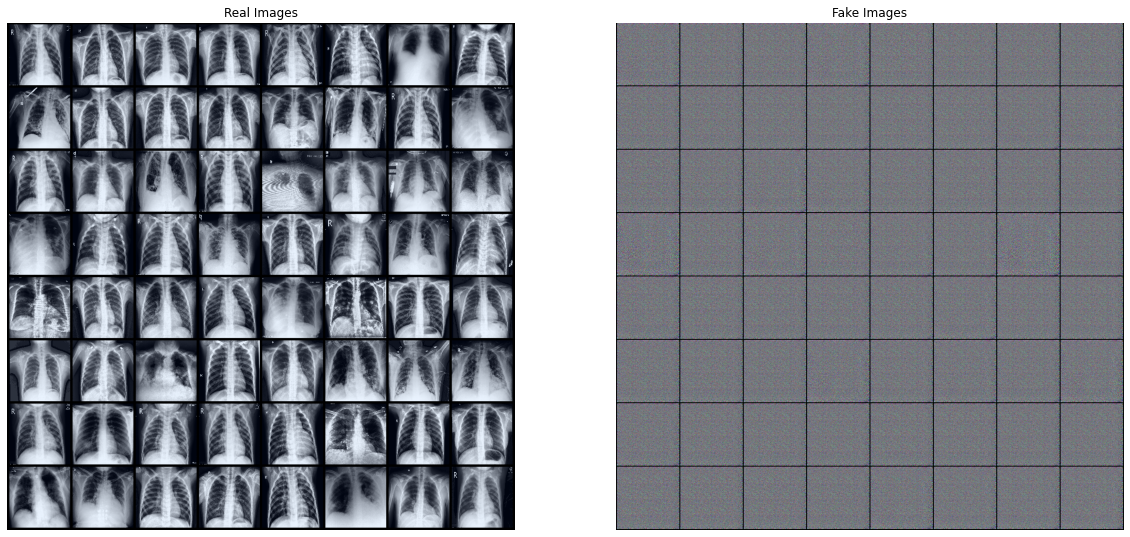

In [12]:
test_gan(acgan)

In [13]:
def plot_gan(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    plt.show()
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H-%M-%S")))

In [14]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['G_losses'][-1]
    d_losses = metrics['D_losses'][-1]
    path='GANAug/plots/ACGAN/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H-%M-%S"))
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)
    plot_gan('G_losses', num_epochs, metrics['G_losses'], path, True)
    plot_gan('D_losses', num_epochs, metrics['D_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('G_class_losses', num_epochs, metrics['G_class_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('D_class_losses', num_epochs, metrics['D_class_losses'], path, True)
    plot_gan('D_syn_losses', num_epochs, metrics['D_syn_losses'], path, True)
    plot_gan('Losses', num_epochs, metrics['Losses'], path, True)

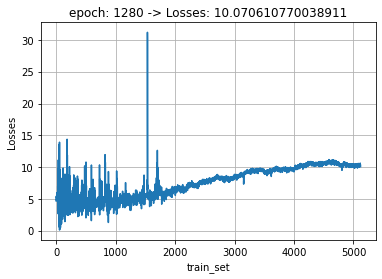

In [15]:
save_model(acgan.generator, acgan.discriminator, acgan.optimizer_g, acgan.optimizer_d, acgan.metrics, acgan.num_epoch)

C:\Users\lebro\AppData\Local\Temp\ipykernel_22448\1298441974.py:118: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


Discriminator s tensor([[6.1218e-26],
        [1.5028e-28],
        [4.7237e-30],
        [1.8483e-27],
        [1.1594e-28],
        [8.3708e-27],
        [2.6810e-26],
        [8.6166e-24],
        [3.3970e-26],
        [3.6592e-28],
        [2.6235e-26],
        [3.8037e-27],
        [5.2773e-29],
        [1.4358e-26],
        [3.7458e-29],
        [2.1158e-28],
        [2.6955e-26],
        [2.7091e-27],
        [2.6882e-27],
        [5.8383e-29],
        [3.0416e-28],
        [1.8713e-26],
        [2.2378e-25],
        [3.1337e-26],
        [6.2792e-26],
        [3.2934e-31],
        [8.0937e-28],
        [1.6230e-26],
        [8.1363e-27],
        [3.7020e-27],
        [2.8708e-29],
        [2.4290e-27],
        [1.6391e-28],
        [2.1041e-27],
        [1.6553e-29],
        [6.6198e-28],
        [4.2996e-26],
        [1.0283e-27],
        [1.6667e-27],
        [5.4042e-27],
        [2.2400e-28],
        [1.9198e-26],
        [2.2775e-27],
        [3.9324e-28],
        [6.2765e

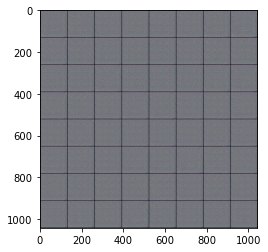

In [16]:
test_img_list = []
test_noise = torch.randn(acgan.batch_size, acgan.size_of_z, 1, 1, device=device)
test_label = torch.randn(acgan.batch_size, acgan.num_of_label, device=device)
test_img = acgan.generator(test_noise)

s_output, c_label_op = acgan.discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))

class label for real tensor([0, 1, 2, 2, 2, 0, 0, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 1, 0, 1, 2, 0, 2, 0,
        2, 0, 1, 0, 2, 1, 0, 2, 1, 0, 0, 0, 2, 0, 1, 0, 2, 1, 0, 0, 2, 1, 1, 1,
        0, 1, 0, 0, 2, 2, 0, 0, 1, 2, 0, 0, 1, 0, 1, 2])
Discriminator s tensor([[1.0000],
        [0.9729],
        [1.0000],
        [1.0000],
        [0.9996],
        [1.0000],
        [0.9441],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9998],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9995],
        [0.9132],
        [0.9999],
        [1.0000],
        [1.0000],
        [0.9993],
        [1.0000],
        [0.9971],
        [0.9141],
        [1.0000],
        [1.0000],
        [0.9999],
        [1.0000],
        [0.9999],
        [1.0000],
        [1.0000],
        [0.9998],
        [0.9995],
        [1.0000],
        [1.0000],
        [0.9222],
        [0.9936],
        [1.0000],
        [0.9999],
        [1.0000],
        [1.0000],
        

C:\Users\lebro\AppData\Local\Temp\ipykernel_22448\1298441974.py:118: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


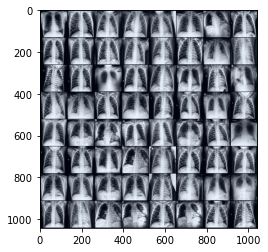

In [17]:
data = next(iter(acgan.test_loader))
test_noise, test_class_lable = data
test_img = test_noise
print('class label for real', test_class_lable)

s_output,c_label_op = acgan.discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))